# Installs & Imports

In [1]:
!pip install -q albumentations
!pip install -q natsort
!pip install -q patchify
!pip install -q lightning
!pip install -q lightning[extra]
!pip install -q segmentation_models_pytorch
!pip install -q wandb
!pip install -q nibabel
!pip install -q ttach

In [2]:
!pip install monai==1.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.2 MB/s eta 0:00:00a 0:00:01


In [3]:
!pip install -q einops

In [4]:
!pip install -q scikit-learn

In [5]:
#!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [6]:
!pip install -q medpy

In [7]:
!pip install -q einsum

In [8]:
!pip install -q scikit-image

In [2]:
# Standard libraries
import os
import json
import glob
import shutil
import tempfile
import random
import warnings
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Third-party libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import albumentations as A
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.nn.functional as F
from skimage import filters
from skimage.measure import label as label_fn, regionprops
from skimage import morphology
from sklearn.model_selection import train_test_split
from copy import deepcopy
from tqdm.notebook import tqdm


# MONAI related imports
from monai.config import print_config
from monai.networks.nets import UNet, BasicUNetPlusPlus,SwinUNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.transforms import (
    AsDiscrete, AsDiscreted, EnsureChannelFirstd, Compose, CropForegroundd,
    LoadImaged, Orientationd, RandCropByPosNegLabeld, SaveImaged, ScaleIntensityRanged,
    Spacingd, Invertd, ResizeWithPadOrCropd, Resized, MapTransform, ScaleIntensityd,
    LabelToContourd, ForegroundMaskd, HistogramNormalized, RandFlipd, RandGridDistortiond,
    RandHistogramShiftd, RandRotated
)
from monai.handlers.utils import from_engine
from monai.utils.type_conversion import convert_to_numpy

# PyTorch Lightning related imports
import lightning.pytorch as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch import seed_everything

# Weights & Biases
import wandb

# Patchify
from patchify import patchify, unpatchify

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

from natsort import natsorted, ns
from utiils import *
import monai
from PIL import Image

from boundaryloss.dataloader import dist_map_transform

from numpy import einsum
from torch.utils.data import default_collate

# Set precision for matmul operations and print MONAI config
torch.set_float32_matmul_precision('medium')
print_config()


# Uncomment below line to ignore warnings
# warnings.filterwarnings("ignore")

MONAI version: 1.4.0
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.2
Pillow version: 10.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 5.2.0
TorchVision version: 0.17.1
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing t

# Env setup

In [3]:
wandb.login(key = "2bc18e4744fb0771a16fd009b7aa2c98c79efc49")

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pablo-giaccaglia to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
checkpoints_dir="checkpoints"


train_ratio = 0.8
validation_ratio = 0.4
test_ratio = 1 - train_ratio
SEED = 200
batch_size = 32
n_cpu = os.cpu_count()

def seed_worker(worker_id):
    worker_seed = 200
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def reseed():
    SEED = 200
    print(f'Using random seed {SEED}...')

    g = torch.Generator()
    g.manual_seed(SEED)

    seed_everything(SEED, workers=True)
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic=True
    torch.use_deterministic_algorithms(True)

    return g


g = reseed()

Seed set to 200


Using random seed 200...


In [5]:
def get_image_label_files(dataset_base_path, split, image_type):

    all_images_fnames = []
    all_labels_fnames = []


    split_folder = os.path.join(dataset_base_path, split)

    patients_images_folders_base_path = os.path.join(split_folder, "images")
    patients_images_folders = os.listdir(patients_images_folders_base_path)
    patients_images_folders = [os.path.join(patients_images_folders_base_path, p) for p in patients_images_folders]
    patients_images_folders= natsorted(patients_images_folders, alg=ns.IGNORECASE)


    patients_labels_folders_base_path = os.path.join(split_folder, "labels")
    patients_labels_folders = os.listdir(os.path.join(split_folder, "labels"))
    patients_labels_folders = [os.path.join(patients_labels_folders_base_path,p) for p in patients_labels_folders]
    patients_labels_folders= natsorted(patients_labels_folders, alg=ns.IGNORECASE)
    for patient_images_folder, patient_labels_folder in zip(patients_images_folders, patients_labels_folders):

        images_folder = os.path.join(patient_images_folder, image_type)
        labels_folder = os.path.join(patient_labels_folder, image_type)
        
        images_fnames = os.listdir(images_folder)
        images_fnames = [os.path.join(images_folder, p) for p in images_fnames]
        images_fnames= natsorted(images_fnames, alg=ns.IGNORECASE)

        labels_fnames = os.listdir(labels_folder)
        labels_fnames = [os.path.join(labels_folder, p) for p in labels_fnames]
        labels_fnames= natsorted(labels_fnames, alg=ns.IGNORECASE)

        all_images_fnames += images_fnames
        all_labels_fnames += labels_fnames


    return all_images_fnames, all_labels_fnames 

def get_image_label_files_patient_aware(dataset_base_path, split, image_type, patient_id):

    split_folder = os.path.join(dataset_base_path, split)

    patients_images_folders_base_path = os.path.join(split_folder, "images")
    patients_images_folders = os.path.join(patients_images_folders_base_path, patient_id+'/'+image_type)


    patients_labels_folders_base_path = os.path.join(split_folder, "labels")
    patients_labels_folders = os.path.join(patients_labels_folders_base_path,patient_id+'/'+image_type)
        
    images_fnames = os.listdir(patients_images_folders)
    images_fnames = [os.path.join(patients_images_folders, p) for p in images_fnames]
    images_fnames= natsorted(images_fnames, alg=ns.IGNORECASE)

    labels_fnames = os.listdir(patients_labels_folders)
    labels_fnames = [os.path.join(patients_labels_folders, p) for p in labels_fnames]
    labels_fnames= natsorted(labels_fnames, alg=ns.IGNORECASE)

    return images_fnames, labels_fnames 
  

def get_patient_ids(dataset_base_path, split, image_type):
    split_folder = os.path.join(dataset_base_path, split)

    patients_images_folders_base_path = os.path.join(split_folder, "images")
    patient_ids = os.listdir(patients_images_folders_base_path)

    return patient_ids
    

In [6]:
x_test = get_patient_ids(dataset_base_path="BreaDM/seg", split="test", image_type="VIBRANT+C2")

# Utility functions

In [7]:
import numpy as np
from skimage.measure import label as LABEL, regionprops
from scipy.spatial.distance import cdist
import ttach as tta
from ttach.base import Merger

from monai.transforms import KeepLargestConnectedComponent, RemoveSmallObjects


import cv2
import numpy as np

import torch
import torch.nn.functional as F

import numpy as np
from scipy.ndimage import label as labell, generate_binary_structure

def compute_iou_imagewise_from_cumulator(TPs, FPs, FNs, TNs, exclude_empty=False, exclude_empty_only_gt = False,return_std=False):

    tp = torch.cat([tp for tp in TPs])
    fp = torch.cat([fp for fp in FPs])
    fn = torch.cat([fn for fn in FNs])
    tn = torch.cat([tn for tn in TNs])

    if return_std:

        mean_iou, std_iou = compute_iou_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise',exclude_empty=exclude_empty, exclude_empty_only_gt =exclude_empty_only_gt, return_std=return_std)
        return mean_iou.item(), std_iou.item()

    else:

        return compute_iou_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise',exclude_empty=exclude_empty).item()

def compute_dice_imagewise_from_cumulator(TPs, FPs, FNs, TNs, exclude_empty=False, exclude_empty_only_gt = False, return_std=False):

    tp = torch.cat([tp for tp in TPs])
    fp = torch.cat([fp for fp in FPs])
    fn = torch.cat([fn for fn in FNs])
    tn = torch.cat([tn for tn in TNs])

    if return_std:
        mean_dice, std_dice =  compute_dice_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise',exclude_empty=exclude_empty, exclude_empty_only_gt=exclude_empty_only_gt, return_std=return_std)
        return mean_dice.item(), std_dice.item()

    else:

        return compute_dice_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise',exclude_empty=exclude_empty).item()


def compute_mean_iou_imagewise_from_cumulator(TPs, FPs, FNs, TNs, exclude_empty=False, return_std=False, reduce_mean=True):
    # Concatenate tensors for each metric

    try:
        tp = torch.cat([tp for tp in TPs])
        fp = torch.cat([fp for fp in FPs])
        fn = torch.cat([fn for fn in FNs])
        tn = torch.cat([tn for tn in TNs])
    except:
        tp = TPs
        fp = FPs
        fn = FNs
        tn = TNs

    if exclude_empty:
        # Calculate IOU per image excluding empty cases
        iou1_per_image_no_empty = compute_iou_from_metrics(tp, fp, tn, fn, reduction='none', exclude_empty=True)
        iou0_per_image_no_empty = compute_iou_from_metrics(tn, fn, tp, fp, reduction='none', exclude_empty=True)
        
        # Combine and filter valid IOU scores
        combined_iou_scores = np.hstack((iou0_per_image_no_empty, iou1_per_image_no_empty))
        valid_pairs = ~np.isnan(combined_iou_scores).any(axis=1)
        
        # Compute mean and optionally standard deviation
        mean_iou_per_image_no_empty = np.nanmean(combined_iou_scores[valid_pairs], axis=1)

        if not reduce_mean:
            return mean_iou_per_image_no_empty
        if return_std:
            std_iou_per_image_no_empty = np.nanstd(mean_iou_per_image_no_empty)
            return np.mean(mean_iou_per_image_no_empty), std_iou_per_image_no_empty
        else:
            return np.mean(mean_iou_per_image_no_empty)

    else:
        # Calculate IOU per image including empty cases
        iou1_per_image = compute_iou_from_metrics(tp, fp, tn, fn, reduction='none')
        iou0_per_image = compute_iou_from_metrics(tn, fn, tp, fp, reduction='none')
        
        # Compute mean and optionally standard deviation
        combined_iou_scores = np.array([iou0_per_image.cpu().numpy(), iou1_per_image.cpu().numpy()])
        mean_iou_per_image = np.nanmean(combined_iou_scores, axis=0)
        
        if not reduce_mean:
            return mean_iou_per_image
        if return_std:
            std_iou_per_image = np.nanstd(mean_iou_per_image)
            return np.mean(mean_iou_per_image), std_iou_per_image
        else:
            return np.mean(mean_iou_per_image)

def compute_mean_dice_imagewise_from_cumulator(TPs, FPs, FNs, TNs, exclude_empty=False, return_std=False, reduce_mean=True):
    try:
        tp = torch.cat([tp for tp in TPs])
        fp = torch.cat([fp for fp in FPs])
        fn = torch.cat([fn for fn in FNs])
        tn = torch.cat([tn for tn in TNs])
    except:
        tp = TPs
        fp = FPs
        fn = FNs
        tn = TNs

    if exclude_empty:
        dice1_per_image_no_empty = compute_dice_from_metrics(tp, fp, tn, fn, reduction='none', exclude_empty=True)
        dice0_per_image_no_empty = compute_dice_from_metrics(tn, fn, tp, fp, reduction='none', exclude_empty=True)
        combined_dice_scores = np.hstack((dice0_per_image_no_empty, dice1_per_image_no_empty))
        valid_pairs = ~np.isnan(combined_dice_scores).any(axis=1)
        mean_dice_per_image_no_empty = np.nanmean(combined_dice_scores[valid_pairs], axis=1)
        if not reduce_mean:
            return mean_dice_per_image_no_empty
        if return_std:
            std_dice_per_image_no_empty = np.std(np.nanmean(combined_dice_scores[valid_pairs], axis=1))
            return np.mean(mean_dice_per_image_no_empty), std_dice_per_image_no_empty
        else:
            return np.mean(mean_dice_per_image_no_empty)
    else:
        dice1_per_image = compute_dice_from_metrics(tp, fp, tn, fn, reduction='none')
        dice0_per_image = compute_dice_from_metrics(tn, fn, tp, fp, reduction='none')
        combined_dice_scores = np.array([dice0_per_image.cpu().numpy(), dice1_per_image.cpu().numpy()])
        mean_dice_per_image = np.nanmean(combined_dice_scores, axis=0)
        if not reduce_mean:
            return mean_dice_per_image
        if return_std:
            std_dice_per_image = np.std(np.nanmean(combined_dice_scores, axis=0))
            return np.mean(mean_dice_per_image), std_dice_per_image
        else:
            return np.mean(mean_dice_per_image)



def plot_slices_side_by_side(volume1, volume2):
    """
    Plot corresponding slices from two CxHxW volumes side by side.
    
    :param volume1: First volume with shape CxHxW.
    :param volume2: Second volume with shape CxHxW.
    """
    H, W, B = volume1.shape  # Assuming volume1 and volume2 have the same shape
    
    # Set up the figure size dynamically based on the number of slices
    plt.figure(figsize=(10, 2 * B))
    
    for b in range(B):
        # Plot slice from volume 1
        plt.subplot(B, 2, 2*b + 1)  # Rows, Columns, Index
        plt.imshow(volume1[:, :,b], cmap='gray')
        plt.title(f'Slice {b + 1} - Volume 1')
        plt.axis('off')  # Hide axes ticks
        
        # Plot corresponding slice from volume 2
        plt.subplot(B, 2, 2*b + 2)  # Rows, Columns, Index
        plt.imshow(volume2[:, :,b], cmap='gray')
        plt.title(f'Slice {b + 1} - Volume 2')
        plt.axis('off')  # Hide axes ticks
    
    plt.tight_layout()
    plt.show()

def calculate_local_agreement(prob1, prob2, kernel_size=3, agreement_threshold=0.1):
    """
    Calculate local agreement between two probability masks using average pooling to simulate
    the surrounding window effect.
    """
    # Calculate absolute difference and apply threshold
    diff = torch.abs(prob1 - prob2)
    local_diff = F.avg_pool2d(diff.unsqueeze(0), kernel_size, stride=1, padding=kernel_size//2).squeeze(0)
    local_agreement = local_diff < agreement_threshold
    return local_agreement

def fill_gaps_in_masses(binary_mask, gap_filling_kernel_size=5):
    """
    Fills gaps in segmented masses using morphological closing.
    
    Parameters:
    - binary_mask: numpy.ndarray, the binary segmentation mask with masses.
    - gap_filling_kernel_size: int, the size of the square kernel used for gap filling.
    
    Returns:
    - gap_filled_mask: numpy.ndarray, the mask after filling gaps.
    """

    print(np.unique(binary_mask))
    # Define the square kernel based on the specified size
    kernel_gap_filling = np.ones((gap_filling_kernel_size, gap_filling_kernel_size), np.uint8)
    
    # Perform the morphological closing operation
    gap_filled_mask = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel_gap_filling)
    
    return gap_filled_mask


def perform_dilation(image, dilation_size=3):
    """
    Perform dilation on an image using OpenCV.
    
    :param image: Input binary image with objects to dilate.
    :param dilation_size: Determines the size of the dilation kernel. Default is 3.
    :return: Image after dilation.
    """

    image = (image > 0).astype(np.uint8)
    # Create a square structuring element for dilation
    kernel = np.ones((dilation_size, dilation_size), np.uint8)
    
    # Perform dilation
    dilated_image = cv2.dilate(image, kernel, iterations=1)
    
    return dilated_image


def remove_far_masses_based_on_largest_mass(batch_masks, distance_threshold):
    """
    Remove masses in each mask of the batch that are far from the largest mass.

    Parameters:
    - batch_masks: numpy array of shape BCHW.
    - distance_threshold: distance beyond which a mass is considered far.

    Returns:
    - processed_masks: numpy array of shape BCHW with far masses removed.
    """
    processed_masks = np.zeros_like(batch_masks)

    for i, mask in enumerate(batch_masks):
        # Ensure the mask is 2D
        if mask.ndim == 3:  # BCHW where C=1
            mask_2d = mask[0]
        elif mask.ndim == 2:  # HW
            mask_2d = mask
        else:
            raise ValueError("Mask dimension is not correct. Expected 2D or 3D with single channel.")

        # Label the connected components with 2D connectivity
        labeled_mask = LABEL(mask_2d.cpu(), connectivity=1)

        # Calculate properties of each component
        regions = regionprops(labeled_mask)

        if not regions:
            continue

        # Find the largest mass
        largest_mass = max(regions, key=lambda x: x.area)

        # Get the centroid of the largest mass
        largest_mass_centroid = largest_mass.centroid

        # Identify and keep components close to the centroid of the largest mass
        for region in regions:
            centroid = region.centroid
            distance = np.sqrt((centroid[0] - largest_mass_centroid[0]) ** 2 + (centroid[1] - largest_mass_centroid[1]) ** 2)
            if distance < distance_threshold:
                processed_masks[i, 0, region.coords[:,0], region.coords[:,1]] = 1

    return processed_masks


def save_to_json(data, filename):
    try:
        with open(filename, 'w') as file:
            json.dump(data, file, indent=4)
        print(f"Dictionary successfully saved to {filename}")
    except Exception as e:
        print(f"Error saving dictionary to file: {e}")


def load_json_file(file_path):
    """Load and return the content of a JSON file."""
    with open(file_path, 'r') as file:
        return json.load(file)



def get_filenames(suffix, base_path, patient_ids, remove_black_samples=False, get_random_samples_and_remove_black_samples=False, get_top_bottom_and_remove_black_samples=False,random_samples_indexes_list=None,
                 remove_picked_samples=False):
    filenames = []

    create_random_samples_index_list = False

    if random_samples_indexes_list is None:
        random_samples_indexes_list = []
        create_random_samples_index_list=True

    for idx, patient_id in enumerate(patient_ids):
        path = os.path.join(base_path, patient_id) + "/" + suffix + "/"
        files = [os.path.join(path, p) for p in natsorted(os.listdir(path), alg=ns.IGNORECASE)]

        if get_random_samples_and_remove_black_samples:
              files_sampled = filter_samples_sample_aware(files, patient_id)
              if remove_picked_samples:
                  files_sampled = filter_samples_to_exclude(files_sampled, patient_id)
              filenames += files_sampled
              size = int(len(files_sampled)*0.25)


              random_samples_indexes = None if create_random_samples_index_list else random_samples_indexes_list[idx]
              files_random, random_samples_indexes = get_samples_size(files=files, patient_id=patient_id, size=size, random_samples=True, random_samples_indexes=random_samples_indexes)

              if create_random_samples_index_list:
                  random_samples_indexes_list.append(random_samples_indexes)

              filenames += files_random

        elif remove_black_samples:
              files_sampled = filter_samples_sample_aware(files, patient_id)
              if remove_picked_samples:
                  files_sampled = filter_samples_to_exclude(files_sampled, patient_id)
                
              filenames += files_sampled

        elif get_top_bottom_and_remove_black_samples:
              files_sampled = filter_samples_sample_aware(files, patient_id)
              if remove_picked_samples:
                  files_sampled = filter_samples_to_exclude(files_sampled, patient_id)
              filenames += files_sampled

              size = int(len(files_sampled)*0.25)
              files_top_bottom = get_samples_size(files=files, patient_id=patient_id, size=size, random_samples=False)
              filenames += files_top_bottom

        else:
              filenames += files

    if get_random_samples_and_remove_black_samples:
      return filenames, random_samples_indexes_list
    else:
      return filenames, None

def get_samples_size(files, patient_id, size=None, random_samples=False, random_samples_indexes=None):

    top_slices_len = d[patient_id]['start']
    top_slices = files[:top_slices_len]
    sample_size_top_slices = size

    bottom_slices_len = len(files) - d[patient_id]['end']
    bottom_slices = files[d[patient_id]['end']:]
    sample_size_bottom_slices = size

    if random_samples:
        if random_samples_indexes:
          subset_top_slices_random_indexes = random_samples_indexes[0]
        else:
          if sample_size_top_slices > len(top_slices):
            sample_size_top_slices=len(top_slices)

          subset_top_slices_random_indexes = random.sample(range(len(top_slices)), sample_size_top_slices)

        subset_top_slices = [top_slices[i] for i in subset_top_slices_random_indexes]

        if random_samples_indexes:
              subset_bottom_slices_random_indexes = random_samples_indexes[1]
        else:
          if sample_size_bottom_slices > len(bottom_slices):
            sample_size_bottom_slices=len(bottom_slices)

          subset_bottom_slices_random_indexes = random.sample(range(len(bottom_slices)), sample_size_bottom_slices)
            
        subset_bottom_slices=  [bottom_slices[i] for i in subset_bottom_slices_random_indexes]

        files_to_return = subset_top_slices + subset_bottom_slices
        return files_to_return, [subset_top_slices_random_indexes, subset_bottom_slices_random_indexes]



    else:
        if sample_size_top_slices > len(top_slices):
            sample_size_top_slices=len(top_slices)
        if sample_size_bottom_slices > len(bottom_slices):
            sample_size_bottom_slices=len(bottom_slices)

        subset_top_slices = top_slices[-sample_size_top_slices:]
        subset_bottom_slices = bottom_slices[:sample_size_bottom_slices]
        files_to_return = subset_top_slices + subset_bottom_slices
        return files_to_return



def filter_samples_sample_aware(files, patient_id):
    start, end = d[patient_id]['start'], d[patient_id]['end']
    return files[start+1:end]

def filter_samples_to_exclude(files, patient_id):
    filtered_list = []
    if patient_id not in to_remove_dict:
        return files
    files_to_exclude = to_remove_dict[patient_id]

    filtered_list = []
    for file in files:
        file_clean = file.replace("mask_","")
        file_clean = file_clean.replace("masks","images")
        
        if file_clean not in files_to_exclude:
            filtered_list.append(file)

    return filtered_list



def filter_fn(image, max_ratio):
    c, h, w = image.shape

    if h >= w:
        if w == 0 or max_ratio < h/w:
          return False
    elif w >= h:
        if h==0 or max_ratio < w/h:
            return False
    return True

def reverse_transformations(d, processed_label, mode='patches'):
    # Extract the processed label and transformation coordinates
    y1_crop, y2_crop, x1_crop, x2_crop = d['crop_coords']
    x1_bottom, y1_bottom, x2_bottom, y2_bottom = d['bottom_crop_coords']

    if mode=='patches':
        start_breast, end_breast = d['trim_breast_coords']
    x1_thorax, y1_thorax, x2_thorax, y2_thorax = d['thorax_crop_coords']
    intermediate_spatial_dim = d['dim_before_resize_final']

    # Step 0: Resize to the original spatial dimensions before the final crop
    # Assuming 'resize' was a downscaling operation and the original_spatial_dim is the target size
    label_resized = F.interpolate(processed_label.unsqueeze(0).unsqueeze(0).float(),
                                  size=intermediate_spatial_dim.tolist(),  # Excluding the batch size dimension
                                  mode='nearest-exact').squeeze(0).squeeze(0)  # Removing the added batch and channel dimensions

    
    
    pad_post_crop_coords = d['pad_post_crop_coords'].tolist()
    before1, before2, before3 = pad_post_crop_coords[0],pad_post_crop_coords[1],pad_post_crop_coords[2]

    original_height = label_resized.shape[1] - before2[1]
    original_width = label_resized.shape[2] - before3[1]

    # Slice the image to remove the padding
    reversed_pad = label_resized[:, :original_height, :original_width]

    # Step 1: Reverse final crop
    crop_height, crop_width = d['dim_before_crop'][1:]
    padded_label = torch.zeros((1, crop_height, crop_width), dtype=label_resized.dtype)
    padded_label[:, y1_crop:y2_crop, x1_crop:x2_crop] = reversed_pad

    # Step 2: Reverse bottom crop
    bottom_height = d['dim_before_bottom_crop'][1]
    bottom_width = d['dim_before_bottom_crop'][2]
    bottom_padded_label = torch.zeros((1, bottom_height, x2_bottom), dtype=padded_label.dtype)
    bottom_padded_label[:, :y2_bottom, :x2_bottom] = padded_label

    # Conditional steps based on whether breast trim was applied
    if mode == 'patches':
        # Step 3: Reverse breast trim
        trim_width = d['dim_before_breast_crop'][2]
        trim_padded_label = torch.zeros((bottom_height, trim_width), dtype=bottom_padded_label.dtype)
        trim_padded_label[:, start_breast:end_breast] = bottom_padded_label
    else:
        # In other modes, use the bottom_padded_label directly for thorax crop reversal
        trim_padded_label = bottom_padded_label
        trim_width = bottom_width  # This assumes no trimming, hence the width is unchanged

    
    # Step 4: Reverse thorax crop
    thorax_height = d['dim_before_thorax_crop'][1]
    thorax_padded_label = torch.zeros((1, thorax_height, trim_width), dtype=trim_padded_label.dtype)
    thorax_padded_label[:, y1_thorax:, :] = trim_padded_label


    original_spatial_dim = d['dim_before_resize_preliminary']

    # Step 0: Resize to the original spatial dimensions before the final crop
    # Assuming 'resize' was a downscaling operation and the original_spatial_dim is the target size
    reconstructed_mask = F.interpolate(thorax_padded_label.unsqueeze(0).unsqueeze(0).float(),
                                  size=original_spatial_dim.tolist(),  # Excluding the batch size dimension
                                  mode='nearest-exact').squeeze(0).squeeze(0)  # Removing the added batch and channel dimensions


    # Update the original label in the dictionary
    return reconstructed_mask

def get_mean_std_dataloader(dataloader, masked=False):
  # Variables to store sum and sum of squares
  sum_of_images = 0.0
  sum_of_squares = 0.0
  num_pixels = 0

  # Iterate over the DataLoader
  for batch in tqdm(dataloader):
      image = batch["image"]

      if masked:
        mask = image > 0.0
        image = image[mask]

      sum_of_images += image.sum()
      sum_of_squares += (image ** 2).sum()
      num_pixels += image.numel()

  # Calculate the mean and standard deviation
  mean = sum_of_images / num_pixels
  std_dev = (sum_of_squares / num_pixels - mean ** 2) ** 0.5

  print(f'Mean: {mean}, Standard Deviation: {std_dev}')
  return mean, std_dev

# Transform functions

In [8]:
class EnhanceLesionsSelective(MapTransform):
    """
    A MONAI MapTransform to enhance lesions selectively in post-contrast images using a soft mask derived from the subtracted image.
    """
    def __init__(self, keys, threshold=0.9):
        super().__init__(keys)
        self.threshold = threshold

    def create_soft_mask(self, subtracted_norm, threshold=0.9):
        """
        Create a soft mask where values are scaled between 0 and max_value,
        with intensities above 'threshold' in the subtracted image being closer to max_value.
        """
        subtracted_norm = np.where(subtracted_norm > threshold, threshold, subtracted_norm/threshold)
        return subtracted_norm

    def __call__(self, data):
        d = dict(data)
        
        for key in self.keys:
            
            subtracted = d[key]  # Assuming d[key] is a tuple (post_contrast, subtracted)

            fourth_image = d['processed_image'] # 4th sequence
            subtracted = np.array(subtracted)
            
            # Normalize the subtracted image to [0, 1]
            subtracted_norm = cv2.normalize(subtracted[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            
            # Create a soft mask from the normalized subtracted image
            soft_mask = self.create_soft_mask(subtracted_norm, threshold=self.threshold)
            
            # Normalize the post-contrast image to [0, 1] and apply the soft mask
            fouth_image_norm = cv2.normalize(fourth_image[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            enhanced_image = soft_mask*fouth_image_norm
            
            # Combine enhanced image with the normalized subtracted image for final enhancement
            enhanced_image_final = subtracted_norm + enhanced_image

            enhanced_image_final=cv2.normalize(enhanced_image_final, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            
            # Assuming the result should maintain the original shape as 1 x H x W
            enhanced_image_final = np.expand_dims(enhanced_image_final, 0)

            d[key] = monai.data.MetaTensor(enhanced_image_final)
        
        return d



class RemoveThorax(MapTransform):

    def __init__(self, threshold=250, value=0, margin=0,**kwargs):
        super(RemoveThorax, self).__init__(**kwargs)
        self.threshold = threshold
        self.value = value
        self.margin = margin

    def remove_upper_portion_get_coords(self, image):
        # IMAGE IS C, H, W
        # Step 1: Find the vertical middle line of the image
        middle_x = image.shape[2] // 2

        non_zero_y = 0
        for y in reversed(range(image.shape[1])):
            if image[:,y, middle_x] > 0:
                non_zero_y = y
                break

        return non_zero_y  # Also return the y-coordinate for reference

    def __call__(self, data):
        d = dict(data)
        image_to_threshold = d['processed_image']
        dim_before_thorax_crop = torch.tensor(image_to_threshold.shape)
        image_to_threshold = np.where(image_to_threshold < self.threshold, self.value, image_to_threshold)
        y_coord = self.remove_upper_portion_get_coords(image_to_threshold)-self.margin
        thorax_crop_coords = torch.tensor([0, y_coord, image_to_threshold.shape[2], image_to_threshold.shape[1]], dtype=torch.int16)  # (x1, y1, x2, y2)
        image = d['processed_image']
        image = image[:,y_coord:, :]

        if data['has_mask']:
            mask = d['processed_label']
            mask = mask[:,y_coord:, :]
            d['processed_label'] = mask

        d['processed_image'] = image
        d['thorax_crop_coords'] = torch.cat((d['thorax_crop_coords'], thorax_crop_coords), dim=0)
        d['dim_before_thorax_crop'] = torch.cat((d['dim_before_thorax_crop'], dim_before_thorax_crop), dim=0)
        return d


class RemoveBottom(MapTransform):

    def __init__(self, threshold=250, value=0, margin=0, **kwargs):
        super(RemoveBottom, self).__init__(**kwargs)
        self.threshold = threshold
        self.value = value
        self.margin = margin

    def remove_lower_portion_get_coords(self, image):

        # Step 2: Starting from the bottom, find the first non-zero pixel
        non_zero_y = image.shape[1]-1
        for y in reversed(range(image.shape[1])):  # Start from the bottom
            if np.sum(image[:,y,:]) > 0:
                non_zero_y = y
                break

        return non_zero_y  # Also return the y-coordinate for reference

    def __call__(self, data):
        d = dict(data)
        image_to_threshold = d['processed_image']

        """print("ciao prima")
        plt.imshow(image_to_threshold[0], cmap='gray')
        plt.show()"""

        image_to_threshold = np.where(image_to_threshold < self.threshold, self.value, image_to_threshold)
        y_coord = self.remove_lower_portion_get_coords(image_to_threshold)+self.margin

        bottom_crop_coords = torch.tensor([0, 0, image_to_threshold.shape[2], y_coord], dtype=torch.int16)  # (x1, y1, x2, y2)
        image = d['processed_image']
        dim_before_bottom_crop = torch.tensor(image.shape)
        image = image[:,:y_coord, :]

        if d['has_mask']:
            mask = d['processed_label']
            mask = mask[:,:y_coord, :]
            d['processed_label'] = mask

        d['processed_image'] = image
        d['bottom_crop_coords'] = torch.cat((d['bottom_crop_coords'], bottom_crop_coords), dim=0)
        d['dim_before_bottom_crop'] = torch.cat((d['dim_before_bottom_crop'], dim_before_bottom_crop), dim=0)

        return d
class FilterBySize(MapTransform):

    def __init__(self, max_ratio, **kwargs):
        super(FilterBySize, self).__init__(**kwargs)
        self.max_ratio = max_ratio
        self.delete = monai.transforms.DeleteItemsd(keys = ['image', 'label'])

    def __call__(self, data):
        d = dict(data)
        c, h, w = d['image'].shape

        if h >= w:

          if w == 0 or self.max_ratio < h/w:
            return self.delete(d)
        elif w >= h:
          if h==0 or self.max_ratio < w/h:
            return self.delete(d)

        return d


class MedianSmooth(MapTransform):

    def __init__(self, radius, **kwargs):
        super(MedianSmooth, self).__init__(**kwargs)
        self.median_smooth = monai.transforms.MedianSmooth(radius=radius)


    def __call__(self, data):
        d = dict(data)
        d['processed_image'] = self.median_smooth(d['processed_image'])
        return d


class TrimSides(MapTransform):

    def __init__(self, keys, threshold, tolerance, **kwargs):
        super(TrimSides, self).__init__(keys, **kwargs)
        self.threshold = threshold
        self.tolerance = tolerance

    def trim_sides(self, image_data, threshold=0, tolerance=0):
        # Calculate the sum of pixel values across the channel axis for each column
        col_sum = np.sum(image_data, axis=0).sum(axis=0)


        # Find indices where the sum exceeds the threshold
        x_start = np.argmax(col_sum > threshold)
        x_end = len(col_sum) - np.argmax(col_sum[::-1] > threshold) - 1

        # Apply tolerance
        x_start = max(0, x_start - tolerance)
        x_end = min(len(col_sum) - 1, x_end + tolerance)

        return x_start, x_end

    def __call__(self, data):
        d = dict(data)
        image = d['processed_image']


        x_start, x_end = self.trim_sides(image_data=image, threshold=self.threshold, tolerance=self.tolerance)

        # Crop the image and mask
        cropped_image = image[:, :, x_start:x_end+1]



        trim_coords = torch.tensor([x_start, x_end+1], dtype=torch.int16)

        # Update the dictionary
        d['processed_image'] = cropped_image

        if d['has_mask']:
            mask = d['processed_label']
            cropped_mask = mask[:, :, x_start:x_end+1]
            d['processed_label'] = cropped_mask


        d['trim_coords'] = torch.cat((d['trim_coords'], trim_coords), dim=0)

        return d

class RelativeThresholding(MapTransform):
    def __init__(self, keys, relative_threshold):
        super().__init__(keys)
        self.relative_threshold = relative_threshold

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            # assuming the image's pixel values are in the range [0, 1]
            # if your image has a different range, adjust the max_intensity and threshold_value calculation accordingly
            max_intensity = np.max(d[key])
            threshold_value = max_intensity * self.relative_threshold

            # apply the thresholding
            d[key] = torch.tensor(np.where(d[key] >= threshold_value, 1, 0))
        return d


class RelativeThresholdingSingleChannel(MapTransform):
    def __init__(self, keys, relative_threshold, channel_index):
        super().__init__(keys)
        self.relative_threshold = relative_threshold
        self.channel_index = channel_index

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            original_image = d[key]

            # Extract the specific channel
            single_channel = original_image[self.channel_index]

            # assuming the image's pixel values are in the range [0, 1]
            # if your image has a different range, adjust the max_intensity and threshold_value calculation accordingly
            max_intensity = torch.max(single_channel)
            threshold_value = max_intensity * self.relative_threshold

            # apply the thresholding to the single channel
            transformed_channel = torch.where(single_channel >= threshold_value, 1, 0)

            # Replace the channel in the original image
            transformed_image = torch.clone(original_image)  # make a copy of the original image
            transformed_image[self.channel_index] = transformed_channel
            d[key] = transformed_image

        return d

class ThresholdBlack(MapTransform):

    def __init__(self, threshold, value, **kwargs):
        super(ThresholdBlack, self).__init__(**kwargs)
        self.threshold = threshold
        self.value = value

    def __call__(self, data):
        d = dict(data)

        d['processed_image'] = monai.data.MetaTensor(np.where(d['processed_image'] < self.threshold, self.value, d['processed_image']))

        if d['has_mask']:
            d['processed_label'] = monai.data.MetaTensor(np.where(d['processed_label'] < self.threshold, self.value, d['processed_label']))


        return d


def get_crop_coordinates(image):
    image = image[200:,:]
    # Convert the image to uint8 type for compatibility with OpenCV functions
    image_uint8 = (image * 255).astype(np.uint8)

    # Apply a binary threshold to segment the breasts from the background
    _, thresholded = cv2.threshold(image_uint8, 1, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours by area (largest first)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # If there are not enough contours found, return the original image
    if len(contours) < 2:
        return image

    # Get the bounding boxes of the two largest contours (likely the breasts)
    x1, y1, w1, h1 = cv2.boundingRect(contours[0])
    x2, y2, w2, h2 = cv2.boundingRect(contours[1])

    # Compute the combined bounding box
    x = min(x1, x2)
    y = min(y1, y2)
    w = max(x1 + w1, x2 + w2) - x
    h = max(y1 + h1, y2 + h2) - y

    y_start, y_end, x_start, x_end = y, y+h, x, x+w

    return y_start, y_end, x_start, x_end

def remove_black_borders_get_coordinates(image):
    """
    Remove black borders on the left and right of the image.
    """
    # Sum the pixel values across rows to get a profile of the image's columns
    column_sum = image.sum(axis=0)

    # Set a threshold (small value) to identify black regions
    threshold = 500

    # Identify where the profile transitions from nearly zero to non-zero
    non_black_columns = np.where(column_sum > threshold)[0]

    y_start, y_end = non_black_columns[0], non_black_columns[-1]+1

    return y_start, y_end

def remove_black_borders_2D_get_coordinates(image):
    """
    Remove black borders on all sides of the image.
    """
    # Sum the pixel values across columns and rows to get profiles of the image's columns and rows
    column_sum = image.sum(axis=0)
    row_sum = image.sum(axis=1)

    # Set a threshold (small value) to identify black regions
    col_threshold = 500
    row_threshold = 500

    # Identify where the profile transitions from nearly zero to non-zero for both columns and rows
    non_black_columns = np.where(column_sum > col_threshold)[0]
    non_black_rows = np.where(row_sum > row_threshold)[0]

    # Crop the image using the identified transition points
    y_start, y_end = non_black_columns[0], non_black_columns[-1]+1
    x_start, x_end = non_black_rows[0], non_black_rows[-1]+1
    return y_start, y_end, x_start, x_end

class RemoveBlack(MapTransform):

    def __init__(self, **kwargs):
        super(RemoveBlack, self).__init__(**kwargs)

    def __call__(self, data):

        d = dict(data)
        y_start, y_end, x_start, x_end = get_crop_coordinates(d['image'][0])
        if y_end-y_start < 100:
            return d
        d['image'] = d['image'][:,200:]
        d['label'] = d['label'][:,200:]

        d['image'] = d['image'][:, y_start: y_end+50]
        d['label'] = d['label'][:, y_start: y_end+50]

        y_start, y_end, x_start, x_end = remove_black_borders_2D_get_coordinates(d['image'][0])

        d['image'] = d['image'][:, x_start:x_end, y_start: y_end]
        d['label'] = d['label'][:, x_start:x_end, y_start: y_end]

        return d

class PrepareSample(MapTransform):

    def __init__(self, target_size, subtracted_images, patches, **kwargs):
        super(PrepareSample, self).__init__(**kwargs)
        self.resize = monai.transforms.Resized(keys=['image', 'label'],spatial_size=target_size, mode='nearest-exact')
        self.patches = patches
        self.resize_original = monai.transforms.Resized(keys=['original_image', 'original_label'],spatial_size=target_size,  mode='nearest-exact')
        self.subtracted_images = subtracted_images
        self.loadimage = monai.transforms.LoadImage(ensure_channel_first=True, reader=monai.data.PILReader(converter=lambda image: image.convert("L")))
        
                
    def prepare_with_patches(self,data):
        trim_breast_coords = data['trim_breast_coords'].tolist()
        #trim_coords = data['trim_coords'].tolist()
        thorax_crop_coords= data['thorax_crop_coords'].tolist()
        bottom_crop_coords= data['bottom_crop_coords'].tolist()

        crop_coords = data['crop_coords'].tolist()
        pad_post_crop_coords = data['pad_post_crop_coords'].tolist()

        if self.subtracted_images:
            image_path = data['image_meta_dict']['subtracted_filename_or_obj']
            if image_path.endswith(".npy"):
                image = np.load(image_path)
                image = np.expand_dims(image, 0)
                image = monai.data.MetaTensor(image)

            else:
                label_path = data['label_meta_dict']['subtracted_filename_or_obj']
                image = self.loadimage(image_path)
                image = monai.transforms.Rotate90()(image)
                image = monai.data.MetaTensor(image)
                
                label = self.loadimage(label_path)
                label = monai.transforms.Rotate90()(label)
                label = monai.data.MetaTensor(label)
                data['label'] = label
                

            data['image'] = image

       
        data = self.resize(data)

        data = self.resize_original(data)

        image = data['image']

        original_image = data['original_image']

        target_size = data['preliminary_target_size'].tolist()

        x1, y1, x2, y2 = thorax_crop_coords
        
        image = image[:,y1:, :]
        original_image = original_image[:,y1:, :]


        start, end = trim_breast_coords

        image = image[:,:, start:end]
        original_image = original_image[:,:, start:end]


        x1, y1, x2, y2 = bottom_crop_coords
        image = image[:,:y2, :]
        original_image = original_image[:,:y2, :]


        """start, end = trim_coords

        image = image[:, :, start:end]
        label = label[:, :,start: end]
        """
        y_min, y_max, x_min, x_max = crop_coords

        image = image[:, y_min:y_max, x_min:x_max]
        original_image = original_image[:, y_min:y_max, x_min:x_max]

        before1, before2, before3 = pad_post_crop_coords[0],pad_post_crop_coords[1],pad_post_crop_coords[2]

        image = np.pad(image, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')
        original_image = np.pad(original_image, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')

        data['image']=image
        data['processed_image'] = original_image


        if data['has_mask']:
            label = data['label']
            original_label = data['original_label']
            
            x1, y1, x2, y2 = thorax_crop_coords
            
            #label =  monai.transforms.Resize(spatial_size=target_size)(label)
            label = label[:,y1:, :]
            original_label = original_label[:,y1:, :]

            start, end = trim_breast_coords
            label = label[:,:, start:end]
            original_label = original_label[:,:, start:end]

            x1, y1, x2, y2 = bottom_crop_coords
            label = label[:,:y2, :]
            original_label = original_label[:,:y2, :]

            y_min, y_max, x_min, x_max = crop_coords
            label = label[:, y_min:y_max, x_min:x_max]
            original_label = original_label[:, y_min:y_max, x_min:x_max]

            before1, before2, before3 = pad_post_crop_coords[0],pad_post_crop_coords[1],pad_post_crop_coords[2]

            label = np.pad(label, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')
            original_label = np.pad(original_label, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')

            data['label']=label
            data['processed_label'] = original_label

        return data

    def prepare_without_patches(self,data):

        trim_breast_coords = data['trim_breast_coords'].tolist()
        #trim_coords = data['trim_coords'].tolist()
        thorax_crop_coords= data['thorax_crop_coords'].tolist()
        bottom_crop_coords= data['bottom_crop_coords'].tolist()

        crop_coords = data['crop_coords'].tolist()
        pad_post_crop_coords = data['pad_post_crop_coords'].tolist()

        if self.subtracted_images:
            image_path = data['image_meta_dict']['subtracted_filename_or_obj']
            if image_path.endswith(".npy"):
                image = np.load(image_path)
                image = np.expand_dims(image, 0)
                image = monai.data.MetaTensor(image)
                data['image'] = image

                 

            else: #FOR BRADM
                label_path = data['label_meta_dict']['subtracted_filename_or_obj']
                image = self.loadimage(image_path)
                image = monai.transforms.Rotate90()(image)
                image = monai.data.MetaTensor(image)
                
                label = self.loadimage(label_path)
                label = monai.transforms.Rotate90()(label)
                label = monai.data.MetaTensor(label)
                data['label'] = label
                data['image'] = image

        data = self.resize(data)
        data = self.resize_original(data)

        image = data['image']
        original_image = data['original_image']

        target_size = data['preliminary_target_size'].tolist()
        
        x1, y1, x2, y2 = thorax_crop_coords
        
        image = image[:,y1:, :]
        original_image = original_image[:,y1:, :]

        #start, end = trim_breast_coords

        #image = image[:,:, start:end]
        #original_image = original_image[:,:, start:end]


        x1, y1, x2, y2 = bottom_crop_coords
        image = image[:,:y2, :]
        original_image = original_image[:,:y2, :]

        y_min, y_max, x_min, x_max = crop_coords

        image = image[:, y_min:y_max, x_min:x_max]
        original_image = original_image[:, y_min:y_max, x_min:x_max]

        before1, before2, before3 = pad_post_crop_coords[0],pad_post_crop_coords[1],pad_post_crop_coords[2]

        image = np.pad(image, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')
        original_image = np.pad(original_image, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')

        data['image']=image
        data['processed_image'] = original_image


        
        if data['has_mask']:
            label = data['label']
            original_label = data['original_label']
            
            x1, y1, x2, y2 = thorax_crop_coords
            
            #label =  monai.transforms.Resize(spatial_size=target_size)(label)
            label = label[:,y1:, :]
            original_label = original_label[:,y1:, :]

            #start, end = trim_breast_coords
            #label = label[:,:, start:end]
            #original_label = original_label[:,:, start:end]

            x1, y1, x2, y2 = bottom_crop_coords
            label = label[:,:y2, :]
            original_label = original_label[:,:y2, :]

            y_min, y_max, x_min, x_max = crop_coords
            label = label[:, y_min:y_max, x_min:x_max]
            original_label = original_label[:, y_min:y_max, x_min:x_max]

            before1, before2, before3 = pad_post_crop_coords[0],pad_post_crop_coords[1],pad_post_crop_coords[2]

            label = np.pad(label, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')
            original_label = np.pad(original_label, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')

            data['label']=label
            data['processed_label'] = original_label

        return data
        
    def __call__(self, data):

        if self.patches:
            return self.prepare_with_patches(data)
        else:
            return self.prepare_without_patches(data)

    

class ForegroundMaskdSingleChannel(MapTransform):
    def __init__(self, keys, channel_index, num_bins=10):
        super().__init__(keys)
        self.foregroundMask= monai.transforms.ForegroundMask(invert=True)
        self.channel_index = channel_index

    def __call__(self, data):
        d = dict(data)

        for key in self.keys:

            original_image = d[key]

            # Extract the specific channel
            single_channel = original_image[self.channel_index]

            single_channel = np.expand_dims(single_channel, 0)

            # Apply the transform to this channel
            transformed_channel = self.foregroundMask(single_channel)

            # Replace the channel in the original image
            transformed_image = np.array(original_image)  # make a copy of the original image
            transformed_image[self.channel_index] = transformed_channel
            d[key] = torch.tensor(transformed_image)

        return d

class NormalizedSingleChannel(MapTransform):
    def __init__(self, keys, channel_index):
        super().__init__(keys)
        self.normalize = monai.transforms.NormalizeIntensity(subtrahend  = 0.1046, divisor=335.7632)
        self.channel_index = channel_index

    def __call__(self, data):
        d = dict(data)

        for key in self.keys:

            original_image = d[key]

            # Extract the specific channel
            single_channel = original_image[self.channel_index]

            single_channel = np.expand_dims(single_channel, 0)

            # Apply the transform to this channel
            transformed_channel = self.normalize(single_channel)[0]


            # Replace the channel in the original image
            transformed_image = np.array(original_image)  # make a copy of the original image

            transformed_image[self.channel_index] = transformed_channel
            d[key] = torch.tensor(transformed_image)

        return d


class Convert3D(MapTransform):

    def __init__(self, **kwargs):
        super( Convert3D, self).__init__(**kwargs)

    def __call__(self, data):

        d = data

        image = d['image']
        label = d['label']

        image = monai.transforms.utils_pytorch_numpy_unification.repeat(image,(3, 1, 1), axis=0)
        d['image']=image
        return d


class Convert3DEnhanced(MapTransform):

    def __init__(self, keys,**kwargs):
        super( Convert3DEnhanced, self).__init__(keys, **kwargs)
        self.relativeThresholding = RelativeThresholdingSingleChannel(keys=['image'], relative_threshold=0.4, channel_index = 1)
        self.foregroundMaskdSingleChannel = ForegroundMaskdSingleChannel(keys = ['image'], channel_index = 2)

    def __call__(self, data):

        d = data

        image = d['image']
        label = d['label']

        # Convert MetaTensor to torch.Tensor
        image_tensor = convert_to_numpy(image)

        # Perform the repeat operation
        image_tensor = np.repeat(image_tensor, 3, 0)

        # Convert back to MetaTensor if necessary
        image = torch.tensor(image_tensor)


        d['image'] = image
        d = self.relativeThresholding(d)
        d = self.foregroundMaskdSingleChannel(d)
        return d

class BoundingBoxSplit(MapTransform):
    def __init__(self, keys=("image", "label"), allow_missing_keys=False, bbox_size=(256, 256)):
        super().__init__(keys, allow_missing_keys)
        self.bbox_size = bbox_size

    def pad_image(self, image):
        """
        Pad the image to the desired bounding box size if it's smaller.

        Parameters:
        - image (numpy.ndarray): The image to be padded.

        Returns:
        - numpy.ndarray: The padded image.
        """
        channels, height, width = image.shape
        pad_height = max(0, self.bbox_size[0] - height)
        pad_width = max(0, self.bbox_size[1] - width)

        # Padding format should be [(0, 0), (pad_height, 0), (pad_width, 0)] to maintain the channel dimension
        padded_image = np.pad(image, [(0, 0), (0, pad_height), (0, pad_width)], mode='constant', constant_values=0)
        return padded_image

    def _positive_bounding_box(self, mask):
        """
        Computes the bounding box for a region of interest in a binary mask.

        Parameters:
        - mask (numpy.ndarray): A binary mask.

        Returns:
        - tuple: (y_min, y_max, x_min, x_max) coordinates of the bounding box.
        """
        # Find the row and column indices where the mask is 1.
        mask = mask[0]
        rows, cols = np.where(mask == 1)

        # If no ROI is found, return None.
        if len(rows) == 0 or len(cols) == 0:
            return None

        y_min, y_max = np.min(rows), np.max(rows)
        x_min, x_max = np.min(cols), np.max(cols)

        return y_min, y_max, x_min, x_max

    def _negative_bounding_box(self, mask, num_boxes=1):
        """
        Extracts two random bounding boxes of negative regions from a binary mask.

        Parameters:
        - mask (numpy.ndarray): A binary mask of shape (1, H, W).

        Returns:
        - list: Two tuples with (y_min, y_max, x_min, x_max) coordinates of the bounding boxes of the negative regions.
        """
        height, width = self.bbox_size[0], self.bbox_size[1]
        mask = mask[0]  # Remove the singleton dimension: (1, H, W) -> (H, W)

        H, W = mask.shape

        step_y = height // 2
        step_x = width // 2

        bboxes = []
        trials = 0
        max_trials = 50  # To avoid infinite loops, though this value can be adjusted

        while len(bboxes) < num_boxes and trials < max_trials:
            # Randomly sample a starting point
            y = np.random.randint(0, H - height + 1, 1)[0]
            x = np.random.randint(0, W - width + 1, 1)[0]

            # Align the sampled point to the nearest half-sized step grid
            y = (y // step_y) * step_y
            x = (x // step_x) * step_x

            window = mask[y:y+height, x:x+width]
            if np.sum(window) == 0 and (y, y+height-1, x, x+width-1) not in bboxes:
                bboxes.append((x, x+width-1, y, y+height-1))
            trials += 1

        return bboxes


    def _get_bboxes(self, mask):
        if mask.sum() == 0:
            return self._negative_bounding_box(mask, num_boxes=1)
        else:
            bbox_negative = self._negative_bounding_box(mask, num_boxes=1)
            bbox_positive = self._positive_bounding_box(mask)
            if not bbox_positive:
                return bbox_negative

            y_min, y_max, x_min, x_max = bbox_positive
            width, height = self.bbox_size

            # Calculate the sizes of the positive bounding box
            pos_width = x_max - x_min + 1
            pos_height = y_max - y_min + 1

            # Ensure the new bounding box includes the positive bounding box
            x_min_new = max(x_min - (width - pos_width) // 2, 0)
            y_min_new = max(y_min - (height - pos_height) // 2, 0)

            x_max_new = x_min_new + width - 1
            y_max_new = y_min_new + height - 1

            # Adjust the bounding box if it extends beyond the mask's boundaries
            if y_max_new >= mask.shape[1]:
                y_max_new = mask.shape[1] - 1
                y_min_new = max(y_max_new - height + 1, 0)  # Ensure it doesn't go negative
            if x_max_new >= mask.shape[2]:
                x_max_new = mask.shape[2] - 1
                x_min_new = max(x_max_new - width + 1, 0)  # Ensure it doesn't go negative

            # Ensure the positive region is included in the new bounding box
            x_min_new = min(x_min_new, x_min)
            y_min_new = min(y_min_new, y_min)
            x_max_new = max(x_max_new, x_max)
            y_max_new = max(y_max_new, y_max)

            bbox_positive = [(x_min_new, x_max_new, y_min_new, y_max_new)]
            return bbox_negative + bbox_positive

    def __call__(self, data):
        d = dict(data)


        d['image'] = self.pad_image(d['image'])
        d['label'] = self.pad_image(d['label'])

        data = []

        label = d['label']
        bboxes = self._get_bboxes(label)

        for bbox in bboxes:
            xmin, xmax, ymin, ymax = bbox
            new_d= d.copy()
            # Crop using bounding box
            new_d['image'] = torch.tensor(d["image"][:, ymin:ymax+1, xmin:xmax+1])
            new_d['label'] = torch.tensor(label[:, ymin:ymax+1, xmin:xmax+1])


            # Adjust meta-data for cropped image and label
            new_d["image_meta_dict"] = dict(d["image_meta_dict"])
            new_d["image_meta_dict"]["original_affine"] = d["image_meta_dict"]["affine"]
            new_d["image_meta_dict"]["original_affine"] = monai.data.MetaTensor(new_d["image_meta_dict"]["original_affine"])

            affine_adjust = np.array([[1, 0, 0, xmin], [0, 1, 0, ymin], [0, 0, 1, 0], [0, 0, 0, 1]])
            new_d["image_meta_dict"]["affine"] = d["image_meta_dict"]["affine"] @ affine_adjust
            new_d["image_meta_dict"]["affine"] = monai.data.MetaTensor(new_d["image_meta_dict"]['affine'])



            new_d["label_meta_dict"] = dict(d["label_meta_dict"])
            new_d["label_meta_dict"]["original_affine"] = d["label_meta_dict"]["affine"]
            new_d["label_meta_dict"]["original_affine"] = monai.data.MetaTensor(new_d["label_meta_dict"]["original_affine"])


            new_d["label_meta_dict"]["affine"] = d["label_meta_dict"]["affine"] @affine_adjust
            new_d["label_meta_dict"]["affine"] = monai.data.MetaTensor(new_d["label_meta_dict"]['affine'])

            data.append(new_d)
        if len(data) == 0:
          return d
        return data



class AdaptiveCropBreasts2(MapTransform):

    def __init__(self, keys=['processed_image','processed_label'], strict_boundary_perc=0.001):
        """
        Initializes the adaptive crop transform.

        :param keys: The data keys to apply the transform to.
        """
        super().__init__(keys)
        self.strict_boundary_perc = strict_boundary_perc

    def find_strict_breast_region(self, half_image_sum, peak_index, total_width):
        # Set a stricter percentage of the peak value to consider as the breast boundary
        peak_value = half_image_sum[peak_index]
        boundary_threshold = peak_value * self.strict_boundary_perc

        # Find the left boundary of the breast region
        left_boundary = peak_index
        while left_boundary > 0 and half_image_sum[left_boundary] > boundary_threshold:
            left_boundary -= 1

        # Find the right boundary of the breast region
        right_boundary = peak_index
        while right_boundary < total_width and half_image_sum[right_boundary] > boundary_threshold:
            right_boundary += 1

        return left_boundary, right_boundary

    def __call__(self, data):
        d = dict(data)
        data_list = []

        x1, y1, x2, y2 = d['thorax_crop_coords']

        image = copy.deepcopy(d['image'])
        mask = copy.deepcopy(d['label'])

        processed_image = copy.deepcopy(d['processed_image'])
        processed_mask = copy.deepcopy(d['processed_label'])

        dim_before_breast_crop = torch.tensor(image.shape)
        image = image[:,y1:, :]
        mask = mask[:,y1:, :]

        image_for_check = image[:, 20:, :]

        # Calculate the vertical sum for the left and right halves
        mid_point = image_for_check.shape[2] // 2

        left_half_sum = image_for_check.sum(axis=(0, 1))[:mid_point]
        right_half_sum = image_for_check.sum(axis=(0, 1))[mid_point:]

        # Find the peak in each half
        left_peak_index = np.argmax(left_half_sum)
        right_peak_index = np.argmax(right_half_sum) + mid_point

        # Find the breast regions
        left_breast_boundaries = self.find_strict_breast_region(left_half_sum, left_peak_index, mid_point)
        right_breast_boundaries = self.find_strict_breast_region(right_half_sum, right_peak_index - mid_point, image.shape[2] - mid_point)

        # Extract the breast regions
        left_breast_region_image_strict = processed_image[:, :, left_breast_boundaries[0]:left_breast_boundaries[1]]
        left_breast_region_mask_strict = processed_mask[:, :, left_breast_boundaries[0]:left_breast_boundaries[1]]

        right_breast_region_mask_strict = processed_mask[:, :, right_breast_boundaries[0] + mid_point:right_breast_boundaries[1] + mid_point]
        right_breast_region_image_strict = processed_image[:, :, right_breast_boundaries[0] + mid_point:right_breast_boundaries[1] + mid_point]

        left_breast_trim_coords = torch.tensor([left_breast_boundaries[0], left_breast_boundaries[1]], dtype=torch.int16)
        right_breast_trim_coords = torch.tensor([right_breast_boundaries[0] + mid_point, right_breast_boundaries[1] + mid_point], dtype=torch.int16)

        regions = [
            (left_breast_region_image_strict, left_breast_region_mask_strict, left_breast_trim_coords),
            (right_breast_region_image_strict, right_breast_region_mask_strict, right_breast_trim_coords)
        ]

        # Loop through the two largest regions to crop the image and mask
        for i, region in enumerate(regions):
            new_d = d.copy()

            new_d['processed_image'] = region[0]
            new_d['processed_label'] = region[1]

            # Adjust meta-data for cropped image and label if meta-data is available
            if "image_meta_dict" in d and "label_meta_dict" in d:
                left_boundary = left_breast_boundaries[0] if i == 0 else right_breast_boundaries[0] + mid_point
                affine_adjust = np.array([[1, 0, 0, -left_boundary], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

                new_d["image_meta_dict"] = dict(d["image_meta_dict"])
                new_d["image_meta_dict"]["original_affine"] = d["image_meta_dict"]["affine"]
                new_d["image_meta_dict"]["original_affine"] = monai.data.MetaTensor(new_d["image_meta_dict"]["original_affine"])

                new_d["image_meta_dict"]["affine"] = d["image_meta_dict"]["affine"] @ affine_adjust
                new_d["image_meta_dict"]["affine"] = monai.data.MetaTensor(new_d["image_meta_dict"]["affine"])

                new_d["label_meta_dict"] = dict(d["label_meta_dict"])
                new_d["label_meta_dict"]["original_affine"] = d["label_meta_dict"]["affine"]
                new_d["label_meta_dict"]["original_affine"] = monai.data.MetaTensor(new_d["label_meta_dict"]["original_affine"])

                new_d["label_meta_dict"]["affine"] = d["label_meta_dict"]["affine"] @ affine_adjust
                new_d["label_meta_dict"]["affine"]= monai.data.MetaTensor(new_d["label_meta_dict"]["affine"])


                new_d['trim_breast_coords'] = torch.cat((new_d['trim_breast_coords'], region[2]), dim=0)
                new_d['dim_before_breast_crop'] = torch.cat((d['dim_before_breast_crop'], dim_before_breast_crop), dim=0)
            data_list.append(new_d)

        return data_list



class AdaptiveCropBreasts(MapTransform):

    def __init__(self,  keys=["image", "label"], margin_size=100, min_size=200, threshold=1):
        """
        Initializes the adaptive crop transform.

        :param margin_size: The maximum margin size to add
        :param min_size: The minimum size of regions to keep
        :param threshold: Threshold value to create a binary image
        """

        super().__init__(keys)
        self.margin_size = margin_size
        self.min_size = min_size
        self.threshold = threshold
        self.label_fn = label_fn

    def __call__(self, data):
        """
        Applies the adaptive crop to the image and mask in the input data.

        :param data: Dictionary containing image and mask
        :return: Dictionary with cropped image and mask
        """
        d = dict(data)
        data_list = []
        image = d['image']
        mask = d['label']

        image_mean, image_std = image.mean(), image.std()

        # Create a binary image based on the threshold
        threshold = int(image_mean + image_std)
        binary_image = image[0] > threshold

        # Label the connected components in the binary image
        labeled_image = self.label_fn(binary_image)

        # Remove small objects
        cleaned_image = morphology.remove_small_objects(labeled_image, min_size=self.min_size)

        # Calculate region properties
        regions = regionprops(cleaned_image)

        # Sort regions based on area size, keeping the two largest
        largest_regions = sorted(regions, key=lambda x: -x.area)[1:3]

        # Initialize lists to store the cropped images and masks
        cropped_images = []
        cropped_masks = []

        # Loop through the two largest regions to crop the image and mask
        for region in largest_regions:
            new_d= d.copy()
            bbox = region.bbox
            top, left, bottom, right = bbox

            # Add margin
            top = max(top - self.margin_size, 0)
            left = max(left - self.margin_size, 0)
            bottom = min(bottom + self.margin_size, image.shape[1])
            right = min(right + self.margin_size, image.shape[2])

            # Crop the image and mask
            cropped_image = image[: ,top:bottom, left:right]
            cropped_mask = mask[:,top:bottom, left:right]

            new_d['image'] = torch.tensor(cropped_image)
            new_d['label'] = torch.tensor(cropped_mask)

            # Adjust meta-data for cropped image and label
            new_d["image_meta_dict"] = dict(d["image_meta_dict"])

            new_d["image_meta_dict"]["original_affine"] = d["image_meta_dict"]["affine"]
            new_d["image_meta_dict"]["original_affine"] = monai.data.MetaTensor(new_d["image_meta_dict"]["original_affine"])

            affine_adjust = np.array([[1, 0, 0, left], [0, 1, 0, top], [0, 0, 1, 0], [0, 0, 0, 1]])
            new_d["image_meta_dict"]["affine"] = d["image_meta_dict"]["affine"] @ affine_adjust
            new_d["image_meta_dict"]["affine"] = monai.data.MetaTensor(new_d["image_meta_dict"]["affine"])

            new_d["label_meta_dict"] = dict(d["label_meta_dict"])
            new_d["label_meta_dict"]["original_affine"] = d["label_meta_dict"]["affine"]
            new_d["label_meta_dict"]["original_affine"] = monai.data.MetaTensor(new_d["label_meta_dict"]["original_affine"])


            new_d["label_meta_dict"]["affine"] = d["label_meta_dict"]["affine"] @affine_adjust
            new_d["label_meta_dict"]["affine"] = monai.data.MetaTensor(new_d["label_meta_dict"]["affine"])


            data_list.append(new_d)

        if len(data_list) < 2:
            return [data]

        return data_list


from monai.transforms import Resize
from monai.transforms import SpatialCrop


import torch
import numpy as np
import matplotlib.pyplot as plt

import torch
import numpy as np
import matplotlib.pyplot as plt

class CropToSquare(MapTransform):

    def __init__(self, keys=["image", "label"], shrink_factor=10, black_threshold=400):
        super().__init__(keys)
        self.shrink_factor = shrink_factor
        self.black_threshold = black_threshold  # Pixel intensity threshold for 'almost black'

    def __call__(self, data):
        d = dict(data)
        image = d['processed_image']
        label = d['processed_label']

        """print("prima 22")
        plt.imshow(image[0], cmap='gray')
        plt.show()"""

        d['dim_before_crop'] = torch.cat((d['dim_before_crop'], torch.tensor(image.shape)), dim=0)

        # Crop the image along the longest dimension to remove almost black regions
        max_intensity = np.max(image[0], axis=0)  # Max intensity for each column

        valid_columns = np.argwhere(max_intensity > self.black_threshold).flatten()

        if len(valid_columns) == 0:
            x_min = 0
            x_max = image.shape[2]
        else:
            x_min, x_max = valid_columns[0], valid_columns[-1]

            if x_min-30 >=0:
                x_min = x_min-30
            if x_max+30 < image.shape[2]:
                x_max = x_max+30

        y_min = self.shrink_factor
        y_max = image.shape[1]

        # Crop both image and label
        image = image[:, y_min:y_max, x_min:x_max]
        label = label[:, y_min:y_max, x_min:x_max]

        # Determine the new longest and shortest dimensions
        new_longest_dim = max(image.shape[1], image.shape[2])
        new_shortest_dim = min(image.shape[1], image.shape[2])

        # Pad to make a square
        pad_bottom = new_longest_dim - image.shape[1] if image.shape[1] < new_longest_dim else 0
        pad_right = new_longest_dim - image.shape[2] if image.shape[2] < new_longest_dim else 0

        d['processed_image'] = np.pad(image, ((0, 0), (0, pad_bottom), (0, pad_right)), 'constant')
        d['processed_label'] = np.pad(label, ((0, 0), (0, pad_bottom), (0, pad_right)), 'constant')

        # Save the crop coordinates and dimensions
        crop_coords = torch.tensor([y_min, y_max, x_min, x_max], dtype=torch.int16)
        pad_post_crop_coords = torch.tensor([[0, 0], [0, pad_bottom], [0, pad_right]], dtype=torch.int16)
        d['crop_coords'] = torch.cat((d['crop_coords'], crop_coords), dim=0)
        d['pad_post_crop_coords'] = torch.cat((d['pad_post_crop_coords'], pad_post_crop_coords), dim=0)
        
        return d



        
class Resize(MapTransform):

    def __init__(self,  step, keys=["image", "label"], spatial_size=256):

        super().__init__(keys)
        self.spatial_size = spatial_size
        self.resize = monai.transforms.Resize(spatial_size=spatial_size , mode='nearest-exact')
        self.step = step

    def __call__(self, data):
        d = dict(data)

        image_key = 'processed_image' if self.step =="preliminary" else 'image'
        label_key = 'processed_label' if self.step =="preliminary" else 'label'

        image_shape = d[image_key].shape
        dim_before_resize = torch.tensor(image_shape)

        dim_before_resize_dict_key = "dim_before_resize_preliminary" if self.step =="preliminary" else "dim_before_resize_final"
        spatial_size_info_dict_key = "spatial_size_info_preliminary" if self.step =="preliminary" else "spatial_size_info_final"

        original_spatial_dim = torch.tensor([image_shape[1], image_shape[2]], dtype=torch.int16)

        #print(self.step)
        #print(image_shape)

        #print(d[image_key])
        #print(self.resize)
        d[image_key] = self.resize(d[image_key])
        if self.step!='preliminary':
            d['processed_image'] = self.resize(d['processed_image'])
        if d['has_mask']:
            d[label_key] = self.resize(d[label_key])
            if self.step!='preliminary':
                d['processed_label'] = self.resize(d['processed_label'])

        d[spatial_size_info_dict_key] = torch.cat((d[spatial_size_info_dict_key], original_spatial_dim), dim=0)
        d[dim_before_resize_dict_key ] = torch.cat((d[dim_before_resize_dict_key ], dim_before_resize), dim=0)

        if self.step=='preliminary':
            d['preliminary_target_size'] = torch.cat((d['preliminary_target_size'], torch.tensor(self.spatial_size)), dim=0)
        return d

class FilterByDim(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

        # Define a simple filter function for demonstration
    def filter_by_dim(self, data):
        # Implement your filtering condition here
        # For example, filter out images with a certain property:

        # OLD VALUE WAS 180
        keep_sample = data['processed_label'].shape[1] > 100
        return keep_sample

    def __call__(self, data):
        # Apply the filter function to determine if the sample should be kept
        keep_sample = torch.tensor([self.filter_by_dim(data)])
        data['keep_sample'] = torch.cat((data['keep_sample'], keep_sample), dim=0)
        return data

class FilterByMean(MapTransform):
    def __init__(self, keys, mean_threshold, start_pos):
        super().__init__(keys)
        self.mean_threshold = mean_threshold
        self.start_pos = start_pos

    def filter_by_mean(self, data):
        #print(data['processed_image'].std())
        keep_sample = data['processed_image'][:,self.start_pos:,:].std() > self.mean_threshold
        return keep_sample

    def __call__(self, data):
        # Apply the filter function to determine if the sample should be kept
        keep_sample = torch.tensor([self.filter_by_mean(data)])
        if data['keep_sample'] and not keep_sample:
            data['keep_sample'] = keep_sample

        return data


"""              median_smooth_radius=2,
                 hist_norm_num_bins=20,
                 rm_thorax_threshold=140,
                 rm_thorax_margin=80,
                 rm_bottom_threshold=140,
                 rm_bottom_margin=20,
                 threshold_black_threshold=500,
                 threshold_black_value=0,
                 trim_sides_threshold=50000,
                 trim_sides_tolerance=40,
                 bbox_size=(384,384),
                 pad_spatial_size=[512,512],
                 target_size_preliminary=(512,512),
                 target_size_final = (256,256),
                 mode='train',
                 has_mask=True,
                 **kwargs):





                     def __init__(self,
                 median_smooth_radius=2,
                 hist_norm_num_bins=20,
                 rm_thorax_threshold=10, #80
                 rm_thorax_margin=40,
                 rm_bottom_threshold=140,
                 rm_bottom_margin=50,
                 threshold_black_threshold=800,
                 threshold_black_value=0,
                 trim_sides_threshold=20000,
                 trim_sides_tolerance=20,
                 bbox_size=(384,384),
                 pad_spatial_size=[512,512],
                 target_size_preliminary=(512,512),
                 target_size_final = (256,256),
                 mode='train',
                 has_mask=True,
                 **kwargs):"""


import copy
class Preprocess(MapTransform):

    def __init__(self,
                 subtrahend=48.85898971557617, 
                 divisor=123.9007568359375,
                 median_smooth_radius=2,
                 hist_norm_num_bins=40,
                 rm_thorax_threshold=80, #80
                 rm_thorax_margin=80,
                 rm_bottom_threshold=80,
                 rm_bottom_margin=50,
                 threshold_black_threshold=1300,
                 threshold_black_value=0,
                 trim_sides_threshold=20000,
                 trim_sides_tolerance=20,
                 bbox_size=(384,384),
                 pad_spatial_size=[512,512],
                 target_size_preliminary=(512,512),
                 target_size_final = (256,256),
                 mode='train',
                 subtracted_images_path_prefixes = None,
                 has_mask=True, dataset = "private",
                 get_patches = False, get_boundaryloss=False,
                 **kwargs):

        super(Preprocess, self).__init__(**kwargs)

        self.subtracted_images_path_prefixes = subtracted_images_path_prefixes
        self.subtrahend = subtrahend
        self.divisor = divisor
        self.get_patches = get_patches

        if dataset == "BRADM":
            self.subtracted_images = True
        else:
            if subtracted_images_path_prefixes:
                self.subtracted_images = True
            else:
                self.subtracted_images = False

            if get_patches:
                mean_threshold = 50
                start_pos = 75
            else:
                mean_threshold = 35
                start_pos = 40
            
        self.median_smooth = MedianSmooth(keys=['processed_image'], radius=median_smooth_radius)
        self.histogram_normalized = HistogramNormalized(keys=['processed_image'], num_bins = hist_norm_num_bins)
        self.remove_thorax = RemoveThorax(keys=['processed_image', 'processed_label'], threshold= rm_thorax_threshold, margin=rm_thorax_margin)
        self.remove_bottom = RemoveBottom(keys=['processed_image', 'processed_label'], threshold = rm_bottom_threshold,margin=rm_bottom_margin)
        self.threshold_black = ThresholdBlack(keys=['processed_image'], threshold = threshold_black_threshold, value=threshold_black_value)
        self.trim_sides = TrimSides(keys=['processed_image','processed_label'], threshold=trim_sides_threshold, tolerance=trim_sides_tolerance)
        self.normalize = monai.transforms.NormalizeIntensityd(keys=['image'], subtrahend  = self.subtrahend, divisor=self.divisor)
        self.bbox_split = BoundingBoxSplit(keys=['image','label'], bbox_size=bbox_size)
        self.pad = monai.transforms.SpatialPadd(keys=['image','label'], spatial_size=pad_spatial_size)
        self.convert3d =  monai.transforms.RepeatChanneld(keys=['image'], repeats=3)
        self.convert3denhanced = Convert3DEnhanced(keys=['image', 'label'])
        self.normalizedSingleChannel = NormalizedSingleChannel(keys=['image'], channel_index = 0)
        self.prepare_image = PrepareSample(keys=None, target_size=target_size_preliminary, subtracted_images=self.subtracted_images, patches=self.get_patches)
        self.adaptiveCropBreasts = AdaptiveCropBreasts2(keys=['processed_image','processed_label'])
        self.crop = CropToSquare(keys=['processed_image','processed_label'], shrink_factor=15)
        self.resizePreliminary = Resize(step='preliminary', keys=['image', 'label'], spatial_size=target_size_preliminary)
        self.resizePreliminaryCleanImg = monai.transforms.Resized(keys=['image', 'label'],spatial_size=target_size_preliminary, mode='nearest-exact')
        self.resizeFinal = Resize(step='final', keys=['image', 'label'], spatial_size=target_size_final)
        self.foreground_mask = monai.transforms.ForegroundMaskd(keys=['image'], invert=True)
        self.filterbyDim = FilterByDim(keys=['processed_image', 'processed_label'])
        self.filterbyMean = FilterByMean(keys=['image', 'label'], mean_threshold=mean_threshold, start_pos = start_pos)
        self.has_mask = has_mask
        self.randVFlip = RandFlipd(prob=0.3, spatial_axis=1, keys=['image', 'label'])
        self.randGridDistortion = RandGridDistortiond(keys=['image', 'label'], num_cells=10, prob=0.3, distort_limit=(-0.1, 0.1))
        self.randHistShift = RandHistogramShiftd(keys=['image', 'label'], num_control_points=15, prob=0.3)
        self.randomRotate = RandRotated(range_x=0.15, keys = ['image', 'label'], prob=0.3, keep_size=True)
        self.enhance =EnhanceLesionsSelective(keys=['image'])
        self.get_boundaryloss = get_boundaryloss
        

        self.train_functions_patches=[
            self.resizePreliminary,
            self.median_smooth,
            self.histogram_normalized,
            self.resizePreliminaryCleanImg,
            self.remove_thorax,
            self.adaptiveCropBreasts,
            self.remove_bottom,
            self.filterbyDim,
            self.crop,
            self.prepare_image,
            self.resizeFinal,
            self.filterbyMean,
            self.normalize,
            
        ]

        self.train_functions_no_patches=[
            self.resizePreliminary,
            self.median_smooth,
            self.histogram_normalized,
            self.resizePreliminaryCleanImg,
            self.remove_thorax,
            self.remove_bottom,
            self.filterbyDim,
            self.crop,
            self.prepare_image,
            self.resizeFinal,
            self.filterbyMean,
            self.normalize,
        ]


        self.test_functions_patches=[
            self.resizePreliminary,
            self.median_smooth,
            self.histogram_normalized,
            self.resizePreliminaryCleanImg,
            self.remove_thorax,
            self.adaptiveCropBreasts,
            self.remove_bottom,
            self.filterbyDim,
            self.crop,
            self.prepare_image,
            self.resizeFinal,
            self.filterbyMean,
            self.normalize,
        ]

        self.test_functions_no_patches=[
            self.resizePreliminary,
            self.median_smooth,
            self.histogram_normalized,
            self.resizePreliminaryCleanImg,
            self.remove_thorax,
            self.remove_bottom,
            self.filterbyDim,
            self.crop,
            self.prepare_image,
            self.resizeFinal,
            self.filterbyMean,
            self.normalize,
        ]

        self.statistics_functions_patches=[
            self.resizePreliminary,
            self.median_smooth,
            self.histogram_normalized,
            self.resizePreliminaryCleanImg,
            self.remove_thorax,
            self.adaptiveCropBreasts,  # todo separate original image restoring!
            self.remove_bottom,
            self.filterbyDim,
            self.crop,
            self.prepare_image,
            self.resizeFinal,
            self.filterbyMean,
        ]

        self.statistics_functions_no_patches=[
            self.resizePreliminary,
            self.median_smooth,
            self.histogram_normalized,
            self.resizePreliminaryCleanImg,
            self.remove_thorax,
            self.remove_bottom,
            self.filterbyDim,
            self.crop,
            self.prepare_image,
            self.resizeFinal,
            self.filterbyMean,
        ]

        if mode=='train':
          if self.get_patches:
              self.transforms = Compose(self.train_functions_patches)
          else:
              self.transforms = Compose(self.train_functions_no_patches)
            
        elif mode=="test":
            if self.get_patches:
                  self.transforms = Compose(self.test_functions_patches)
            else:
                self.transforms = Compose(self.test_functions_no_patches)
        elif mode=='statistics':
            if self.get_patches:
                self.transforms = Compose(self.statistics_functions_patches)
            else:
                self.transforms = Compose(self.statistics_functions_no_patches)
                
                
        self.disttransform = dist_map_transform([1,1], 2)
                

    def __call__(self, data):

        data['thorax_crop_coords']=torch.tensor([], dtype=torch.int16)
        data['dim_before_thorax_crop']=torch.tensor([], dtype=torch.int16)

        data['trim_breast_coords']=torch.tensor([],dtype=torch.int16)
        data['dim_before_breast_crop']=torch.tensor([], dtype=torch.int16)

        data['bottom_crop_coords']=torch.tensor([],dtype=torch.int16)
        data['dim_before_bottom_crop']=torch.tensor([], dtype=torch.int16)

        data['pad_post_crop_coords'] = torch.tensor([], dtype=torch.int16)

        data['crop_coords']=torch.tensor([],dtype=torch.int16)
        data['dim_before_crop']=torch.tensor([], dtype=torch.int16)
        data['preliminary_target_size']=torch.tensor([], dtype=torch.int16)

        #data['trim_coords']=torch.tensor([], dtype=torch.int16)

        data['spatial_size_info_preliminary']=torch.tensor([],dtype=torch.int16)
        data['spatial_size_info_final']=torch.tensor([],dtype=torch.int16)
        data['dim_before_resize_final']=torch.tensor([], dtype=torch.int16)
        data['dim_before_resize_preliminary']=torch.tensor([], dtype=torch.int16)

        data['processed_image']=copy.deepcopy(data['image'])
        data['original_image'] = copy.deepcopy(data['image'])

        data['keep_sample'] = torch.tensor([], dtype=torch.bool)
        data['has_mask'] = monai.data.MetaTensor(self.has_mask)

        if self.has_mask:
             data['processed_label']=copy.deepcopy(data['label'])
             data['original_label'] = copy.deepcopy(data['label'])

        else:
            data['processed_label']= np.zeros_like(data['image'])
            data['original_label'] =  np.zeros_like(data['image'])
            data['label'] =  np.zeros_like(data['image'])

            data['processed_label']=monai.data.MetaTensor(data['image'])
            data['original_label'] =  monai.data.MetaTensor(data['image'])
            data['label'] =  monai.data.MetaTensor(data['image'])


        if self.subtracted_images_path_prefixes:
            #path = path.replace("Dataset-arrays-images-only-4", "Dataset-arrays-images-only")
            pfx1, pfx2 = self.subtracted_images_path_prefixes[0], self.subtracted_images_path_prefixes[1]
            data['image_meta_dict']['subtracted_filename_or_obj'] = data['image_meta_dict']['filename_or_obj'].replace(pfx1, pfx2)
            if self.has_mask:
                data['label_meta_dict']['subtracted_filename_or_obj'] = data['label_meta_dict']['filename_or_obj'].replace(pfx1, pfx2)

        
        data = self.transforms(data)
        

        if self.get_patches:
            if data[0]['label'].max() > 1.1:
                data[0]['label'] = data[0]['label']/255.

            if data[1]['label'].max() > 1.1:
                data[1]['label'] = data[1]['label']/255.
            
            c, h, w = data[0]['image'].shape
    
            data[0]['image_meta_dict']['spatial_shape'] = np.array([h,w])
            data[0]['label_meta_dict']['spatial_shape'] = np.array([h,w])
    
            data[1]['image_meta_dict']['spatial_shape'] = np.array([h,w])
            data[1]['label_meta_dict']['spatial_shape'] = np.array([h,w])
    
            data[0]['image_meta_dict']['original_channel_dim'] = monai.data.MetaTensor(data[0]['image_meta_dict']['original_channel_dim'])
            data[0]['label_meta_dict']['original_channel_dim'] =  monai.data.MetaTensor(data[0]['label_meta_dict']['original_channel_dim'])
    
            data[1]['image_meta_dict']['original_channel_dim'] =  monai.data.MetaTensor(data[1]['image_meta_dict']['original_channel_dim'])
            data[1]['label_meta_dict']['original_channel_dim'] =  monai.data.MetaTensor(data[1]['label_meta_dict']['original_channel_dim'])
    
            """del data[0]['image_meta_dict']
            del data[0]['label_meta_dict']
    
            del data[1]['image_meta_dict']
            del data[1]['label_meta_dict']"""
            
            #del data[0]['processed_image']
            #del data[1]['processed_image']

                
            del data[0]['original_image']
            del data[1]['original_image']
            
    
            if self.has_mask:
                #del data[0]['processed_label']
                #del data[1]['processed_label']

                if self.get_boundaryloss:

                    boundary = self.disttransform(data[0]['label'][0])
                    data[0]['boundary']=boundary 
        
                    boundary = self.disttransform(data[1]['label'][0])
                    data[1]['boundary']=boundary 
                del data[0]['original_label']
                del data[1]['original_label']

                data[0]['has_mass'] = monai.data.MetaTensor(np.sum(data[0]['label']) != 0)
                data[1]['has_mass'] = monai.data.MetaTensor(np.sum(data[1]['label']) != 0)

    

        else:
            if data['label'].max() > 1.1:
                data['label'] = data['label']/255.
            c, h, w = data['image'].shape
    
            data['image_meta_dict']['spatial_shape'] = np.array([h,w])
            data['label_meta_dict']['spatial_shape'] = np.array([h,w])
    
            data['image_meta_dict']['original_channel_dim'] = monai.data.MetaTensor(data['image_meta_dict']['original_channel_dim'])
            data['label_meta_dict']['original_channel_dim'] =  monai.data.MetaTensor(data['label_meta_dict']['original_channel_dim'])
    
            #del data['processed_image']
    
            if self.has_mask:
                #del data['processed_label']

                if self.get_boundaryloss:
                    boundary = self.disttransform(data['label'][0])
                    data['boundary']=boundary 
                data['has_mass'] = monai.data.MetaTensor(np.sum(data['label']) != 0)
                del data['original_label']
    
            del data['original_image']

        return data

# Data split

In [9]:
train_images_fnames, train_masks_fnames = get_image_label_files(dataset_base_path="BreaDM/seg", split="train", image_type="VIBRANT+C2")
val_images_fnames, val_masks_fnames = get_image_label_files(dataset_base_path="BreaDM/seg", split="val", image_type="VIBRANT+C2")
test_images_fnames, test_masks_fnames = get_image_label_files(dataset_base_path="BreaDM/seg", split="test", image_type="VIBRANT+C2")

train_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images_fnames, train_masks_fnames)]
val_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(val_images_fnames,val_masks_fnames)]
test_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(test_images_fnames,test_masks_fnames)]

# Dataset & Dataloader building

In [10]:
batch_size = 24
get_boundaryloss=True
num_workers = os.cpu_count()*0.2

## NO THORAX SUBTRACTED 3RD

In [11]:
sub_third_images_path_prefixes = ("VIBRANT+C2", "SUB2")

In [12]:
mean_no_thorax_third_sub, std_no_thorax_third_sub = 10.217764854431152, 26.67710304260254

In [13]:
test_transforms_no_thorax_third_sub= Compose(
        [
            LoadImaged(keys = ["image", "label"], image_only = False, reader=monai.data.PILReader(converter=lambda image: image.convert("L"))),
            EnsureChannelFirstd(keys = ["image", "label"]),
            monai.transforms.Rotate90d(keys = ["image", "label"]),
            Preprocess(keys=None, mode='test',  dataset="BRAM", subtracted_images_path_prefixes=sub_third_images_path_prefixes, 
                                           subtrahend=mean_no_thorax_third_sub, 
                 divisor=std_no_thorax_third_sub, get_patches=False,get_boundaryloss=get_boundaryloss)
        ]
)

In [13]:
test_ds_no_thorax_third_sub  = CacheDataset(data=test_dicts, transform=test_transforms_no_thorax_third_sub,num_workers=num_workers)

Loading dataset: 100%|██████████| 417/417 [00:26<00:00, 15.79it/s]


In [14]:
test_loader_no_thorax_third_sub = DataLoader(test_ds_no_thorax_third_sub, batch_size=batch_size, worker_init_fn=seed_worker,
    generator=g, shuffle=False, drop_last=False)

## PATCHES SUBTRACTED

In [14]:
subtracted_images_path_prefixes = ("VIBRANT+C2", "SUB2")

In [ ]:
mean_patches_sub, std_patches_sub = 20.630817413330078, 35.328887939453125

In [16]:
test_transforms_patches_sub= Compose(
        [
            LoadImaged(keys = ["image", "label"], image_only = False, reader=monai.data.PILReader(converter=lambda image: image.convert("L"))),
            EnsureChannelFirstd(keys = ["image", "label"]),
            monai.transforms.Rotate90d(keys = ["image", "label"]),
            Preprocess(keys=None, mode='test',  dataset="BRAM", subtracted_images_path_prefixes=subtracted_images_path_prefixes, 
                                           subtrahend=mean_patches_sub, 
                 divisor=std_patches_sub, get_patches=True,get_boundaryloss=get_boundaryloss)
        ]
)

In [ ]:
test_ds_patches_sub  = CacheDataset(data=test_dicts, transform=test_transforms_patches_sub,num_workers=num_workers)



KeyboardInterrupt

|          | 0/417 [00:02<?, ?it/s]

In [19]:
test_loader_patches_sub = DataLoader(test_ds_patches_sub, batch_size=batch_size, worker_init_fn=seed_worker,
    generator=g, shuffle=False, drop_last=False)

## Paired dataset

In [17]:
class PairedDataLoader(DataLoader):
    def __init__(self, dataset1, dataset2, batch_size, shuffle, worker_init_fn, generator, drop_last, augment=False):
        paired_dataset = PairedDataset(dataset1, dataset2,augment=augment)
        super().__init__(paired_dataset, batch_size=batch_size, shuffle=shuffle, worker_init_fn=worker_init_fn, generator=generator, drop_last=drop_last)

class PairedDataset(Dataset):
    def __init__(self, dataset1, dataset2, augment=False):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.augmentations = Compose([monai.transforms.RandHistogramShiftd(keys=['image'], prob=0.2, num_control_points=4), 
                                      monai.transforms.RandRotated(keys=['image', 'label'],mode='nearest-exact', range_x=[0.1, 0.1], prob=0.3),
                                      monai.transforms.RandZoomd(keys=['image', 'label'],mode='nearest-exact', min_zoom = 1.3, max_zoom = 1.5, prob=0.3),
                                      #monai.transforms.RandCoarseDropoutd(keys=['image', 'label'], prob=0.3, holes=20, spatial_size=20, fill_value =0)
                                     ]
            
        
        )

        self.augment=augment
    
        
    def __len__(self):
        return min(len(self.dataset1), len(self.dataset2))

    def filter_data(self,data):
        #if not data['keep_sample']:
        #    data['image']=monai.data.MetaTensor(torch.zeros_like(data['image']))
        return data
    
    def __getitem__(self, idx):

        data1 = self.dataset1[idx]
        data2 = self.dataset2[idx]

        data2_flat = [self.filter_data(item) for item in data2]
        data2_1 = data2_flat[0]
        data2_2 = data2_flat[1]

        if self.augment:
            self.augmentations.set_random_state(seed=idx)

            data2_1 = {
                'image' : copy.deepcopy(data2_1['image']),
                'label' : copy.deepcopy(data2_1['label']),
                'boundary' : copy.deepcopy(data2_1['boundary'])
            }
            data2_2 = {
                'image' : copy.deepcopy(data2_2['image']),
                'label' : copy.deepcopy(data2_2['label']),
                'boundary' : copy.deepcopy(data2_2['boundary'])
            }
            data1 = {
                'image' : copy.deepcopy(data1['image']),
                'label' : copy.deepcopy(data1['label']),
                'boundary' : copy.deepcopy(data1['boundary'])
            }                                    
                                        
            data2_1 = self.augmentations(data2_1)
            
            self.augmentations.set_random_state(seed=idx)
            data2_2 = self.augmentations(data2_2)
            
            self.augmentations.set_random_state(seed=idx)
            data1= self.augmentations(data1)

        return data1, data2_1, data2_2

# Losses & Metrics

In [18]:
# Helper function to identify the axis for aggregation
def identify_axis(shape):
    if len(shape) == 5:
        return [2, 3, 4]
    elif len(shape) == 4:
        return [2, 3]
    else:
        raise ValueError('Shape of tensor is neither 2D or 3D.')



def compute_dice_from_metrics(tp, fp, tn, fn, reduction='micro', exclude_empty=False, exclude_empty_only_gt=False, return_std=False):
    dice_denominator = 2 * tp + fp + fn
    dice_numerator = 2 * tp

    if reduction == 'micro':
        dice_score = dice_numerator.sum() / dice_denominator.sum()
        if return_std:
            # Standard deviation does not apply in micro mode because it is a single value
            return dice_score, torch.tensor(0.0)
        return dice_score

    elif reduction == 'micro-imagewise':
        dice_per_sample = dice_numerator / dice_denominator
        if exclude_empty:
            dice_per_sample = torch.where(dice_denominator == 0, torch.tensor(float('nan')), dice_per_sample)
            if exclude_empty_only_gt:
                # Exclude samples where there are no positives in the ground truth
                exclude_mask = (tp + fn) == 0  # Ground truth empty cases
                dice_per_sample = torch.where(exclude_mask, torch.tensor(float('nan')), dice_per_sample)

            mean_dice = torch.nanmean(dice_per_sample)
            if return_std:
                std_dice = np.nanstd(dice_per_sample)
                return mean_dice, std_dice
            return mean_dice
        else:
            dice_per_sample = torch.where(dice_denominator == 0, 1, dice_per_sample)
            mean_dice = torch.nanmean(dice_per_sample)
            if return_std:
                std_dice = np.nanstd(dice_per_sample)
                return mean_dice, std_dice
            return mean_dice

    elif reduction == 'none':
        dice_score = dice_numerator / dice_denominator
        if exclude_empty:
            dice_score = torch.where(dice_denominator == 0, torch.tensor(float('nan')), dice_score)
            if exclude_empty_only_gt:
                # Exclude samples where there are no positives in the ground truth
                exclude_mask = (tp + fn) == 0  # Ground truth empty cases
                dice_score = torch.where(exclude_mask, torch.tensor(float('nan')), dice_score)
        else:
            dice_score = torch.where(dice_denominator == 0, 1, dice_score)
        return dice_score  # Standard deviation is not applicable for 'none' reduction

    else:
        raise ValueError("Reduction method must be either 'micro', 'micro-imagewise', or 'none'.")

    # Ensure Dice scores are within the [0, 1] range
    dice_score = torch.clamp(dice_score, min=0, max=1)

    return dice_score 

def compute_iou_from_metrics(tp, fp, tn, fn, reduction='micro', exclude_empty=False, exclude_empty_only_gt=False, return_std=False):
    denominator = tp + fp + fn
    with torch.no_grad():  # Avoid tracking these operations in the autograd graph
        if reduction == 'micro':
            # Sum the counts across all samples and compute IoU
            iou = tp.sum() / denominator.sum()
            if return_std:
                # Standard deviation does not apply in micro mode because it is a single value
                return iou, torch.tensor(0.0)
            return iou

        elif reduction == 'micro-imagewise':
            # Avoid division by zero; set IoU to NaN for samples with denominator == 0
            valid = denominator != 0
            iou_per_sample = torch.zeros_like(tp, dtype=torch.float)
            iou_per_sample[valid] = tp[valid] / denominator[valid]
            if exclude_empty:
                if exclude_empty_only_gt:
                    # Exclude samples with no positives in the ground truth
                    exclude_mask = (tp + fn) == 0
                    iou_per_sample = torch.where(exclude_mask, torch.tensor(float('nan')), iou_per_sample)

                # Compute mean and optionally standard deviation only for valid samples
                mean_iou = torch.nanmean(iou_per_sample[valid])
                if return_std:
                    std_iou = np.nanstd(iou_per_sample[valid])
                    return mean_iou, std_iou
                return mean_iou
            else:
                iou_per_sample[~valid] = torch.tensor(1.0)  # Set invalid samples to 1
                mean_iou = torch.mean(iou_per_sample)
                if return_std:
                    std_iou = torch.std(iou_per_sample)
                    return mean_iou, std_iou
                return mean_iou

        elif reduction == 'none':
            # Compute IoU for each sample, handling division by zero
            iou = torch.zeros_like(tp, dtype=torch.float)
            valid = denominator != 0
            iou[valid] = tp[valid] / denominator[valid]
            if exclude_empty:
                iou[~valid] = torch.tensor(float('nan'))  # Mark invalid samples as NaN
                if exclude_empty_only_gt:
                    # Exclude samples with no positives in the ground truth
                    exclude_mask = (tp + fn) == 0
                    iou = torch.where(exclude_mask, torch.tensor(float('nan')), iou)
            else:
                iou[~valid] = torch.tensor(1.0)  # Optionally: Set a default value for invalid samples if not excluding them
            return iou  # Standard deviation is not applicable for 'none' reduction

        else:
            raise ValueError("Reduction method must be either 'micro', 'micro-imagewise', or 'none'.")

    return iou  # Return IoU, handle std outside this condition if needed

def compute_iou(y_true, y_pred, class_id, reduction='micro', exclude_empty=False):
    """
    Compute Intersection over Union for a specific class

    Args:
    y_true (torch.Tensor): batch of ground truth, 4D tensor (first dimension is batch size)
    y_pred (torch.Tensor): batch of prediction, 4D tensor (first dimension is batch size)
    class_id (int): the class to compute IoU for
    reduction (str): the method of reduction across the batch, can be 'micro' or 'micro image-wise'

    Returns:
    torch.Tensor: IoU score
    """

    def compute_iou_single(y_true_single, y_pred_single, class_id_single, exclude_empty=False):
        y_true_class = torch.where(y_true_single == class_id_single, 1, 0)
        y_pred_class = torch.where(y_pred_single == class_id_single, 1, 0)

        intersection = torch.logical_and(y_true_class, y_pred_class)
        union = torch.logical_or(y_true_class, y_pred_class)

        union_sum = torch.sum(union)
        if union_sum == 0:
            if exclude_empty:
                iou_score = float('nan')
            else:
                iou_score = 1.0
        else:
            iou_score = torch.sum(intersection).float() / union_sum.float()

        return iou_score

    assert reduction in ['micro', 'micro_image_wise'], "Reduction method should be either 'micro' or 'micro_image_wise'"

    if reduction == 'micro':
        y_true = y_true.view(-1)
        y_pred = y_pred.view(-1)
        return torch.tensor(compute_iou_single(y_true, y_pred, class_id,exclude_empty)).float()

    elif reduction == 'micro_image_wise':
        iou_scores = torch.tensor([compute_iou_single(y, p, class_id, exclude_empty) for y, p in zip(y_true, y_pred)], dtype=torch.float32)
        return torch.nanmean(iou_scores)  # Using nanmean to ignore NaN values



def compute_dice_score(y_true, y_pred, class_id=1, reduction='micro', exclude_empty=False):
    """
    Compute Dice Score for a specific class with reduction options, for input tensors in HxWxB format using PyTorch.
    
    Args:
    y_true (torch.Tensor): Ground truth, a 3D tensor (height, width, batch size).
    y_pred (torch.Tensor): Predictions, a 3D tensor (height, width, batch size).
    class_id (int): The class ID for which to compute the Dice Score.
    reduction (str): Method of reduction across the batch, either 'micro' or 'micro_image_wise'.
    
    Returns:
    torch.Tensor: The Dice Score.
    """

    def compute_dice_score_single(y_true_single, y_pred_single, class_id_single, exclude_empty=False):
        y_true_class = (y_true_single == class_id_single).float()
        y_pred_class = (y_pred_single == class_id_single).float()

        intersection = torch.sum(y_true_class * y_pred_class)
        union = torch.sum(y_true_class) + torch.sum(y_pred_class)

        if union == 0:
            if exclude_empty:
                dice_score = torch.tensor(float('nan'))  # Assuming need to handle NaN explicitly
            else:
                dice_score = torch.tensor(1.0)  # Assuming perfect IoU score when both prediction and GT are empty
        else:
            dice_score = (2. * intersection) / (union)
        
        return dice_score

    if reduction == 'micro':
        y_true_flat = y_true.view(-1)
        y_pred_flat = y_pred.view(-1)
        dice_score = torch.tensor(compute_dice_score_single(y_true_flat, y_pred_flat, class_id, exclude_empty)).float()
        return dice_score

    elif reduction == 'micro_image_wise':
        dice_scores = torch.tensor([compute_dice_score_single(y, p, class_id, exclude_empty) for y, p in zip(y_true, y_pred)], dtype=torch.float32)
        return torch.nanmean(dice_scores)  # Using nanmean to ignore NaN values in case of empty classes

    else:
        raise ValueError("Reduction method should be either 'micro' or 'micro_image_wise'")

def compute_mean_precision(tp, fp, fn, tn):
    """
    Compute the mean precision for binary classification across two classes.

    Args:
        tp (torch.Tensor): True Positives, tensor of shape (B, 1).
        fp (torch.Tensor): False Positives, tensor of shape (B, 1).
        tn (torch.Tensor): True Negatives, tensor of shape (B, 1).
        fn (torch.Tensor): False Negatives, tensor of shape (B, 1).

    Returns:
        torch.Tensor: The mean precision across classes.
    """

    # Precision for class 1
    precision_class_1 = torch.div(tp, tp + fp)
    precision_class_1[torch.isnan(precision_class_1)] = 1  # Handle division by zero

    # Precision for class 0 (inverting perspective)
    precision_class_0 = torch.div(tn, tn + fn)
    precision_class_0[torch.isnan(precision_class_0)] = 1  # Handle division by zero

    # Mean precision across both classes
    mean_precision = (precision_class_1 + precision_class_0) / 2

    # Average across the batch
    mean_precision = torch.mean(mean_precision)

    return mean_precision

def compute_mean_recall(tp, fp, fn, tn):
    """
    Compute the mean recall for binary classification across two classes.

    Args:
        tp (torch.Tensor): True Positives, tensor of shape (B, 1).
        fp (torch.Tensor): False Positives, tensor of shape (B, 1).
        tn (torch.Tensor): True Negatives, tensor of shape (B, 1).
        fn (torch.Tensor): False Negatives, tensor of shape (B, 1).

    Returns:
        torch.Tensor: The mean recall across classes.
    """
    recall_class_1 = torch.div(tp, tp + fn)
    recall_class_1[torch.isnan(recall_class_1)] = 1  # Handle division by zero

    recall_class_0 = torch.div(tn, tn + fp)
    recall_class_0[torch.isnan(recall_class_0)] = 1  # Handle division by zero

    mean_recall = (recall_class_1 + recall_class_0) / 2
    mean_recall = torch.mean(mean_recall)

    return mean_recall


def compute_dice_score_from_cm(tp, fp, fn, tn, reduction='micro', exclude_empty=False):
    # Convert to float for division
    tp = tp.float()
    fp = fp.float()
    fn = fn.float()
    
    if reduction == 'micro':
        # Sum across all classes and samples for micro averaging
        tp_sum = tp.sum()
        fp_sum = fp.sum()
        fn_sum = fn.sum()
        
        # Compute Dice score, handling division by zero
        denominator = 2 * tp_sum + fp_sum + fn_sum
        dice_score = 2 * tp_sum / denominator if denominator != 0 else torch.tensor(1.0)
        
    elif reduction == 'micro-imagewise':
        # Compute Dice Score per sample, then average across samples
        denominator = 2 * tp + fp + fn
        valid = denominator != 0
        dice_scores = torch.zeros_like(tp)
        dice_scores[valid] = 2 * tp[valid] / denominator[valid]

        if exclude_empty:
            dice_scores[~valid] = torch.tensor(float('nan'))  # Assuming perfect score for invalid cases
            dice_score = dice_scores.nanmean(dim=0)  # Average across samples
        else:
            dice_scores[~valid] = torch.tensor(1.0)  # Assuming perfect score for invalid cases
            dice_score = dice_scores.mean(dim=0)  # Average across samples
        
    else:
        raise ValueError("Reduction method must be either 'micro' or 'micro-imagewise'")
    
    return dice_score

def ra_iou(tp, fp, fn, beta=0.5):
    
    ra_iou = tp / (tp + beta * fn + fp + 1e-6)  # Adding epsilon to avoid division by zero
    
    return ra_iou.mean()

# Helper function to identify the axis for aggregation
def identify_axis(shape):
    if len(shape) == 5:
        return [2, 3, 4]
    elif len(shape) == 4:
        return [2, 3]
    else:
        raise ValueError('Shape of tensor is neither 2D or 3D.')

# Asymmetric Focal Loss for single-channel output
class AsymmetricFocalLoss(nn.Module):
    def __init__(self, delta=0.7, gamma=2., epsilon=1e-07):
        super(AsymmetricFocalLoss, self).__init__()
        self.delta = delta
        self.gamma = gamma
        self.epsilon = epsilon

    def forward(self, logits, y_true):
        y_pred = torch.sigmoid(logits)  # Applying sigmoid to convert logits to probabilities
        y_pred = torch.clamp(y_pred, self.epsilon, 1. - self.epsilon)
        cross_entropy = -y_true * torch.log(y_pred) - (1 - y_true) * torch.log(1 - y_pred)

        # Calculate the loss for positive and negative classes
        pos_loss = torch.pow(1 - y_pred, self.gamma) * cross_entropy
        neg_loss = torch.pow(y_pred, self.gamma) * cross_entropy

        # Weighted sum of the losses
        loss = torch.mean((self.delta * pos_loss) + ((1 - self.delta) * neg_loss))
        return loss

# Asymmetric Focal Tversky Loss for single-channel output
class AsymmetricFocalTverskyLoss(nn.Module):
    def __init__(self, delta=0.7, gamma=0.75, epsilon=1e-07):
        super(AsymmetricFocalTverskyLoss, self).__init__()
        self.delta = delta
        self.gamma = gamma
        self.epsilon = epsilon

    def forward(self, logits, y_true):
        y_pred = torch.sigmoid(logits)  # Applying sigmoid to convert logits to probabilities
        y_pred = torch.clamp(y_pred, self.epsilon, 1. - self.epsilon)
        axis = identify_axis(y_true.size())

        tp = torch.sum(y_true * y_pred, axis=axis)
        fn = torch.sum(y_true * (1 - y_pred), axis=axis)
        fp = torch.sum((1 - y_true) * y_pred, axis=axis)

        tversky_index = (tp + self.epsilon) / (tp + self.delta * fn + (1 - self.delta) * fp + self.epsilon)
        loss = (1 - tversky_index) * torch.pow(1 - tversky_index, -self.gamma)

        return torch.mean(loss)

# Asymmetric Unified Focal Loss for single-channel output
class AsymmetricUnifiedFocalLoss(nn.Module):
    def __init__(self, weight=0.5, delta=0.6, gamma=0.2):
        super(AsymmetricUnifiedFocalLoss, self).__init__()
        self.weight = weight
        self.delta = delta
        self.gamma = gamma

    def forward(self, logits, y_true):
        asymmetric_ftl = AsymmetricFocalTverskyLoss(delta=self.delta, gamma=self.gamma)(logits, y_true)
        asymmetric_fl = AsymmetricFocalLoss(delta=self.delta, gamma=self.gamma)(logits, y_true)

        if self.weight is not None:
            return (self.weight * asymmetric_ftl) + ((1 - self.weight) * asymmetric_fl)
        else:
            return asymmetric_ftl + asymmetric_fl

class SurfaceLossBinary(nn.Module):
    def __init__(self, idc):
        super(SurfaceLossBinary, self).__init__()
        # Self.idc is used to filter out some classes of the target mask. Use fancy indexing
        self.idc = idc
        print(f"Initialized {self.__class__.__name__} with {idc}")

    def forward(self, probs, dist_maps):

        pc = probs[:, 0, ...].type(torch.float32)
        dc = dist_maps[:, 1, ...].type(torch.float32)

        multipled = einsum("bwh,bwh->bwh", pc, dc)

        loss = multipled.mean()

        return loss

class CABFL(nn.Module):
    def __init__(self, idc, weight_aufl=0.5, delta=0.6, gamma=0.2):
        super(CABFL, self).__init__()
        self.boundaryLoss = SurfaceLossBinary(idc=idc)
        self.aufl =  AsymmetricUnifiedFocalLoss(delta=delta, gamma=gamma, weight=weight_aufl)
        self.alpha = 0.01
        self.current_epoch = 0

    def norm_distmap(self,distmap):
        _m: float = torch.abs(distmap).max()
        return distmap / _m

    def forward(self, logits, probs, dist_maps, gts, current_epoch):
        if current_epoch != self.current_epoch:
            self.current_epoch = current_epoch
            self.alpha = min(self.alpha+0.01, 0.99)

        bl = self.boundaryLoss(probs, self.norm_distmap(dist_maps))
        aufl = self.aufl(logits, gts)
        
        return (1-self.alpha)*aufl + self.alpha*bl

def compute_dice_score_npy(y_true, y_pred, class_id=1, reduction='micro',exclude_empty=False):
    """
    Compute Dice Score for a specific class with reduction options, for input arrays in HxWxB format using NumPy.
    
    Args:
    y_true (np.array): Ground truth, a 3D array (height, width, batch size).
    y_pred (np.array): Predictions, a 3D array (height, width, batch size).
    class_id (int): The class ID for which to compute the Dice Score.
    reduction (str): Method of reduction across the batch, either 'micro' or 'micro-imagewise'.
    
    Returns:
    float: The Dice Score.
    """

    def compute_dice_score_single(y_true_single, y_pred_single, class_id_single, exclude_empty=False):
        y_true_class = (y_true_single == class_id_single).astype(np.float32)
        y_pred_class = (y_pred_single == class_id_single).astype(np.float32)

        intersection = np.sum(y_true_class * y_pred_class)
        union = np.sum(y_true_class) + np.sum(y_pred_class)

        if union == 0:
            # Both prediction and ground truth are empty for this class
            if exclude_empty:
                dice_score =  float('nan')
            else:
                dice_score= torch.tensor(1.0)  # Assuming perfect IoU score when both prediction and GT are empty
        else:
            dice_score = (2. * intersection) / (union)  # Adding epsilon to avoid division by zero
        
        return dice_score

    if reduction == 'micro':
        # Reshape to combine height, width, and batch into a single dimension
        y_true_flat = y_true.reshape(-1)
        y_pred_flat = y_pred.reshape(-1)
        dice_score = compute_dice_score_single(y_true_flat, y_pred_flat, class_id, exclude_empty)
        return dice_score

    elif reduction == 'micro-imagewise':
        # Compute Dice Score for each image separately and then average
        dice_scores = np.array([compute_dice_score_single(y_true[:, :, i], y_pred[:, :, i], class_id,exclude_empty) for i in range(y_true.shape[2])])
        return np.nanmean(dice_scores)  # Using nanmean to ignore NaN values in case of empty classes

    elif reduction == 'none':
        # Compute and return Dice Score for each image separately without averaging
        return np.array([compute_dice_score_single(y_true[:, :, i], y_pred[:, :, i], class_id, exclude_empty) for i in range(y_true.shape[2])])


    else:
        raise ValueError("Reduction method should be either 'micro' or 'micro-imagewise'")

def compute_iou_npy(y_true, y_pred, class_id=1, reduction='micro', exclude_empty=False):
    """
    Compute Intersection over Union for a specific class using NumPy.

    Args:
    y_true (np.ndarray): batch of ground truth, 4D tensor (first dimension is batch size)
    y_pred (np.ndarray): batch of prediction, 4D tensor (first dimension is batch size)
    class_id (int): the class to compute IoU for
    reduction (str): the method of reduction across the batch, can be 'micro' or 'micro-imagewise'

    Returns:
    np.ndarray: IoU score
    """

    def compute_iou_single(y_true_single, y_pred_single, class_id_single, exclude_empty=False):
        y_true_class = np.where(y_true_single == class_id_single, 1, 0)
        y_pred_class = np.where(y_pred_single == class_id_single, 1, 0)

        intersection = np.logical_and(y_true_class, y_pred_class)
        union = np.logical_or(y_true_class, y_pred_class)

        union_sum = np.sum(union)
        if union_sum == 0:
            # Both prediction and ground truth are empty
            if exclude_empty:
                iou_score = float('nan')
            else:
                iou_score = 1.0
        else:
            iou_score = np.sum(intersection).astype(float) / union_sum.astype(float)

        return iou_score

    assert reduction in ['micro', 'micro-imagewise'], "Reduction method should be either 'micro' or 'micro_image_wise'"

    if reduction == 'micro':
        y_true = y_true.reshape(-1)
        y_pred = y_pred.reshape(-1)
        return compute_iou_single(y_true, y_pred, class_id, exclude_empty)

    elif reduction == 'micro-imagewise':
        iou_scores = np.array([compute_iou_single(y, p, class_id, exclude_empty) for y, p in zip(y_true, y_pred)], dtype=np.float32)
        return np.nanmean(iou_scores)  # Using nanmean to ignore NaN values



def select_slices_based_on_gt(gt_volume, pred_volume):
    # Select slices with positive pixels in ground truth
    positive_slices = (gt_volume > 0)
    return gt_volume[positive_slices], pred_volume[positive_slices]

def compute_classwise_volumetric_iou(gt_volume, pred_volume, num_classes, exclude_empty=False):
    # Initialize IoU scores for each class
    iou_scores = np.zeros(num_classes)

    for class_id in range(num_classes):
        # Consider only voxels belonging to the current class
        gt_class_bool = gt_volume == class_id
        pred_class_bool = pred_volume == class_id

        intersection = np.logical_and(gt_class_bool, pred_class_bool)
        union = np.logical_or(gt_class_bool, pred_class_bool)

        # Calculate IoU, setting it to 1 if the union is zero
        if np.sum(union) == 0:
            if exclude_empty:
                iou_scores[class_id] = float('nan')
            else:
                iou_scores[class_id] = 1.0
        else:
            iou_scores[class_id] = np.sum(intersection) / np.sum(union)

    return iou_scores


def ra_iou(tp, fp, fn, beta=0.5):
    
    ra_iou = tp / (tp + beta * fn + fp + 1e-6)  # Adding epsilon to avoid division by zero
    
    return ra_iou.mean()

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, F_int, use_attention=True):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, mid_channels, kernel_size=2, stride=2)
        # Adjust the attention gate to handle the combined skip connections
        if use_attention:
            self.attention = AttentionGate(F_g=mid_channels, F_l=mid_channels, F_int=F_int)
        self.conv = ConvBlock(mid_channels + mid_channels, out_channels)  # Adjust for concatenated skip connection size
        self.use_attention=use_attention

    def forward(self, x, combined_skip):

        x = self.up(x)
        # Apply attention to the combined skip connections
        if self.use_attention:
            combined_skip = self.attention(x, combined_skip)
        
        x = torch.cat([x, combined_skip], dim=1)
        x = self.conv(x)
        return x
    

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_pooled = self.avg_pool(x).view(b, c)
        max_pooled = self.max_pool(x).view(b, c)
        avg_out = self.fc2(self.relu(self.fc1(avg_pooled)))
        max_out = self.fc2(self.relu(self.fc1(max_pooled)))
        out = self.sigmoid(avg_out + max_out).view(b, c, 1, 1)
        return x * out
        
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        x = torch.cat([max_out, avg_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

class FeatureFusionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=16):
        super(FeatureFusionBlock, self).__init__()
        self.channel_attention_local = ChannelAttention(in_channels)
        self.spatial_attention_local = SpatialAttention()

        self.channel_attention_global = ChannelAttention(in_channels)
        self.spatial_attention_global = SpatialAttention()
        
        self.fusion_conv = nn.Conv2d(in_channels*3, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, global_feat, local_feat1, local_feat2):
        # Apply channel attention to each feature map
        global_ca = global_feat * self.channel_attention_global(global_feat)
        local_ca1 = local_feat1 * self.channel_attention_local(local_feat1)
        local_ca2 = local_feat2 * self.channel_attention_local(local_feat2)

        # Apply spatial attention to each feature map
        global_sa = global_ca * self.spatial_attention_global(global_ca)
        local_sa1 = local_ca1 * self.spatial_attention_local(local_ca1)
        local_sa2 = local_ca2 * self.spatial_attention_local(local_ca2)

        # Concatenate the feature maps
        fused_features = torch.cat((global_sa, local_sa1, local_sa2), dim=1)
        
        # Fuse them using a convolutional layer
        fused_features = self.fusion_conv(fused_features)
        fused_features = self.relu(fused_features)
        
        return fused_features

class SimpleFeatureFusionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleFeatureFusionBlock, self).__init__()
        # Since we're concatenating three feature maps, the input to the fusion_conv will be 3 times in_channels
        self.fusion_conv = nn.Conv2d(in_channels * 3, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, global_feat, local_feat1, local_feat2):
        # Concatenate the feature maps along the channel dimension
        fused_features = torch.cat((global_feat, local_feat1, local_feat2), dim=1)
        
        # Apply a convolutional layer to reduce dimensions
        fused_features = self.fusion_conv(fused_features)
        fused_features = self.relu(fused_features)
        
        return fused_features


def get_filters_count(level: int, base_filters: int = 19) -> int:
    return base_filters * (2 ** (level - 1))


class MultiInputUNet(nn.Module):
    def __init__(self, n_channels, n_classes, use_simple_fusion=False, use_decoder_attention=True, base_channels=64):
        super(MultiInputUNet, self).__init__()

        if use_simple_fusion:
            self.fusion_skip1 = SimpleFeatureFusionBlock(base_channels, base_channels)
            self.fusion_skip2 = SimpleFeatureFusionBlock(base_channels * 2, base_channels * 2)
            self.fusion_skip3 = SimpleFeatureFusionBlock(base_channels * 4, base_channels * 4)
            self.fusion_skip4 = SimpleFeatureFusionBlock(base_channels * 8, base_channels * 8)
        else:
            self.fusion_skip1 = FeatureFusionBlock(base_channels, base_channels)
            self.fusion_skip2 = FeatureFusionBlock(base_channels * 2, base_channels * 2)
            self.fusion_skip3 = FeatureFusionBlock(base_channels * 4, base_channels * 4)
            self.fusion_skip4 = FeatureFusionBlock(base_channels * 8, base_channels * 8)

        # Encoders for each input stream
        self.encoder1 = nn.ModuleList([
            EncoderBlock(n_channels, base_channels),
            EncoderBlock(base_channels, base_channels * 2),
            EncoderBlock(base_channels * 2, base_channels * 4),
            EncoderBlock(base_channels * 4, base_channels * 8),
        ])
        self.encoder2 = nn.ModuleList([
            EncoderBlock(n_channels, base_channels),
            EncoderBlock(base_channels, base_channels * 2),
            EncoderBlock(base_channels * 2, base_channels * 4),
            EncoderBlock(base_channels * 4, base_channels * 8),
        ])
        self.encoder3 = nn.ModuleList([
            EncoderBlock(n_channels, base_channels),
            EncoderBlock(base_channels, base_channels * 2),
            EncoderBlock(base_channels * 2, base_channels * 4),
            EncoderBlock(base_channels * 4, base_channels * 8),
        ])

        if use_simple_fusion:
            self.deep_feature_fusion = SimpleFeatureFusionBlock(base_channels * 8, base_channels * 8)
        else:
            self.deep_feature_fusion = FeatureFusionBlock(base_channels * 8, base_channels * 8)

        out_channels = 16 if base_channels < 32 else 32

        # Decoder Blocks
        self.decoder1 = DecoderBlock(base_channels * 8, base_channels * 8, base_channels * 4, base_channels * 4, use_attention=use_decoder_attention)
        self.decoder2 = DecoderBlock(base_channels * 4, base_channels * 4, base_channels * 2, base_channels * 2, use_attention=use_decoder_attention)
        self.decoder3 = DecoderBlock(base_channels * 2, base_channels * 2, base_channels, base_channels, use_attention=use_decoder_attention)
        self.decoder4 = DecoderBlock(base_channels, base_channels, out_channels,out_channels, use_attention=use_decoder_attention)

        self.final_conv = nn.Conv2d(out_channels, n_classes, kernel_size=1)

    def forward(self, x1, x2, x3):
        # Process each input through its respective encoders
        skips1, p1 = self.process_through_encoders(x1, self.encoder1)
        skips2, p2 = self.process_through_encoders(x2, self.encoder2)
        skips3, p3 = self.process_through_encoders(x3, self.encoder3)

        fused_skips1 = self.fusion_skip1(skips1[0], skips2[0], skips3[0])
        fused_skips2 = self.fusion_skip2(skips1[1], skips2[1], skips3[1])
        fused_skips3 = self.fusion_skip3(skips1[2], skips2[2], skips3[2])
        fused_skips4 = self.fusion_skip4(skips1[3], skips2[3], skips3[3])

        fused_features = self.deep_feature_fusion(p1, p2, p3)
        
        # Decode the combined features
        # Note: Attention mechanism applies to concatenated skip connections from corresponding layers of each input
        d1 = self.decoder1(fused_features, fused_skips4)
        d2 = self.decoder2(d1, fused_skips3)
        d3 = self.decoder3(d2, fused_skips2)
        d4 = self.decoder4(d3, fused_skips1)

        return self.final_conv(d4)

    def process_through_encoders(self, x, encoders):
        skips = []
        p = x
        for encoder in encoders:
            x, p = encoder(p)
            skips.append(x)
        return skips, p  # Reverse skips for correct order in decoding

### SegNet

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class SegNet(nn.Module):
    def __init__(self,input_nbr,label_nbr):
        super(SegNet, self).__init__()

        batchNorm_momentum = 0.1

        self.conv11 = nn.Conv2d(input_nbr, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv53d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv51d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv43d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv41d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv33d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv31d = nn.Conv2d(256,  128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv22d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv21d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv12d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv11d = nn.Conv2d(64, label_nbr, kernel_size=3, padding=1)


    def forward(self, x):

        # Stage 1
        x11 = F.relu(self.bn11(self.conv11(x)))
        x12 = F.relu(self.bn12(self.conv12(x11)))
        x1p, id1 = F.max_pool2d(x12,kernel_size=2, stride=2,return_indices=True)

        # Stage 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22 = F.relu(self.bn22(self.conv22(x21)))
        x2p, id2 = F.max_pool2d(x22,kernel_size=2, stride=2,return_indices=True)

        # Stage 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32 = F.relu(self.bn32(self.conv32(x31)))
        x33 = F.relu(self.bn33(self.conv33(x32)))
        x3p, id3 = F.max_pool2d(x33,kernel_size=2, stride=2,return_indices=True)

        # Stage 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42 = F.relu(self.bn42(self.conv42(x41)))
        x43 = F.relu(self.bn43(self.conv43(x42)))
        x4p, id4 = F.max_pool2d(x43,kernel_size=2, stride=2,return_indices=True)

        # Stage 5
        x51 = F.relu(self.bn51(self.conv51(x4p)))
        x52 = F.relu(self.bn52(self.conv52(x51)))
        x53 = F.relu(self.bn53(self.conv53(x52)))
        x5p, id5 = F.max_pool2d(x53,kernel_size=2, stride=2,return_indices=True)


        # Stage 5d
        torch.use_deterministic_algorithms(False)
        x5d = F.max_unpool2d(x5p, id5, kernel_size=2, stride=2)
        torch.use_deterministic_algorithms(True)
        x53d = F.relu(self.bn53d(self.conv53d(x5d)))
        x52d = F.relu(self.bn52d(self.conv52d(x53d)))
        x51d = F.relu(self.bn51d(self.conv51d(x52d)))

        # Stage 4d
        torch.use_deterministic_algorithms(False)
        x4d = F.max_unpool2d(x51d, id4, kernel_size=2, stride=2)
        torch.use_deterministic_algorithms(True)
        x43d = F.relu(self.bn43d(self.conv43d(x4d)))
        x42d = F.relu(self.bn42d(self.conv42d(x43d)))
        x41d = F.relu(self.bn41d(self.conv41d(x42d)))

        # Stage 3d
        torch.use_deterministic_algorithms(False)
        x3d = F.max_unpool2d(x41d, id3, kernel_size=2, stride=2)
        torch.use_deterministic_algorithms(True)
        x33d = F.relu(self.bn33d(self.conv33d(x3d)))
        x32d = F.relu(self.bn32d(self.conv32d(x33d)))
        x31d = F.relu(self.bn31d(self.conv31d(x32d)))

        # Stage 2d
        torch.use_deterministic_algorithms(False)
        x2d = F.max_unpool2d(x31d, id2, kernel_size=2, stride=2)
        torch.use_deterministic_algorithms(True)
        x22d = F.relu(self.bn22d(self.conv22d(x2d)))
        x21d = F.relu(self.bn21d(self.conv21d(x22d)))

        # Stage 1d
        torch.use_deterministic_algorithms(False)
        x1d = F.max_unpool2d(x21d, id1, kernel_size=2, stride=2)
        torch.use_deterministic_algorithms(True)
        x12d = F.relu(self.bn12d(self.conv12d(x1d)))
        x11d = self.conv11d(x12d)

        return x11d

    def load_from_segnet(self, model_path):
        s_dict = self.state_dict()# create a copy of the state dict
        th = torch.load(model_path).state_dict() # load the weigths
        # for name in th:
            # s_dict[corresp_name[name]] = th[name]
        self.load_state_dict(th)

### Skinny

In [21]:
def get_filters_count(level: int, base_filters: int) -> int:
    """Calculate the number of filters at each level."""
    return base_filters * (2 ** (level - 1))

###############################################################################
# Inception Module
###############################################################################
class InceptionModule(nn.Module):
    """Inception module with 4 parallel branches."""
    def __init__(self, in_channels: int, out_channels: int,
                 activation=nn.LeakyReLU(0.3, inplace=True)):
        super().__init__()
        self.activation = activation
        branch_ch = out_channels // 4

        # Branch 1: 1×1
        self.branch1_1x1 = nn.Conv2d(in_channels, branch_ch, kernel_size=1)

        # Branch 2: 1×1 -> 3×3
        self.branch2_1x1 = nn.Conv2d(in_channels, branch_ch, kernel_size=1)
        self.branch2_3x3 = nn.Conv2d(branch_ch, branch_ch, kernel_size=3, padding=1)

        # Branch 3: 1×1 -> 5×5
        self.branch3_1x1 = nn.Conv2d(in_channels, branch_ch, kernel_size=1)
        self.branch3_5x5 = nn.Conv2d(branch_ch, branch_ch, kernel_size=5, padding=2)

        # Branch 4: MaxPool -> 1×1
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.branch4_1x1 = nn.Conv2d(in_channels, branch_ch, kernel_size=1)

    def forward(self, x):
        b1 = self.activation(self.branch1_1x1(x))
        b2 = self.activation(self.branch2_3x3(self.branch2_1x1(x)))
        b3 = self.activation(self.branch3_5x5(self.branch3_1x1(x)))
        b4 = self.activation(self.branch4_1x1(self.pool(x)))
        return torch.cat([b1, b2, b3, b4], dim=1)



class SkinnyNet(nn.Module):
    """
    'Skinny' U-Net
    """
    def __init__(self, image_channels=3, levels=6, base_filters=19):
        super().__init__()
        self.levels = levels
        self.base_filters = base_filters
        self.activation = nn.LeakyReLU(0.3, inplace=True)

        # ---------------------------------------------------------------------
        # Contracting (Down) Path
        # ---------------------------------------------------------------------
        self.down_convs = nn.ModuleList()
        self.down_inceptions = nn.ModuleList()
        self.pools = nn.ModuleList()

        # Record the actual # of output channels at each level
        self.down_channels = []

        in_ch = image_channels
        for lvl in range(1, levels + 1):
            out_ch = get_filters_count(lvl, base_filters)

            # Conv -> BN -> Activation
            conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            bn = nn.BatchNorm2d(out_ch)
            self.down_convs.append(nn.Sequential(conv, bn, self.activation))

            # Inception
            inc = InceptionModule(in_channels=out_ch, out_channels=out_ch,
                                  activation=self.activation)
            self.down_inceptions.append(inc)

            # Actual output channels after Inception
            actual_out_ch = (out_ch // 4) * 4
            self.down_channels.append(actual_out_ch)

            # MaxPool except at the last (bottom) level
            if lvl < levels:
                self.pools.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                self.pools.append(None)

            # Update input channels for the next level
            in_ch = actual_out_ch

        # ---------------------------------------------------------------------
        # Expanding (Up) Path
        # ---------------------------------------------------------------------
        self.up_convs = nn.ModuleList()
        self.up_inceptions = nn.ModuleList()

        for lvl in range(levels, 1, -1):
            # Skip connection channels from contracting path
            skip_channels = self.down_channels[lvl - 2]
            # Bottom (upsampled) feature channels from the contracting path
            bottom_channels = self.down_channels[lvl - 1]
            # Total input channels = skip + bottom
            total_channels = bottom_channels + skip_channels

            # Create convolutional layers for expanding path
            up_conv = nn.Conv2d(total_channels, skip_channels, kernel_size=3, padding=1)
            bn_up = nn.BatchNorm2d(skip_channels)
            self.up_convs.append(nn.Sequential(up_conv, bn_up, self.activation))

            # Create InceptionModule for expanding path
            up_inception = InceptionModule(in_channels=skip_channels, out_channels=skip_channels,
                                           activation=self.activation)
            self.up_inceptions.append(up_inception)

        # ---------------------------------------------------------------------
        # Final: 1×1 or 3×3 conv to 1 channel
        # ---------------------------------------------------------------------
        self.final_conv = nn.Conv2d(self.down_channels[0], 1, kernel_size=3, padding=1)

    def forward(self, x):
        """
        1) Contracting path:
           for i in [0..levels-1]:
             x -> conv -> inception -> store skip
             if i < levels-1: pool
        2) Expanding path:
           for i in [levels-1..1]:
             upsample
             cat with skip
             conv + inception
        3) Final conv -> sigmoid
        """
        # -------------------------------------
        # Contracting Path
        # -------------------------------------
        downs = []
        curr = x
        for i in range(self.levels):
            curr = self.down_convs[i](curr)       # Conv
            curr = self.down_inceptions[i](curr) # Inception
            downs.append(curr)
            if self.pools[i] is not None:
                curr = self.pools[i](curr)

        # -------------------------------------
        # Expanding Path
        # -------------------------------------
        for i, (up_conv, up_inception) in enumerate(zip(self.up_convs, self.up_inceptions)):
            curr = F.interpolate(curr, scale_factor=2, mode='nearest')
            skip = downs[-(i + 2)]  # Skip connection from contracting path
            curr = torch.cat([curr, skip], dim=1)  # Concatenate along channels
            curr = up_conv(curr)  # Apply Conv -> BN -> Activation
            curr = up_inception(curr)  # Apply Inception

        # -------------------------------------
        # Final Layer
        # -------------------------------------
        curr = self.final_conv(curr)
        return curr


### FCN-FFNET

In [22]:
import operator

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class NeighConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.neigh_conv = nn.Conv2d(in_channels, out_channels, kernel_size=2, padding=1)
    
    def forward(self, x):
        return self.neigh_conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    

def compute_class_weight(labels):
    """
    Compute class weights for binary classification with labels of shape (B, 1, C, H, W).
    """
    labels = labels.cpu()
    labels = labels.squeeze(1).reshape(-1)  # Flatten labels to (B * C * H * W)
    unique_labels = np.unique(labels.numpy())  # Get unique class labels
    
    class_freq = {}
    for label in unique_labels:
        class_freq[label] = np.sum(labels.numpy() == label)  # Count occurrences of each class
    
    max_value = max(class_freq.values())  # Get the largest class frequency
    
    class_weights = {}
    for label in unique_labels:
        class_weights[label] = max_value / class_freq[label]  # Compute class weights
    
    # Convert to a PyTorch tensor
    return torch.tensor([class_weights[label] for label in sorted(class_weights.keys())]).float()



def CrossEntropy2d(input, target, weight=None, reduction='mean'):
    """
    Binary cross entropy for 2D inputs with shape (B, H, W).
    `weight` is applied per class.
    """
    # Ensure input and target have the correct dimensions
    target = target.float()  # Convert target to float for BCEWithLogitsLoss
    
    # Handle class weights
    if weight is not None:
        # Expand weight to match the shape of the input/target
        weight = weight[target.long()]  # Select weights based on the class labels
    
    return F.binary_cross_entropy_with_logits(input, target, weight=weight, reduction=reduction)


class FcnnFnet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(FcnnFnet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.fc1 = OutConv(256, n_classes)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.fc2 = OutConv(128, n_classes)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.fc3 = OutConv(64, n_classes)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        self.neigh = NeighConv(n_classes, n_classes)

    def forward(self, x):

        activations = []
        out_fc = []
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        out1 = self.fc1(x)
        out_fc.append(out1)
        activations.append(x)
        x = self.up2(x, x3)
        out2 = self.fc2(x)
        out_fc.append(out2)
        activations.append(x)
        x = self.up3(x, x2)
        out3 = self.fc3(x)
        out_fc.append(out3)
        activations.append(x)
        x = self.up4(x, x1)
        logits = self.outc(x)
        neigh = self.neigh(logits)[:,:,:-1, :-1]
        return logits, out_fc, neigh, activations

### BMS

In [23]:
class BreastModel2(L.LightningModule):

    def __init__(self,
                 arch,
                 encoder_name,
                 in_channels,
                 out_classes,
                 batch_size,
                 len_train_loader,
                 threshold = 0.4,
                 t_loss = AsymmetricUnifiedFocalLoss(delta=0.4, gamma=0.1),
                 boundaryloss=False,
                 img_size = None,
                 **kwargs
                 ):
        super().__init__()


        self.mode = "base"

        if arch == 'base_unet':
            self.model = UNet(n_channels=in_channels, n_classes = out_classes)

        elif arch == "segnet":
            self.model = SegNet(input_nbr=in_channels, label_nbr=out_classes)
            
        elif arch == "swin_unetr":
            self.model = SwinUNETR(img_size =img_size, in_channels=in_channels, out_channels = out_classes, spatial_dims=2, use_v2=True, downsample="mergingv2")

        elif arch == "unetplusplus":
            self.model = BasicUNetPlusPlus(in_channels=in_channels, out_channels = out_classes, spatial_dims=2)

        elif arch == "skinny":
            self.model = SkinnyNet(image_channels=in_channels, levels=6, base_filters=19)

        elif arch == "fcn_ffnet":
            self.model = FcnnFnet(n_channels=in_channels, n_classes=out_classes, bilinear=True)
            self.mode = "fcn_ffnet"

            
        else:
            aux_params = dict(
                pooling = 'avg',  # one of 'avg', 'max'
                dropout = 0.5,  # dropout ratio, default is None
                activation = None,  # activation function, default is None
                classes = out_classes,  # define number of output labels
            )
        
            self.model = smp.create_model(
                   arch, encoder_name=encoder_name,
                    aux_params = aux_params, 
                   in_channels = in_channels, encoder_weights=None,**kwargs)

        self.t_loss = t_loss
        self.train_outputs = []
        self.val_outputs = []
        self.test_outputs = []
        self.save_hyperparameters()
        self.threshold = threshold
        self.batch_size = batch_size
        self.len_train_loader = len_train_loader
        self.augment_inference=False
        self.val=80
        self.boundaryloss = boundaryloss

    def ttaug(self, model, image):
        transforms = tta.Compose(
        [
            tta.HorizontalFlip(),
            tta.VerticalFlip(),
            tta.Rotate90(angles=[0, 180]),
            #tta.Scale(scales=[1, 2, 4]),
            #tta.Multiply(factors=[0.8]),        
        ]
        )
    
        model.eval()
        merger = Merger(type="tsharpen", n=len(transforms))
        for transformer in transforms: # custom transforms or e.g. tta.aliases.d4_transform() 
        
            # augment image
            augmented_image = transformer.augment_image(image)
            augmented_image = augmented_image.to("cuda")
    
            model_output = model(augmented_image)[0]
            
            # reverse augmentation for mask and label
            deaug_mask = transformer.deaugment_mask(model_output)
            #deaug_mask = deaug_mask.sigmoid()
            
            merger.append(deaug_mask)
    
        masks = merger.result
        #masks = masks.sigmoid()

        return masks


    def base_step(self,stage, image, mask, batch):
        if stage=='test' and self.augment_inference:
            prob_mask = self.ttaug(self.model, image)
            logits_mask = self.forward(image)
            if isinstance(logits_mask, List):
                logits_mask = logits_mask[0]

        else:
            logits_mask = self.forward(image)
            if isinstance(logits_mask, List):
                logits_mask = logits_mask[0]
            prob_mask = logits_mask.sigmoid()
            
        if self.boundaryloss:
            dist_map = batch["boundary"].to("cuda")
            t_loss = self.t_loss(logits_mask, prob_mask, dist_map, mask, self.current_epoch)

        else:
            t_loss = self.t_loss(logits_mask, mask)
            
        loss = t_loss

        return loss, prob_mask

    def fcn_ffnet_step(self,stage, image, mask, batch):
        # Ensure mask has the correct shape
        mask = mask.data.cpu().numpy()  # Convert to numpy
        mask = np.squeeze(mask, axis=1)  # Remove the singleton channel dimension (B, H, W)
        
        # Resize and prepare the masks at different scales
        mask3 = np.stack([cv2.resize(m, dsize=(128, 128), interpolation=cv2.INTER_NEAREST) for m in mask], axis=0)
        mask2 = np.stack([cv2.resize(m, dsize=(64, 64), interpolation=cv2.INTER_NEAREST) for m in mask], axis=0)
        mask1 = np.stack([cv2.resize(m, dsize=(32, 32), interpolation=cv2.INTER_NEAREST) for m in mask], axis=0)
        
        # Convert resized masks back to tensors and adjust dimensions
        mask3 = torch.from_numpy(mask3).unsqueeze(1).type(torch.LongTensor).cuda()  # (B, 1, 128, 128)
        mask2 = torch.from_numpy(mask2).unsqueeze(1).type(torch.LongTensor).cuda()  # (B, 1, 64, 64)
        mask1 = torch.from_numpy(mask1).unsqueeze(1).type(torch.LongTensor).cuda()  # (B, 1, 32, 32)
        
        # Prepare the original mask
        mask = torch.from_numpy(mask).unsqueeze(1).type(torch.LongTensor).cuda()  # (B, 1, H, W)
        
        # Add weights for MLP loss
        image = Variable(image.cuda())
        mask = Variable(mask)
        
        # Forward pass
        output, out_fc, out_neigh = self.model(image)[:3]

        # Compute losses
        loss = self.t_loss(output, mask, weight=None)

        loss_fc1 = CrossEntropy2d(out_fc[0], Variable(mask1), weight=compute_class_weight(mask1).cuda())
        loss_fc2 = CrossEntropy2d(out_fc[1], Variable(mask2), weight=compute_class_weight(mask2).cuda())
        loss_fc3 = CrossEntropy2d(out_fc[2], Variable(mask3), weight=compute_class_weight(mask3).cuda())
        pairwise_loss = self.t_loss(out_neigh, mask, weight=None)
        
        # Combine losses
        loss = (loss + loss_fc1 + loss_fc2 + loss_fc3) / 4 + pairwise_loss
        
        # Output probabilities
        prob_mask = output.sigmoid()
        
        return loss, prob_mask


            
    def step(self, batch, batch_idx, stage, mode='base'):
        
        image = batch["image"].to("cuda")

        assert image.ndim == 4
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["label"].to("cuda")
        mask = mask/255.
        assert mask.ndim == 4

        epsilon = 1e-6  # Define a small epsilon value for margin of error

        assert mask.max() <= 1 + epsilon and mask.min() >= -epsilon

        if mode == "fcn_ffnet":
            loss, prob_mask= self.fcn_ffnet_step(stage, image, mask, batch)
        else:
            loss, prob_mask = self.base_step(stage, image, mask, batch)

        pred_mask = (prob_mask > self.threshold).float()

        if stage=='test' and self.augment_inference:
            pred_mask = (prob_mask > self.threshold).int()
            pred_mask = remove_far_masses_based_on_largest_mass(pred_mask, distance_threshold=10)
            pred_mask = RemoveSmallObjects(connectivity=1, min_size=140)(pred_mask)
            pred_mask = torch.Tensor(pred_mask).to("cuda")

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode = "binary")

        iou_per_image_mass = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise")
        iou_per_image_background = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise")

        iou_per_image_mass_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise", exclude_empty=True)
        iou_per_image_background_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise",exclude_empty=True)

        iou_per_dataset_mass = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro")
        iou_per_dataset_background = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro")

        iou_per_dataset_mass_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro",exclude_empty=True)
        iou_per_dataset_background_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro",exclude_empty=True)

        ###

        dice_per_image_mass = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise")
        dice_per_image_background = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise")

        dice_per_image_mass_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise", exclude_empty=True)
        dice_per_image_background_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise",exclude_empty=True)

        dice_per_dataset_mass = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro")
        dice_per_dataset_background = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro")

        dice_per_dataset_mass_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro",exclude_empty=True)
        dice_per_dataset_background_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro",exclude_empty=True)


        ###

        acc_per_image_mass = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 1,
                                                           averaging = "micro_image_wise")
        acc_per_image_background = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 0,
                                                                 averaging = "micro_image_wise")

        acc_per_dataset_mass = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 1,
                                                              averaging = "micro")
        acc_per_dataset_background = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 0,
                                                                   averaging = "micro")

        loss = loss.to('cpu')

        output = {
            "loss":                       loss,
            "tp":                         tp,
            "fp":                         fp,
            "fn":                         fn,
            "tn":                         tn,
            "iou_per_image_mass":         iou_per_image_mass,
            "iou_per_image_background":   iou_per_image_background,
            "iou_per_dataset_mass":      iou_per_dataset_mass,
            "iou_per_dataset_background": iou_per_dataset_background,
            "iou_per_image_mass_no_empty":         iou_per_image_mass_no_empty,
            "iou_per_image_background_no_empty":   iou_per_image_background_no_empty,
            "iou_per_dataset_mass_no_empty":      iou_per_dataset_mass_no_empty,
            "iou_per_dataset_background_no_empty": iou_per_dataset_background_no_empty, ###
            "dice_per_image_mass":         dice_per_image_mass,
            "dice_per_image_background":   dice_per_image_background,
            "dice_per_dataset_mass":      dice_per_dataset_mass,
            "dice_per_dataset_background": dice_per_dataset_background,
            "dice_per_image_mass_no_empty":         dice_per_image_mass_no_empty,
            "dice_per_image_background_no_empty":   dice_per_image_background_no_empty,
            "dice_per_dataset_mass_no_empty":      dice_per_dataset_mass_no_empty,
            "dice_per_dataset_background_no_empty": dice_per_dataset_background_no_empty,
            "acc_per_image_mass":         acc_per_image_mass,
            "acc_per_image_background":   acc_per_image_background,
            "acc_per_dataset_mass":      acc_per_dataset_mass,
            "acc_per_dataset_background": acc_per_dataset_background
        }

        if stage=='train':
            self.train_outputs.append(output)
        if stage=='valid':
            self.val_outputs.append(output)
        if stage=='test':
            self.test_outputs.append(output)
        self.log(f'{stage}_loss', loss, prog_bar=True, on_epoch=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        if batch:
            return self.step(batch, batch_idx, "valid",self.mode)

    def test_step(self, batch, batch_idx):
        if batch:
            return self.step(batch, batch_idx, "test", self.mode)

    def training_step(self, batch, batch_idx):
        if batch:
            return self.step(batch, batch_idx, "train",self.mode)

    def forward(self, image):
        mask=self.model(image)
        return mask

    def single_predict_sliding_window(self, image, roi_size=(128,128), sw_batch_size=128, overlap=0):
        return sliding_window_inference(image, roi_size, sw_batch_size, self.model, overlap=0,
                                              mode="gaussian")


    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        if not outputs:
            return

        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        
        iou_per_image_mass = torch.nanmean(torch.Tensor([x["iou_per_image_mass"] for x in outputs]))
        iou_per_image_background = torch.nanmean(torch.Tensor([x["iou_per_image_background"] for x in outputs]))
        iou_per_dataset_image = torch.nanmean(torch.Tensor([x["iou_per_dataset_mass"] for x in outputs]))
        iou_per_dataset_background = torch.nanmean(torch.Tensor([x["iou_per_dataset_background"] for x in outputs]))

        iou_per_image_mass_no_empty = torch.nanmean(torch.Tensor([x["iou_per_image_mass_no_empty"] for x in outputs]))
        iou_per_image_background_no_empty = torch.nanmean(torch.Tensor([x["iou_per_image_background_no_empty"] for x in outputs]))
        iou_per_dataset_image_no_empty = torch.nanmean(torch.Tensor([x["iou_per_dataset_mass_no_empty"] for x in outputs]))
        iou_per_dataset_background_no_empty = torch.nanmean(torch.Tensor([x["iou_per_dataset_background_no_empty"] for x in outputs]))


        dice_per_image_mass = torch.nanmean(torch.Tensor([x["dice_per_image_mass"] for x in outputs]))
        dice_per_image_background = torch.nanmean(torch.Tensor([x["dice_per_image_background"] for x in outputs]))
        dice_per_dataset_image = torch.nanmean(torch.Tensor([x["dice_per_dataset_mass"] for x in outputs]))
        dice_per_dataset_background = torch.nanmean(torch.Tensor([x["dice_per_dataset_background"] for x in outputs]))

        dice_per_image_mass_no_empty = torch.nanmean(torch.Tensor([x["dice_per_image_mass_no_empty"] for x in outputs]))
        dice_per_image_background_no_empty = torch.nanmean(torch.Tensor([x["dice_per_image_background_no_empty"] for x in outputs]))
        dice_per_dataset_image_no_empty = torch.nanmean(torch.Tensor([x["dice_per_dataset_mass_no_empty"] for x in outputs]))
        dice_per_dataset_background_no_empty = torch.nanmean(torch.Tensor([x["dice_per_dataset_background_no_empty"] for x in outputs]))


        acc_per_image_mass = torch.nanmean(torch.Tensor([x["acc_per_image_mass"] for x in outputs]))
        acc_per_image_background = torch.nanmean(torch.Tensor([x["acc_per_image_background"] for x in outputs]))
        acc_per_dataset_image = torch.nanmean(torch.Tensor([x["acc_per_dataset_mass"] for x in outputs]))
        acc_per_dataset_background = torch.nanmean(torch.Tensor([x["acc_per_dataset_background"] for x in outputs]))


        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro-imagewise")
        per_dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")

        per_image_dice = compute_dice_score_from_cm(tp, fp, fn, tn, reduction = "micro-imagewise")
        per_dataset_dice = compute_dice_score_from_cm(tp, fp, fn, tn, reduction = "micro")


        # MACRO AVG
        precision = compute_mean_precision(tp, fp, fn, tn)
        recall = compute_mean_recall(tp, fp, fn, tn)

        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction='micro-imagewise')

        # MACRO IMAGEWISE MEAN DICE WITH EMPTY
        dice1_per_image = compute_dice_from_metrics(tp, fp, tn, fn, reduction='none')
        dice0_per_image = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='none')
        mean_dice_per_image = np.mean(np.nanmean(np.array([dice0_per_image.cpu().numpy(), dice1_per_image.cpu().numpy()]), axis=0))

        # MACRO MEAN DICE WITH EMPTY
        mean_dice1_per_dataset = compute_dice_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise')
        mean_dice0_per_dataset = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise')
        mean_dice_per_dataset = np.nanmean(np.array([mean_dice0_per_dataset.cpu().numpy(), mean_dice1_per_dataset.cpu().numpy()]))

        # MACRO IMAGEWISE MEAN DICE NO EMPTY
        dice1_per_image_no_empty = compute_dice_from_metrics(tp, fp, tn, fn, reduction='none',exclude_empty=True)
        dice0_per_image_no_empty = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='none',exclude_empty=True)
        combined_dice_scores = np.hstack((dice0_per_image_no_empty, dice1_per_image_no_empty ))
        valid_pairs = ~np.isnan(combined_dice_scores).any(axis=1)
        mean_dice_per_image_no_empty = np.mean(np.nanmean(combined_dice_scores[valid_pairs], axis=1))

        if mean_dice_per_image_no_empty.size == 0:
             mean_dice_per_image_no_empty = float('nan')

        # MACRO MEAN DICE NO EMPTY
        mean_dice1_per_dataset_no_empty = compute_dice_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise',exclude_empty=True)
        mean_dice0_per_dataset_no_empty = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise',exclude_empty=True)
        mean_dice_per_dataset_no_empty = np.mean(np.array([mean_dice0_per_dataset_no_empty.cpu().numpy(), mean_dice1_per_dataset_no_empty.cpu().numpy()]))

        # MACRO IMAGEWISE MEAN IOU WITH EMPTY

        iou1_per_image = compute_iou_from_metrics(tp, fp, tn, fn, reduction='none')
        iou0_per_image = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='none')
        mean_iou_per_image = np.mean(np.nanmean(np.array([iou0_per_image.cpu().numpy(), iou1_per_image.cpu().numpy()]), axis=0))

        # MACRO MEAN IOU WITH EMPTY
        mean_iou1_per_dataset = compute_iou_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise')
        mean_iou0_per_dataset = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise')
        mean_iou_per_dataset = np.nanmean(np.array([mean_iou0_per_dataset.cpu().numpy(), mean_iou1_per_dataset.cpu().numpy()]))

        # MACRO IMAGEWISE MEAN IOU NO EMPTY
        iou1_per_image_no_empty = compute_iou_from_metrics(tp, fp, tn, fn, reduction='none',exclude_empty=True)
        iou0_per_image_no_empty = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='none',exclude_empty=True)
        
        combined_iou_scores = np.hstack((iou0_per_image_no_empty, iou1_per_image_no_empty))
        valid_pairs = ~np.isnan(combined_iou_scores).any(axis=1) #10, 2
        mean_iou_per_image_no_empty = np.mean(np.nanmean(combined_iou_scores[valid_pairs], axis=1))

        if mean_iou_per_image_no_empty.size == 0:
             mean_iou_per_image_no_empty = float('nan')

        # MACRO MEAN IOU NO EMPTY
        mean_iou1_per_dataset_no_empty = compute_iou_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise',exclude_empty=True)
        mean_iou0_per_dataset_no_empty = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise',exclude_empty=True)
        mean_iou_per_dataset_no_empty = np.mean(np.array([mean_iou0_per_dataset_no_empty.cpu().numpy(), mean_iou1_per_dataset_no_empty.cpu().numpy()]))
        

       
        self.log(f"{stage}_per_image_iou", per_image_iou, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_per_dataset_iou", per_dataset_iou, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_per_image_dice", per_image_dice, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_per_dataset_dice", per_dataset_dice, sync_dist = True, prog_bar=True, batch_size=batch_size)
        
        self.log(f"{stage}_mean_iou_per_image", mean_iou_per_image, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_iou_per_dataset", mean_iou_per_dataset, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_mean_iou_per_image_no_empty", mean_iou_per_image_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_iou_per_dataset_no_empty", mean_iou_per_dataset_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_mean_dice_per_image", mean_dice_per_image, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_dice_per_dataset", mean_dice_per_dataset, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_mean_dice_per_image_no_empty", mean_dice_per_image_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_dice_per_dataset_no_empty", mean_dice_per_dataset_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        
        
        self.log(f"{stage}_precision", precision, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_recall", recall, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_accuracy", accuracy, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f'{stage}_iou_per_image_mass', iou_per_image_mass, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_image_background', iou_per_image_background, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_mass', iou_per_dataset_image, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_background', iou_per_dataset_background, sync_dist = True, batch_size=batch_size)

        self.log(f'{stage}_iou_per_image_mass_no_empty', iou_per_image_mass_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_image_background_no_empty', iou_per_image_background_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_mass_no_empty', iou_per_dataset_image_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_background_no_empty', iou_per_dataset_background_no_empty, sync_dist = True, batch_size=batch_size)

        self.log(f'{stage}_dice_per_image_mass', dice_per_image_mass, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_image_background', dice_per_image_background, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_mass', dice_per_dataset_image, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_background', dice_per_dataset_background, sync_dist = True, batch_size=batch_size)

        self.log(f'{stage}_dice_per_image_mass_no_empty', dice_per_image_mass_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_image_background_no_empty', dice_per_image_background_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_mass_no_empty', dice_per_dataset_image_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_background_no_empty', dice_per_dataset_background_no_empty, sync_dist = True, batch_size=batch_size)


        self.log(f'{stage}_acc_per_image_mass', acc_per_image_mass, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_acc_per_image_background', acc_per_image_background, sync_dist = True, prog_bar=True,batch_size=batch_size)
        self.log(f'{stage}_acc_per_dataset_mass', acc_per_dataset_image, sync_dist = True, prog_bar=True,batch_size=batch_size)
        self.log(f'{stage}_acc_per_dataset_background', acc_per_dataset_background, sync_dist = True, prog_bar=True,batch_size=batch_size)
        self.log(f'{stage}_acc_per_dataset_background', acc_per_dataset_background, sync_dist = True, prog_bar=True,batch_size=batch_size)



    def on_train_epoch_end(self):
        self.shared_epoch_end(outputs = self.train_outputs, stage = "train")
        self.train_outputs.clear()

    def on_validation_epoch_end(self):
        self.shared_epoch_end(outputs = self.val_outputs, stage = "valid")
        self.val_outputs.clear()

    def on_test_epoch_end(self):
        self.shared_epoch_end(outputs = self.test_outputs, stage = "test")
        self.test_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = 1e-4, weight_decay=1e-4)

        iterations_per_epoch = self.len_train_loader  # Number of iterations per epoch
        step_size_up = iterations_per_epoch // 2  # Half an epoch for the increasing phase
        gamma = 0.99 

        base_lr = 3e-5  # Increased base learning rate
        max_lr = 9e-4   # Increased maximum learning rate

        #base_lr = 1e-4  # Increased base learning rate
        #max_lr = 1e-3   # Increased maximum learning rate
        
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                             base_lr=base_lr,  # Minimum learning rate
                             max_lr=max_lr,   # Maximum learning rate
                             step_size_up=step_size_up,
                             mode='triangular',
                             cycle_momentum=False)  # Set to True if using an optimizer with momentum

        return [optimizer], [scheduler]
        
class BreastModel(L.LightningModule):

    def __init__(self,
                 arch,
                 encoder_name,
                 in_channels,
                 out_classes,
                 batch_size,
                 len_train_loader,
                 threshold = 0.4,
                 t_loss = AsymmetricUnifiedFocalLoss(delta=0.4, gamma=0.1),
                 boundaryloss=False, use_decoder_attention=True,use_simple_fusion=False,
                 base_channels = 64,
                 **kwargs
                 ):
        super().__init__()

        aux_params = dict(
                pooling = 'avg',  # one of 'avg', 'max'
                dropout = 0.5,  # dropout ratio, default is None
                activation = None,  # activation function, default is None
                classes = out_classes,  # define number of output labels,
                base_channels=base_channels
        )
        self.model = MultiInputUNet(n_channels=in_channels, n_classes=out_classes, use_simple_fusion=use_simple_fusion,use_decoder_attention=use_decoder_attention, base_channels=base_channels)
        """self.model = smp.create_model(
               arch, encoder_name=encoder_name,
                aux_params = aux_params, 
               in_channels = in_channels, encoder_weights=None,**kwargs)"""

        self.t_loss = t_loss
    
        self.train_outputs = []
        self.val_outputs = []
        self.test_outputs = []
        self.save_hyperparameters()
        self.threshold = threshold
        self.batch_size = batch_size
        self.len_train_loader = len_train_loader
        self.augment_inference=False
        self.val=80
        self.boundaryloss=boundaryloss

    def ttaug(self, model, image):
        transforms = tta.Compose(
        [
            tta.HorizontalFlip(),
            tta.VerticalFlip(),
            tta.Rotate90(angles=[0, 180]),
            #tta.Scale(scales=[1, 2, 4]),
            #tta.Multiply(factors=[0.8]),        
        ]
        )
    
        model.eval()
        merger = Merger(type="tsharpen", n=len(transforms))
        for transformer in transforms: # custom transforms or e.g. tta.aliases.d4_transform() 
        
            # augment image
            augmented_image = transformer.augment_image(image)
            augmented_image = augmented_image.to("cuda")
    
            model_output = model(augmented_image)[0]
            
            # reverse augmentation for mask and label
            deaug_mask = transformer.deaugment_mask(model_output)
            #deaug_mask = deaug_mask.sigmoid()
            
            merger.append(deaug_mask)
    
        masks = merger.result
        #masks = masks.sigmoid()

        return masks


    def step(self, batch, batch_idx, stage):
        
        image1 = batch[0]["image"].to("cuda")
        image2 = batch[1]["image"].to("cuda")
        image3 = batch[2]["image"].to("cuda")

        assert image1.ndim == 4
        h, w = image1.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[0]["label"].to("cuda")
        assert mask.ndim == 4

        mask = mask
        assert mask.max() <= 1 and mask.min() >= 0

        if stage=='test' and self.augment_inference:
            prob_mask = self.ttaug(self.model, image)
            logits_mask = self.forward(image)

        else:
            logits_mask = self.forward(image1,image2,image3)
            prob_mask = logits_mask.sigmoid()

        if self.boundaryloss:
            dist_map = batch[0]["boundary"].to("cuda")
            t_loss = self.t_loss(logits_mask, prob_mask, dist_map, mask, self.current_epoch)

        else:
            t_loss = self.t_loss(logits_mask, mask)

        loss = t_loss

        pred_mask = (prob_mask > self.threshold).float()

        if stage=='test' and self.augment_inference:
            pred_mask = (prob_mask > self.threshold).int()
            pred_mask = remove_far_masses_based_on_largest_mass(pred_mask, distance_threshold=10)
            pred_mask = RemoveSmallObjects(connectivity=1, min_size=140)(pred_mask)
            pred_mask = torch.Tensor(pred_mask).to("cuda")


        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode = "binary")

        iou_per_image_mass = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise")
        iou_per_image_background = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise")

        iou_per_image_mass_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise", exclude_empty=True)
        iou_per_image_background_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise",exclude_empty=True)

        iou_per_dataset_mass = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro")
        iou_per_dataset_background = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro")

        iou_per_dataset_mass_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro",exclude_empty=True)
        iou_per_dataset_background_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro",exclude_empty=True)

        ###

        dice_per_image_mass = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise")
        dice_per_image_background = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise")

        dice_per_image_mass_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise", exclude_empty=True)
        dice_per_image_background_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise",exclude_empty=True)

        dice_per_dataset_mass = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro")
        dice_per_dataset_background = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro")

        dice_per_dataset_mass_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro",exclude_empty=True)
        dice_per_dataset_background_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro",exclude_empty=True)


        ###

        acc_per_image_mass = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 1,
                                                           averaging = "micro_image_wise")
        acc_per_image_background = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 0,
                                                                 averaging = "micro_image_wise")

        acc_per_dataset_mass = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 1,
                                                              averaging = "micro")
        acc_per_dataset_background = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 0,
                                                                   averaging = "micro")

        loss = loss.to('cpu')

        output = {
            "loss":                       loss,
            "tp":                         tp,
            "fp":                         fp,
            "fn":                         fn,
            "tn":                         tn,
            "iou_per_image_mass":         iou_per_image_mass,
            "iou_per_image_background":   iou_per_image_background,
            "iou_per_dataset_mass":      iou_per_dataset_mass,
            "iou_per_dataset_background": iou_per_dataset_background,
            "iou_per_image_mass_no_empty":         iou_per_image_mass_no_empty,
            "iou_per_image_background_no_empty":   iou_per_image_background_no_empty,
            "iou_per_dataset_mass_no_empty":      iou_per_dataset_mass_no_empty,
            "iou_per_dataset_background_no_empty": iou_per_dataset_background_no_empty, ###
            "dice_per_image_mass":         dice_per_image_mass,
            "dice_per_image_background":   dice_per_image_background,
            "dice_per_dataset_mass":      dice_per_dataset_mass,
            "dice_per_dataset_background": dice_per_dataset_background,
            "dice_per_image_mass_no_empty":         dice_per_image_mass_no_empty,
            "dice_per_image_background_no_empty":   dice_per_image_background_no_empty,
            "dice_per_dataset_mass_no_empty":      dice_per_dataset_mass_no_empty,
            "dice_per_dataset_background_no_empty": dice_per_dataset_background_no_empty,
            "acc_per_image_mass":         acc_per_image_mass,
            "acc_per_image_background":   acc_per_image_background,
            "acc_per_dataset_mass":      acc_per_dataset_mass,
            "acc_per_dataset_background": acc_per_dataset_background
        }

        if stage=='train':
            self.train_outputs.append(output)
        if stage=='valid':
            self.val_outputs.append(output)
        if stage=='test':
            self.test_outputs.append(output)
        self.log(f'{stage}_loss', loss, prog_bar=True, on_epoch=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        if batch:
            return self.step(batch, batch_idx, "valid")

    def test_step(self, batch, batch_idx):
        if batch:
            return self.step(batch, batch_idx, "test")

    def training_step(self, batch, batch_idx):
        if batch:
            return self.step(batch, batch_idx, "train")


    def forward(self, image1,image2, image3):
        mask=self.model(image1, image2, image3)
        return mask

    def single_predict_sliding_window(self, image, roi_size=(128,128), sw_batch_size=128, overlap=0):
        return sliding_window_inference(image, roi_size, sw_batch_size, self.model, overlap=0,
                                              mode="gaussian")

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        if not outputs:
            return

        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        
        iou_per_image_mass = torch.nanmean(torch.Tensor([x["iou_per_image_mass"] for x in outputs]))
        iou_per_image_background = torch.nanmean(torch.Tensor([x["iou_per_image_background"] for x in outputs]))
        iou_per_dataset_image = torch.nanmean(torch.Tensor([x["iou_per_dataset_mass"] for x in outputs]))
        iou_per_dataset_background = torch.nanmean(torch.Tensor([x["iou_per_dataset_background"] for x in outputs]))

        iou_per_image_mass_no_empty = torch.nanmean(torch.Tensor([x["iou_per_image_mass_no_empty"] for x in outputs]))
        iou_per_image_background_no_empty = torch.nanmean(torch.Tensor([x["iou_per_image_background_no_empty"] for x in outputs]))
        iou_per_dataset_image_no_empty = torch.nanmean(torch.Tensor([x["iou_per_dataset_mass_no_empty"] for x in outputs]))
        iou_per_dataset_background_no_empty = torch.nanmean(torch.Tensor([x["iou_per_dataset_background_no_empty"] for x in outputs]))


        dice_per_image_mass = torch.nanmean(torch.Tensor([x["dice_per_image_mass"] for x in outputs]))
        dice_per_image_background = torch.nanmean(torch.Tensor([x["dice_per_image_background"] for x in outputs]))
        dice_per_dataset_image = torch.nanmean(torch.Tensor([x["dice_per_dataset_mass"] for x in outputs]))
        dice_per_dataset_background = torch.nanmean(torch.Tensor([x["dice_per_dataset_background"] for x in outputs]))

        dice_per_image_mass_no_empty = torch.nanmean(torch.Tensor([x["dice_per_image_mass_no_empty"] for x in outputs]))
        dice_per_image_background_no_empty = torch.nanmean(torch.Tensor([x["dice_per_image_background_no_empty"] for x in outputs]))
        dice_per_dataset_image_no_empty = torch.nanmean(torch.Tensor([x["dice_per_dataset_mass_no_empty"] for x in outputs]))
        dice_per_dataset_background_no_empty = torch.nanmean(torch.Tensor([x["dice_per_dataset_background_no_empty"] for x in outputs]))


        acc_per_image_mass = torch.nanmean(torch.Tensor([x["acc_per_image_mass"] for x in outputs]))
        acc_per_image_background = torch.nanmean(torch.Tensor([x["acc_per_image_background"] for x in outputs]))
        acc_per_dataset_image = torch.nanmean(torch.Tensor([x["acc_per_dataset_mass"] for x in outputs]))
        acc_per_dataset_background = torch.nanmean(torch.Tensor([x["acc_per_dataset_background"] for x in outputs]))


        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro-imagewise")
        per_dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")

        per_image_dice = compute_dice_score_from_cm(tp, fp, fn, tn, reduction = "micro-imagewise")
        per_dataset_dice = compute_dice_score_from_cm(tp, fp, fn, tn, reduction = "micro")


        # MACRO AVG
        precision = compute_mean_precision(tp, fp, fn, tn)
        recall = compute_mean_recall(tp, fp, fn, tn)

        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction='micro-imagewise')

        
        # MACRO IMAGEWISE MEAN DICE WITH EMPTY
        dice1_per_image = compute_dice_from_metrics(tp, fp, tn, fn, reduction='none')
        dice0_per_image = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='none')
        mean_dice_per_image = np.mean(np.nanmean(np.array([dice0_per_image.cpu().numpy(), dice1_per_image.cpu().numpy()]), axis=0))

        # MACRO MEAN DICE WITH EMPTY
        mean_dice1_per_dataset = compute_dice_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise')
        mean_dice0_per_dataset = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise')
        mean_dice_per_dataset = np.nanmean(np.array([mean_dice0_per_dataset.cpu().numpy(), mean_dice1_per_dataset.cpu().numpy()]))

        # MACRO IMAGEWISE MEAN DICE NO EMPTY
        dice1_per_image_no_empty = compute_dice_from_metrics(tp, fp, tn, fn, reduction='none',exclude_empty=True)
        dice0_per_image_no_empty = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='none',exclude_empty=True)
        combined_dice_scores = np.hstack((dice0_per_image_no_empty, dice1_per_image_no_empty ))
        valid_pairs = ~np.isnan(combined_dice_scores).any(axis=1)
        mean_dice_per_image_no_empty = np.mean(np.nanmean(combined_dice_scores[valid_pairs], axis=1))

        if mean_dice_per_image_no_empty.size == 0:
             mean_dice_per_image_no_empty = float('nan')

        # MACRO MEAN DICE NO EMPTY
        mean_dice1_per_dataset_no_empty = compute_dice_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise',exclude_empty=True)
        mean_dice0_per_dataset_no_empty = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise',exclude_empty=True)
        mean_dice_per_dataset_no_empty = np.mean(np.array([mean_dice0_per_dataset_no_empty.cpu().numpy(), mean_dice1_per_dataset_no_empty.cpu().numpy()]))

        # MACRO IMAGEWISE MEAN IOU WITH EMPTY

        iou1_per_image = compute_iou_from_metrics(tp, fp, tn, fn, reduction='none')
        iou0_per_image = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='none')
        mean_iou_per_image = np.mean(np.nanmean(np.array([iou0_per_image.cpu().numpy(), iou1_per_image.cpu().numpy()]), axis=0))

        # MACRO MEAN IOU WITH EMPTY
        mean_iou1_per_dataset = compute_iou_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise')
        mean_iou0_per_dataset = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise')
        mean_iou_per_dataset = np.nanmean(np.array([mean_iou0_per_dataset.cpu().numpy(), mean_iou1_per_dataset.cpu().numpy()]))

        # MACRO IMAGEWISE MEAN IOU NO EMPTY
        iou1_per_image_no_empty = compute_iou_from_metrics(tp, fp, tn, fn, reduction='none',exclude_empty=True)
        iou0_per_image_no_empty = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='none',exclude_empty=True)
        
        combined_iou_scores = np.hstack((iou0_per_image_no_empty, iou1_per_image_no_empty))
        valid_pairs = ~np.isnan(combined_iou_scores).any(axis=1) #10, 2
        mean_iou_per_image_no_empty = np.mean(np.nanmean(combined_iou_scores[valid_pairs], axis=1))

        if mean_iou_per_image_no_empty.size == 0:
             mean_iou_per_image_no_empty = float('nan')

        # MACRO MEAN IOU NO EMPTY
        mean_iou1_per_dataset_no_empty = compute_iou_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise',exclude_empty=True)
        mean_iou0_per_dataset_no_empty = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise',exclude_empty=True)
        mean_iou_per_dataset_no_empty = np.mean(np.array([mean_iou0_per_dataset_no_empty.cpu().numpy(), mean_iou1_per_dataset_no_empty.cpu().numpy()]))
    
        self.log(f"{stage}_per_image_iou", per_image_iou, sync_dist = True, prog_bar=True, batch_size=batch_size)
        
        self.log(f"{stage}_per_dataset_iou", per_dataset_iou, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_per_image_dice", per_image_dice, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_per_dataset_dice", per_dataset_dice, sync_dist = True, prog_bar=True, batch_size=batch_size)
        
        self.log(f"{stage}_mean_iou_per_image", mean_iou_per_image, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_iou_per_dataset", mean_iou_per_dataset, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_mean_iou_per_image_no_empty", mean_iou_per_image_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_iou_per_dataset_no_empty", mean_iou_per_dataset_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_mean_dice_per_image", mean_dice_per_image, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_dice_per_dataset", mean_dice_per_dataset, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_mean_dice_per_image_no_empty", mean_dice_per_image_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_dice_per_dataset_no_empty", mean_dice_per_dataset_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        
        
        self.log(f"{stage}_precision", precision, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_recall", recall, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_accuracy", accuracy, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f'{stage}_iou_per_image_mass', iou_per_image_mass, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_image_background', iou_per_image_background, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_mass', iou_per_dataset_image, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_background', iou_per_dataset_background, sync_dist = True, batch_size=batch_size)

        self.log(f'{stage}_iou_per_image_mass_no_empty', iou_per_image_mass_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_image_background_no_empty', iou_per_image_background_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_mass_no_empty', iou_per_dataset_image_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_background_no_empty', iou_per_dataset_background_no_empty, sync_dist = True, batch_size=batch_size)

        self.log(f'{stage}_dice_per_image_mass', dice_per_image_mass, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_image_background', dice_per_image_background, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_mass', dice_per_dataset_image, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_background', dice_per_dataset_background, sync_dist = True, batch_size=batch_size)

        self.log(f'{stage}_dice_per_image_mass_no_empty', dice_per_image_mass_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_image_background_no_empty', dice_per_image_background_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_mass_no_empty', dice_per_dataset_image_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_background_no_empty', dice_per_dataset_background_no_empty, sync_dist = True, batch_size=batch_size)


        self.log(f'{stage}_acc_per_image_mass', acc_per_image_mass, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_acc_per_image_background', acc_per_image_background, sync_dist = True, prog_bar=True,batch_size=batch_size)
        self.log(f'{stage}_acc_per_dataset_mass', acc_per_dataset_image, sync_dist = True, prog_bar=True,batch_size=batch_size)
        self.log(f'{stage}_acc_per_dataset_background', acc_per_dataset_background, sync_dist = True, prog_bar=True,batch_size=batch_size)

    def on_train_epoch_end(self):
        self.shared_epoch_end(outputs = self.train_outputs, stage = "train")
        self.train_outputs.clear()

    def on_validation_epoch_end(self):
        self.shared_epoch_end(outputs = self.val_outputs, stage = "valid")
        self.val_outputs.clear()

    def on_test_epoch_end(self):
        self.shared_epoch_end(outputs = self.test_outputs, stage = "test")
        self.test_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = 1e-4, weight_decay=1e-4)



        iterations_per_epoch = self.len_train_loader  # Number of iterations per epoch
        step_size_up = iterations_per_epoch // 2  # Half an epoch for the increasing phase
        gamma = 0.99 

        base_lr = 3e-5  # Increased base learning rate
        max_lr = 9e-4   # Increased maximum learning rate

        #base_lr = 1e-4  # Increased base learning rate
        #max_lr = 1e-3   # Increased maximum learning rate
        
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                             base_lr=base_lr,  # Minimum learning rate
                             max_lr=max_lr,   # Maximum learning rate
                             step_size_up=step_size_up,
                             mode='triangular',
                             cycle_momentum=False)  # Set to True if using an optimizer with momentum

        return [optimizer], [scheduler]

In [24]:

""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# Compute volume metrics

In [51]:
def compute_precision(gt_mask,prediction_mask):
    """
    Compute precision between prediction and ground truth masks, with consideration
    for cases where no positives are retrieved and no relevant elements exist.
    
    :param prediction_mask: Binary mask of predictions (HxW).
    :param gt_mask: Binary mask of ground truth (HxW).
    :return: Precision as a float.
    """
    prediction_mask = (prediction_mask > 0).astype(np.uint8)
    gt_mask = (gt_mask > 0).astype(np.uint8)
    
    TP = np.logical_and(prediction_mask, gt_mask).sum()
    FP = np.logical_and(prediction_mask, np.logical_not(gt_mask)).sum()
    
    if TP + FP == 0:
        # If no predictions are made and the ground truth has no positives,
        # precision is perfect if ground truth also has no positives.
        return 1.0 if np.sum(gt_mask) == 0 else 0
    else:
        precision = TP / (TP + FP)
    
    return precision

def compute_recall(gt_mask,prediction_mask):
    """
    Compute recall between prediction and ground truth masks, with consideration
    for cases where no positives are identified and no relevant elements exist.
    
    :param prediction_mask: Binary mask of predictions (HxW).
    :param gt_mask: Binary mask of ground truth (HxW).
    :return: Recall as a float.
    """
    prediction_mask = (prediction_mask > 0).astype(np.uint8)
    gt_mask = (gt_mask > 0).astype(np.uint8)
    
    TP = np.logical_and(prediction_mask, gt_mask).sum()
    FN = np.logical_and(np.logical_not(prediction_mask), gt_mask).sum()
    
    if TP + FN == 0:
        # If the ground truth has no positives, recall is perfect.
        return 1.0
    else:
        recall = TP / (TP + FN)
    
    return recall


def compute_precision_from_cumulator(TPs, FPs, FNs, TNs, exclude_empty=False, is_mean=True, return_std=False):
    tp = torch.cat([tp for tp in TPs])
    fp = torch.cat([fp for fp in FPs])
    fn = torch.cat([fn for fn in FNs])
    tn = torch.cat([tn for tn in TNs])
    
    # Denominators for precision
    denom_class_1 = tp + fp
    denom_class_0 = tn + fn
    
    # Precision for class 1 (per sample)
    precision_class_1 = torch.where(
        denom_class_1 > 0, tp / denom_class_1, torch.tensor(1.0 if not exclude_empty else float('nan'))
    )
    mean_precision_class_1 = torch.nanmean(precision_class_1).item()
    stddev_class_1 = np.nanstd(precision_class_1.cpu().numpy())
    
    # Precision for class 0 (per sample)
    precision_class_0 = torch.where(
        denom_class_0 > 0, tn / denom_class_0, torch.tensor(1.0 if not exclude_empty else float('nan'))
    )
    mean_precision_class_0 = torch.nanmean(precision_class_0).item()
    stddev_class_0 = np.nanstd(precision_class_0.cpu().numpy())
    
    if not is_mean:
        if return_std:
            return mean_precision_class_1, stddev_class_1
        else:
            return mean_precision_class_1
    
    # Overall mean precision (mean between the two classes)
    overall_mean_precision = (mean_precision_class_1 + mean_precision_class_0) / 2

    overall_std_precision = (stddev_class_1 + stddev_class_0) / 2

    if return_std:
        # Include std deviations when `return_std` is True
        return overall_mean_precision, overall_std_precision
    else:
        # Default behavior
        return overall_mean_precision



def compute_recall_from_cumulator(TPs, FPs, FNs, TNs, exclude_empty=False, is_mean=True, return_std=False):
    tp = torch.cat([tp for tp in TPs])
    fp = torch.cat([fp for fp in FPs])
    fn = torch.cat([fn for fn in FNs])
    tn = torch.cat([tn for tn in TNs])
    
    # Denominators for recall
    denom_class_1 = tp + fn
    denom_class_0 = tn + fp
    
    # Recall for class 1 (per sample)
    recall_class_1 = torch.where(
        denom_class_1 > 0, tp / denom_class_1, torch.tensor(1.0 if not exclude_empty else float('nan'))
    )
    mean_recall_class_1 = torch.nanmean(recall_class_1).item()
    stddev_class_1 = np.nanstd(recall_class_1.cpu().numpy())
    
    # Recall for class 0 (per sample)
    recall_class_0 = torch.where(
        denom_class_0 > 0, tn / denom_class_0, torch.tensor(1.0 if not exclude_empty else float('nan'))
    )
    mean_recall_class_0 = torch.nanmean(recall_class_0).item()
    stddev_class_0 = np.nanstd(recall_class_0.cpu().numpy())
    
    if not is_mean:
        if return_std:
            # Return per-class recall and standard deviations
            return mean_recall_class_1, stddev_class_1
        else:
            # Return per-class recall only
            return mean_recall_class_1
    
    # Overall mean recall (mean between the two classes)
    overall_mean_recall = (mean_recall_class_1 + mean_recall_class_0) / 2

    overall_std_recall = (stddev_class_1 +  stddev_class_0) / 2

    if return_std:
        # Return overall mean recall and standard deviations
        return overall_mean_recall, overall_std_recall
    else:
        # Return overall mean recall and class-wise mean recalls
        return overall_mean_recall

def compute_f1_from_cumulator(
    TPs, FPs, FNs, TNs,
    exclude_empty=False,
    reduce_mean=True,
    is_mean=True,
    return_std=False
):
    """
    Compute the F1-score for both class 1 and class 0 from cumulative TPs, FPs, FNs, and TNs.

    Arguments:
    ----------
    TPs, FPs, FNs, TNs : list of torch.Tensor
        Lists of True/False Positives/Negatives for each batch/segment.
    exclude_empty : bool, optional
        If True, denominators of zero yield NaN; if False, they fall back to 1.0.
    reduce_mean : bool, optional
        If False, returns per-image F1 array; if True, returns aggregated mean (and std).
    is_mean : bool, optional
        If True, averages class 0 and class 1 F1’s; if False, returns only class 1’s.
    return_std : bool, optional
        If True and reduce_mean=True, also returns the standard deviation.

    Returns:
    --------
    If reduce_mean == False:
        - per_image_f1 (np.ndarray)
          * If is_mean: overall (class-0+class-1)/2 per image
          * Else: class-1 F1 per image
    If reduce_mean == True:
        If return_std:
            - mean_f1 (float), std_f1 (float)
        Else:
            - mean_f1 (float)
    """
    # concatenate
    tp = torch.cat(TPs) if isinstance(TPs, (list, tuple)) else TPs
    fp = torch.cat(FPs) if isinstance(FPs, (list, tuple)) else FPs
    fn = torch.cat(FNs) if isinstance(FNs, (list, tuple)) else FNs
    tn = torch.cat(TNs) if isinstance(TNs, (list, tuple)) else TNs

    # class 1
    denom1 = 2*tp + fp + fn
    fallback = torch.tensor(float('nan') if exclude_empty else 1.0, device=tp.device)
    f1_1 = torch.where(denom1 > 0, (2.0*tp)/denom1, fallback)

    # class 0
    denom0 = 2*tn + fn + fp
    f1_0 = torch.where(denom0 > 0, (2.0*tn)/denom0, fallback)

    # per-image arrays (CPU numpy)
    f1_1_np = f1_1.cpu().numpy()
    f1_0_np = f1_0.cpu().numpy()
    if is_mean:
        per_image = (f1_1_np + f1_0_np) / 2.0
    else:
        per_image = f1_1_np

    # if user wants the raw per-image values…
    if not reduce_mean:
        return per_image

    # otherwise aggregate across images
    mean_f1 = np.nanmean(per_image)
    if return_std:
        std_f1 = np.nanstd(per_image)
        return mean_f1, std_f1
    return mean_f1


def compute_accuracy_from_cumulator(TPs, FPs, FNs, TNs, exclude_empty=False, is_mean=True, return_std=False):
    tp = torch.cat([tp for tp in TPs])
    fp = torch.cat([fp for fp in FPs])
    fn = torch.cat([fn for fn in FNs])
    tn = torch.cat([tn for tn in TNs])
    
    # Denominators for accuracy
    denom_class_1 = tp + fp + fn
    denom_class_0 = tn + fp + fn
    
    # Accuracy for class 1 (foreground)
    accuracy_class_1 = torch.where(
        denom_class_1 > 0, tp / denom_class_1, torch.tensor(1.0 if not exclude_empty else float('nan'))
    )
    mean_accuracy_class_1 = torch.nanmean(accuracy_class_1).item()
    stddev_class_1 = np.nanstd(accuracy_class_1.cpu().numpy())
    
    # Accuracy for class 0 (background)
    accuracy_class_0 = torch.where(
        denom_class_0 > 0, tn / denom_class_0, torch.tensor(1.0 if not exclude_empty else float('nan'))
    )
    mean_accuracy_class_0 = torch.nanmean(accuracy_class_0).item()
    stddev_class_0 = np.nanstd(accuracy_class_0.cpu().numpy())
    
    if not is_mean:
        if return_std:
            # Return per-class accuracy and standard deviations
            return mean_accuracy_class_1, stddev_class_1
        else:
            # Return per-class accuracy only
            return mean_accuracy_class_1
    
    # Overall mean accuracy (mean between the two classes)
    overall_mean_accuracy = (mean_accuracy_class_1 + mean_accuracy_class_0) / 2

    overall_std_accuracy = (stddev_class_1 + stddev_class_0) / 2

    if return_std:
        # Return overall mean accuracy and standard deviations
        return overall_mean_accuracy, overall_std_accuracy
    else:
        # Return overall mean accuracy and class-wise mean accuracies
        return overall_mean_accuracy, mean_accuracy_class_0, mean_accuracy_class_1

def compute_accuracy_excluding_cases(TPs, FPs, FNs, TNs, return_std=False, exclude_blank_case=False):
    """
    Computes accuracy, excluding cases with a zero denominator or no ground truth positives.

    Args:
        TPs: List of tensors for true positives across batches.
        FPs: List of tensors for false positives across batches.
        FNs: List of tensors for false negatives across batches.
        TNs: List of tensors for true negatives across batches.
        return_std: Boolean indicating whether to return the standard deviation.

    Returns:
        mean_accuracy: Mean accuracy across valid cases.
        (optional) stddev_accuracy: Standard deviation of accuracy across valid cases if return_std is True.
    """
    tp = torch.cat([tp for tp in TPs])
    fp = torch.cat([fp for fp in FPs])
    fn = torch.cat([fn for fn in FNs])
    tn = torch.cat([tn for tn in TNs])

    # Compute the denominator for accuracy (tp + fp + fn + tn)
    denominator = tp + fp + fn + tn


    if exclude_blank_case:
        valid_mask = ((tp + fp + fn) != 0)
    else:
        # Exclude cases with zero denominator or no ground truth positives
        valid_mask = ((tp + fp + fn) != 0) & ((tp + fn) != 0)

    # Compute accuracy only for valid cases
    accuracy = torch.zeros_like(denominator, dtype=torch.float)
    accuracy[valid_mask] = (tp[valid_mask] + tn[valid_mask]) / denominator[valid_mask]

    # Exclude invalid cases by setting them to NaN
    accuracy[~valid_mask] = torch.tensor(float('nan'))

    # Compute mean accuracy
    mean_accuracy = torch.nanmean(accuracy).item()

    if return_std:
        # Compute standard deviation, ignoring NaN values
        stddev_accuracy = np.nanstd(accuracy)
        return mean_accuracy, stddev_accuracy

    return mean_accuracy


def compute_precision_excluding_cases_from_cumulator(TPs, FPs, FNs, TNs, return_std=False, exclude_only_zero_denominator=False):
    """
    Computes precision for cases with a non-zero denominator and excludes cases where there are no ground truth positives.

    Args:
        TPs: List of tensors for true positives across batches.
        FPs: List of tensors for false positives across batches.
        FNs: List of tensors for false negatives across batches.
        TNs: List of tensors for true negatives across batches.
        return_std: Boolean indicating whether to return the standard deviation.

    Returns:
        mean_precision: Mean precision across valid cases.
        (optional) stddev_precision: Standard deviation of precision across valid cases if return_std is True.
    """
    tp = torch.cat([tp for tp in TPs])
    fp = torch.cat([fp for fp in FPs])
    fn = torch.cat([fn for fn in FNs])
    tn = torch.cat([tn for tn in TNs])

    # Compute the denominator for precision (tp + fp)
    denominator = tp + fp

    if exclude_only_zero_denominator:
        valid_mask = denominator != 0
    else:
        # Exclude cases with zero denominator or no ground truth positives
        valid_mask = (denominator != 0) & ((tp + fn) != 0)

    # Compute precision only for valid cases
    precision = torch.zeros_like(denominator, dtype=torch.float)
    precision[valid_mask] = tp[valid_mask] / denominator[valid_mask]

    # Exclude invalid cases by setting them to NaN
    precision[~valid_mask] = torch.tensor(float('nan'))

    # Compute mean precision
    mean_precision = torch.nanmean(precision).item()

    if return_std:
        # Compute standard deviation, ignoring NaN values
        stddev_precision = np.nanstd(precision)
        return mean_precision, stddev_precision

    return mean_precision



def compute_recall_excluding_cases_from_cumulator(TPs, FPs, FNs, TNs, return_std=False, exclude_only_zero_denominator=False):
    """
    Computes recall for class 1, excluding cases with a zero denominator or no ground truth positives.

    Args:
        TPs: List of tensors for true positives across batches.
        FPs: List of tensors for false positives across batches.
        FNs: List of tensors for false negatives across batches.
        TNs: List of tensors for true negatives across batches.
        return_std: Boolean indicating whether to return the standard deviation.

    Returns:
        mean_recall: Mean recall across valid cases.
        (optional) stddev_recall: Standard deviation of recall across valid cases if return_std is True.
    """
    tp = torch.cat([tp for tp in TPs])
    fp = torch.cat([fp for fp in FPs])
    fn = torch.cat([fn for fn in FNs])
    tn = torch.cat([tn for tn in TNs])

    # Compute the denominator for recall (tp + fn)
    denominator = tp + fn

    if exclude_only_zero_denominator:
        valid_mask = denominator != 0
    else:
        # Exclude cases with zero denominator or no ground truth positives
        valid_mask = (denominator != 0) & ((tp + fn) != 0)

    # Compute recall only for valid cases
    recall = torch.zeros_like(denominator, dtype=torch.float)
    recall[valid_mask] = tp[valid_mask] / denominator[valid_mask]

    # Exclude invalid cases by setting them to NaN
    recall[~valid_mask] = torch.tensor(float('nan'))

    # Compute mean recall
    mean_recall = torch.nanmean(recall).item()

    if return_std:
        # Compute standard deviation, ignoring NaN values
        stddev_recall = np.nanstd(recall)
        return mean_recall, stddev_recall

    return mean_recall


def compute_f1_excluding_cases_from_cumulator(TPs, FPs, FNs, TNs, return_std=False, exclude_only_zero_denominator=False):
    """
    Computes F1 score for each 'case' (sample), excluding invalid cases.
    Invalid cases may be:
      - Those with zero denominator (tp + 0.5*(fp + fn) = 0).
      - Those with no ground-truth positives (tp + fn = 0), depending on the 'exclude_only_zero_denominator' flag.

    Args:
        TPs: List of tensors for true positives across batches.
        FPs: List of tensors for false positives across batches.
        FNs: List of tensors for false negatives across batches.
        TNs: List of tensors for true negatives across batches.
        return_std: Boolean indicating whether to return standard deviation.
        exclude_only_zero_denominator: If True, we only exclude cases where (2*tp + fp + fn) = 0.
                                       If False, we also exclude cases with no ground-truth positives (tp + fn = 0).

    Returns:
        mean_f1: Mean F1 across valid cases (float).
        (optional) stddev_f1: Standard deviation of F1 across valid cases (float),
                              only returned if return_std is True.
    """
    # 1. Concatenate all batches
    tp = torch.cat([tp for tp in TPs])
    fp = torch.cat([fp for fp in FPs])
    fn = torch.cat([fn for fn in FNs])
    tn = torch.cat([tn for tn in TNs])

    # 2. Compute the per-case denominator for F1 = 2*TP / (2*TP + FP + FN)
    denominator = tp + 0.5*(fp + fn)

    # 3. Determine valid cases
    #    If 'exclude_only_zero_denominator' is True, only exclude denominator == 0.
    #    Otherwise, also exclude cases where there are no positives in ground truth (tp+fn=0).
    if exclude_only_zero_denominator:
        valid_mask = (denominator != 0)
    else:
        valid_mask = (denominator != 0) & ((tp + fn) != 0)

    # 4. Allocate a tensor to hold the per-case F1
    f1 = torch.zeros_like(denominator, dtype=torch.float)

    # 5. Compute F1 only for valid cases
    f1[valid_mask] = (tp[valid_mask]) / denominator[valid_mask]

    # 6. Mark invalid cases as NaN for later exclusion in mean/std computations
    f1[~valid_mask] = torch.tensor(float('nan'))

    # 7. Compute mean F1 (ignoring NaNs)
    mean_f1 = torch.nanmean(f1).item()

    if return_std:
        # 8. Compute standard deviation (ignoring NaNs)
        stddev_f1 = np.nanstd(f1.cpu().numpy())
        return mean_f1, stddev_f1

    return mean_f1


# Merge utils

In [26]:
import numpy as np
from scipy.ndimage import label as labell, find_objects
from skimage.measure import regionprops

def calculate_iou_for_mass_detection(mask1, mask2):
        # Calculate intersection over union for two masks
        intersection = np.logical_and(mask1, mask2).sum()
        union = np.logical_or(mask1, mask2).sum()
        if union == 0:
            return 0
        return intersection / union


def calculate_mass_detection_iou(y_pred,y_true):
    structure = np.ones((3,3), dtype=np.bool_)  # 2D connectivity
    labels_true, num_true = labell(y_true, structure=structure)
    labels_pred, num_pred = labell(y_pred, structure=structure)

    if num_true == 0:
        return float('nan')
    
    detected_masses = 0
    true_objects = find_objects(labels_true)
    pred_objects = find_objects(labels_pred)
    
    for i, true_slice in enumerate(true_objects):
        for j, pred_slice in enumerate(pred_objects):
            if not check_overlap(true_slice, pred_slice):
                continue  # Skip if bounding boxes don't overlap
            # Calculate the IoU only for the overlapping region
            overlap_region = tuple(
                slice(max(t.start, p.start), min(t.stop, p.stop))
                for t, p in zip(true_slice, pred_slice)
            )
            true_mass = labels_true == (i + 1)
            pred_mass = labels_pred == (j + 1)
            if np.any(true_mass[overlap_region]) and np.any(pred_mass[overlap_region]):
                    detected_masses += 1
                    break  # Found an overlapping mass, move to the next true mass
    
    detection_rate = detected_masses / num_true
    return detection_rate

def check_overlap(slice1, slice2):
    # Check if two slices overlap
    for dim1, dim2 in zip(slice1, slice2):
        if dim1.stop <= dim2.start or dim2.stop <= dim1.start:
            return False
    return True

def calculate_mass_detection_imagewise_volume(y_pred, y_true):

    detection_rates = []
    for idx in range(0, y_pred.shape[-1]):
        slice_pred = y_pred[:,:, idx]
        slice_true = y_true[:,:, idx]

    
        structure = np.ones((3, 3), dtype=np.bool_)  # 3D connectivity
        labels_true, num_true = labell(slice_true, structure=structure)
        labels_pred, num_pred = labell(slice_pred, structure=structure)

        if num_true != 0:
            detected_masses = 0
            true_objects = find_objects(labels_true)
            pred_objects = find_objects(labels_pred)
            
            for i, true_slice in enumerate(true_objects):
                for j, pred_slice in enumerate(pred_objects):
                    if not check_overlap(true_slice, pred_slice):
                        continue  # Skip if bounding boxes don't overlap
                    # Calculate the IoU only for the overlapping region
                    overlap_region = tuple(
                        slice(max(t.start, p.start), min(t.stop, p.stop))
                        for t, p in zip(true_slice, pred_slice)
                    )
                    true_mass = labels_true == (i + 1)
                    pred_mass = labels_pred == (j + 1)
                    if np.any(true_mass[overlap_region]) and np.any(pred_mass[overlap_region]):
                            detected_masses += 1
                            break  # Found an overlapping mass, move to the next true mass
            
            detection_rate = detected_masses / num_true
            detection_rates.append(detection_rate)
            
        
    return detection_rates

def calculate_mass_detection_iou_volume_get_rates(y_pred, y_true):
    structure = np.ones((3, 3, 3), dtype=np.bool_)  # 3D connectivity
    labels_true, num_true = labell(y_true, structure=structure)
    labels_pred, num_pred = labell(y_pred, structure=structure)
    
    detected_masses = 0
    true_objects = find_objects(labels_true)
    pred_objects = find_objects(labels_pred)
    
    for i, true_slice in enumerate(true_objects):
        for j, pred_slice in enumerate(pred_objects):
            if not check_overlap(true_slice, pred_slice):
                continue  # Skip if bounding boxes don't overlap
            # Calculate the IoU only for the overlapping region
            overlap_region = tuple(
                slice(max(t.start, p.start), min(t.stop, p.stop))
                for t, p in zip(true_slice, pred_slice)
            )
            true_mass = labels_true == (i + 1)
            pred_mass = labels_pred == (j + 1)
            if np.any(true_mass[overlap_region]) and np.any(pred_mass[overlap_region]):
                    detected_masses += 1
                    break  # Found an overlapping mass, move to the next true mass
    
    return detected_masses, num_true

def filter_masses(volume, min_slices=7, window_size=3):
    """
    Filters out masses in a 3D volume (HxWxB) that do not consecutively appear in at least 'min_slices' slices,
    considering a window around each mass. This function uses cv2 for dilation and assumes binary masks as input.
    
    :param volume: 3D numpy array of shape (H, W, B) representing a volume of binary masks.
    :param min_slices: Minimum number of consecutive slices a mass must appear in to be kept.
    :param window_size: Diameter of the window used for dilation to connect varying shapes.
    :return: Filtered 3D volume.
    """
    volume_copy = np.copy(volume)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (window_size, window_size))
    
    for i in range(volume_copy.shape[2]):
        volume_copy[:, :, i] = cv2.dilate(volume_copy[:, :, i].astype(np.uint8), kernel, iterations=1)
    
    volume_copy_transposed = np.transpose(volume_copy, (2, 0, 1))
    volume_transposed = np.transpose(volume, (2, 0, 1))
    
    structure = generate_binary_structure(3, 1)
    labeled_volume, num_features = labell(volume_copy_transposed, structure=structure)
    print(f"num features: {num_features}")
    for feature_id in range(1, num_features + 1):
        feature_mask = labeled_volume == feature_id
        slice_presence_count = np.sum(np.any(feature_mask, axis=(1, 2)))
    
        if slice_presence_count < min_slices:
            volume_transposed[labeled_volume == feature_id] = 0  # Filter out the feature
    
    filtered_volume = np.transpose(volume_transposed, (1, 2, 0))
    print("fine")
    return filtered_volume

In [27]:
datasets = {}

In [28]:
for patient_id in x_test:

    images_fnames, masks_fnames = get_image_label_files_patient_aware(dataset_base_path="BreaDM/seg", split="test", image_type="VIBRANT+C2", patient_id=patient_id)
    print(patient_id)

    test_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(images_fnames,masks_fnames)]

    #no_thorax_third_test_ds = CacheDataset(data=test_dicts, transform=test_transforms_no_thorax_third)
    no_thorax_sub_test_ds = CacheDataset(data=test_dicts, transform=test_transforms_no_thorax_third_sub,num_workers=num_workers)
    #patches_third_test_ds = CacheDataset(data=test_dicts, transform=test_transforms_patches_third)
    patches_sub_test_ds = CacheDataset(data=test_dicts, transform=test_transforms_patches_sub,num_workers=num_workers)

    datasets[patient_id]={
        #"no_thorax_third_test_ds":no_thorax_third_test_ds,
        "no_thorax_sub_test_ds": no_thorax_sub_test_ds,
        #"patches_third_test_ds": patches_third_test_ds,
        "patches_sub_test_ds": patches_sub_test_ds
        
    }

BreaDM-Be-1801




oading dataset: 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

BreaDM-Be-1803




oading dataset: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]

BreaDM-Be-1804




oading dataset: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

BreaDM-Be-1810




oading dataset: 100%|██████████| 2/2 [00:08<00:00,  4.04s/it]

BreaDM-Be-1813




oading dataset: 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]

BreaDM-Be-1822




oading dataset: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]

BreaDM-Be-1826




oading dataset: 100%|██████████| 2/2 [00:05<00:00,  3.00s/it]

BreaDM-Be-1906




oading dataset: 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

BreaDM-Be-1907




oading dataset: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

BreaDM-Be-1909




oading dataset: 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]

BreaDM-Be-1914




oading dataset: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

BreaDM-Be-2001




oading dataset: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

BreaDM-Be-2002




oading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.38it/s]

BreaDM-Be-2013




oading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

BreaDM-Be-2019




oading dataset: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

BreaDM-Be-2020




oading dataset: 100%|██████████| 9/9 [00:02<00:00,  3.42it/s]

BreaDM-Be-2022




oading dataset: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

BreaDM-Be-2102




oading dataset: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]

BreaDM-Be-2111




oading dataset: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

BreaDM-Be-2113




oading dataset: 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]

BreaDM-Ma-1801




oading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]

BreaDM-Ma-1821




oading dataset: 100%|██████████| 8/8 [00:01<00:00,  4.22it/s]

BreaDM-Ma-1824




oading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.02it/s]

BreaDM-Ma-1908




oading dataset: 100%|██████████| 6/6 [00:01<00:00,  3.69it/s]

BreaDM-Ma-1909




oading dataset: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]

BreaDM-Ma-1915




oading dataset: 100%|██████████| 16/16 [00:04<00:00,  3.88it/s]

BreaDM-Ma-1916




oading dataset: 100%|██████████| 8/8 [00:01<00:00,  4.07it/s]

BreaDM-Ma-1919




oading dataset: 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

BreaDM-Ma-1921




oading dataset: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

BreaDM-Ma-1923




oading dataset: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s]

BreaDM-Ma-2007




oading dataset: 100%|██████████| 15/15 [00:04<00:00,  3.50it/s]

BreaDM-Ma-2012




oading dataset: 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]

BreaDM-Ma-2026




oading dataset: 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]

BreaDM-Ma-2027




oading dataset: 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

BreaDM-Ma-2038




oading dataset: 100%|██████████| 2/2 [00:05<00:00,  2.74s/it]

BreaDM-Ma-2039




oading dataset: 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

BreaDM-Ma-2043




oading dataset: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]

BreaDM-Ma-2044




oading dataset: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]

BreaDM-Ma-2107




oading dataset: 100%|██████████| 13/13 [00:03<00:00,  4.09it/s]

BreaDM-Ma-2108




oading dataset: 100%|██████████| 12/12 [00:03<00:00,  3.36it/s]

BreaDM-Ma-2109




oading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.03it/s]

BreaDM-Ma-2116




oading dataset: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s]

BreaDM-Ma-2118




oading dataset: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]

BreaDM-Ma-2122




oading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]

BreaDM-Ma-2125




oading dataset: 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

BreaDM-Ma-2126




oading dataset: 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]

BreaDM-Ma-2131




oading dataset: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]

BreaDM-Ma-2134




oading dataset: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

BreaDM-Ma-2140




oading dataset: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]

BreaDM-Ma-2141




oading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.18it/s]

In [29]:
datasets.keys()

dict_keys(['BreaDM-Be-1801', 'BreaDM-Be-1803', 'BreaDM-Be-1804', 'BreaDM-Be-1810', 'BreaDM-Be-1813', 'BreaDM-Be-1822', 'BreaDM-Be-1826', 'BreaDM-Be-1906', 'BreaDM-Be-1907', 'BreaDM-Be-1909', 'BreaDM-Be-1914', 'BreaDM-Be-2001', 'BreaDM-Be-2002', 'BreaDM-Be-2013', 'BreaDM-Be-2019', 'BreaDM-Be-2020', 'BreaDM-Be-2022', 'BreaDM-Be-2102', 'BreaDM-Be-2111', 'BreaDM-Be-2113', 'BreaDM-Ma-1801', 'BreaDM-Ma-1821', 'BreaDM-Ma-1824', 'BreaDM-Ma-1908', 'BreaDM-Ma-1909', 'BreaDM-Ma-1915', 'BreaDM-Ma-1916', 'BreaDM-Ma-1919', 'BreaDM-Ma-1921', 'BreaDM-Ma-1923', 'BreaDM-Ma-2007', 'BreaDM-Ma-2012', 'BreaDM-Ma-2026', 'BreaDM-Ma-2027', 'BreaDM-Ma-2038', 'BreaDM-Ma-2039', 'BreaDM-Ma-2043', 'BreaDM-Ma-2044', 'BreaDM-Ma-2107', 'BreaDM-Ma-2108', 'BreaDM-Ma-2109', 'BreaDM-Ma-2116', 'BreaDM-Ma-2118', 'BreaDM-Ma-2122', 'BreaDM-Ma-2125', 'BreaDM-Ma-2126', 'BreaDM-Ma-2131', 'BreaDM-Ma-2134', 'BreaDM-Ma-2140', 'BreaDM-Ma-2141'])

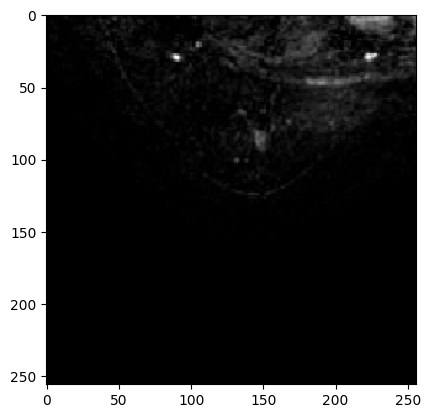

In [30]:
elem = datasets[x_test[3]]["patches_sub_test_ds"][1]

ima = np.squeeze(elem[0]['image'])
plt.imshow(ima, cmap='gray')
plt.show()

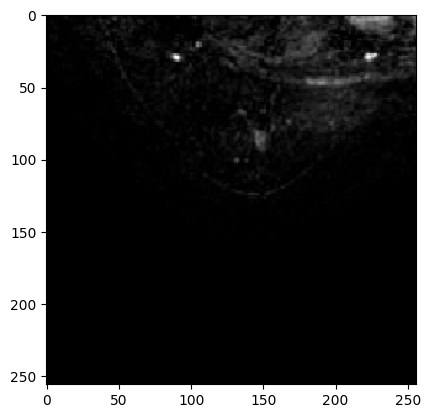

In [31]:
elem = datasets[x_test[3]]["patches_sub_test_ds"][1]

ima = np.squeeze(elem[0]['image'])
plt.imshow(ima, cmap='gray')
plt.show()

# PATIENT AWARE TEST FUNCTIONS

In [32]:
def fuse_segmentations(model1_prob, model2_prob, prob_threshold=0.5, boost_factor=1.5, penalty_factor=0.5, kernel_size=3):

    
    model1_prob = np.squeeze(model1_prob)
    model2_prob = np.squeeze(model2_prob)
    # Step 1: Check where both models agree above the probability threshold
    agreement = np.logical_and(model1_prob > prob_threshold, model2_prob > prob_threshold)# Step 2: Create a kernel for dilation
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Step 3: Dilate the agreement area to enlarge it
    enlarged_agreement = cv2.dilate(agreement.astype(np.uint8), kernel)
    
    # Step 4: Sum the probabilities of both models
    prob_sum = model1_prob + model2_prob
    
    # Step 5: Boost the probability sum where there is agreement
    prob_sum[enlarged_agreement > 0] *= boost_factor
    
    # Step 6: Identify disagreement (where there is no enlarged agreement)
    disagreement = enlarged_agreement == 0
    
    # Step 7: Apply penalty factor where there is disagreement
    prob_sum[disagreement] *= penalty_factor
    
    # Step 8: Normalize the probability sum to get the fused probability, ensuring it's within [0, 1]
    fused_prob = np.clip(prob_sum / 2.0, 0, 1)
    
    return fused_prob




In [33]:
def test_patient_aware_no_patches(model_path, patient_ids, datasets, dataset_key, filter=False, arch_name=None, subtracted=True):

    if arch_name:
        model = BreastModel2.load_from_checkpoint(model_path, strict=False, arch=arch_name)

    else:

        model = BreastModel2.load_from_checkpoint(model_path, strict=False)

    model_class_mean_iou = []
    model_class_mean_dice = []
    model_detection_iou = []
    
    model_iou_mass_volume = []
    model_iou_mass_volume_no_empty = []
    
    model_dice_mass_volume = []
    model_dice_mass_volume_no_empty = []

    model_accuracy = []
    model_precision = []
    model_recall = []

    loadimage = monai.transforms.LoadImage(ensure_channel_first=True, reader=monai.data.PILReader(converter=lambda image: image.convert("L")))
        
    im_path_key  = 'subtracted_filename_or_obj' if subtracted else 'filename_or_obj'
    
    for patient_id in patient_ids:
        
         predicted_label_slices = []
         gt_label_slices=[]
         image_slices=[]
    
         TP = []
         FP = []
         FN = []
         TN = []

         detection_rates =  []
    
         print(patient_id)
         dataset = datasets[patient_id][dataset_key]
        
         for idx, e in tqdm(enumerate(dataset), total = len(dataset)):
            original_image = loadimage(e['image_meta_dict'][im_path_key])
            original_image = monai.transforms.Rotate90()(original_image)
  
            pred_label = torch.zeros(original_image.shape, dtype=torch.uint8)
             

            gt_label = loadimage(e['label_meta_dict'][ im_path_key])
            gt_label = monai.transforms.Rotate90()(gt_label)
            gt_label = gt_label/255.

            if True:#e['keep_sample']:
                image = torch.unsqueeze(e['image'], 0)
                    
                with torch.no_grad():
                    model = model.to("cuda")
                    model.eval()

                    masks = model(image.to("cuda"))
                    if isinstance(masks, List) or isinstance(masks, Tuple):
                        masks = masks[0]
                    masks = masks.sigmoid()
                    
                pred_label = masks[0]
                pred_label = (pred_label > 0.4).int()
                pred_label = reverse_transformations(dataset[idx], pred_label, mode='whole')
                
                pred_label = monai.transforms.Resize(spatial_size=(original_image.shape[1], original_image.shape[2]), mode='neares-exact')(pred_label)
            else:
                pred_label = torch.zeros(original_image.shape, dtype=torch.uint8)

            if not filter:
                tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(np.expand_dims(pred_label,0).astype(int)), torch.tensor(np.expand_dims(gt_label,0).astype(int)), mode = "binary")
                TP.append(tp)
                FP.append(fp)
                FN.append(fn)
                TN.append(tn)
                
            """plt.figure(figsize=(15, 10))
    
            plt.subplot(2, 2, 1)
            plt.imshow(image.squeeze(),  cmap='gray')  # convert CHW -> HWC
            plt.title("Image")
            plt.axis("off")
        
            plt.subplot(2, 2, 2)
            plt.imshow(original_image.squeeze(), cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Whole")
            plt.axis("off")
        
            plt.subplot(2, 2, 3)
            plt.imshow(label.squeeze(), cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Label")
            plt.axis("off")
    
            plt.subplot(2, 2, 4)
            plt.imshow(gt_label.squeeze(), cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("GT")
            plt.axis("off")
        
            plt.show()
    
            plt.imshow(pred_label.squeeze() , cmap='gray')
            plt.show()"""
    
    
            predicted_label_slices.append(pred_label.squeeze())
            gt_label_slices.append(gt_label.squeeze())
            image_slices.append(original_image.squeeze())

         predicted_label_volume = np.stack(predicted_label_slices, axis=-1)  # Stack along the first axis to create a 3D volume
                    
         gt_label_volume = np.stack(gt_label_slices, axis=-1)
         images_volume = np.stack(image_slices, axis=-1)
    
         if filter:
             predicted_label_volume = filter_masses(predicted_label_volume, min_slices=3, window_size=3) # H x W x N
             # H x W x N -> N x H x W -> N x 1 x H x W
             predicted_label_volume_for_stats = np.transpose(predicted_label_volume, (2, 0, 1))
             predicted_label_volume_for_stats = np.expand_dims(predicted_label_volume_for_stats, 1)  # N x 1 x H x W

             gt_label_volume_for_stats = np.transpose(gt_label_volume, (2, 0, 1))
             gt_label_volume_for_stats = np.expand_dims(gt_label_volume_for_stats, 1)  # N x 1 x H x W             

             
             tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(predicted_label_volume_for_stats.astype(int)), torch.tensor(gt_label_volume_for_stats.astype(int)), mode = "binary")
             TP =  [torch.tensor([[elem]]) for elem in tp.squeeze()]
             FP =  [torch.tensor([[elem]]) for elem in fp.squeeze()]
             FN =  [torch.tensor([[elem]]) for elem in fn.squeeze()]
             TN =  [torch.tensor([[elem]]) for elem in tn.squeeze()]

    
         detection_iou =  np.array(calculate_mass_detection_imagewise_volume(predicted_label_volume.astype(int), gt_label_volume)).mean()
         
         mean_iou = compute_mean_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True)
         mean_dice = compute_mean_dice_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True)

         iou_mass_volume = compute_iou_npy(gt_label_volume, predicted_label_volume, class_id=1, reduction='micro-imagewise')
         iou_mass_volume_no_empty = compute_iou_npy(gt_label_volume, predicted_label_volume, class_id=1, reduction='micro-imagewise', exclude_empty=True)
         dice_mass_volume = compute_dice_score_npy(gt_label_volume, predicted_label_volume,reduction='micro-imagewise', class_id=1)
         dice_mass_volume_no_empty = compute_dice_score_npy(gt_label_volume, predicted_label_volume, reduction='micro-imagewise',class_id=1, exclude_empty=True)

        
         accuracy = compute_accuracy_from_cumulator(TP, FP, FN, TN)
         precision = compute_mean_precision_from_cumulator(TP, FP, FN, TN)
         recall = compute_mean_recall_from_cumulator(TP, FP, FN, TN)
        
         print("CLASS MEAN IOU", mean_iou)
         print("CLASS MEAN DICE", mean_dice)
         print("DIOU", detection_iou)
         print("IOU MASS VOLUME", iou_mass_volume)
         print("IOU MASS VOLUME NO EMPTY", iou_mass_volume_no_empty)
         print("DICE MASS VOLUME ", dice_mass_volume)
         print("DICE MASS VOLUME NO EMPTY ", dice_mass_volume_no_empty)

         print("ACCURACY ", accuracy)
         print("PRECISION ", precision)
         print("RECALL", recall)
         
         print()
         model_class_mean_iou.append(mean_iou)
         model_class_mean_dice.append(mean_dice)
         model_detection_iou.append(detection_iou)
        
         model_iou_mass_volume.append(iou_mass_volume)
         model_iou_mass_volume_no_empty.append(iou_mass_volume_no_empty)
        
         model_dice_mass_volume.append(dice_mass_volume)
         model_dice_mass_volume_no_empty.append(dice_mass_volume_no_empty)

         model_accuracy.append(accuracy)
         model_precision.append(precision)
         model_recall.append(recall)

    model_class_mean_iou = np.array(model_class_mean_iou).mean()
    model_class_mean_dice = np.array(model_class_mean_dice).mean()
    model_detection_iou = np.array(model_detection_iou).mean()
    
    model_iou_mass_volume = np.array(model_iou_mass_volume).mean()
    model_iou_mass_volume_no_empty = np.array(model_iou_mass_volume_no_empty).mean()
    
    model_dice_mass_volume = np.array(model_dice_mass_volume).mean()
    model_dice_mass_volume_no_empty = np.array(model_dice_mass_volume_no_empty).mean()

    model_accuracy = np.array(model_accuracy).mean()
    model_precision = np.array(model_precision).mean()
    model_recall = np.array(model_recall).mean()

    print("MODEL CLASS MEAN IOU", model_class_mean_iou)
    print("MODEL CLASS MEAN DICE", model_class_mean_dice)
    print("MODEL DIOU", model_detection_iou)
        
    print("MODEL IOU MASS VOLUME", model_iou_mass_volume)
    print("MODEL IOU MASS VOLUME NO EMPTY", model_iou_mass_volume_no_empty)
    
    print("MODEL DICE MASS VOLUME ", model_dice_mass_volume)
    print("MODEL DICE MASS VOLUME NO EMPTY ", model_dice_mass_volume_no_empty)

    print("MODEL ACCURACY ", model_accuracy)
    print("MODEL PRECISION ", model_precision)
    print("MODEL RECALL", model_recall)

In [ ]:
def test_dataset_aware_no_patches(model_path, patient_ids, datasets, dataset_key, filter=False, get_scores_for_statistics=False,get_only_masses=False, arch_name=None, strict=False, subtracted=True):

    if arch_name:
        model = BreastModel2.load_from_checkpoint(model_path, strict=strict, arch=arch_name)

    else:

        model = BreastModel2.load_from_checkpoint(model_path, strict=strict)

    model_class_mean_iou = []
    model_class_mean_dice = []
    model_detection_iou = []
    
    model_iou_mass_volume = []
    model_iou_mass_volume_no_empty = []
    
    model_dice_mass_volume = []
    model_dice_mass_volume_no_empty = []

    model_accuracy = []
    model_precision = []
    model_recall = []

    TP = []
    FP = []
    FN = []
    TN = []
    detection_iou=[]

    im_path_key  = 'subtracted_filename_or_obj' if subtracted else 'filename_or_obj'
    loadimage = monai.transforms.LoadImage(ensure_channel_first=True, reader=monai.data.PILReader(converter=lambda image: image.convert("L")))
    
    
    for patient_id in patient_ids:

         predicted_label_slices = []
         gt_label_slices=[]
         image_slices=[]
        
         print(patient_id)
         dataset = datasets[patient_id][dataset_key]
        
         for idx, e in tqdm(enumerate(dataset), total = len(dataset)):
            original_image = loadimage(e['image_meta_dict'][im_path_key])
            original_image = monai.transforms.Rotate90()(original_image)
  
            pred_label = torch.zeros(original_image.shape, dtype=torch.uint8)
             

            gt_label = loadimage(e['label_meta_dict'][ im_path_key])
            gt_label = monai.transforms.Rotate90()(gt_label)
            gt_label = gt_label/255.

            if True:#e['keep_sample']:
                image = torch.unsqueeze(e['image'], 0)
                    
                with torch.no_grad():
                    model = model.to("cuda")
                    model.eval()
                    
                    masks = model(image.to("cuda"))
                    if isinstance(masks, List) or isinstance(masks, Tuple):
                        masks = masks[0]
                    
                    masks = masks.sigmoid()
                    
                pred_label = masks[0]
                pred_label = (pred_label > 0.4).int()
                pred_label = reverse_transformations(dataset[idx], pred_label, mode='whole')
                
                pred_label = monai.transforms.Resize(spatial_size=(original_image.shape[1], original_image.shape[2]), mode='nearest-exact')(pred_label)

            if not filter:
                tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(np.expand_dims(pred_label,0).astype(int)), torch.tensor(np.expand_dims(gt_label,0).astype(int)), mode = "binary")
                TP.append(tp)
                FP.append(fp)
                FN.append(fn)
                TN.append(tn)
            
            """plt.figure(figsize=(15, 10))
    
            plt.subplot(2, 2, 1)
            plt.imshow(original_image.squeeze(),  cmap='gray')  # convert CHW -> HWC
            plt.title("Image")
            plt.axis("off")
        
            plt.subplot(2, 2, 2)
            plt.imshow(label_whole, cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Whole")
            plt.axis("off")
        
            plt.subplot(2, 2, 3)
            plt.imshow(label_patches, cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Patch")
            plt.axis("off")
    
            plt.subplot(2, 2, 4)
            plt.imshow(gt_label, cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("GT")
            plt.axis("off")
        
            plt.show()
    
            plt.imshow(fusion , cmap='gray')
            plt.show()"""
    
    
            predicted_label_slices.append(pred_label.squeeze())
            gt_label_slices.append(gt_label.squeeze())
            image_slices.append(original_image.squeeze())

         predicted_label_volume = np.stack(predicted_label_slices, axis=-1)  # Stack along the first axis to create a 3D volume
                    
         gt_label_volume = np.stack(gt_label_slices, axis=-1)
         images_volume = np.stack(image_slices, axis=-1)
    
         if filter:
             predicted_label_volume = filter_masses(predicted_label_volume, min_slices=3, window_size=3) # H x W x N
             # H x W x N -> N x H x W -> N x 1 x H x W
             predicted_label_volume_for_stats = np.transpose(predicted_label_volume, (2, 0, 1))
             predicted_label_volume_for_stats = np.expand_dims(predicted_label_volume_for_stats, 1)  # N x 1 x H x W

             gt_label_volume_for_stats = np.transpose(gt_label_volume, (2, 0, 1))
             gt_label_volume_for_stats = np.expand_dims(gt_label_volume_for_stats, 1)  # N x 1 x H x W             
            
             
             tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(predicted_label_volume_for_stats.astype(int)), torch.tensor(gt_label_volume_for_stats.astype(int)), mode = "binary")
             TP +=  [torch.tensor([[elem]]) for elem in tp.squeeze()]
             FP +=  [torch.tensor([[elem]]) for elem in fp.squeeze()]
             FN +=  [torch.tensor([[elem]]) for elem in fn.squeeze()]
             TN +=  [torch.tensor([[elem]]) for elem in tn.squeeze()]

         detection_iou+=calculate_mass_detection_imagewise_volume(predicted_label_volume.astype(int), gt_label_volume)

    model_detection_iou = np.array(detection_iou).mean()
    model_detection_iou_std = np.array(detection_iou).std()
    
    model_class_mean_iou, model_class_std_iou = compute_mean_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, return_std=True)
    model_class_mean_dice, model_class_std_dice = compute_mean_dice_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, return_std=True)

    model_iou_mass_volume , model_iou_mass_volume_std = compute_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=False, return_std=True)
    model_iou_mass_volume_no_empty, model_iou_mass_volume_no_empty_std =compute_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, return_std=True)
    model_iou_mass_volume_no_empty_optimistic, model_iou_mass_volume_no_empty_optimistic_std =compute_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, exclude_empty_only_gt=True, return_std=True)
    
    
    model_dice_mass_volume, model_dice_mass_volume_std = compute_dice_imagewise_from_cumulator(TP, FP, FN, TN,exclude_empty=False, return_std=True)
    model_dice_mass_volume_no_empty, model_dice_mass_volume_no_empty_std = compute_dice_imagewise_from_cumulator(TP, FP, FN, TN,exclude_empty=True, return_std=True)
    model_dice_mass_volume_no_empty_optimistic, model_dice_mass_volume_no_empty_optimistic_std = compute_dice_imagewise_from_cumulator(TP, FP, FN, TN,exclude_empty=True, exclude_empty_only_gt=True,return_std=True)
    
    model_mean_accuracy_no_empty, model_mean_accuracy_no_empty_std = compute_accuracy_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
    model_mean_precision_no_empty,model_mean_precision_no_empty_std = compute_precision_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
    model_mean_recall_no_empty, model_mean_recall_no_empty_std = compute_recall_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
    model_mean_f1_no_empty, model_mean_f1_no_empty_std = compute_f1_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
        
    model_accuracy_excluding_cases, model_accuracy_excluding_cases_std = compute_accuracy_excluding_cases(TP, FP, FN, TN, return_std=True)
    model_precision_excluding_cases,model_precision_excluding_cases_std =compute_precision_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True)
    model_recall_excluding_cases,model_recall_excluding_cases_std  =compute_recall_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True)

    model_accuracy_no_empty, model_accuracy_no_empty_std = compute_accuracy_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=False, return_std=True)
    model_precision_no_empty,model_precision_no_empty_std =compute_precision_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True,exclude_only_zero_denominator=True)
    model_recall_no_empty,model_recall_no_empty_std  = compute_recall_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True,exclude_only_zero_denominator=True)

    model_f1_no_empty,model_f1_no_empty_std = compute_f1_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True,exclude_only_zero_denominator=True)
    
    
    print("MODEL CLASS MEAN IOU ", model_class_mean_iou)
    print("MODEL CLASS STD IOU ", model_class_std_iou)
    print()
    print("MODEL CLASS MEAN DICE ", model_class_mean_dice)
    print("MODEL CLASS STD DICE ", model_class_std_dice)
    print()
    print("MODEL DIOU", model_detection_iou)
    print("MODEL DIOU STD ", model_detection_iou_std) 
    print()
    print("MODEL IOU MASS VOLUME ", model_iou_mass_volume)
    print("MODEL IOU MASS VOLUME STD ", model_iou_mass_volume_std)
    print()
    print("MODEL IOU MASS VOLUME NO EMPTY ", model_iou_mass_volume_no_empty)
    print("MODEL IOU MASS VOLUME NO EMPTY STD ", model_iou_mass_volume_no_empty_std)
    print()
    print("MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC ", model_iou_mass_volume_no_empty_optimistic)
    print("MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD ", model_iou_mass_volume_no_empty_optimistic_std)
    
    print("MODEL DICE MASS VOLUME ", model_dice_mass_volume)
    print("MODEL DICE MASS VOLUME STD ", model_dice_mass_volume_std)
    print()
    print("MODEL DICE MASS VOLUME NO EMPTY ", model_dice_mass_volume_no_empty)
    print("MODEL DICE MASS VOLUME NO EMPTY STD ", model_dice_mass_volume_no_empty_std)
    print()
    print("MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC ", model_dice_mass_volume_no_empty_optimistic)
    print("MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD ", model_dice_mass_volume_no_empty_optimistic_std)
    print() 
    print("MODEL MEAN ACCURACY NO EMPTY", model_mean_accuracy_no_empty)
    print("MODEL MEAN ACCURACY NO EMPTY STD", model_mean_accuracy_no_empty_std)
    print()                                                                              
    print("MODEL MEAN PRECISION NO EMPTY", model_mean_precision_no_empty)
    print("MODEL MEAN PRECISION NO EMPTY STD", model_mean_precision_no_empty_std)
    print()
    print("MODEL MEAN RECALL NO EMPTY", model_mean_recall_no_empty)
    print("MODEL MEAN RECALL NO EMPTY STD", model_mean_recall_no_empty_std)
    print()
    print("MODEL MEAN F1 NO EMPTY", model_mean_f1_no_empty)
    print("MODEL MEAN F1 NO EMPTY STD", model_mean_f1_no_empty_std)
    print()
    print("MODEL ACCURACY EXCLUDING CASES ",  model_accuracy_excluding_cases)
    print("MODEL ACCURACY EXCLUDING CASES STD ",  model_accuracy_excluding_cases_std)
    print()
    print("MODEL PRECISION EXCLUDING CASES ",  model_precision_excluding_cases)
    print("MODEL PRECISION EXCLUDING CASES STD ",  model_precision_excluding_cases_std)
    print()
    print("MODEL RECALL EXCLUDING CASES ", model_recall_excluding_cases)
    print("MODEL RECALL EXCLUDING CASES STD ", model_recall_excluding_cases_std)
    print()
    print("MODEL ACCURACY NO EMPTY ",  model_accuracy_no_empty)
    print("MODEL ACCURACY NO EMPTY STD ",  model_accuracy_no_empty_std)
    print()
    print("MODEL PRECISION NO EMPTY",  model_precision_no_empty)
    print("MODEL PRECISION NO EMPTY STD ",  model_precision_no_empty_std)
    print()
    print("MODEL RECALL NO EMPTY ", model_recall_no_empty)
    print("MODEL RECALL NO EMPTY STD ", model_recall_no_empty_std)
    print()
    print("MODEL F1 NO EMPTY ", model_f1_no_empty)
    print("MODEL F1 NO EMPTY STD ", model_f1_no_empty_std)
    print()

    if get_scores_for_statistics:
            tp = torch.cat([tp for tp in TP])
            fp = torch.cat([fp for fp in FP])
            fn = torch.cat([fn for fn in FN])
            tn = torch.cat([tn for tn in TN])


            if get_only_masses:
                # Create a mask where tp + fn is not equal to 0
                mask = (tp + fn) != 0
                
                # Apply this mask to each tensor to filter out the desired values
                tp = tp[mask]
                fp = fp[mask]
                fn = fn[mask]
                tn = tn[mask]

            miou_scores = compute_mean_iou_imagewise_from_cumulator(tp, fp, fn, tn, exclude_empty=False, return_std=False,reduce_mean=False)
            mdice_scores = compute_mean_dice_imagewise_from_cumulator(tp, fp, fn, tn, exclude_empty=False, return_std=False,reduce_mean=False)
            mf1_scores = compute_f1_from_cumulator(tp, fp, fn, tn, exclude_empty=False, is_mean=True, return_std=False,reduce_mean=False)


            scores_dict = {
                 'miou': miou_scores.squeeze().tolist(),
                 'mdice': mdice_scores.squeeze().tolist(),
                 "mf1": mf1_scores.squeeze().tolist(),
            }
            return scores_dict


In [35]:
def test_patient_aware_patches(model_path, patient_ids, datasets, dataset_key, arch_name=False, strict=False, subtracted=True):

    if arch_name:
        model = BreastModel2.load_from_checkpoint(model_path, strict=strict, arch=arch_name)

    else:

        model = BreastModel2.load_from_checkpoint(model_path, strict=strict)

    model_class_mean_iou = []
    model_class_mean_dice = []
    model_detection_iou = []
    
    model_iou_mass_volume = []
    model_iou_mass_volume_no_empty = []
    
    model_dice_mass_volume = []
    model_dice_mass_volume_no_empty = []
    
    model_precision = []
    model_recall = []
    model_accuracy = []

    
            
    im_path_key  = 'subtracted_filename_or_obj' if subtracted else 'filename_or_obj'
    loadimage = monai.transforms.LoadImage(ensure_channel_first=True, reader=monai.data.PILReader(converter=lambda image: image.convert("L")))
        
    
    for patient_id in patient_ids:
        
         predicted_label_slices = []
         gt_label_slices=[]
         image_slices=[]
    
         TP = []
         FP = []
         FN = []
         TN = []

         detection_rates =  []
    
         print(patient_id)
         dataset = datasets[patient_id][dataset_key]
        
         for idx, e in tqdm(enumerate(dataset), total = len(dataset)):
            original_image = loadimage(e[0]['image_meta_dict'][im_path_key])
            original_image = monai.transforms.Rotate90()(original_image)
  
            pred_label = torch.zeros(original_image.shape, dtype=torch.uint8)

            gt_label = loadimage(e[0]['label_meta_dict'][im_path_key])
            gt_label = monai.transforms.Rotate90()(gt_label)
            gt_label = gt_label/255.

            merged_label = torch.zeros(original_image.shape)


            for elem in e:
                if True:#elem['keep_sample']:
                    image = torch.unsqueeze(elem['image'], 0)
                    with torch.no_grad():
                        model = model.to("cuda")
                        model.eval()
                        if arch_name:
                            logits = model(image.to("cuda"))
                        else:
                            logits = model(image.to("cuda"))[0]
    
                    pr_mask = logits.sigmoid()
                    pr_mask = pr_mask[0]
                    #pr_mask_to_viz = (pr_mask.cpu().numpy() > 0.4).astype(int)
    
                    if pr_mask.sum()>0:
                        #label = pr_mask
                        pr_mask = (pr_mask > 0.4).int()

                        label = reverse_transformations(elem, pr_mask, mode='patches')
                        merged_label += label
                    

                pred_label = merged_label
                pred_label = monai.transforms.Resize(spatial_size=(original_image.shape[1], original_image.shape[2]), mode='nearest-exact')(pred_label)

            tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(np.expand_dims(pred_label,0).astype(int)), torch.tensor(np.expand_dims(gt_label,0).astype(int)), mode = "binary")
            TP.append(tp)
            FP.append(fp)
            FN.append(fn)
            TN.append(tn)
             
            """plt.figure(figsize=(15, 10))
    
            plt.subplot(2, 2, 1)
            plt.imshow(original_image.squeeze(),  cmap='gray')  # convert CHW -> HWC
            plt.title("Image")
            plt.axis("off")
        
            plt.subplot(2, 2, 2)
            plt.imshow(label_whole, cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Whole")
            plt.axis("off")
        
            plt.subplot(2, 2, 3)
            plt.imshow(label_patches, cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Patch")
            plt.axis("off")
    
            plt.subplot(2, 2, 4)
            plt.imshow(gt_label, cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("GT")
            plt.axis("off")
        
            plt.show()
    
            plt.imshow(fusion , cmap='gray')
        
            plt.show()"""
    
    
            predicted_label_slices.append(pred_label.squeeze())
            gt_label_slices.append(gt_label.squeeze())
            image_slices.append(original_image.squeeze())

         predicted_label_volume = np.stack(predicted_label_slices, axis=-1)  # Stack along the first axis to create a 3D volume
       
         gt_label_volume = np.stack(gt_label_slices, axis=-1)
         images_volume = np.stack(image_slices, axis=-1)
    
         detection_iou =  np.array(calculate_mass_detection_imagewise_volume(predicted_label_volume.astype(int), gt_label_volume)).mean()
         
         mean_iou = compute_mean_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True)
         mean_dice = compute_mean_dice_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True)

         iou_mass_volume = compute_iou_npy(gt_label_volume, predicted_label_volume, class_id=1, reduction='micro-imagewise')
         iou_mass_volume_no_empty = compute_iou_npy(gt_label_volume, predicted_label_volume, class_id=1, reduction='micro-imagewise', exclude_empty=True)
         dice_mass_volume = compute_dice_score_npy(gt_label_volume, predicted_label_volume,reduction='micro-imagewise', class_id=1)
         dice_mass_volume_no_empty = compute_dice_score_npy(gt_label_volume, predicted_label_volume, reduction='micro-imagewise',class_id=1, exclude_empty=True)

        
         accuracy = compute_accuracy_from_cumulator(TP, FP, FN, TN)
         precision = compute_mean_precision_from_cumulator(TP, FP, FN, TN)
         recall = compute_mean_recall_from_cumulator(TP, FP, FN, TN)
        
         print("CLASS MEAN IOU", mean_iou)
         print("CLASS MEAN DICE", mean_dice)
         print("DIOU", detection_iou)
         print("IOU MASS VOLUME", iou_mass_volume)
         print("IOU MASS VOLUME NO EMPTY", iou_mass_volume_no_empty)
         print("DICE MASS VOLUME ", dice_mass_volume)
         print("DICE MASS VOLUME NO EMPTY ", dice_mass_volume_no_empty)

         print("ACCURACY ", accuracy)
         print("PRECISION ", precision)
         print("RECALL", recall)
         
         print()
         model_class_mean_iou.append(mean_iou)
         model_class_mean_dice.append(mean_dice)
         model_detection_iou.append(detection_iou)
        
         model_iou_mass_volume.append(iou_mass_volume)
         model_iou_mass_volume_no_empty.append(iou_mass_volume_no_empty)
        
         model_dice_mass_volume.append(dice_mass_volume)
         model_dice_mass_volume_no_empty.append(dice_mass_volume_no_empty)

         model_accuracy.append(accuracy)
         model_precision.append(precision)
         model_recall.append(recall)

    model_class_mean_iou = np.array(model_class_mean_iou).mean()
    model_class_mean_dice = np.array(model_class_mean_dice).mean()
    model_detection_iou = np.array(model_detection_iou).mean()
    
    model_iou_mass_volume = np.array(model_iou_mass_volume).mean()
    model_iou_mass_volume_no_empty = np.array(model_iou_mass_volume_no_empty).mean()
    
    model_dice_mass_volume = np.array(model_dice_mass_volume).mean()
    model_dice_mass_volume_no_empty = np.array(model_dice_mass_volume_no_empty).mean()

    model_accuracy = np.array(model_accuracy).mean()
    model_precision = np.array(model_precision).mean()
    model_recall = np.array(model_recall).mean()

    print("MODEL CLASS MEAN IOU", model_class_mean_iou)
    print("MODEL CLASS MEAN DICE", model_class_mean_dice)
    print("MODEL DIOU", model_detection_iou)
        
    print("MODEL IOU MASS VOLUME", model_iou_mass_volume)
    print("MODEL IOU MASS VOLUME NO EMPTY", model_iou_mass_volume_no_empty)
    
    print("MODEL DICE MASS VOLUME ", model_dice_mass_volume)
    print("MODEL DICE MASS VOLUME NO EMPTY ", model_dice_mass_volume_no_empty)

    print("MODEL ACCURACY ", model_accuracy)
    print("MODEL PRECISION ", model_precision)
    print("MODEL RECALL", model_recall)

In [36]:
# Function to sum every two consecutive elements in a tensor
def sum_every_two(tensor):
    # Ensure the tensor has an even number of elements
    if tensor.numel() % 2 != 0:
        raise ValueError("The number of elements in the tensor must be even")
    # Reshape to have pairs of elements in the last dimension, then sum along that dimension
    return tensor.view(-1, 2).sum(dim=1)

In [37]:
def test_dataset_aware_patches(model_path, patient_ids, datasets, dataset_key, get_scores_for_statistics=False,get_only_masses=False, filter = False, arch_name=False, strict=False, subtracted=True):

    if arch_name:
        model = BreastModel2.load_from_checkpoint(model_path, strict=strict, arch=arch_name)

    else:

        model = BreastModel.load_from_checkpoint(model_path, strict=strict)
    
    model_class_mean_iou = []
    model_class_mean_dice = []
    model_detection_iou = []
    
    model_iou_mass_volume = []
    model_iou_mass_volume_no_empty = []
    
    model_dice_mass_volume = []
    model_dice_mass_volume_no_empty = []

    model_accuracy = []
    model_precision = []
    model_recall = []


    
    TP = []
    FP = []
    FN = []
    TN = []

    
    detection_iou=[]

    im_path_key  = 'subtracted_filename_or_obj' if subtracted else 'filename_or_obj'
    loadimage = monai.transforms.LoadImage(ensure_channel_first=True, reader=monai.data.PILReader(converter=lambda image: image.convert("L")))

    for patient_id in patient_ids:
         predicted_label_slices = []
         gt_label_slices=[]
         image_slices=[]
         print(patient_id)
         dataset = datasets[patient_id][dataset_key]
        
         for idx, e in tqdm(enumerate(dataset), total = len(dataset)):
            original_image = loadimage(e[0]['image_meta_dict'][im_path_key])
            original_image = monai.transforms.Rotate90()(original_image)
  
            pred_label = torch.zeros(original_image.shape, dtype=torch.uint8)

            gt_label = loadimage(e[0]['label_meta_dict'][im_path_key])
            gt_label = monai.transforms.Rotate90()(gt_label)
            gt_label = gt_label/255.

            merged_label = torch.zeros(original_image.shape)
            merged_label_for_fusion = torch.zeros(original_image.shape)

            for elem in e:
                if True: #elem['keep_sample']:
                    image = torch.unsqueeze(elem['image'], 0)
                    with torch.no_grad():
                        model = model.to("cuda")
                        model.eval()
                        logits = model(image.to("cuda"))
                        if isinstance(logits, List) or isinstance(logits, Tuple):
                            logits = logits[0]
    
                    pr_mask = logits.sigmoid()
                    pr_mask = pr_mask[0]
                    #pr_mask_to_viz = (pr_mask.cpu().numpy() > 0.4).astype(int)
    
                    if pr_mask.sum()>0:
                        #label = pr_mask
                        pr_mask = (pr_mask > 0.4).int()
                        label = reverse_transformations(elem, pr_mask, mode='patches')
                        merged_label += label
                    

                pred_label = merged_label
                pred_label = monai.transforms.Resize(spatial_size=(original_image.shape[1], original_image.shape[2]), mode='nearest-exact')(pred_label)

            tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(np.expand_dims(pred_label,0).astype(int)), torch.tensor(np.expand_dims(gt_label,0).astype(int)), mode = "binary")
            TP.append(tp)
            FP.append(fp)
            FN.append(fn)
            TN.append(tn)
             
            """plt.figure(figsize=(15, 10))
    
            plt.subplot(2, 2, 1)
            plt.imshow(original_image.squeeze(),  cmap='gray')  # convert CHW -> HWC
            plt.title("Image")
            plt.axis("off")
        
            plt.subplot(2, 2, 2)
            plt.imshow(label_whole, cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Whole")
            plt.axis("off")
        
            plt.subplot(2, 2, 3)
            plt.imshow(label_patches, cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Patch")
            plt.axis("off")
    
            plt.subplot(2, 2, 4)
            plt.imshow(gt_label, cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("GT")
            plt.axis("off")
        
            plt.show()
    
            plt.imshow(fusion , cmap='gray')
        
            plt.show()"""
    
    
            predicted_label_slices.append(pred_label.squeeze())
            gt_label_slices.append(gt_label.squeeze())
            image_slices.append(original_image.squeeze())

         predicted_label_volume = np.stack(predicted_label_slices, axis=-1)  # Stack along the first axis to create a 3D volume
                    
         gt_label_volume = np.stack(gt_label_slices, axis=-1)
         images_volume = np.stack(image_slices, axis=-1)
    
         if filter:
             predicted_label_volume = filter_masses(predicted_label_volume, min_slices=3, window_size=3) # H x W x N
             # H x W x N -> N x H x W -> N x 1 x H x W
             predicted_label_volume_for_stats = np.transpose(predicted_label_volume, (2, 0, 1))
             predicted_label_volume_for_stats = np.expand_dims(predicted_label_volume_for_stats, 1)  # N x 1 x H x W

             gt_label_volume_for_stats = np.transpose(gt_label_volume, (2, 0, 1))
             gt_label_volume_for_stats = np.expand_dims(gt_label_volume_for_stats, 1)  # N x 1 x H x W             
            
             
             tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(predicted_label_volume_for_stats.astype(int)), torch.tensor(gt_label_volume_for_stats.astype(int)), mode = "binary")
             TP +=  [torch.tensor([[elem]]) for elem in tp.squeeze()]
             FP +=  [torch.tensor([[elem]]) for elem in fp.squeeze()]
             FN +=  [torch.tensor([[elem]]) for elem in fn.squeeze()]
             TN +=  [torch.tensor([[elem]]) for elem in tn.squeeze()]

    
         detection_iou+=calculate_mass_detection_imagewise_volume(predicted_label_volume.astype(int), gt_label_volume)

    model_detection_iou = np.array(detection_iou).mean()
    model_detection_iou_std = np.array(detection_iou).std()
    
    model_class_mean_iou, model_class_std_iou = compute_mean_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, return_std=True)
    model_class_mean_dice, model_class_std_dice = compute_mean_dice_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, return_std=True)

    model_iou_mass_volume , model_iou_mass_volume_std = compute_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=False, return_std=True)
    model_iou_mass_volume_no_empty, model_iou_mass_volume_no_empty_std =compute_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, return_std=True)
    model_iou_mass_volume_no_empty_optimistic, model_iou_mass_volume_no_empty_optimistic_std =compute_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, exclude_empty_only_gt=True, return_std=True)
    
    
    model_dice_mass_volume, model_dice_mass_volume_std = compute_dice_imagewise_from_cumulator(TP, FP, FN, TN,exclude_empty=False, return_std=True)
    model_dice_mass_volume_no_empty, model_dice_mass_volume_no_empty_std = compute_dice_imagewise_from_cumulator(TP, FP, FN, TN,exclude_empty=True, return_std=True)
    model_dice_mass_volume_no_empty_optimistic, model_dice_mass_volume_no_empty_optimistic_std = compute_dice_imagewise_from_cumulator(TP, FP, FN, TN,exclude_empty=True, exclude_empty_only_gt=True,return_std=True)
    
    model_mean_accuracy_no_empty, model_mean_accuracy_no_empty_std = compute_accuracy_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
    model_mean_precision_no_empty,model_mean_precision_no_empty_std = compute_precision_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
    model_mean_recall_no_empty, model_mean_recall_no_empty_std = compute_recall_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
    model_mean_f1_no_empty, model_mean_f1_no_empty_std = compute_f1_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
        
    model_accuracy_excluding_cases, model_accuracy_excluding_cases_std = compute_accuracy_excluding_cases(TP, FP, FN, TN, return_std=True)
    model_precision_excluding_cases,model_precision_excluding_cases_std =compute_precision_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True)
    model_recall_excluding_cases,model_recall_excluding_cases_std  =compute_recall_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True)

    model_accuracy_no_empty, model_accuracy_no_empty_std = compute_accuracy_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=False, return_std=True)
    model_precision_no_empty,model_precision_no_empty_std =compute_precision_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True,exclude_only_zero_denominator=True)
    model_recall_no_empty,model_recall_no_empty_std  = compute_recall_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True,exclude_only_zero_denominator=True)

    model_f1_no_empty,model_f1_no_empty_std = compute_f1_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True,exclude_only_zero_denominator=True)
    
    
    print("MODEL CLASS MEAN IOU ", model_class_mean_iou)
    print("MODEL CLASS STD IOU ", model_class_std_iou)
    print()
    print("MODEL CLASS MEAN DICE ", model_class_mean_dice)
    print("MODEL CLASS STD DICE ", model_class_std_dice)
    print()
    print("MODEL DIOU", model_detection_iou)
    print("MODEL DIOU STD ", model_detection_iou_std) 
    print()
    print("MODEL IOU MASS VOLUME ", model_iou_mass_volume)
    print("MODEL IOU MASS VOLUME STD ", model_iou_mass_volume_std)
    print()
    print("MODEL IOU MASS VOLUME NO EMPTY ", model_iou_mass_volume_no_empty)
    print("MODEL IOU MASS VOLUME NO EMPTY STD ", model_iou_mass_volume_no_empty_std)
    print()
    print("MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC ", model_iou_mass_volume_no_empty_optimistic)
    print("MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD ", model_iou_mass_volume_no_empty_optimistic_std)
    
    print("MODEL DICE MASS VOLUME ", model_dice_mass_volume)
    print("MODEL DICE MASS VOLUME STD ", model_dice_mass_volume_std)
    print()
    print("MODEL DICE MASS VOLUME NO EMPTY ", model_dice_mass_volume_no_empty)
    print("MODEL DICE MASS VOLUME NO EMPTY STD ", model_dice_mass_volume_no_empty_std)
    print()
    print("MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC ", model_dice_mass_volume_no_empty_optimistic)
    print("MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD ", model_dice_mass_volume_no_empty_optimistic_std)
    print() 
    print("MODEL MEAN ACCURACY NO EMPTY", model_mean_accuracy_no_empty)
    print("MODEL MEAN ACCURACY NO EMPTY STD", model_mean_accuracy_no_empty_std)
    print()                                                                              
    print("MODEL MEAN PRECISION NO EMPTY", model_mean_precision_no_empty)
    print("MODEL MEAN PRECISION NO EMPTY STD", model_mean_precision_no_empty_std)
    print()
    print("MODEL MEAN RECALL NO EMPTY", model_mean_recall_no_empty)
    print("MODEL MEAN RECALL NO EMPTY STD", model_mean_recall_no_empty_std)
    print()
    print("MODEL MEAN F1 NO EMPTY", model_mean_f1_no_empty)
    print("MODEL MEAN F1 NO EMPTY STD", model_mean_f1_no_empty_std)
    print()
    print("MODEL ACCURACY EXCLUDING CASES ",  model_accuracy_excluding_cases)
    print("MODEL ACCURACY EXCLUDING CASES STD ",  model_accuracy_excluding_cases_std)
    print()
    print("MODEL PRECISION EXCLUDING CASES ",  model_precision_excluding_cases)
    print("MODEL PRECISION EXCLUDING CASES STD ",  model_precision_excluding_cases_std)
    print()
    print("MODEL RECALL EXCLUDING CASES ", model_recall_excluding_cases)
    print("MODEL RECALL EXCLUDING CASES STD ", model_recall_excluding_cases_std)
    print()
    print("MODEL ACCURACY NO EMPTY ",  model_accuracy_no_empty)
    print("MODEL ACCURACY NO EMPTY STD ",  model_accuracy_no_empty_std)
    print()
    print("MODEL PRECISION NO EMPTY",  model_precision_no_empty)
    print("MODEL PRECISION NO EMPTY STD ",  model_precision_no_empty_std)
    print()
    print("MODEL RECALL NO EMPTY ", model_recall_no_empty)
    print("MODEL RECALL NO EMPTY STD ", model_recall_no_empty_std)
    print()
    print("MODEL F1 NO EMPTY ", model_f1_no_empty)
    print("MODEL F1 NO EMPTY STD ", model_f1_no_empty_std)
    print()

    if get_scores_for_statistics:

            tp = torch.cat([tp for tp in TP])
            fp = torch.cat([fp for fp in FP])
            fn = torch.cat([fn for fn in FN])
            tn = torch.cat([tn for tn in TN])

            if get_only_masses:
                # Create a mask where tp + fn is not equal to 0
                mask = (tp + fn) != 0
                
                # Apply this mask to each tensor to filter out the desired values
                tp = tp[mask]
                fp = fp[mask]
                fn = fn[mask]
                tn = tn[mask]

            miou_scores = compute_mean_iou_imagewise_from_cumulator(tp, fp, fn, tn, exclude_empty=False, return_std=False, reduce_mean=False)
            mdice_scores = compute_mean_dice_imagewise_from_cumulator(tp, fp, fn, tn, exclude_empty=False, return_std=False, reduce_mean=False)
            tiou_scores = compute_iou_from_metrics(tp, fp, tn, fn, reduction='none',exclude_empty=False)
            tdice_scores = compute_dice_from_metrics(tp, fp, tn, fn, reduction='none',exclude_empty=False)
            precision_scores = smp.metrics.precision(tp, fp, fn, tn, reduction='none')
            recall_scores = smp.metrics.recall(tp, fp, fn, tn, reduction='none')


            scores_dict = {
                 'miou': miou_scores.squeeze().tolist(),
                 'mdice': mdice_scores.squeeze().tolist(),
                 'tiou': tiou_scores.squeeze().tolist(),
                 'tdice': tdice_scores.squeeze().tolist(),
                 'dr':detection_iou,
                 'precision': precision_scores.squeeze().tolist(),
                 'recall': recall_scores.squeeze().tolist(),
            }
            return scores_dict

In [ ]:
def test_patient_aware_fusion(model_path, patient_ids, datasets, whole_dataset_key, patches_dataset_key, use_simple_fusion=False, use_decoder_attention=True, strict=False, filter=False, get_scores_for_statistics=False,get_only_masses=False, subtracted=True, base_channels=64):


    model = BreastModel.load_from_checkpoint(model_path, strict=strict, use_simple_fusion=use_simple_fusion, use_decoder_attention=use_decoder_attention, base_channels=base_channels)
    model_class_mean_iou = []
    model_class_mean_dice = []
    model_detection_iou = []
    
    model_iou_mass_volume = []
    model_iou_mass_volume_no_empty = []
    
    model_dice_mass_volume = []
    model_dice_mass_volume_no_empty = []
    
    model_precision = []
    model_recall = []
    model_accuracy = []
    
    loadimage = monai.transforms.LoadImage(ensure_channel_first=True, reader=monai.data.PILReader(converter=lambda image: image.convert("L")))

    im_path_key  = 'subtracted_filename_or_obj' if subtracted else 'filename_or_obj'
    
    for patient_id in patient_ids:

         predicted_label_slices = []
         gt_label_slices=[]
         image_slices=[]
    
         TP = []
         FP = []
         FN =[]
         TN = []
         print(patient_id)
         patches_ds = datasets[patient_id][patches_dataset_key]
         whole_image_ds = datasets[patient_id][whole_dataset_key]

         fusion_dataset = PairedDataset(whole_image_ds, patches_ds, augment=False)
        
         prev_had_mask=False

         for idx, e in tqdm(enumerate(fusion_dataset), total = len(patches_ds)):

             
            original_image = loadimage(e[0]['image_meta_dict'][im_path_key])
            original_image = monai.transforms.Rotate90()(original_image)
    
            pred_label = torch.zeros(original_image.shape, dtype=torch.uint8)
    
            gt_label = loadimage(e[0]['label_meta_dict'][im_path_key])
            gt_label = monai.transforms.Rotate90()(gt_label)
            gt_label = gt_label/255.

            if True: #fusion_dataset[idx][0]['keep_sample']:
    
                whole_image = torch.unsqueeze(fusion_dataset[idx][0]['image'], 0)
                patch_image2 = torch.unsqueeze(fusion_dataset[idx][1]['image'], 0)
                patch_image3 = torch.unsqueeze(fusion_dataset[idx][2]['image'], 0)
        
                with torch.no_grad():
                    masks = []
                    # pass to model
                    model = model.to("cuda")
                    model.eval()

                    """plt.imshow(whole_image.to("cpu").squeeze())
                    plt.show()
                    plt.imshow(patch_image2.to("cpu").squeeze())
                    plt.show()
                    plt.imshow(patch_image3.to("cpu").squeeze())
                    plt.show()"""
                    
                    masks = model(whole_image.to("cuda"),patch_image2.to("cuda"),patch_image3.to("cuda"))
                    masks = masks.sigmoid()
                    
                
                pred_label = masks[0]
                pred_label = (pred_label > 0.4).int()
                """plt.imshow(pred_label.to("cpu").squeeze())
                plt.show()"""
                pred_label = reverse_transformations(fusion_dataset[idx][0], pred_label, mode='whole')
                
                
                
            pred_label = monai.transforms.Resize(spatial_size=(original_image.shape[1], original_image.shape[2]), mode='nearest-exact')(pred_label)
             
            if not filter:
                tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(np.expand_dims(pred_label,0).astype(int)), torch.tensor(np.expand_dims(gt_label,0).astype(int)), mode = "binary")
                TP.append(tp)
                FP.append(fp)
                FN.append(fn)
                TN.append(tn)
             
            """plt.figure(figsize=(15, 10))
    
            plt.subplot(2, 2, 1)
            plt.imshow(original_image.squeeze(),  cmap='gray')  # convert CHW -> HWC
            plt.title("Image")
            plt.axis("off")
        
            plt.subplot(2, 2, 2)
            plt.imshow(gt_label.squeeze(), cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Whole")
            plt.axis("off")
        
            plt.subplot(2, 2, 3)
            plt.imshow(pred_label.squeeze() , cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Patch")
            plt.axis("off")

        
            plt.show()"""
    
    
    
            predicted_label_slices.append(pred_label.squeeze())
            gt_label_slices.append(gt_label.squeeze())
            image_slices.append(original_image.squeeze())

         predicted_label_volume = np.stack(predicted_label_slices, axis=-1)  # Stack along the first axis to create a 3D volume
                    
         gt_label_volume = np.stack(gt_label_slices, axis=-1)
         images_volume = np.stack(image_slices, axis=-1)
    
         if filter:
             predicted_label_volume = filter_masses(predicted_label_volume, min_slices=3, window_size=3) # H x W x N
             # H x W x N -> N x H x W -> N x 1 x H x W
             predicted_label_volume_for_stats = np.transpose(predicted_label_volume, (2, 0, 1))
             predicted_label_volume_for_stats = np.expand_dims(predicted_label_volume_for_stats, 1)  # N x 1 x H x W

             gt_label_volume_for_stats = np.transpose(gt_label_volume, (2, 0, 1))
             gt_label_volume_for_stats = np.expand_dims(gt_label_volume_for_stats, 1)  # N x 1 x H x W             

             
             tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(predicted_label_volume_for_stats.astype(int)), torch.tensor(gt_label_volume_for_stats.astype(int)), mode = "binary")
             TP =  [torch.tensor([[elem]]) for elem in tp.squeeze()]
             FP =  [torch.tensor([[elem]]) for elem in fp.squeeze()]
             FN =  [torch.tensor([[elem]]) for elem in fn.squeeze()]
             TN =  [torch.tensor([[elem]]) for elem in tn.squeeze()]

         detection_iou =  np.array(calculate_mass_detection_imagewise_volume(predicted_label_volume.astype(int), gt_label_volume)).mean()
         
         mean_iou = compute_mean_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True)
         mean_dice = compute_mean_dice_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True)

         iou_mass_volume = compute_iou_npy(gt_label_volume, predicted_label_volume, class_id=1, reduction='micro-imagewise')
         iou_mass_volume_no_empty = compute_iou_npy(gt_label_volume, predicted_label_volume, class_id=1, reduction='micro-imagewise', exclude_empty=True)
         dice_mass_volume = compute_dice_score_npy(gt_label_volume, predicted_label_volume,reduction='micro-imagewise', class_id=1)
         dice_mass_volume_no_empty = compute_dice_score_npy(gt_label_volume, predicted_label_volume, reduction='micro-imagewise',class_id=1, exclude_empty=True)

        
         accuracy = compute_accuracy_from_cumulator(TP, FP, FN, TN)
         precision = compute_mean_precision_from_cumulator(TP, FP, FN, TN)
         recall = compute_mean_recall_from_cumulator(TP, FP, FN, TN)
        
         print("CLASS MEAN IOU", mean_iou)
         print("CLASS MEAN DICE", mean_dice)
         print("DIOU", detection_iou)
         print("IOU MASS VOLUME", iou_mass_volume)
         print("IOU MASS VOLUME NO EMPTY", iou_mass_volume_no_empty)
         print("DICE MASS VOLUME ", dice_mass_volume)
         print("DICE MASS VOLUME NO EMPTY ", dice_mass_volume_no_empty)

         print("ACCURACY ", accuracy)
         print("PRECISION ", precision)
         print("RECALL", recall)
         
         print()
         model_class_mean_iou.append(mean_iou)
         model_class_mean_dice.append(mean_dice)
         model_detection_iou.append(detection_iou)
        
         model_iou_mass_volume.append(iou_mass_volume)
         model_iou_mass_volume_no_empty.append(iou_mass_volume_no_empty)
        
         model_dice_mass_volume.append(dice_mass_volume)
         model_dice_mass_volume_no_empty.append(dice_mass_volume_no_empty)

         model_accuracy.append(accuracy)
         model_precision.append(precision)
         model_recall.append(recall)

    model_class_mean_iou = np.array(model_class_mean_iou).mean()
    model_class_mean_dice = np.array(model_class_mean_dice).mean()
    model_detection_iou = np.array(model_detection_iou).mean()
    
    model_iou_mass_volume = np.array(model_iou_mass_volume).mean()
    model_iou_mass_volume_no_empty = np.array(model_iou_mass_volume_no_empty).mean()
    
    model_dice_mass_volume = np.array(model_dice_mass_volume).mean()
    model_dice_mass_volume_no_empty = np.array(model_dice_mass_volume_no_empty).mean()

    model_accuracy = np.array(model_accuracy).mean()
    model_precision = np.array(model_precision).mean()
    model_recall = np.array(model_recall).mean()

    print("MODEL CLASS MEAN IOU", model_class_mean_iou)
    print("MODEL CLASS MEAN DICE", model_class_mean_dice)
    print("MODEL DIOU", model_detection_iou)
        
    print("MODEL IOU MASS VOLUME", model_iou_mass_volume)
    print("MODEL IOU MASS VOLUME NO EMPTY", model_iou_mass_volume_no_empty)
    
    print("MODEL DICE MASS VOLUME ", model_dice_mass_volume)
    print("MODEL DICE MASS VOLUME NO EMPTY ", model_dice_mass_volume_no_empty)

    print("MODEL ACCURACY ", model_accuracy)
    print("MODEL PRECISION ", model_precision)
    print("MODEL RECALL", model_recall)

In [ ]:
def test_dataset_aware_fusion(model_path, patient_ids, datasets, whole_dataset_key, patches_dataset_key, use_simple_fusion=False, use_decoder_attention=True, strict=False, filter=False, subtracted=True, get_scores_for_statistics=False,get_only_masses=False, base_channels=64):

    print(base_channels)
    model = BreastModel.load_from_checkpoint(model_path, strict=strict, use_simple_fusion=use_simple_fusion, use_decoder_attention=use_decoder_attention, base_channels=base_channels)


    model_class_mean_iou = []
    model_class_mean_dice = []
    model_detection_iou = []
    
    model_iou_mass_volume = []
    model_iou_mass_volume_no_empty = []
    
    model_dice_mass_volume = []
    model_dice_mass_volume_no_empty = []

    model_accuracy = []
    model_precision = []
    model_recall = []
    
    TP = []
    FP = []
    FN = []
    TN = []


    detection_iou=[]

    loadimage = monai.transforms.LoadImage(ensure_channel_first=True, reader=monai.data.PILReader(converter=lambda image: image.convert("L")))

    im_path_key  = 'subtracted_filename_or_obj' if subtracted else 'filename_or_obj'
    

    for patient_id in patient_ids:
         predicted_label_slices = []
         gt_label_slices=[]
         image_slices=[]
         print(patient_id)
         patches_ds = datasets[patient_id][patches_dataset_key]
         whole_image_ds = datasets[patient_id][whole_dataset_key]

         fusion_dataset = PairedDataset(whole_image_ds, patches_ds, augment=False)
        
         prev_had_mask=False

         for idx, e in tqdm(enumerate(fusion_dataset), total = len(patches_ds)):
            original_image = loadimage(e[0]['image_meta_dict'][im_path_key])
            original_image = monai.transforms.Rotate90()(original_image)
    
            pred_label = torch.zeros(original_image.shape, dtype=torch.uint8)
    
            gt_label = loadimage(e[0]['label_meta_dict'][im_path_key])
            gt_label = monai.transforms.Rotate90()(gt_label)
            gt_label = gt_label/255.

            if True: #fusion_dataset[idx][0]['keep_sample']:
    
                whole_image = torch.unsqueeze(fusion_dataset[idx][0]['image'], 0)
                patch_image2 = torch.unsqueeze(fusion_dataset[idx][1]['image'], 0)
                patch_image3 = torch.unsqueeze(fusion_dataset[idx][2]['image'], 0)
                    
        
                with torch.no_grad():
                    masks = []
                    # pass to model
                    model = model.to("cuda")
                    model.eval()
                    
                    masks = model(whole_image.to("cuda"),patch_image2.to("cuda"),patch_image3.to("cuda"))
                    masks = masks.sigmoid()
                    
    
                pred_label = masks[0]
                pred_label = (pred_label > 0.4).int()
                pred_label = reverse_transformations(fusion_dataset[idx][0], pred_label, mode='whole')
                

                
            pred_label = monai.transforms.Resize(spatial_size=(original_image.shape[1], original_image.shape[2]), mode='nearest-exact')(pred_label)
             
            if not filter:
                tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(np.expand_dims(pred_label,0).astype(int)), torch.tensor(np.expand_dims(gt_label,0).astype(int)), mode = "binary")
                TP.append(tp)
                FP.append(fp)
                FN.append(fn)
                TN.append(tn)
             
            """plt.figure(figsize=(15, 10))
    
            plt.subplot(2, 2, 1)
            plt.imshow(original_image.squeeze(),  cmap='gray')  # convert CHW -> HWC
            plt.title("Image")
            plt.axis("off")
        
            plt.subplot(2, 2, 2)
            plt.imshow(label_whole, cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Whole")
            plt.axis("off")
        
            plt.subplot(2, 2, 3)
            plt.imshow(label_patches, cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Patch")
            plt.axis("off")
    
            plt.subplot(2, 2, 4)
            plt.imshow(gt_label, cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("GT")
            plt.axis("off")
        
            plt.show()
    
            plt.imshow(fusion , cmap='gray')
            plt.show()"""
    
    
            predicted_label_slices.append(pred_label.squeeze())
            gt_label_slices.append(gt_label.squeeze())
            image_slices.append(original_image.squeeze())

         predicted_label_volume = np.stack(predicted_label_slices, axis=-1)  # Stack along the first axis to create a 3D volume
                    
         gt_label_volume = np.stack(gt_label_slices, axis=-1)
         images_volume = np.stack(image_slices, axis=-1)
    
         if filter:
             predicted_label_volume = filter_masses(predicted_label_volume, min_slices=3, window_size=3) # H x W x N
             # H x W x N -> N x H x W -> N x 1 x H x W
             predicted_label_volume_for_stats = np.transpose(predicted_label_volume, (2, 0, 1))
             predicted_label_volume_for_stats = np.expand_dims(predicted_label_volume_for_stats, 1)  # N x 1 x H x W

             gt_label_volume_for_stats = np.transpose(gt_label_volume, (2, 0, 1))
             gt_label_volume_for_stats = np.expand_dims(gt_label_volume_for_stats, 1)  # N x 1 x H x W             
            
             
             tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(predicted_label_volume_for_stats.astype(int)), torch.tensor(gt_label_volume_for_stats.astype(int)), mode = "binary")
             TP +=  [torch.tensor([[elem]]) for elem in tp.squeeze()]
             FP +=  [torch.tensor([[elem]]) for elem in fp.squeeze()]
             FN +=  [torch.tensor([[elem]]) for elem in fn.squeeze()]
             TN +=  [torch.tensor([[elem]]) for elem in tn.squeeze()]



         detection_iou+=calculate_mass_detection_imagewise_volume(predicted_label_volume.astype(int), gt_label_volume)

    model_detection_iou = np.array(detection_iou).mean()
    model_detection_iou_std = np.array(detection_iou).std()
    
    model_class_mean_iou, model_class_std_iou = compute_mean_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, return_std=True)
    model_class_mean_dice, model_class_std_dice = compute_mean_dice_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, return_std=True)

    model_iou_mass_volume , model_iou_mass_volume_std = compute_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=False, return_std=True)
    model_iou_mass_volume_no_empty, model_iou_mass_volume_no_empty_std =compute_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, return_std=True)
    model_iou_mass_volume_no_empty_optimistic, model_iou_mass_volume_no_empty_optimistic_std =compute_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, exclude_empty_only_gt=True, return_std=True)
    
    
    model_dice_mass_volume, model_dice_mass_volume_std = compute_dice_imagewise_from_cumulator(TP, FP, FN, TN,exclude_empty=False, return_std=True)
    model_dice_mass_volume_no_empty, model_dice_mass_volume_no_empty_std = compute_dice_imagewise_from_cumulator(TP, FP, FN, TN,exclude_empty=True, return_std=True)
    model_dice_mass_volume_no_empty_optimistic, model_dice_mass_volume_no_empty_optimistic_std = compute_dice_imagewise_from_cumulator(TP, FP, FN, TN,exclude_empty=True, exclude_empty_only_gt=True,return_std=True)
    
    model_mean_accuracy_no_empty, model_mean_accuracy_no_empty_std = compute_accuracy_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
    model_mean_precision_no_empty,model_mean_precision_no_empty_std = compute_precision_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
    model_mean_recall_no_empty, model_mean_recall_no_empty_std = compute_recall_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
    model_mean_f1_no_empty, model_mean_f1_no_empty_std = compute_f1_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
        
    model_accuracy_excluding_cases, model_accuracy_excluding_cases_std = compute_accuracy_excluding_cases(TP, FP, FN, TN, return_std=True)
    model_precision_excluding_cases,model_precision_excluding_cases_std =compute_precision_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True)
    model_recall_excluding_cases,model_recall_excluding_cases_std  =compute_recall_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True)

    model_accuracy_no_empty, model_accuracy_no_empty_std = compute_accuracy_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=False, return_std=True)
    model_precision_no_empty,model_precision_no_empty_std =compute_precision_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True,exclude_only_zero_denominator=True)
    model_recall_no_empty,model_recall_no_empty_std  = compute_recall_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True,exclude_only_zero_denominator=True)

    model_f1_no_empty,model_f1_no_empty_std = compute_f1_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True,exclude_only_zero_denominator=True)
    
    
    print("MODEL CLASS MEAN IOU ", model_class_mean_iou)
    print("MODEL CLASS STD IOU ", model_class_std_iou)
    print()
    print("MODEL CLASS MEAN DICE ", model_class_mean_dice)
    print("MODEL CLASS STD DICE ", model_class_std_dice)
    print()
    print("MODEL DIOU", model_detection_iou)
    print("MODEL DIOU STD ", model_detection_iou_std) 
    print()
    print("MODEL IOU MASS VOLUME ", model_iou_mass_volume)
    print("MODEL IOU MASS VOLUME STD ", model_iou_mass_volume_std)
    print()
    print("MODEL IOU MASS VOLUME NO EMPTY ", model_iou_mass_volume_no_empty)
    print("MODEL IOU MASS VOLUME NO EMPTY STD ", model_iou_mass_volume_no_empty_std)
    print()
    print("MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC ", model_iou_mass_volume_no_empty_optimistic)
    print("MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD ", model_iou_mass_volume_no_empty_optimistic_std)
    
    print("MODEL DICE MASS VOLUME ", model_dice_mass_volume)
    print("MODEL DICE MASS VOLUME STD ", model_dice_mass_volume_std)
    print()
    print("MODEL DICE MASS VOLUME NO EMPTY ", model_dice_mass_volume_no_empty)
    print("MODEL DICE MASS VOLUME NO EMPTY STD ", model_dice_mass_volume_no_empty_std)
    print()
    print("MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC ", model_dice_mass_volume_no_empty_optimistic)
    print("MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD ", model_dice_mass_volume_no_empty_optimistic_std)
    print() 
    print("MODEL MEAN ACCURACY NO EMPTY", model_mean_accuracy_no_empty)
    print("MODEL MEAN ACCURACY NO EMPTY STD", model_mean_accuracy_no_empty_std)
    print()                                                                              
    print("MODEL MEAN PRECISION NO EMPTY", model_mean_precision_no_empty)
    print("MODEL MEAN PRECISION NO EMPTY STD", model_mean_precision_no_empty_std)
    print()
    print("MODEL MEAN RECALL NO EMPTY", model_mean_recall_no_empty)
    print("MODEL MEAN RECALL NO EMPTY STD", model_mean_recall_no_empty_std)
    print()
    print("MODEL MEAN F1 NO EMPTY", model_mean_f1_no_empty)
    print("MODEL MEAN F1 NO EMPTY STD", model_mean_f1_no_empty_std)
    print()
    print("MODEL ACCURACY EXCLUDING CASES ",  model_accuracy_excluding_cases)
    print("MODEL ACCURACY EXCLUDING CASES STD ",  model_accuracy_excluding_cases_std)
    print()
    print("MODEL PRECISION EXCLUDING CASES ",  model_precision_excluding_cases)
    print("MODEL PRECISION EXCLUDING CASES STD ",  model_precision_excluding_cases_std)
    print()
    print("MODEL RECALL EXCLUDING CASES ", model_recall_excluding_cases)
    print("MODEL RECALL EXCLUDING CASES STD ", model_recall_excluding_cases_std)
    print()
    print("MODEL ACCURACY NO EMPTY ",  model_accuracy_no_empty)
    print("MODEL ACCURACY NO EMPTY STD ",  model_accuracy_no_empty_std)
    print()
    print("MODEL PRECISION NO EMPTY",  model_precision_no_empty)
    print("MODEL PRECISION NO EMPTY STD ",  model_precision_no_empty_std)
    print()
    print("MODEL RECALL NO EMPTY ", model_recall_no_empty)
    print("MODEL RECALL NO EMPTY STD ", model_recall_no_empty_std)
    print()
    print("MODEL F1 NO EMPTY ", model_f1_no_empty)
    print("MODEL F1 NO EMPTY STD ", model_f1_no_empty_std)
    print()

    if get_scores_for_statistics:
            tp = torch.cat([tp for tp in TP])
            fp = torch.cat([fp for fp in FP])
            fn = torch.cat([fn for fn in FN])
            tn = torch.cat([tn for tn in TN])


            if get_only_masses:
                # Create a mask where tp + fn is not equal to 0
                mask = (tp + fn) != 0
                
                # Apply this mask to each tensor to filter out the desired values
                tp = tp[mask]
                fp = fp[mask]
                fn = fn[mask]
                tn = tn[mask]

            miou_scores = compute_mean_iou_imagewise_from_cumulator(tp, fp, fn, tn, exclude_empty=False, return_std=False,reduce_mean=False)
            mdice_scores = compute_mean_dice_imagewise_from_cumulator(tp, fp, fn, tn, exclude_empty=False, return_std=False,reduce_mean=False)
            mf1_scores = compute_f1_from_cumulator(tp, fp, fn, tn, exclude_empty=False, is_mean=True, return_std=False,reduce_mean=False)


            scores_dict = {
                 'miou': miou_scores.squeeze().tolist(),
                 'mdice': mdice_scores.squeeze().tolist(),
                 "mf1": mf1_scores.squeeze().tolist(),
            }
            return scores_dict

In [49]:
def test_patient_aware_ensemble(model_whole_path, model_patches_path, patient_ids, datasets, whole_dataset_key, patches_dataset_key, filter=False, get_scores_for_statistics=False,get_only_masses=False, subtracted=True, base_channels=64):

    model_whole = BreastModel.load_from_checkpoint(model_whole_path, strict=False,base_channels=base_channels)
    model_patches = BreastModel2.load_from_checkpoint(model_patches_path, strict=False)
    model_class_mean_iou = []
    model_class_mean_dice = []
    model_detection_iou = []
    
    model_iou_mass_volume = []
    model_iou_mass_volume_no_empty = []
    
    model_dice_mass_volume = []
    model_dice_mass_volume_no_empty = []

    model_accuracy  = []
    model_precision = []
    model_recall = []

    im_path_key  = 'subtracted_filename_or_obj' if subtracted else 'filename_or_obj'
    loadimage = monai.transforms.LoadImage(ensure_channel_first=True, reader=monai.data.PILReader(converter=lambda image: image.convert("L")))

    

    
    for patient_id in patient_ids:

         cum_iou=[]
         cum_precision=[]
         cum_recall=[]
         predicted_label_slices = []
         gt_label_slices=[]
         image_slices=[]
    
         TP = []
         FP = []
         FN =[]
         TN = []
         print(patient_id)
         patches_ds = datasets[patient_id][patches_dataset_key]
         whole_image_ds = datasets[patient_id][whole_dataset_key]

         fusion_dataset = PairedDataset(whole_image_ds, patches_ds, augment=False)
        
         prev_had_mask=False

         for idx, e in tqdm(enumerate(patches_ds), total = len(patches_ds)):

            original_image = loadimage(e[0]['image_meta_dict'][im_path_key])
            original_image = monai.transforms.Rotate90()(original_image)
    
            merged_label_for_fusion = torch.zeros(original_image.shape)
    
            gt_label = loadimage(e[0]['label_meta_dict'][im_path_key])
            gt_label = monai.transforms.Rotate90()(gt_label)
            gt_label = gt_label/255.
            
            ## FIRST MODEL
            for elem in e:
                if True: #elem['keep_sample']:
                    image = torch.unsqueeze(elem['image'], 0)
                    with torch.no_grad():
                        model_patches = model_patches.to("cuda")
                        model_patches.eval()
                        logits = model_patches(image.to("cuda"))[0]
    
                    pr_mask = logits.sigmoid()
                    pr_mask = pr_mask[0]
                    #pr_mask_to_viz = (pr_mask.cpu().numpy() > 0.4).astype(int)
    
                    if pr_mask.sum()>0:
                        #label = pr_mask
                        label = reverse_transformations(elem, pr_mask, mode='patches')
                        merged_label_for_fusion += label
    
    
            original_image = np.transpose(original_image, (1,2,0))
    
            label_patches_for_fusion = merged_label_for_fusion[0]
    
            # SECOND MODEL

            if True: #fusion_dataset[idx][0]['keep_sample'] or fusion_dataset[idx][1]['keep_sample'] or fusion_dataset[idx][2]['keep_sample']:
    
                whole_image = torch.unsqueeze(fusion_dataset[idx][0]['image'], 0)
                patch_image2 = torch.unsqueeze(fusion_dataset[idx][1]['image'], 0)
                patch_image3 = torch.unsqueeze(fusion_dataset[idx][2]['image'], 0)
                    
        
                with torch.no_grad():
                    masks = []
                    # pass to model
                    model_whole = model_whole.to("cuda")
                    model_whole.eval()
                    
                    masks = model_whole(whole_image.to("cuda"),patch_image2.to("cuda"),patch_image3.to("cuda"))
                    masks = masks.sigmoid()
                    
    
                label_whole = masks[0]
                label_whole = (label_whole > 0.4).int()
                label_whole = reverse_transformations(whole_image_ds[idx], label_whole, mode='whole')
                label_whole = label_whole.squeeze()
        
                label_whole_for_fusion= masks[0]
                label_whole_for_fusion = reverse_transformations(whole_image_ds[idx], label_whole_for_fusion, mode='whole')
                
                # Plot the first image
            else:
                label_whole_for_fusion = torch.zeros(original_image.shape)
                
            original_image_squeeze = loadimage(e[0]['image_meta_dict'][im_path_key])
            original_image_squeeze = monai.transforms.Rotate90()(original_image)
    

            fusion = fuse_segmentations(label_whole_for_fusion.numpy(), label_patches_for_fusion.numpy(), prob_threshold=0.4, boost_factor=3, penalty_factor=0.5, kernel_size=150)
            
            fusion = (fusion > 0.4).astype(int)
    
            fusion = np.expand_dims(fusion, 0)
            pred_label=fusion

            if not filter:
                tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(np.expand_dims(fusion,0).astype(int)), torch.tensor(np.expand_dims(gt_label,0).astype(int)), mode = "binary")
                TP.append(tp)
                FP.append(fp)
                FN.append(fn)
                TN.append(tn)
             
            """plt.figure(figsize=(15, 10))
    
            plt.subplot(2, 2, 1)
            plt.imshow(original_image.squeeze(),  cmap='gray')  # convert CHW -> HWC
            plt.title("Image")
            plt.axis("off")
        
            plt.subplot(2, 2, 2)
            plt.imshow(((label_whole_for_fusion > 0.4).numpy().astype(int)).squeeze(), cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Whole")
            plt.axis("off")
        
            plt.subplot(2, 2, 3)
            plt.imshow(((label_patches_for_fusion > 0.4).numpy().astype(int)).squeeze(), cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Patch")
            plt.axis("off")
    
            plt.subplot(2, 2, 4)
            plt.imshow(gt_label.squeeze(), cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("GT")
            plt.axis("off")
        
            plt.show()
    
            plt.imshow(fusion.squeeze() , cmap='gray')
            plt.show()"""
    
    
            predicted_label_slices.append(pred_label.squeeze())
            gt_label_slices.append(gt_label.squeeze())
            image_slices.append(original_image.squeeze())

         predicted_label_volume = np.stack(predicted_label_slices, axis=-1)  # Stack along the first axis to create a 3D volume
 
         gt_label_volume = np.stack(gt_label_slices, axis=-1)
         images_volume = np.stack(image_slices, axis=-1)


         if filter:
             predicted_label_volume = filter_masses(predicted_label_volume, min_slices=3, window_size=3) # H x W x N
             # H x W x N -> N x H x W -> N x 1 x H x W
             predicted_label_volume_for_stats = np.transpose(predicted_label_volume, (2, 0, 1))
             predicted_label_volume_for_stats = np.expand_dims(predicted_label_volume_for_stats, 1)  # N x 1 x H x W

             gt_label_volume_for_stats = np.transpose(gt_label_volume, (2, 0, 1))
             gt_label_volume_for_stats = np.expand_dims(gt_label_volume_for_stats, 1)  # N x 1 x H x W             

             
             tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(predicted_label_volume_for_stats.astype(int)), torch.tensor(gt_label_volume_for_stats.astype(int)), mode = "binary")
             TP =  [torch.tensor([[elem]]) for elem in tp.squeeze()]
             FP =  [torch.tensor([[elem]]) for elem in fp.squeeze()]
             FN =  [torch.tensor([[elem]]) for elem in fn.squeeze()]
             TN =  [torch.tensor([[elem]]) for elem in tn.squeeze()]

             
    
             #plot_slices_side_by_side(predicted_label_volume,  gt_label_volume)

         
         detection_iou =  np.array(calculate_mass_detection_imagewise_volume(predicted_label_volume.astype(int), gt_label_volume)).mean()

         mean_iou = compute_mean_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True)
         mean_dice = compute_mean_dice_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True)

         iou_mass_volume = compute_iou_npy(gt_label_volume, predicted_label_volume, class_id=1, reduction='micro-imagewise')
         iou_mass_volume_no_empty = compute_iou_npy(gt_label_volume, predicted_label_volume, class_id=1, reduction='micro-imagewise', exclude_empty=True)
         dice_mass_volume = compute_dice_score_npy(gt_label_volume, predicted_label_volume,reduction='micro-imagewise', class_id=1)
         dice_mass_volume_no_empty = compute_dice_score_npy(gt_label_volume, predicted_label_volume, reduction='micro-imagewise',class_id=1, exclude_empty=True)

        
         accuracy = compute_accuracy_from_cumulator(TP, FP, FN, TN)
         precision = compute_mean_precision_from_cumulator(TP, FP, FN, TN)
         recall = compute_mean_recall_from_cumulator(TP, FP, FN, TN)
        
         print("CLASS MEAN IOU", mean_iou)
         print("CLASS MEAN DICE", mean_dice)
         print("DIOU", detection_iou)
         print("IOU MASS VOLUME", iou_mass_volume)
         print("IOU MASS VOLUME NO EMPTY", iou_mass_volume_no_empty)
         print("DICE MASS VOLUME ", dice_mass_volume)
         print("DICE MASS VOLUME NO EMPTY ", dice_mass_volume_no_empty)

         print("ACCURACY ", accuracy)
         print("PRECISION ", precision)
         print("RECALL", recall)
         
         print()
         model_class_mean_iou.append(mean_iou)
         model_class_mean_dice.append(mean_dice)
         model_detection_iou.append(detection_iou)
        
         model_iou_mass_volume.append(iou_mass_volume)
         model_iou_mass_volume_no_empty.append(iou_mass_volume_no_empty)
        
         model_dice_mass_volume.append(dice_mass_volume)
         model_dice_mass_volume_no_empty.append(dice_mass_volume_no_empty)

         model_accuracy.append(accuracy)
         model_precision.append(precision)
         model_recall.append(recall)

    model_class_mean_iou = np.array(model_class_mean_iou).mean()
    model_class_mean_dice = np.array(model_class_mean_dice).mean()
    model_detection_iou = np.array(model_detection_iou).mean()
    
    model_iou_mass_volume = np.array(model_iou_mass_volume).mean()
    model_iou_mass_volume_no_empty = np.array(model_iou_mass_volume_no_empty).mean()
    
    model_dice_mass_volume = np.array(model_dice_mass_volume).mean()
    model_dice_mass_volume_no_empty = np.array(model_dice_mass_volume_no_empty).mean()

    model_accuracy = np.array(model_accuracy).mean()
    model_precision = np.array(model_precision).mean()
    model_recall = np.array(model_recall).mean()

    print("MODEL CLASS MEAN IOU", model_class_mean_iou)
    print("MODEL CLASS MEAN DICE", model_class_mean_dice)
    print("MODEL DIOU", model_detection_iou)
        
    print("MODEL IOU MASS VOLUME", model_iou_mass_volume)
    print("MODEL IOU MASS VOLUME NO EMPTY", model_iou_mass_volume_no_empty)
    
    print("MODEL DICE MASS VOLUME ", model_dice_mass_volume)
    print("MODEL DICE MASS VOLUME NO EMPTY ", model_dice_mass_volume_no_empty)

    print("MODEL ACCURACY ", model_accuracy)
    print("MODEL PRECISION ", model_precision)
    print("MODEL RECALL", model_recall)

In [84]:
def test_dataset_aware_ensemble(model_whole_path, model_patches_path, patient_ids, datasets, whole_dataset_key, patches_dataset_key, filter=False, get_scores_for_statistics=False,get_only_masses=False,subtracted=True, base_channels=64):

    model_whole = BreastModel.load_from_checkpoint(model_whole_path, base_channels=base_channels,strict=False)
    model_patches = BreastModel2.load_from_checkpoint(model_patches_path, strict=False)
    model_class_mean_iou = []
    model_class_mean_dice = []
    model_detection_iou = []
    
    model_iou_mass_volume = []
    model_iou_mass_volume_no_empty = []
    
    model_dice_mass_volume = []
    model_dice_mass_volume_no_empty = []

    model_accuracy = []
    model_precision = []
    model_recall = []


    
    TP = []
    FP = []
    FN = []
    TN = []

    detection_iou =  []

    im_path_key  = 'subtracted_filename_or_obj' if subtracted else 'filename_or_obj'
    loadimage = monai.transforms.LoadImage(ensure_channel_first=True, reader=monai.data.PILReader(converter=lambda image: image.convert("L")))

    for patient_id in patient_ids:

         predicted_label_slices = []
         gt_label_slices=[]
         image_slices=[]

         print(patient_id)
         patches_ds = datasets[patient_id][patches_dataset_key]
         whole_image_ds = datasets[patient_id][whole_dataset_key]

         fusion_dataset = PairedDataset(whole_image_ds, patches_ds, augment=False)
        
         prev_had_mask=False

         
         for idx, e in tqdm(enumerate(patches_ds), total = len(patches_ds)):
            original_image = loadimage(e[0]['image_meta_dict'][im_path_key])
            original_image = monai.transforms.Rotate90()(original_image)
    
            merged_label_for_fusion = torch.zeros(original_image.shape)
    
            gt_label = loadimage(e[0]['label_meta_dict'][im_path_key])
            gt_label = monai.transforms.Rotate90()(gt_label)
            gt_label = gt_label/255.
            
            
            ## FIRST MODEL
            for elem in e:
                if True: #elem['keep_sample']:
                    image = torch.unsqueeze(elem['image'], 0)
                    with torch.no_grad():
                        model_patches = model_patches.to("cuda")
                        model_patches.eval()
                        logits = model_patches(image.to("cuda"))[0]
    
                    pr_mask = logits.sigmoid()
                    pr_mask = pr_mask[0]
    
                    if pr_mask.sum()>0:
                        #label = pr_mask
                        label = reverse_transformations(elem, pr_mask, mode='patches')
                        merged_label_for_fusion += label
    
    
            original_image = np.transpose(original_image, (1,2,0))
    
            label_patches_for_fusion = merged_label_for_fusion[0]
    
            # SECOND MODEL

            if True: #fusion_dataset[idx][0]['keep_sample'] or fusion_dataset[idx][1]['keep_sample'] or fusion_dataset[idx][2]['keep_sample']:
    
                whole_image = torch.unsqueeze(fusion_dataset[idx][0]['image'], 0)
                patch_image2 = torch.unsqueeze(fusion_dataset[idx][1]['image'], 0)
                patch_image3 = torch.unsqueeze(fusion_dataset[idx][2]['image'], 0)
                    
        
                with torch.no_grad():
                    masks = []
                    # pass to model
                    model_whole = model_whole.to("cuda")
                    model_whole.eval()
                    
                    masks = model_whole(whole_image.to("cuda"),patch_image2.to("cuda"),patch_image3.to("cuda"))
                    masks = masks.sigmoid()
                    
    
                label_whole = masks[0]
                label_whole = (label_whole > 0.4).int()
                label_whole = reverse_transformations(whole_image_ds[idx], label_whole, mode='whole')
                label_whole = label_whole.squeeze()
        
                label_whole_for_fusion= masks[0]
                label_whole_for_fusion = reverse_transformations(whole_image_ds[idx], label_whole_for_fusion, mode='whole')
                
                # Plot the first image
            else:
                label_whole_for_fusion = torch.zeros(original_image.shape)
                
            original_image_squeeze = loadimage(e[0]['image_meta_dict'][im_path_key])
            original_image_squeeze = monai.transforms.Rotate90()(original_image)

            fusion = fuse_segmentations(label_whole_for_fusion.numpy(), label_patches_for_fusion.numpy(), prob_threshold=0.4, boost_factor=3, penalty_factor=0.5, kernel_size=50)
            
            fusion = (fusion > 0.4).astype(int)
    
            fusion = np.expand_dims(fusion, 0)
            pred_label=fusion

            if not filter:
                tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(np.expand_dims(fusion,0).astype(int)), torch.tensor(np.expand_dims(gt_label,0).astype(int)), mode = "binary")
                TP.append(tp)
                FP.append(fp)
                FN.append(fn)
                TN.append(tn)
             
            """plt.figure(figsize=(15, 10))
    
            plt.subplot(2, 2, 1)
            plt.imshow(original_image.squeeze(),  cmap='gray')  # convert CHW -> HWC
            plt.title("Image")
            plt.axis("off")
        
            plt.subplot(2, 2, 2)
            plt.imshow(((label_whole_for_fusion > 0.4).numpy().astype(int)).squeeze(), cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Whole")
            plt.axis("off")
        
            plt.subplot(2, 2, 3)
            plt.imshow(((label_patches_for_fusion > 0.4).numpy().astype(int)).squeeze(), cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("Patch")
            plt.axis("off")
    
            plt.subplot(2, 2, 4)
            plt.imshow(gt_label.squeeze(), cmap='gray') # just squeeze classes dim, because we have only one class
            plt.title("GT")
            plt.axis("off")
        
            plt.show()
    
            plt.imshow(fusion.squeeze() , cmap='gray')
            plt.show()"""
    
    
            predicted_label_slices.append(pred_label.squeeze())
            gt_label_slices.append(gt_label.squeeze())
            image_slices.append(original_image.squeeze())

         predicted_label_volume = np.stack(predicted_label_slices, axis=-1)  # Stack along the first axis to create a 3D volume
                    
         gt_label_volume = np.stack(gt_label_slices, axis=-1)
         images_volume = np.stack(image_slices, axis=-1)
    
         if filter:
             print("filtering")
             predicted_label_volume = filter_masses(predicted_label_volume, min_slices=3, window_size=5) # H x W x N
             # H x W x N -> N x H x W -> N x 1 x H x W
             predicted_label_volume_for_stats = np.transpose(predicted_label_volume, (2, 0, 1))
             predicted_label_volume_for_stats = np.expand_dims(predicted_label_volume_for_stats, 1)  # N x 1 x H x W

             gt_label_volume_for_stats = np.transpose(gt_label_volume, (2, 0, 1))
             gt_label_volume_for_stats = np.expand_dims(gt_label_volume_for_stats, 1)  # N x 1 x H x W             
            
             
             tp, fp, fn, tn = smp.metrics.get_stats(torch.tensor(predicted_label_volume_for_stats.astype(int)), torch.tensor(gt_label_volume_for_stats.astype(int)), mode = "binary")
             TP +=  [torch.tensor([[elem]]) for elem in tp.squeeze()]
             FP +=  [torch.tensor([[elem]]) for elem in fp.squeeze()]
             FN +=  [torch.tensor([[elem]]) for elem in fn.squeeze()]
             TN +=  [torch.tensor([[elem]]) for elem in tn.squeeze()]


         detection_iou+=calculate_mass_detection_imagewise_volume(predicted_label_volume.astype(int), gt_label_volume)

    model_detection_iou = np.array(detection_iou).mean()
    model_detection_iou_std = np.array(detection_iou).std()
    
    model_class_mean_iou, model_class_std_iou = compute_mean_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, return_std=True)
    model_class_mean_dice, model_class_std_dice = compute_mean_dice_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, return_std=True)

    model_iou_mass_volume , model_iou_mass_volume_std = compute_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=False, return_std=True)
    model_iou_mass_volume_no_empty, model_iou_mass_volume_no_empty_std =compute_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, return_std=True)
    model_iou_mass_volume_no_empty_optimistic, model_iou_mass_volume_no_empty_optimistic_std =compute_iou_imagewise_from_cumulator(TP, FP, FN, TN, exclude_empty=True, exclude_empty_only_gt=True, return_std=True)
    
    
    model_dice_mass_volume, model_dice_mass_volume_std = compute_dice_imagewise_from_cumulator(TP, FP, FN, TN,exclude_empty=False, return_std=True)
    model_dice_mass_volume_no_empty, model_dice_mass_volume_no_empty_std = compute_dice_imagewise_from_cumulator(TP, FP, FN, TN,exclude_empty=True, return_std=True)
    model_dice_mass_volume_no_empty_optimistic, model_dice_mass_volume_no_empty_optimistic_std = compute_dice_imagewise_from_cumulator(TP, FP, FN, TN,exclude_empty=True, exclude_empty_only_gt=True,return_std=True)
    
    model_mean_accuracy_no_empty, model_mean_accuracy_no_empty_std = compute_accuracy_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
    model_mean_precision_no_empty,model_mean_precision_no_empty_std = compute_precision_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
    model_mean_recall_no_empty, model_mean_recall_no_empty_std = compute_recall_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
    model_mean_f1_no_empty, model_mean_f1_no_empty_std = compute_f1_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=True, return_std=True)
        
    model_accuracy_excluding_cases, model_accuracy_excluding_cases_std = compute_accuracy_excluding_cases(TP, FP, FN, TN, return_std=True)
    model_precision_excluding_cases,model_precision_excluding_cases_std =compute_precision_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True)
    model_recall_excluding_cases,model_recall_excluding_cases_std  =compute_recall_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True)

    model_accuracy_no_empty, model_accuracy_no_empty_std = compute_accuracy_from_cumulator(TP, FP, FN, TN, exclude_empty=True, is_mean=False, return_std=True)
    model_precision_no_empty,model_precision_no_empty_std =compute_precision_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True,exclude_only_zero_denominator=True)
    model_recall_no_empty,model_recall_no_empty_std  = compute_recall_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True,exclude_only_zero_denominator=True)

    model_f1_no_empty,model_f1_no_empty_std = compute_f1_excluding_cases_from_cumulator(TP, FP, FN, TN, return_std=True,exclude_only_zero_denominator=True)
    
    
    print("MODEL CLASS MEAN IOU ", model_class_mean_iou)
    print("MODEL CLASS STD IOU ", model_class_std_iou)
    print()
    print("MODEL CLASS MEAN DICE ", model_class_mean_dice)
    print("MODEL CLASS STD DICE ", model_class_std_dice)
    print()
    print("MODEL DIOU", model_detection_iou)
    print("MODEL DIOU STD ", model_detection_iou_std) 
    print()
    print("MODEL IOU MASS VOLUME ", model_iou_mass_volume)
    print("MODEL IOU MASS VOLUME STD ", model_iou_mass_volume_std)
    print()
    print("MODEL IOU MASS VOLUME NO EMPTY ", model_iou_mass_volume_no_empty)
    print("MODEL IOU MASS VOLUME NO EMPTY STD ", model_iou_mass_volume_no_empty_std)
    print()
    print("MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC ", model_iou_mass_volume_no_empty_optimistic)
    print("MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD ", model_iou_mass_volume_no_empty_optimistic_std)
    
    print("MODEL DICE MASS VOLUME ", model_dice_mass_volume)
    print("MODEL DICE MASS VOLUME STD ", model_dice_mass_volume_std)
    print()
    print("MODEL DICE MASS VOLUME NO EMPTY ", model_dice_mass_volume_no_empty)
    print("MODEL DICE MASS VOLUME NO EMPTY STD ", model_dice_mass_volume_no_empty_std)
    print()
    print("MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC ", model_dice_mass_volume_no_empty_optimistic)
    print("MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD ", model_dice_mass_volume_no_empty_optimistic_std)
    print() 
    print("MODEL MEAN ACCURACY NO EMPTY", model_mean_accuracy_no_empty)
    print("MODEL MEAN ACCURACY NO EMPTY STD", model_mean_accuracy_no_empty_std)
    print()                                                                              
    print("MODEL MEAN PRECISION NO EMPTY", model_mean_precision_no_empty)
    print("MODEL MEAN PRECISION NO EMPTY STD", model_mean_precision_no_empty_std)
    print()
    print("MODEL MEAN RECALL NO EMPTY", model_mean_recall_no_empty)
    print("MODEL MEAN RECALL NO EMPTY STD", model_mean_recall_no_empty_std)
    print()
    print("MODEL MEAN F1 NO EMPTY", model_mean_f1_no_empty)
    print("MODEL MEAN F1 NO EMPTY STD", model_mean_f1_no_empty_std)
    print()
    print("MODEL ACCURACY EXCLUDING CASES ",  model_accuracy_excluding_cases)
    print("MODEL ACCURACY EXCLUDING CASES STD ",  model_accuracy_excluding_cases_std)
    print()
    print("MODEL PRECISION EXCLUDING CASES ",  model_precision_excluding_cases)
    print("MODEL PRECISION EXCLUDING CASES STD ",  model_precision_excluding_cases_std)
    print()
    print("MODEL RECALL EXCLUDING CASES ", model_recall_excluding_cases)
    print("MODEL RECALL EXCLUDING CASES STD ", model_recall_excluding_cases_std)
    print()
    print("MODEL ACCURACY NO EMPTY ",  model_accuracy_no_empty)
    print("MODEL ACCURACY NO EMPTY STD ",  model_accuracy_no_empty_std)
    print()
    print("MODEL PRECISION NO EMPTY",  model_precision_no_empty)
    print("MODEL PRECISION NO EMPTY STD ",  model_precision_no_empty_std)
    print()
    print("MODEL RECALL NO EMPTY ", model_recall_no_empty)
    print("MODEL RECALL NO EMPTY STD ", model_recall_no_empty_std)
    print()
    print("MODEL F1 NO EMPTY ", model_f1_no_empty)
    print("MODEL F1 NO EMPTY STD ", model_f1_no_empty_std)
    print()

    if get_scores_for_statistics:
            tp = torch.cat([tp for tp in TP])
            fp = torch.cat([fp for fp in FP])
            fn = torch.cat([fn for fn in FN])
            tn = torch.cat([tn for tn in TN])

            if get_only_masses:
                # Create a mask where tp + fn is not equal to 0
                mask = (tp + fn) != 0
                
                # Apply this mask to each tensor to filter out the desired values
                tp = tp[mask]
                fp = fp[mask]
                fn = fn[mask]
                tn = tn[mask]

            miou_scores = compute_mean_iou_imagewise_from_cumulator(tp, fp, fn, tn, exclude_empty=False, return_std=False,reduce_mean=False)
            mdice_scores = compute_mean_dice_imagewise_from_cumulator(tp, fp, fn, tn, exclude_empty=False, return_std=False,reduce_mean=False)
            mf1_scores = compute_f1_from_cumulator(tp, fp, fn, tn, exclude_empty=True, is_mean=True, return_std=False,reduce_mean=False)


            scores_dict = {
                 'miou': miou_scores.squeeze().tolist(),
                 'mdice': mdice_scores.squeeze().tolist(),
                 "mf1": mf1_scores.squeeze().tolist(),
            }
            return scores_dict

# TEST DATASET AWARE

### TEST MULTI-UNET SUB CABFL LARGE 2

In [177]:
scores_for_statistics_fusion_large2 = test_dataset_aware_fusion(model_path="FUSION-SUB-CABL-large2.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, strict=False, get_scores_for_statistics=True,
                              base_channels=64
                             )

64
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.8722878
MODEL CLASS STD IOU  0.09749115

MODEL CLASS MEAN DICE  0.9166768
MODEL CLASS STD DICE  0.09302317

MODEL DIOU 0.973621103117506
MODEL DIOU STD  0.16025932322881173

MODEL IOU MASS VOLUME  0.7451620697975159
MODEL IOU MASS VOLUME STD  0.19489771127700806

MODEL IOU MASS VOLUME NO EMPTY  0.7451620697975159
MODEL IOU MASS VOLUME NO EMPTY STD  0.1946638822555542

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7451620697975159
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.1946638822555542
MODEL DICE MASS VOLUME  0.8336471915245056
MODEL DICE MASS VOLUME STD  0.18590699136257172

MODEL DICE MASS VOLUME NO EMPTY  0.8336471915245056
MODEL DICE MASS VOLUME NO EMPTY STD  0.18590699136257172

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.8336471915245056
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.18590699136257172

MODEL MEAN ACCURACY NO EMPTY 0.8722878098487854
MODEL MEAN ACCURACY NO EMPTY STD 0.0977247878909111

MODEL MEAN PRECISION NO EMPTY 0.9258179962

In [178]:
save_to_json(scores_for_statistics_fusion_large2, "scores_for_statistics_fusion_large2.json")

Dictionary successfully saved to scores_for_statistics_fusion_large2.json


In [179]:
print("dciao")

dciao


### TEST MULTI-UNET SUB CABFL TINY 2

In [180]:
scores_for_statistics_fusion_tiny2 = test_dataset_aware_fusion(model_path="FUSION-SUB-CABL-tiny2.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, strict=False, get_scores_for_statistics=True,
                              base_channels=16
                             )

16
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.87148434
MODEL CLASS STD IOU  0.10270618

MODEL CLASS MEAN DICE  0.91463554
MODEL CLASS STD DICE  0.10141191

MODEL DIOU 0.9616306954436451
MODEL DIOU STD  0.19208618124221377

MODEL IOU MASS VOLUME  0.7435967922210693
MODEL IOU MASS VOLUME STD  0.20508480072021484

MODEL IOU MASS VOLUME NO EMPTY  0.7435967922210693
MODEL IOU MASS VOLUME NO EMPTY STD  0.20483875274658203

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7435967922210693
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.20483875274658203
MODEL DICE MASS VOLUME  0.829585611820221
MODEL DICE MASS VOLUME STD  0.20253488421440125

MODEL DICE MASS VOLUME NO EMPTY  0.829585611820221
MODEL DICE MASS VOLUME NO EMPTY STD  0.20253488421440125

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.829585611820221
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.20253488421440125

MODEL MEAN ACCURACY NO EMPTY 0.8714843392372131
MODEL MEAN ACCURACY NO EMPTY STD 0.10297324508428574

MODEL MEAN PRECISION NO EMPTY 0.9265188

In [181]:
save_to_json(scores_for_statistics_fusion_tiny2, "scores_for_statistics_fusion_tiny2.json")

Dictionary successfully saved to scores_for_statistics_fusion_tiny2.json


### TEST MULTI-UNET SUB CABFL MID 2

In [182]:
scores_for_statistics_fusion_mid2 = test_dataset_aware_fusion(model_path="FUSION-SUB-CABL-mid2.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, strict=False, get_scores_for_statistics=True,
                              base_channels=32
                             )

32
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.8798739
MODEL CLASS STD IOU  0.09213698

MODEL CLASS MEAN DICE  0.92233795
MODEL CLASS STD DICE  0.09224981

MODEL DIOU 0.9616306954436451
MODEL DIOU STD  0.19208618124221374

MODEL IOU MASS VOLUME  0.7603003978729248
MODEL IOU MASS VOLUME STD  0.1841275840997696

MODEL IOU MASS VOLUME NO EMPTY  0.7603003978729248
MODEL IOU MASS VOLUME NO EMPTY STD  0.1839066743850708

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7603003978729248
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.1839066743850708
MODEL DICE MASS VOLUME  0.8449525833129883
MODEL DICE MASS VOLUME STD  0.18432249128818512

MODEL DICE MASS VOLUME NO EMPTY  0.8449525833129883
MODEL DICE MASS VOLUME NO EMPTY STD  0.18432249128818512

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.8449525833129883
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.18432249128818512

MODEL MEAN ACCURACY NO EMPTY 0.8798739314079285
MODEL MEAN ACCURACY NO EMPTY STD 0.0923442617058754

MODEL MEAN PRECISION NO EMPTY 0.929058670

In [183]:
save_to_json(scores_for_statistics_fusion_mid2, "scores_for_statistics_fusion_mid2.json")

Dictionary successfully saved to scores_for_statistics_fusion_mid2.json


### TEST MULTI-UNET SUB CABFL LARGE

In [205]:
scores_for_statistics_fusion_large = test_dataset_aware_fusion(model_path="FUSION-SUB-CABL-large.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, strict=False, get_scores_for_statistics=True, base_channels=64
                             )

64
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.86172426
MODEL CLASS STD IOU  0.119425066

MODEL CLASS MEAN DICE  0.9031047
MODEL CLASS STD DICE  0.122631036

MODEL DIOU 0.9328537170263789
MODEL DIOU STD  0.25027516787817267

MODEL IOU MASS VOLUME  0.7240757346153259
MODEL IOU MASS VOLUME STD  0.2387150526046753

MODEL IOU MASS VOLUME NO EMPTY  0.7240757346153259
MODEL IOU MASS VOLUME NO EMPTY STD  0.23842865228652954

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7240757346153259
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.23842865228652954
MODEL DICE MASS VOLUME  0.8065233826637268
MODEL DICE MASS VOLUME STD  0.24506349861621857

MODEL DICE MASS VOLUME NO EMPTY  0.8065233826637268
MODEL DICE MASS VOLUME NO EMPTY STD  0.24506349861621857

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.8065233826637268
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.24506349861621857

MODEL MEAN ACCURACY NO EMPTY 0.8617242276668549
MODEL MEAN ACCURACY NO EMPTY STD 0.11964445561170578

MODEL MEAN PRECISION NO EMPTY 0.9259

In [ ]:
save_to_json(scores_for_statistics_fusion_large, "scores_for_statistics_fusion_large.json")

### TEST MULTI-UNET SUB CABFL MID

In [186]:
scores_for_statistics_fusion_mid = test_dataset_aware_fusion(model_path="FUSION-SUB-CABL-mid.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, strict=False, get_scores_for_statistics=True, base_channels=32
                             )

32
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.87990123
MODEL CLASS STD IOU  0.090627275

MODEL CLASS MEAN DICE  0.92294204
MODEL CLASS STD DICE  0.08805651

MODEL DIOU 0.973621103117506
MODEL DIOU STD  0.16025932322881173

MODEL IOU MASS VOLUME  0.7603680491447449
MODEL IOU MASS VOLUME STD  0.1810162514448166

MODEL IOU MASS VOLUME NO EMPTY  0.7603680491447449
MODEL IOU MASS VOLUME NO EMPTY STD  0.18079906702041626

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7603680491447449
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.18079906702041626
MODEL DICE MASS VOLUME  0.8461669683456421
MODEL DICE MASS VOLUME STD  0.17588971555233002

MODEL DICE MASS VOLUME NO EMPTY  0.8461669683456421
MODEL DICE MASS VOLUME NO EMPTY STD  0.17588971555233002

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.8461669683456421
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.17588971555233002

MODEL MEAN ACCURACY NO EMPTY 0.8799012005329132
MODEL MEAN ACCURACY NO EMPTY STD 0.09085969626903534

MODEL MEAN PRECISION NO EMPTY 0.93278

In [187]:
save_to_json(scores_for_statistics_fusion_mid, "scores_for_statistics_fusion_mid.json")

Dictionary successfully saved to scores_for_statistics_fusion_mid.json


### TEST MULTI-UNET SUB CABFL TINY (HIGHER MULTIUNET)

In [54]:
scores_for_statistics_fusion_tiny = test_dataset_aware_fusion(model_path="FUSION-SUB-CABL-tiny.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, strict=True, get_scores_for_statistics=True, base_channels=16
                             )

16
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.8788755
MODEL CLASS STD IOU  0.0853723

MODEL CLASS MEAN DICE  0.92374533
MODEL CLASS STD DICE  0.07815794

MODEL DIOU 0.9856115107913669
MODEL DIOU STD  0.11908593782191977

MODEL IOU MASS VOLUME  0.7583388090133667
MODEL IOU MASS VOLUME STD  0.17047102749347687

MODEL IOU MASS VOLUME NO EMPTY  0.7583388090133667
MODEL IOU MASS VOLUME NO EMPTY STD  0.1702665090560913

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7583388090133667
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.1702665090560913
MODEL DICE MASS VOLUME  0.8477849364280701
MODEL DICE MASS VOLUME STD  0.1560814529657364

MODEL DICE MASS VOLUME NO EMPTY  0.8477849364280701
MODEL DICE MASS VOLUME NO EMPTY STD  0.1560814529657364

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.8477849364280701
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.1560814529657364

MODEL MEAN ACCURACY NO EMPTY 0.8788754940032959
MODEL MEAN ACCURACY NO EMPTY STD 0.08559727668762207

MODEL MEAN PRECISION NO EMPTY 0.93192917108

In [55]:
save_to_json(scores_for_statistics_fusion_tiny, "scores_for_statistics_fusion_tiny.json")

Dictionary successfully saved to scores_for_statistics_fusion_tiny.json


In [188]:
scores_for_statistics_no_fusion_tiny = test_dataset_aware_fusion(model_path="FUSION-SUB-CABL-tiny.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, strict=True, get_scores_for_statistics=True, base_channels=16
                             )

16
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.8788751
MODEL CLASS STD IOU  0.08537201

MODEL CLASS MEAN DICE  0.92374516
MODEL CLASS STD DICE  0.078157805

MODEL DIOU 0.9856115107913669
MODEL DIOU STD  0.11908593782191977

MODEL IOU MASS VOLUME  0.7583379745483398
MODEL IOU MASS VOLUME STD  0.1704704612493515

MODEL IOU MASS VOLUME NO EMPTY  0.7583379745483398
MODEL IOU MASS VOLUME NO EMPTY STD  0.17026592791080475

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7583379745483398
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.17026592791080475
MODEL DICE MASS VOLUME  0.8477843403816223
MODEL DICE MASS VOLUME STD  0.1560811847448349

MODEL DICE MASS VOLUME NO EMPTY  0.8477843403816223
MODEL DICE MASS VOLUME NO EMPTY STD  0.1560811847448349

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.8477843403816223
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.1560811847448349

MODEL MEAN ACCURACY NO EMPTY 0.8788750767707825
MODEL MEAN ACCURACY NO EMPTY STD 0.08559698611497879

MODEL MEAN PRECISION NO EMPTY 0.93193221

Dictionary successfully saved to scores_for_statistics_fusion_tiny.json


### TEST MULTI-UNET SUB CABFL TINY NO FUSION

In [50]:
scores_for_statistics_fusion_tiny = test_dataset_aware_fusion(model_path="FUSION-SUB-CABL-NO-FUSION-TINY.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              use_simple_fusion=True,
                              use_decoder_attention=True,
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, strict=True, get_scores_for_statistics=True, base_channels=16
                             )

16
BreaDM-Be-1801


/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 't_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['t_loss'])`.


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.8596241
MODEL CLASS STD IOU  0.11232082

MODEL CLASS MEAN DICE  0.9038863
MODEL CLASS STD DICE  0.113310605

MODEL DIOU 0.9448441247002398
MODEL DIOU STD  0.22828426296982782

MODEL IOU MASS VOLUME  0.7198829650878906
MODEL IOU MASS VOLUME STD  0.2245733141899109

MODEL IOU MASS VOLUME NO EMPTY  0.7198829650878906
MODEL IOU MASS VOLUME NO EMPTY STD  0.22430388629436493

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7198829650878906
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.22430388629436493
MODEL DICE MASS VOLUME  0.808090329170227
MODEL DICE MASS VOLUME STD  0.2264692485332489

MODEL DICE MASS VOLUME NO EMPTY  0.808090329170227
MODEL DICE MASS VOLUME NO EMPTY STD  0.2264692485332489

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.808090329170227
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2264692485332489

MODEL MEAN ACCURACY NO EMPTY 0.8596239984035492
MODEL MEAN ACCURACY NO EMPTY STD 0.11253615468740463

MODEL MEAN PRECISION NO EMPTY 0.921575754880

In [51]:
save_to_json(scores_for_statistics_fusion_tiny, "scores_for_statistics_fusion_tiny.json")

Dictionary successfully saved to scores_for_statistics_fusion_tiny.json


### ENSEMBLE MULTI-UNET CABFL + CABFL PATCHES UNET++

In [85]:
scores_for_statistics_ensemble = test_dataset_aware_ensemble(
                              model_whole_path="FUSION-SUB-CABL-tiny.ckpt", 
                              model_patches_path="PATCHES-SUB-CABL-unetplusplus.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", base_channels=16,
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, get_scores_for_statistics=True
                             )

BasicUNetPlusPlus features: (32, 32, 64, 128, 256, 32).
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.9015279
MODEL CLASS STD IOU  0.09438711

MODEL CLASS MEAN DICE  0.9364116
MODEL CLASS STD DICE  0.08823594

MODEL DIOU 0.9712230215827338
MODEL DIOU STD  0.16717913724636332

MODEL IOU MASS VOLUME  0.8035417199134827
MODEL IOU MASS VOLUME STD  0.18860679864883423

MODEL IOU MASS VOLUME NO EMPTY  0.8035417199134827
MODEL IOU MASS VOLUME NO EMPTY STD  0.18838052451610565

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.8035417199134827
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.18838052451610565
MODEL DICE MASS VOLUME  0.873066246509552
MODEL DICE MASS VOLUME STD  0.17629998922348022

MODEL DICE MASS VOLUME NO EMPTY  0.873066246509552
MODEL DICE MASS VOLUME NO EMPTY STD  0.17629998922348022

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.873066246509552
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.17629998922348022

MODEL MEAN ACCURACY NO EMPTY 0.9015279412269592
MODEL MEAN ACCURACY NO EMPTY STD 0.09460289776325226

MODEL MEAN PRECISION NO EMPTY 0.926830589

In [86]:
scores_for_statistics_ensemble

{'miou': [0.9109640121459961,
  0.9299218654632568,
  0.9471498131752014,
  0.9674142599105835,
  0.9465193748474121,
  0.9312872886657715,
  0.9459975361824036,
  0.9404394626617432,
  0.9236626625061035,
  0.939520001411438,
  0.9021240472793579,
  0.9130436182022095,
  0.922332763671875,
  0.9121732711791992,
  0.919609785079956,
  0.9385707378387451,
  0.936337947845459,
  0.9652594327926636,
  0.9402691125869751,
  0.9634643793106079,
  0.942695140838623,
  0.9635499715805054,
  0.963944673538208,
  0.9650968313217163,
  0.9555956125259399,
  0.9326956272125244,
  0.8674606680870056,
  0.8671804666519165,
  0.8655685782432556,
  0.7701486349105835,
  0.4997723400592804,
  0.4997209310531616,
  0.9496908187866211,
  0.9818674325942993,
  0.9678845405578613,
  0.9765618443489075,
  0.9720026850700378,
  0.9562186002731323,
  0.9692918062210083,
  0.8155064582824707,
  0.804050087928772,
  0.7928388714790344,
  0.49975764751434326,
  0.915611207485199,
  0.8863085508346558,
  0.81762

In [87]:
save_to_json(scores_for_statistics_ensemble, "scores_for_statistics_ensemble.json")

Dictionary successfully saved to scores_for_statistics_ensemble.json


### ENSEMBLE MULTI-UNET CABFL + CABFL PATCHES -filtered UNET++

In [176]:
scores_for_statistics_ensemble_filtered = test_dataset_aware_ensemble(
                              model_whole_path="FUSION-SUB-CABL-tiny.ckpt", 
                              model_patches_path="PATCHES-SUB-CABL-unetplusplus.ckpt", 
                              patient_ids=x_test, base_channels=16,
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, get_scores_for_statistics=True, filter=True
                             )

BasicUNetPlusPlus features: (32, 32, 64, 128, 256, 32).
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 7
fine
BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
MODEL CLASS MEAN IOU  0.89859223
MODEL CLASS STD IOU  0.10581068

MODEL CLASS MEAN DICE  0.9315418
MODEL CLASS STD DICE  0.10447225

MODEL DIOU 0.9520383693045563
MODEL DIOU STD  0.21368507827285818

MODEL IOU MASS VOLUME  0.7976474761962891
MODEL IOU MASS VOLUME STD  0.2115543782711029

MODEL IOU MASS VOLUME NO EMPTY  0.7976474761962891
MODEL IOU MASS VOLUME NO EMPTY STD  0.2113005518913269

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7976474761962891
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2113005518913269
MODEL DICE MASS VOLUME  0.8633152842521667
MODEL DICE MASS VOLUME STD  0.20880953967571259

MODEL DICE MASS VOLUME NO EMPTY  0.8633152842521667
MODEL DICE MASS VOLUME NO EMPTY STD  0.20880953967571259

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.8633152842521667
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.20880953967571259

MODEL MEAN ACCURACY NO EMPTY 0.8985922634601593
MODEL MEAN ACCURACY NO EMPTY STD 0.10604885220527649

MODEL MEA

In [127]:
save_to_json(scores_for_statistics_ensemble_filtered, "scores_for_statistics_ensemble_filtered.json")

Dictionary successfully saved to scores_for_statistics_ensemble_filtered.json


### ENSEMBLE MULTI-UNET CABFL + CABFL PATCHES resnet18

In [128]:
scores_for_statistics_ensemble = test_dataset_aware_ensemble(
                              model_whole_path="FUSION-SUB-CABL-tiny.ckpt", 
                              model_patches_path="RESNET18-PATCHES-BREADM.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", base_channels=16,
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, get_scores_for_statistics=True
                             )

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.86618257
MODEL CLASS STD IOU  0.13307348

MODEL CLASS MEAN DICE  0.9025258
MODEL CLASS STD DICE  0.13443115

MODEL DIOU 0.9184652278177458
MODEL DIOU STD  0.273654623764047

MODEL IOU MASS VOLUME  0.7330823540687561
MODEL IOU MASS VOLUME STD  0.2656741440296173

MODEL IOU MASS VOLUME NO EMPTY  0.7330823540687561
MODEL IOU MASS VOLUME NO EMPTY STD  0.2653554081916809

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7330823540687561
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2653554081916809
MODEL DICE MASS VOLUME  0.8054109215736389
MODEL DICE MASS VOLUME STD  0.2684810757637024

MODEL DICE MASS VOLUME NO EMPTY  0.8054109215736389
MODEL DICE MASS VOLUME NO EMPTY STD  0.2684810757637024

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.8054109215736389
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2684810757637024

MODEL MEAN ACCURACY NO EMPTY 0.866182416677475
MODEL MEAN ACCURACY NO EMPTY STD 0.13339091837406158

MODEL MEAN PRECISION NO EMPTY 0.91707038879394

In [124]:
save_to_json(scores_for_statistics_ensemble, "scores_for_statistics_ensemble.json")

Dictionary successfully saved to scores_for_statistics_ensemble.json


### ENSEMBLE MULTI-UNET CABFL + CABFL PATCHES -filtered resnet18

In [171]:
scores_for_statistics_ensemble = test_dataset_aware_ensemble(
                              model_whole_path="FUSION-SUB-CABL-tiny.ckpt", 
                              model_patches_path="RESNET18-PATCHES-BREADM.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", base_channels=16,
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, filter=True,get_scores_for_statistics=True
                             )

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

filtering
num features: 12
fine
BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 7
fine
BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 14
fine
BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 7
fine
BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 9
fine
BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
MODEL CLASS MEAN IOU  0.85927755
MODEL CLASS STD IOU  0.14805436

MODEL CLASS MEAN DICE  0.89215
MODEL CLASS STD DICE  0.15310298

MODEL DIOU 0.882494004796163
MODEL DIOU STD  0.32202226055816824

MODEL IOU MASS VOLUME  0.7192632555961609
MODEL IOU MASS VOLUME STD  0.2957095801830292

MODEL IOU MASS VOLUME NO EMPTY  0.7192632555961609
MODEL IOU MASS VOLUME NO EMPTY STD  0.29535478353500366

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7192632555961609
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.29535478353500366
MODEL DICE MASS VOLUME  0.7846548557281494
MODEL DICE MASS VOLUME STD  0.30584511160850525

MODEL DICE MASS VOLUME NO EMPTY  0.7846548557281494
MODEL DICE MASS VOLUME NO EMPTY STD  0.30584511160850525

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.7846548557281494
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.30584511160850525

MODEL MEAN ACCURACY NO EMPTY 0.8592775166034698
MODEL MEAN ACCURACY NO EMPTY STD 0.14840224385261536

MODEL MEAN

### ENSEMBLE MULTI-UNET CABFL + CABFL PATCHES resnet50

In [173]:
scores_for_statistics_ensemble = test_dataset_aware_ensemble(
                              model_whole_path="FUSION-SUB-CABL-tiny.ckpt", 
                              model_patches_path="RESNET-PATCHES-BREADM.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", base_channels=16,
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, get_scores_for_statistics=True
                             )

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.8503838
MODEL CLASS STD IOU  0.14891009

MODEL CLASS MEAN DICE  0.88523215
MODEL CLASS STD DICE  0.15537715

MODEL DIOU 0.8752997601918465
MODEL DIOU STD  0.3303787069409021

MODEL IOU MASS VOLUME  0.7014802098274231
MODEL IOU MASS VOLUME STD  0.29760316014289856

MODEL IOU MASS VOLUME NO EMPTY  0.7014802098274231
MODEL IOU MASS VOLUME NO EMPTY STD  0.2972460985183716

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7014802098274231
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2972460985183716
MODEL DICE MASS VOLUME  0.7708210349082947
MODEL DICE MASS VOLUME STD  0.3104923665523529

MODEL DICE MASS VOLUME NO EMPTY  0.7708210349082947
MODEL DICE MASS VOLUME NO EMPTY STD  0.3104923665523529

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.7708210349082947
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.3104923665523529

MODEL MEAN ACCURACY NO EMPTY 0.8503839075565338
MODEL MEAN ACCURACY NO EMPTY STD 0.14921925961971283

MODEL MEAN PRECISION NO EMPTY 0.92393305897

In [174]:
save_to_json(scores_for_statistics_ensemble, "scores_for_statistics_ensemble.json")

Dictionary successfully saved to scores_for_statistics_ensemble.json


### ENSEMBLE MULTI-UNET CABFL + CABFL PATCHES -filtered resnet50

In [175]:
scores_for_statistics_ensemble = test_dataset_aware_ensemble(
                              model_whole_path="FUSION-SUB-CABL-tiny.ckpt", 
                              model_patches_path="RESNET-PATCHES-BREADM.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", base_channels=16,
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, filter=True,get_scores_for_statistics=True
                             )

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

filtering
num features: 7
fine
BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 9
fine
BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 14
fine
BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 6
fine
BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
MODEL CLASS MEAN IOU  0.8469183
MODEL CLASS STD IOU  0.15761957

MODEL CLASS MEAN DICE  0.87907046
MODEL CLASS STD DICE  0.1661779

MODEL DIOU 0.8489208633093526
MODEL DIOU STD  0.35812599898283864

MODEL IOU MASS VOLUME  0.6945280432701111
MODEL IOU MASS VOLUME STD  0.31507474184036255

MODEL IOU MASS VOLUME NO EMPTY  0.6945280432701111
MODEL IOU MASS VOLUME NO EMPTY STD  0.314696729183197

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.6945280432701111
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.314696729183197
MODEL DICE MASS VOLUME  0.7584872245788574
MODEL DICE MASS VOLUME STD  0.33210745453834534

MODEL DICE MASS VOLUME NO EMPTY  0.7584872245788574
MODEL DICE MASS VOLUME NO EMPTY STD  0.33210745453834534

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.7584872245788574
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.33210745453834534

MODEL MEAN ACCURACY NO EMPTY 0.8469181954860687
MODEL MEAN ACCURACY NO EMPTY STD 0.15793579816818237

MODEL MEAN 

### ENSEMBLE MULTI-UNET CABFL + CABFL PATCHES UNET++ NO FUSION

In [55]:
scores_for_statistics_ensemble = test_dataset_aware_ensemble(
                              model_whole_path="FUSION-SUB-CABL-NO-FUSION-TINY.ckpt", 
                              model_patches_path="PATCHES-SUB-CABL-unetplusplus.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", base_channels=16,
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, get_scores_for_statistics=True
                             )

BasicUNetPlusPlus features: (32, 32, 64, 128, 256, 32).
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.8837169
MODEL CLASS STD IOU  0.11647977

MODEL CLASS MEAN DICE  0.91956896
MODEL CLASS STD DICE  0.113699205

MODEL DIOU 0.9448441247002398
MODEL DIOU STD  0.22828426296982782

MODEL IOU MASS VOLUME  0.7679886221885681
MODEL IOU MASS VOLUME STD  0.2328883707523346

MODEL IOU MASS VOLUME NO EMPTY  0.7679886221885681
MODEL IOU MASS VOLUME NO EMPTY STD  0.23260897397994995

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7679886221885681
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.23260897397994995
MODEL DICE MASS VOLUME  0.8394154906272888
MODEL DICE MASS VOLUME STD  0.22725632786750793

MODEL DICE MASS VOLUME NO EMPTY  0.8394154906272888
MODEL DICE MASS VOLUME NO EMPTY STD  0.22725632786750793

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.8394154906272888
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.22725632786750793

MODEL MEAN ACCURACY NO EMPTY 0.8837169408798218
MODEL MEAN ACCURACY NO EMPTY STD 0.11670336127281189

MODEL MEAN PRECISION NO EMPTY 0.91841

In [124]:
save_to_json(scores_for_statistics_ensemble, "scores_for_statistics_ensemble.json")

Dictionary successfully saved to scores_for_statistics_ensemble.json


### ENSEMBLE MULTI-UNET CABFL + CABFL PATCHES -filtered UNET++ NO FUSION

In [ ]:
scores_for_statistics_ensemble_filtered = test_dataset_aware_ensemble(
                              model_whole_path="FUSION-SUB-CABL-NO-FUSION-TINY.ckpt", 
                              model_patches_path="PATCHES-SUB-CABL-unetplusplus.ckpt", 
                              patient_ids=x_test, base_channels=16,
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, get_scores_for_statistics=True, filter=True
                             )

BasicUNetPlusPlus features: (32, 32, 64, 128, 256, 32).
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 3
fine
MODEL CLASS MEAN IOU  0.88437414
MODEL CLASS STD IOU  0.1237778

MODEL CLASS MEAN DICE  0.91740423
MODEL CLASS STD DICE  0.12526019

MODEL DIOU 0.9256594724220624
MODEL DIOU STD  0.26232425266713627

MODEL IOU MASS VOLUME  0.7692559361457825
MODEL IOU MASS VOLUME STD  0.24757492542266846

MODEL IOU MASS VOLUME NO EMPTY  0.7692559361457825
MODEL IOU MASS VOLUME NO EMPTY STD  0.2472778856754303

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7692559361457825
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2472778856754303
MODEL DICE MASS VOLUME  0.8350624442100525
MODEL DICE MASS VOLUME STD  0.25041118264198303

MODEL DICE MASS VOLUME NO EMPTY  0.8350624442100525
MODEL DICE MASS VOLUME NO EMPTY STD  0.25041118264198303

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.8350624442100525
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.25041118264198303

MODEL MEAN ACCURACY NO EMPTY 0.8843741416931152
MODEL MEAN ACCURACY NO EMPTY STD 0.12401442974805832

MODEL ME

In [ ]:
save_to_json(scores_for_statistics_ensemble_filtered, "scores_for_statistics_ensemble_filtered.json")

### ENSEMBLE MULTI-UNET CABFL + CABFL PATCHES resnet18 NO FUSION

In [58]:
scores_for_statistics_ensemble = test_dataset_aware_ensemble(
                              model_whole_path="FUSION-SUB-CABL-NO-FUSION-TINY.ckpt", 
                              model_patches_path="RESNET18-PATCHES-BREADM.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", base_channels=16,
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, get_scores_for_statistics=True
                             )

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.85095733
MODEL CLASS STD IOU  0.14603594

MODEL CLASS MEAN DICE  0.88705456
MODEL CLASS STD DICE  0.15060805

MODEL DIOU 0.882494004796163
MODEL DIOU STD  0.32202226055816824

MODEL IOU MASS VOLUME  0.702675461769104
MODEL IOU MASS VOLUME STD  0.2917255759239197

MODEL IOU MASS VOLUME NO EMPTY  0.702675461769104
MODEL IOU MASS VOLUME NO EMPTY STD  0.2913755476474762

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.702675461769104
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2913755476474762
MODEL DICE MASS VOLUME  0.7744899988174438
MODEL DICE MASS VOLUME STD  0.3008810579776764

MODEL DICE MASS VOLUME NO EMPTY  0.7744899988174438
MODEL DICE MASS VOLUME NO EMPTY STD  0.3008810579776764

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.7744899988174438
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.3008810579776764

MODEL MEAN ACCURACY NO EMPTY 0.8509573936462402
MODEL MEAN ACCURACY NO EMPTY STD 0.14635233581066132

MODEL MEAN PRECISION NO EMPTY 0.91201403737068

In [ ]:
save_to_json(scores_for_statistics_ensemble, "scores_for_statistics_ensemble.json")

### ENSEMBLE MULTI-UNET CABFL + CABFL PATCHES -filtered resnet18 NO FUSION

In [59]:
scores_for_statistics_ensemble = test_dataset_aware_ensemble(
                              model_whole_path="FUSION-SUB-CABL-NO-FUSION-TINY.ckpt", 
                              model_patches_path="RESNET18-PATCHES-BREADM.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", base_channels=16,
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, filter=True,get_scores_for_statistics=True
                             )

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

filtering
num features: 13
fine
BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 7
fine
BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

filtering
num features: 6
fine
BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 16
fine
BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 7
fine
BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 8
fine
BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 6
fine
BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 3
fine
MODEL CLASS MEAN IOU  0.8433214
MODEL CLASS STD IOU  0.1622306

MODEL CLASS MEAN DICE  0.87472725
MODEL CLASS STD DICE  0.1705967

MODEL DIOU 0.8369304556354916
MODEL DIOU STD  0.369429111014901

MODEL IOU MASS VOLUME  0.6873990893363953
MODEL IOU MASS VOLUME STD  0.3241127133369446

MODEL IOU MASS VOLUME NO EMPTY  0.6873990893363953
MODEL IOU MASS VOLUME NO EMPTY STD  0.32372385263442993

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.6873990893363953
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.32372385263442993
MODEL DICE MASS VOLUME  0.7498332858085632
MODEL DICE MASS VOLUME STD  0.34082937240600586

MODEL DICE MASS VOLUME NO EMPTY  0.7498332858085632
MODEL DICE MASS VOLUME NO EMPTY STD  0.34082937240600586

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.7498332858085632
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.34082937240600586

MODEL MEAN ACCURACY NO EMPTY 0.8433214128017426
MODEL MEAN ACCURACY NO EMPTY STD 0.16257919371128082

MODEL MEAN 

### ENSEMBLE MULTI-UNET CABFL + CABFL PATCHES resnet50 NO FUSION

In [60]:
scores_for_statistics_ensemble = test_dataset_aware_ensemble(
                              model_whole_path="FUSION-SUB-CABL-NO-FUSION-TINY.ckpt", 
                              model_patches_path="RESNET-PATCHES-BREADM.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", base_channels=16,
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, get_scores_for_statistics=True
                             )

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.83963436
MODEL CLASS STD IOU  0.15463035

MODEL CLASS MEAN DICE  0.8750791
MODEL CLASS STD DICE  0.1621802

MODEL DIOU 0.8561151079136691
MODEL DIOU STD  0.35097297604749544

MODEL IOU MASS VOLUME  0.6800132989883423
MODEL IOU MASS VOLUME STD  0.30913594365119934

MODEL IOU MASS VOLUME NO EMPTY  0.6800132989883423
MODEL IOU MASS VOLUME NO EMPTY STD  0.3087650537490845

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.6800132989883423
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.3087650537490845
MODEL DICE MASS VOLUME  0.750531017780304
MODEL DICE MASS VOLUME STD  0.32413744926452637

MODEL DICE MASS VOLUME NO EMPTY  0.750531017780304
MODEL DICE MASS VOLUME NO EMPTY STD  0.32413744926452637

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.750531017780304
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.32413744926452637

MODEL MEAN ACCURACY NO EMPTY 0.8396343290805817
MODEL MEAN ACCURACY NO EMPTY STD 0.15492253005504608

MODEL MEAN PRECISION NO EMPTY 0.91858583688

In [61]:
save_to_json(scores_for_statistics_ensemble, "scores_for_statistics_ensemble.json")

Dictionary successfully saved to scores_for_statistics_ensemble.json


### ENSEMBLE MULTI-UNET CABFL + CABFL PATCHES -filtered resnet50 NO FUSION

In [62]:
scores_for_statistics_ensemble = test_dataset_aware_ensemble(
                              model_whole_path="FUSION-SUB-CABL-NO-FUSION-TINY.ckpt", 
                              model_patches_path="RESNET-PATCHES-BREADM.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", base_channels=16,
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, filter=True,get_scores_for_statistics=True
                             )

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

filtering
num features: 7
fine
BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 6
fine
BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 3
fine
BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 12
fine
BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

filtering
num features: 1
fine
BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

filtering
num features: 0
fine
BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

filtering
num features: 5
fine
BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

filtering
num features: 2
fine
BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

filtering
num features: 4
fine
BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

filtering
num features: 3
fine
MODEL CLASS MEAN IOU  0.83365136
MODEL CLASS STD IOU  0.16703154

MODEL CLASS MEAN DICE  0.8651798
MODEL CLASS STD DICE  0.17690036

MODEL DIOU 0.8201438848920863
MODEL DIOU STD  0.384067563022709

MODEL IOU MASS VOLUME  0.6680288910865784
MODEL IOU MASS VOLUME STD  0.33398109674453735

MODEL IOU MASS VOLUME NO EMPTY  0.6680288910865784
MODEL IOU MASS VOLUME NO EMPTY STD  0.3335803747177124

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.6680288910865784
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.3335803747177124
MODEL DICE MASS VOLUME  0.7307230830192566
MODEL DICE MASS VOLUME STD  0.35358190536499023

MODEL DICE MASS VOLUME NO EMPTY  0.7307230830192566
MODEL DICE MASS VOLUME NO EMPTY STD  0.35358190536499023

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.7307230830192566
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.35358190536499023

MODEL MEAN ACCURACY NO EMPTY 0.8336513936519623
MODEL MEAN ACCURACY NO EMPTY STD 0.16732753813266754

MODEL MEAN

### UNETPLUSPLUS

In [79]:
from typing import List
scores_for_statistics_unetplusplus = test_dataset_aware_no_patches(model_path="unetplusplus_model.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="no_thorax_sub_test_ds", 
                              filter=False, 
                              arch_name="unetplusplus", get_scores_for_statistics=True,
                              subtracted=True)

BasicUNetPlusPlus features: (32, 32, 64, 128, 256, 32).
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.8801293
MODEL CLASS STD IOU  0.07948569

MODEL CLASS MEAN DICE  0.9257633
MODEL CLASS STD DICE  0.07018008

MODEL DIOU 0.9904076738609112
MODEL DIOU STD  0.09746955123693801

MODEL IOU MASS VOLUME  0.7608311772346497
MODEL IOU MASS VOLUME STD  0.15880431234836578

MODEL IOU MASS VOLUME NO EMPTY  0.7608311772346497
MODEL IOU MASS VOLUME NO EMPTY STD  0.15861377120018005

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7608311772346497
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.15861377120018005
MODEL DICE MASS VOLUME  0.8518131375312805
MODEL DICE MASS VOLUME STD  0.14018307626247406

MODEL DICE MASS VOLUME NO EMPTY  0.8518131375312805
MODEL DICE MASS VOLUME NO EMPTY STD  0.14018307626247406

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.8518131375312805
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.14018307626247406

MODEL MEAN ACCURACY NO EMPTY 0.8801293075084686
MODEL MEAN ACCURACY NO EMPTY STD 0.07967538386583328

MODEL MEAN PRECISION NO EMPTY 0.914893

In [80]:
scores_for_statistics_unetplusplus 

{'miou': [0.8725937604904175,
  0.895445704460144,
  0.9072908163070679,
  0.9517903923988342,
  0.9247268438339233,
  0.9117651581764221,
  0.8963973522186279,
  0.7596184015274048,
  0.9016249179840088,
  0.9482427835464478,
  0.8634222745895386,
  0.8640536069869995,
  0.8929101228713989,
  0.8544335961341858,
  0.8838808536529541,
  0.877141535282135,
  0.8570840954780579,
  0.9102050065994263,
  0.926433801651001,
  0.943946361541748,
  0.9404675960540771,
  0.9393185377120972,
  0.9471096992492676,
  0.9501582980155945,
  0.9441182613372803,
  0.9288244247436523,
  0.8958973288536072,
  0.8471009731292725,
  0.8435990810394287,
  0.7096616625785828,
  0.6349189877510071,
  0.6460219025611877,
  0.9244106411933899,
  0.9716982841491699,
  0.9440031051635742,
  0.9470174312591553,
  0.9541847705841064,
  0.947243332862854,
  0.9520795345306396,
  0.900551974773407,
  0.8516754508018494,
  0.7634202241897583,
  0.7989073991775513,
  0.8610192537307739,
  0.8332488536834717,
  0.8259

In [81]:
save_to_json(scores_for_statistics_unetplusplus, "scores_for_statistics_unetplusplus.json")

Dictionary successfully saved to scores_for_statistics_unetplusplus.json


### Skinny

In [63]:
from typing import List, Tuple
scores_for_statistics_skinny = test_dataset_aware_no_patches(model_path="skinny_model.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="no_thorax_sub_test_ds", 
                              filter=False, 
                              arch_name="skinny", get_scores_for_statistics=True,
                              subtracted=True)

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.86620355
MODEL CLASS STD IOU  0.09215727

MODEL CLASS MEAN DICE  0.9139593
MODEL CLASS STD DICE  0.085587636

MODEL DIOU 0.9808153477218226
MODEL DIOU STD  0.13717361770815437

MODEL IOU MASS VOLUME  0.7331085801124573
MODEL IOU MASS VOLUME STD  0.18389739096164703

MODEL IOU MASS VOLUME NO EMPTY  0.7331085801124573
MODEL IOU MASS VOLUME NO EMPTY STD  0.18367676436901093

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7331085801124573
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.18367676436901093
MODEL DICE MASS VOLUME  0.828269898891449
MODEL DICE MASS VOLUME STD  0.1708492636680603

MODEL DICE MASS VOLUME NO EMPTY  0.828269898891449
MODEL DICE MASS VOLUME NO EMPTY STD  0.1708492636680603

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.828269898891449
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.1708492636680603

MODEL MEAN ACCURACY NO EMPTY 0.8662035167217255
MODEL MEAN ACCURACY NO EMPTY STD 0.09239388257265091

MODEL MEAN PRECISION NO EMPTY 0.8950548171

In [64]:
scores_for_statistics_skinny

{'miou': [0.8850399255752563,
  0.908198356628418,
  0.9070917367935181,
  0.9473715424537659,
  0.9127931594848633,
  0.8991416692733765,
  0.867533266544342,
  0.7460188269615173,
  0.8883305788040161,
  0.9029914140701294,
  0.8696652054786682,
  0.8575866222381592,
  0.8453179001808167,
  0.7845380306243896,
  0.8432064652442932,
  0.8656054735183716,
  0.8878833055496216,
  0.9144259095191956,
  0.926433801651001,
  0.9357117414474487,
  0.9444364309310913,
  0.9482102394104004,
  0.9541105031967163,
  0.9511523246765137,
  0.9441162347793579,
  0.9281529188156128,
  0.8790315389633179,
  0.8518512845039368,
  0.851657509803772,
  0.7567504644393921,
  0.6573156118392944,
  0.6261764764785767,
  0.9376887083053589,
  0.9598438739776611,
  0.9463901519775391,
  0.9454014301300049,
  0.9409253597259521,
  0.9431437253952026,
  0.9469200372695923,
  0.7661135792732239,
  0.7897672653198242,
  0.7760034203529358,
  0.4995887279510498,
  0.7818639278411865,
  0.4997466206550598,
  0.90

In [65]:
save_to_json(scores_for_statistics_skinny, "scores_for_statistics_skinny.json")

Dictionary successfully saved to scores_for_statistics_skinny.json


### RESNET50

In [75]:
from typing import List, Tuple
scores_for_statistics_resnet = test_dataset_aware_no_patches(model_path="RESNET-BREADM.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="no_thorax_sub_test_ds", 
                              filter=False, 
                              arch_name="UNet", get_scores_for_statistics=True,
                              subtracted=True)

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.8549915
MODEL CLASS STD IOU  0.10029392

MODEL CLASS MEAN DICE  0.904066
MODEL CLASS STD DICE  0.09767734

MODEL DIOU 0.9640287769784173
MODEL DIOU STD  0.18621840439632784

MODEL IOU MASS VOLUME  0.7107017040252686
MODEL IOU MASS VOLUME STD  0.2004825323820114

MODEL IOU MASS VOLUME NO EMPTY  0.7107017040252686
MODEL IOU MASS VOLUME NO EMPTY STD  0.20024199783802032

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7107017040252686
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.20024199783802032
MODEL DICE MASS VOLUME  0.8084917068481445
MODEL DICE MASS VOLUME STD  0.19520364701747894

MODEL DICE MASS VOLUME NO EMPTY  0.8084917068481445
MODEL DICE MASS VOLUME NO EMPTY STD  0.19520364701747894

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.8084917068481445
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.19520364701747894

MODEL MEAN ACCURACY NO EMPTY 0.8549915254116058
MODEL MEAN ACCURACY NO EMPTY STD 0.10056746006011963

MODEL MEAN PRECISION NO EMPTY 0.89852806

In [76]:
scores_for_statistics_resnet

{'miou': [0.851283073425293,
  0.8882850408554077,
  0.8903516530990601,
  0.9227269291877747,
  0.8999481201171875,
  0.8972727060317993,
  0.9124889969825745,
  0.7794699668884277,
  0.8357198238372803,
  0.8816395998001099,
  0.8396174907684326,
  0.8644834756851196,
  0.7855637073516846,
  0.7733315229415894,
  0.8666079044342041,
  0.8691683411598206,
  0.8570840954780579,
  0.907843291759491,
  0.9317851066589355,
  0.9304869174957275,
  0.9434112310409546,
  0.9443713426589966,
  0.9508212804794312,
  0.9445130825042725,
  0.941620945930481,
  0.9252530336380005,
  0.8835674524307251,
  0.8511325716972351,
  0.8480801582336426,
  0.7706440687179565,
  0.4997723400592804,
  0.4997209310531616,
  0.9125998020172119,
  0.9599719047546387,
  0.9471455812454224,
  0.9516801834106445,
  0.954631507396698,
  0.9405859708786011,
  0.942768931388855,
  0.8339447379112244,
  0.8692760467529297,
  0.8041163086891174,
  0.8381544351577759,
  0.8749228715896606,
  0.4998016953468323,
  0.764

In [77]:
save_to_json(scores_for_statistics_resnet, "scores_for_statistics_resnet.json")

Dictionary successfully saved to scores_for_statistics_resnet.json


### FNC-FFNET

In [67]:
from typing import List
scores_for_statistics_fcn= test_dataset_aware_no_patches(model_path="fcn_ffnet_model.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="no_thorax_sub_test_ds", 
                              filter=False, 
                              arch_name="fcn_ffnet", get_scores_for_statistics=True,
                              subtracted=True)

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.78297156
MODEL CLASS STD IOU  0.10364041

MODEL CLASS MEAN DICE  0.84836704
MODEL CLASS STD DICE  0.10214261

MODEL DIOU 0.9688249400479616
MODEL DIOU STD  0.1737906084603687

MODEL IOU MASS VOLUME  0.5672658085823059
MODEL IOU MASS VOLUME STD  0.2070961743593216

MODEL IOU MASS VOLUME NO EMPTY  0.5672658085823059
MODEL IOU MASS VOLUME NO EMPTY STD  0.20684769749641418

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.5672658085823059
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.20684769749641418
MODEL DICE MASS VOLUME  0.6973963379859924
MODEL DICE MASS VOLUME STD  0.20410405099391937

MODEL DICE MASS VOLUME NO EMPTY  0.6973963379859924
MODEL DICE MASS VOLUME NO EMPTY STD  0.20410405099391937

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.6973963379859924
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.20410405099391937

MODEL MEAN ACCURACY NO EMPTY 0.7829716205596924
MODEL MEAN ACCURACY NO EMPTY STD 0.1041329875588417

MODEL MEAN PRECISION NO EMPTY 0.8396185

In [68]:
scores_for_statistics_fcn

{'miou': [0.6320438981056213,
  0.6647092700004578,
  0.6795468926429749,
  0.7256669998168945,
  0.674181342124939,
  0.685941219329834,
  0.654773473739624,
  0.7285784482955933,
  0.8301392793655396,
  0.804472804069519,
  0.8180036544799805,
  0.8483868837356567,
  0.8017257452011108,
  0.7975549697875977,
  0.8253160119056702,
  0.7437481880187988,
  0.6798825263977051,
  0.7904266715049744,
  0.7897485494613647,
  0.8576602339744568,
  0.8986862301826477,
  0.8935527205467224,
  0.9155704975128174,
  0.9026116132736206,
  0.9176467657089233,
  0.9034206867218018,
  0.878626823425293,
  0.8827300667762756,
  0.790768027305603,
  0.7424858212471008,
  0.4997723400592804,
  0.4997209310531616,
  0.6794455051422119,
  0.7723145484924316,
  0.8304368257522583,
  0.8727430105209351,
  0.9080618619918823,
  0.8698689937591553,
  0.8317264318466187,
  0.7757886648178101,
  0.6861847639083862,
  0.7044592499732971,
  0.7204486727714539,
  0.7562706470489502,
  0.4998016953468323,
  0.6677

In [69]:
save_to_json(scores_for_statistics_fcn, "scores_for_statistics_fcn.json")

Dictionary successfully saved to scores_for_statistics_fcn.json


In [70]:
print("ciao")

ciao


In [71]:
print("ciao")

ciao


### SEGNET

In [72]:
from typing import List
from monai.networks.nets import UNet, BasicUNetPlusPlus,SwinUNETR
scores_for_statistics_segnet= test_dataset_aware_no_patches(model_path="segnet_model_large.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="no_thorax_sub_test_ds", 
                              filter=False, 
                              arch_name="segnet", get_scores_for_statistics=True,
                              subtracted=True)

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.7491957
MODEL CLASS STD IOU  0.16149758

MODEL CLASS MEAN DICE  0.7957427
MODEL CLASS STD DICE  0.1743727

MODEL DIOU 0.8441247002398081
MODEL DIOU STD  0.36273708203719973

MODEL IOU MASS VOLUME  0.4994785189628601
MODEL IOU MASS VOLUME STD  0.32281774282455444

MODEL IOU MASS VOLUME NO EMPTY  0.4994785189628601
MODEL IOU MASS VOLUME NO EMPTY STD  0.32243043184280396

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.4994785189628601
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.32243043184280396
MODEL DICE MASS VOLUME  0.592029869556427
MODEL DICE MASS VOLUME STD  0.34847769141197205

MODEL DICE MASS VOLUME NO EMPTY  0.592029869556427
MODEL DICE MASS VOLUME NO EMPTY STD  0.34847769141197205

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.592029869556427
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.34847769141197205

MODEL MEAN ACCURACY NO EMPTY 0.7491957247257233
MODEL MEAN ACCURACY NO EMPTY STD 0.1619625985622406

MODEL MEAN PRECISION NO EMPTY 0.94576218724

In [74]:
scores_for_statistics_segnet

{'miou': [0.8775755763053894,
  0.8835328817367554,
  0.8923683762550354,
  0.9294555187225342,
  0.846122145652771,
  0.8835846185684204,
  0.7495957612991333,
  0.499728262424469,
  0.6185290813446045,
  0.4997025728225708,
  0.579859733581543,
  0.7432510852813721,
  0.519595205783844,
  0.4989350736141205,
  0.7039751410484314,
  0.8099302053451538,
  0.4998163878917694,
  0.5144635438919067,
  0.4997723400592804,
  0.882577121257782,
  0.9075309038162231,
  0.9375545978546143,
  0.9372494220733643,
  0.9339652061462402,
  0.9193837642669678,
  0.8954635858535767,
  0.8091740608215332,
  0.8216924667358398,
  0.7955523729324341,
  0.6059805154800415,
  0.4997723400592804,
  0.4997209310531616,
  0.6621106863021851,
  0.9515025019645691,
  0.9511909484863281,
  0.9456794261932373,
  0.9436068534851074,
  0.9330688118934631,
  0.9300662279129028,
  0.8910388946533203,
  0.8891717791557312,
  0.7291410565376282,
  0.49975764751434326,
  0.4997245967388153,
  0.4998016953468323,
  0.49

In [73]:
save_to_json(scores_for_statistics_segnet, "scores_for_statistics_segnet_large.json")

Dictionary successfully saved to scores_for_statistics_segnet_large.json


In [ ]:
print("ciao")

### SWIN-UNET

In [58]:
from typing import List, Tuple
scores_for_statistics_swin = test_dataset_aware_no_patches(model_path="swin_model.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="no_thorax_sub_test_ds", 
                              filter=False, 
                              arch_name="swin_unetr", get_scores_for_statistics=True,
                              subtracted=True)

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.8665312
MODEL CLASS STD IOU  0.10739699

MODEL CLASS MEAN DICE  0.91017854
MODEL CLASS STD DICE  0.10570199

MODEL DIOU 0.9616306954436451
MODEL DIOU STD  0.19208618124221377

MODEL IOU MASS VOLUME  0.7336091995239258
MODEL IOU MASS VOLUME STD  0.2147948145866394

MODEL IOU MASS VOLUME NO EMPTY  0.7336091995239258
MODEL IOU MASS VOLUME NO EMPTY STD  0.214537113904953

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.7336091995239258
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.214537113904953
MODEL DICE MASS VOLUME  0.8206307291984558
MODEL DICE MASS VOLUME STD  0.21128670871257782

MODEL DICE MASS VOLUME NO EMPTY  0.8206307291984558
MODEL DICE MASS VOLUME NO EMPTY STD  0.21128670871257782

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.8206307291984558
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.21128670871257782

MODEL MEAN ACCURACY NO EMPTY 0.8665311932563782
MODEL MEAN ACCURACY NO EMPTY STD 0.10756436735391617

MODEL MEAN PRECISION NO EMPTY 0.9165858030

In [59]:
scores_for_statistics_swin

{'miou': [0.8753496408462524,
  0.9111015796661377,
  0.9081434607505798,
  0.9377095103263855,
  0.928376317024231,
  0.9066530466079712,
  0.8931995034217834,
  0.8778297901153564,
  0.8964635133743286,
  0.939520001411438,
  0.8680899143218994,
  0.8926780819892883,
  0.882845401763916,
  0.8617452383041382,
  0.8749449253082275,
  0.8643480539321899,
  0.8481518626213074,
  0.9102050065994263,
  0.9029372930526733,
  0.9491940140724182,
  0.9465193748474121,
  0.9423210620880127,
  0.950639545917511,
  0.948530912399292,
  0.945034384727478,
  0.9440170526504517,
  0.9253930449485779,
  0.8563618659973145,
  0.9215703010559082,
  0.7774643898010254,
  0.499614417552948,
  0.4995006024837494,
  0.9233273267745972,
  0.9716982841491699,
  0.9442787766456604,
  0.9480732679367065,
  0.9542973041534424,
  0.9470798969268799,
  0.9496835470199585,
  0.9138116836547852,
  0.9048303365707397,
  0.7682973146438599,
  0.8332157731056213,
  0.8692337274551392,
  0.8307978510856628,
  0.77615

In [60]:
save_to_json(scores_for_statistics_swin, "scores_for_statistics_swin.json")

Dictionary successfully saved to scores_for_statistics_swin.json


### EFFNET PATCHES

In [204]:
scores = test_dataset_aware_patches(model_path="EFFNET-PATCHES-BREADM.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="patches_sub_test_ds", 
                              filter=False, 
                              arch_name="UNet", get_scores_for_statistics=True)

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.6901106
MODEL CLASS STD IOU  0.13820894

MODEL CLASS MEAN DICE  0.7474462
MODEL CLASS STD DICE  0.1470213

MODEL DIOU 0.9184652278177458
MODEL DIOU STD  0.273654623764047

MODEL IOU MASS VOLUME  0.3827156126499176
MODEL IOU MASS VOLUME STD  0.2755548655986786

MODEL IOU MASS VOLUME NO EMPTY  0.3827156126499176
MODEL IOU MASS VOLUME NO EMPTY STD  0.2752242684364319

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.3827156126499176
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2752242684364319
MODEL DICE MASS VOLUME  0.49614211916923523
MODEL DICE MASS VOLUME STD  0.2934664487838745

MODEL DICE MASS VOLUME NO EMPTY  0.49614211916923523
MODEL DICE MASS VOLUME NO EMPTY STD  0.2934664487838745

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.49614211916923523
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2934664487838745

MODEL MEAN ACCURACY NO EMPTY 0.6901105791330338
MODEL MEAN ACCURACY NO EMPTY STD 0.1386009156703949

MODEL MEAN PRECISION NO EMPTY 0.7253276407718

### RESNET50 PATCHES

In [202]:
scores = test_dataset_aware_patches(model_path="RESNET-PATCHES-BREADM.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="patches_sub_test_ds", 
                              filter=False, 
                              arch_name="UNet", get_scores_for_statistics=True)

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.76647246
MODEL CLASS STD IOU  0.1639628

MODEL CLASS MEAN DICE  0.8129322
MODEL CLASS STD DICE  0.16716893

MODEL DIOU 0.8705035971223022
MODEL DIOU STD  0.3357485435849794

MODEL IOU MASS VOLUME  0.5343941450119019
MODEL IOU MASS VOLUME STD  0.3271356523036957

MODEL IOU MASS VOLUME NO EMPTY  0.5343941450119019
MODEL IOU MASS VOLUME NO EMPTY STD  0.32674315571784973

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.5343941450119019
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.32674315571784973
MODEL DICE MASS VOLUME  0.6265908479690552
MODEL DICE MASS VOLUME STD  0.33379361033439636

MODEL DICE MASS VOLUME NO EMPTY  0.6265908479690552
MODEL DICE MASS VOLUME NO EMPTY STD  0.33379361033439636

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.6265908479690552
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.33379361033439636

MODEL MEAN ACCURACY NO EMPTY 0.7664724588394165
MODEL MEAN ACCURACY NO EMPTY STD 0.16447770595550537

MODEL MEAN PRECISION NO EMPTY 0.89503559

### RESNET18 PATCHES

In [203]:
scores = test_dataset_aware_patches(model_path="RESNET18-PATCHES-BREADM.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="patches_sub_test_ds", 
                              filter=False, 
                              arch_name="UNet", get_scores_for_statistics=True)

BreaDM-Be-1801


/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 't_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['t_loss'])`.


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

MODEL CLASS MEAN IOU  0.74540854
MODEL CLASS STD IOU  0.14924598

MODEL CLASS MEAN DICE  0.79949623
MODEL CLASS STD DICE  0.15446864

MODEL DIOU 0.9016786570743405
MODEL DIOU STD  0.297748646430096

MODEL IOU MASS VOLUME  0.49269071221351624
MODEL IOU MASS VOLUME STD  0.2973465323448181

MODEL IOU MASS VOLUME NO EMPTY  0.49269071221351624
MODEL IOU MASS VOLUME NO EMPTY STD  0.2969897985458374

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.49269071221351624
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2969897985458374
MODEL DICE MASS VOLUME  0.5999317765235901
MODEL DICE MASS VOLUME STD  0.30818453431129456

MODEL DICE MASS VOLUME NO EMPTY  0.5999317765235901
MODEL DICE MASS VOLUME NO EMPTY STD  0.30818453431129456

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.5999317765235901
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.30818453431129456

MODEL MEAN ACCURACY NO EMPTY 0.7454084604978561
MODEL MEAN ACCURACY NO EMPTY STD 0.14969663321971893

MODEL MEAN PRECISION NO EMPTY 0.799958

### UNETPLUSPLUS PATCHES

In [78]:
scores = test_dataset_aware_patches(model_path="PATCHES-SUB-CABL-unetplusplus.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="patches_sub_test_ds", 
                              filter=False, 
                              arch_name="unetplusplus", get_scores_for_statistics=True)

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/PATCHES-SUB-CABL-unetplusplus.ckpt'

# TEST PATIENT AWARE

### TEST MULTI-UNET SUB CABFL LARGE 2

In [185]:
patient_scores_for_statistics_fusion_large2 = test_patient_aware_fusion(model_path="FUSION-SUB-CABL-large2.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, strict=False, get_scores_for_statistics=True,
                              base_channels=64
                             )

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9100094
CLASS MEAN DICE 0.95027834
DIOU 1.0
IOU MASS VOLUME 0.9669097
IOU MASS VOLUME NO EMPTY 0.6061189
DICE MASS VOLUME  0.9007612760652834
DICE MASS VOLUME NO EMPTY  0.9007612760652834
ACCURACY  0.9995918273925781
PRECISION  0.9461845755577087
RECALL 0.9560822248458862

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87463903
CLASS MEAN DICE 0.9249411
DIOU 1.0
IOU MASS VOLUME 0.97337615
IOU MASS VOLUME NO EMPTY 0.48293746
DICE MASS VOLUME  0.8499827080284584
DICE MASS VOLUME NO EMPTY  0.8499827080284584
ACCURACY  0.9997992515563965
PRECISION  0.8987471461296082
RECALL 0.9588435292243958

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8591194
CLASS MEAN DICE 0.9180171
DIOU 1.0
IOU MASS VOLUME 0.9472964
IOU MASS VOLUME NO EMPTY 0.4882202
DICE MASS VOLUME  0.8363784110298982
DICE MASS VOLUME NO EMPTY  0.8363784110298982
ACCURACY  0.9993133544921875
PRECISION  0.9466561079025269
RECALL 0.8929405808448792

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8794147
CLASS MEAN DICE 0.9314326
DIOU 1.0
IOU MASS VOLUME 0.9914017
IOU MASS VOLUME NO EMPTY 0.6474673
DICE MASS VOLUME  0.8629148629148629
DICE MASS VOLUME NO EMPTY  0.8629148629148629
ACCURACY  0.9999008178710938
PRECISION  0.9254587292671204
RECALL 0.9386958479881287

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8928371
CLASS MEAN DICE 0.9392641
DIOU 1.0
IOU MASS VOLUME 0.99256134
IOU MASS VOLUME NO EMPTY 0.7255137
DICE MASS VOLUME  0.878578484700704
DICE MASS VOLUME NO EMPTY  0.878578484700704
ACCURACY  0.9998996257781982
PRECISION  0.9471940994262695
RECALL 0.9322392344474792

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.898963
CLASS MEAN DICE 0.94100153
DIOU 1.0
IOU MASS VOLUME 0.97160333
IOU MASS VOLUME NO EMPTY 0.70061797
DICE MASS VOLUME  0.8823200340683163
DICE MASS VOLUME NO EMPTY  0.8823200340683163
ACCURACY  0.9993677735328674
PRECISION  0.9581355452537537
RECALL 0.931804895401001

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49974662
CLASS MEAN DICE 0.49987328
DIOU 0.0
IOU MASS VOLUME 0.96747965
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9994932413101196
PRECISION  0.9997466206550598
RECALL 0.5

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.928884
CLASS MEAN DICE 0.9607326
DIOU 1.0
IOU MASS VOLUME 0.9798418
IOU MASS VOLUME NO EMPTY 0.72450453
DICE MASS VOLUME  0.921588807612333
DICE MASS VOLUME NO EMPTY  0.921588807612333
ACCURACY  0.9997532963752747
PRECISION  0.9566658139228821
RECALL 0.9667567014694214

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8483322
CLASS MEAN DICE 0.9103205
DIOU 1.0
IOU MASS VOLUME 0.97569346
IOU MASS VOLUME NO EMPTY 0.43943143
DICE MASS VOLUME  0.8207292334809114
DICE MASS VOLUME NO EMPTY  0.8207292334809114
ACCURACY  0.9998237490653992
PRECISION  0.9019549489021301
RECALL 0.920252799987793

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87326556
CLASS MEAN DICE 0.915891
DIOU 1.0
IOU MASS VOLUME 0.94638336
IOU MASS VOLUME NO EMPTY 0.67566305
DICE MASS VOLUME  0.8326282598711056
DICE MASS VOLUME NO EMPTY  0.8326282598711056
ACCURACY  0.9983178973197937
PRECISION  0.9114360809326172
RECALL 0.9245228171348572

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.72742337
CLASS MEAN DICE 0.78857374
DIOU 1.0
IOU MASS VOLUME 0.9757573
IOU MASS VOLUME NO EMPTY 0.31187978
DICE MASS VOLUME  0.5772835147592429
DICE MASS VOLUME NO EMPTY  0.5772835147592429
ACCURACY  0.9997282028198242
PRECISION  0.995800256729126
RECALL 0.7292647957801819

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.92321
CLASS MEAN DICE 0.9583622
DIOU 1.0
IOU MASS VOLUME 0.9865787
IOU MASS VOLUME NO EMPTY 0.75237733
DICE MASS VOLUME  0.916797873210158
DICE MASS VOLUME NO EMPTY  0.916797873210158
ACCURACY  0.9998531341552734
PRECISION  0.9735325574874878
RECALL 0.9448222517967224

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7568747
CLASS MEAN DICE 0.8348222
DIOU 1.0
IOU MASS VOLUME 0.9403761
IOU MASS VOLUME NO EMPTY 0.38885537
DICE MASS VOLUME  0.6701895651690972
DICE MASS VOLUME NO EMPTY  0.6701895651690972
ACCURACY  0.9989116787910461
PRECISION  0.765959620475769
RECALL 0.9697059392929077

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.60561496
CLASS MEAN DICE 0.6433192
DIOU 0.6
IOU MASS VOLUME 0.9550756
IOU MASS VOLUME NO EMPTY 0.1711457
DICE MASS VOLUME  0.2872101409504295
DICE MASS VOLUME NO EMPTY  0.2872101409504295
ACCURACY  0.9988572001457214
PRECISION  0.9974883198738098
RECALL 0.6070479154586792

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.60661554
CLASS MEAN DICE 0.61508566
DIOU 0.25
IOU MASS VOLUME 0.982614
IOU MASS VOLUME NO EMPTY 0.19807035
DICE MASS VOLUME  0.23026315789473684
DICE MASS VOLUME NO EMPTY  0.23026315789473684
ACCURACY  0.999816358089447
PRECISION  0.9842877388000488
RECALL 0.6215232014656067

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9066548
CLASS MEAN DICE 0.9442094
DIOU 1.0
IOU MASS VOLUME 0.9723448
IOU MASS VOLUME NO EMPTY 0.5563144
DICE MASS VOLUME  0.8885332109749334
DICE MASS VOLUME NO EMPTY  0.8885332109749334
ACCURACY  0.9997714161872864
PRECISION  0.9400920867919922
RECALL 0.9536154270172119

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.85489047
CLASS MEAN DICE 0.9072189
DIOU 1.0
IOU MASS VOLUME 0.9484142
IOU MASS VOLUME NO EMPTY 0.42317787
DICE MASS VOLUME  0.8147075659533545
DICE MASS VOLUME NO EMPTY  0.8147075659533545
ACCURACY  0.9994611144065857
PRECISION  0.8930808305740356
RECALL 0.9419319033622742

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.86953485
CLASS MEAN DICE 0.9193394
DIOU 1.0
IOU MASS VOLUME 0.95455265
IOU MASS VOLUME NO EMPTY 0.44099694
DICE MASS VOLUME  0.8389039944024037
DICE MASS VOLUME NO EMPTY  0.8389039944024037
ACCURACY  0.9995504021644592
PRECISION  0.9010655879974365
RECALL 0.9559173583984375

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9231777
CLASS MEAN DICE 0.95831555
DIOU 1.0
IOU MASS VOLUME 0.9911301
IOU MASS VOLUME NO EMPTY 0.7482332
DICE MASS VOLUME  0.9166801304737237
DICE MASS VOLUME NO EMPTY  0.9166801304737237
ACCURACY  0.999902069568634
PRECISION  0.9740111231803894
RECALL 0.9443473815917969

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8544905
CLASS MEAN DICE 0.9135617
DIOU 1.0
IOU MASS VOLUME 0.96436703
IOU MASS VOLUME NO EMPTY 0.34257302
DICE MASS VOLUME  0.8272263972393039
DICE MASS VOLUME NO EMPTY  0.8272263972393039
ACCURACY  0.9997944235801697
PRECISION  0.8876556158065796
RECALL 0.9491669535636902

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8930397
CLASS MEAN DICE 0.93997765
DIOU 1.0
IOU MASS VOLUME 0.98113054
IOU MASS VOLUME NO EMPTY 0.65185815
DICE MASS VOLUME  0.8800427368688591
DICE MASS VOLUME NO EMPTY  0.8800427368688591
ACCURACY  0.9998251795768738
PRECISION  0.9366528391838074
RECALL 0.9435930252075195

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90857786
CLASS MEAN DICE 0.94935024
DIOU 1.0
IOU MASS VOLUME 0.97689486
IOU MASS VOLUME NO EMPTY 0.6589687
DICE MASS VOLUME  0.8988586759430689
DICE MASS VOLUME NO EMPTY  0.8988586759430689
ACCURACY  0.99968421459198
PRECISION  0.9381053447723389
RECALL 0.962906539440155

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9207572
CLASS MEAN DICE 0.95639116
DIOU 1.0
IOU MASS VOLUME 0.9880882
IOU MASS VOLUME NO EMPTY 0.7686616
DICE MASS VOLUME  0.9128875233646052
DICE MASS VOLUME NO EMPTY  0.9128875233646052
ACCURACY  0.9997900128364563
PRECISION  0.964268684387207
RECALL 0.9501090049743652

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9299068
CLASS MEAN DICE 0.96197796
DIOU 1.0
IOU MASS VOLUME 0.9867089
IOU MASS VOLUME NO EMPTY 0.71150506
DICE MASS VOLUME  0.9240037235978315
DICE MASS VOLUME NO EMPTY  0.9240037235978315
ACCURACY  0.9999045729637146
PRECISION  0.9726216793060303
RECALL 0.9531741142272949

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.81587607
CLASS MEAN DICE 0.87844294
DIOU 1.0
IOU MASS VOLUME 0.9668422
IOU MASS VOLUME NO EMPTY 0.3202653
DICE MASS VOLUME  0.756989889465137
DICE MASS VOLUME NO EMPTY  0.756989889465137
ACCURACY  0.9997918605804443
PRECISION  0.8556780815124512
RECALL 0.9082662463188171

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9513438
CLASS MEAN DICE 0.9742598
DIOU 1.0
IOU MASS VOLUME 0.95400506
IOU MASS VOLUME NO EMPTY 0.71713066
DICE MASS VOLUME  0.9488940440756627
DICE MASS VOLUME NO EMPTY  0.9488940440756627
ACCURACY  0.9992577433586121
PRECISION  0.979339063167572
RECALL 0.9696917533874512

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.92955637
CLASS MEAN DICE 0.96183395
DIOU 1.0
IOU MASS VOLUME 0.9820894
IOU MASS VOLUME NO EMPTY 0.75522196
DICE MASS VOLUME  0.9238418695568319
DICE MASS VOLUME NO EMPTY  0.9238418695568319
ACCURACY  0.9996529221534729
PRECISION  0.9714632034301758
RECALL 0.9531863927841187

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9148613
CLASS MEAN DICE 0.95328605
DIOU 1.0
IOU MASS VOLUME 0.9709445
IOU MASS VOLUME NO EMPTY 0.717856
DICE MASS VOLUME  0.9067686841979846
DICE MASS VOLUME NO EMPTY  0.9067686841979846
ACCURACY  0.9996078610420227
PRECISION  0.9710656404495239
RECALL 0.9371626973152161

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9247114
CLASS MEAN DICE 0.95898056
DIOU 1.0
IOU MASS VOLUME 0.9930789
IOU MASS VOLUME NO EMPTY 0.81757843
DICE MASS VOLUME  0.9180251062243798
DICE MASS VOLUME NO EMPTY  0.9180251062243798
ACCURACY  0.9998722076416016
PRECISION  0.9673692584037781
RECALL 0.9519055485725403

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.93743426
CLASS MEAN DICE 0.96645254
DIOU 1.0
IOU MASS VOLUME 0.97506857
IOU MASS VOLUME NO EMPTY 0.75135934
DICE MASS VOLUME  0.9331230539850993
DICE MASS VOLUME NO EMPTY  0.9331230539850993
ACCURACY  0.9995655417442322
PRECISION  0.967806875705719
RECALL 0.9660156965255737

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9006666
CLASS MEAN DICE 0.94360006
DIOU 1.0
IOU MASS VOLUME 0.95597553
IOU MASS VOLUME NO EMPTY 0.4923431
DICE MASS VOLUME  0.8874119141295779
DICE MASS VOLUME NO EMPTY  0.8874119141295779
ACCURACY  0.9995774626731873
PRECISION  0.9295791387557983
RECALL 0.961320161819458

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8024636
CLASS MEAN DICE 0.8655894
DIOU 1.0
IOU MASS VOLUME 0.8810481
IOU MASS VOLUME NO EMPTY 0.34487703
DICE MASS VOLUME  0.7327638909132482
DICE MASS VOLUME NO EMPTY  0.7327638909132482
ACCURACY  0.9968531131744385
PRECISION  0.8527994155883789
RECALL 0.8852957487106323

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.871938
CLASS MEAN DICE 0.9249291
DIOU 1.0
IOU MASS VOLUME 0.94581336
IOU MASS VOLUME NO EMPTY 0.37516046
DICE MASS VOLUME  0.8501151040871849
DICE MASS VOLUME NO EMPTY  0.8501151040871849
ACCURACY  0.9994872212409973
PRECISION  0.8959581255912781
RECALL 0.9644725322723389

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89721674
CLASS MEAN DICE 0.9415917
DIOU 1.0
IOU MASS VOLUME 0.9733432
IOU MASS VOLUME NO EMPTY 0.59015113
DICE MASS VOLUME  0.883347849454762
DICE MASS VOLUME NO EMPTY  0.883347849454762
ACCURACY  0.9996715188026428
PRECISION  0.958727240562439
RECALL 0.9293180704116821

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8160712
CLASS MEAN DICE 0.8869495
DIOU 1.0
IOU MASS VOLUME 0.987761
IOU MASS VOLUME NO EMPTY 0.5483837
DICE MASS VOLUME  0.7739687848383501
DICE MASS VOLUME NO EMPTY  0.7739687848383501
ACCURACY  0.9998604655265808
PRECISION  0.9234147667884827
RECALL 0.8574590682983398

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8814096
CLASS MEAN DICE 0.9299168
DIOU 1.0
IOU MASS VOLUME 0.97621363
IOU MASS VOLUME NO EMPTY 0.56114256
DICE MASS VOLUME  0.8599659778456243
DICE MASS VOLUME NO EMPTY  0.8599659778456243
ACCURACY  0.9997355937957764
PRECISION  0.9029960632324219
RECALL 0.9688325524330139

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90182513
CLASS MEAN DICE 0.9451363
DIOU 1.0
IOU MASS VOLUME 0.97933143
IOU MASS VOLUME NO EMPTY 0.6368226
DICE MASS VOLUME  0.8903731271131329
DICE MASS VOLUME NO EMPTY  0.8903731271131329
ACCURACY  0.9997989535331726
PRECISION  0.9418718814849854
RECALL 0.9492563605308533

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89894027
CLASS MEAN DICE 0.9432306
DIOU 1.0
IOU MASS VOLUME 0.9672463
IOU MASS VOLUME NO EMPTY 0.6101249
DICE MASS VOLUME  0.8866541357315971
DICE MASS VOLUME NO EMPTY  0.8866541357315971
ACCURACY  0.9996147155761719
PRECISION  0.9235491156578064
RECALL 0.9658529162406921

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9021263
CLASS MEAN DICE 0.94460416
DIOU 1.0
IOU MASS VOLUME 0.9638032
IOU MASS VOLUME NO EMPTY 0.5547796
DICE MASS VOLUME  0.8893812309152517
DICE MASS VOLUME NO EMPTY  0.8893812309152517
ACCURACY  0.9996548891067505
PRECISION  0.928305983543396
RECALL 0.9652107954025269

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91878325
CLASS MEAN DICE 0.95476437
DIOU 1.0
IOU MASS VOLUME 0.9759421
IOU MASS VOLUME NO EMPTY 0.693884
DICE MASS VOLUME  0.9096629713472514
DICE MASS VOLUME NO EMPTY  0.9096629713472514
ACCURACY  0.9997320175170898
PRECISION  0.954589307308197
RECALL 0.958134114742279

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7543778
CLASS MEAN DICE 0.82146615
DIOU 1.0
IOU MASS VOLUME 0.9486385
IOU MASS VOLUME NO EMPTY 0.42568493
DICE MASS VOLUME  0.6433677125722409
DICE MASS VOLUME NO EMPTY  0.6433677125722409
ACCURACY  0.9991304278373718
PRECISION  0.8758625984191895
RECALL 0.7814099192619324

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.88488317
CLASS MEAN DICE 0.93450534
DIOU 1.0
IOU MASS VOLUME 0.9547271
IOU MASS VOLUME NO EMPTY 0.57164884
DICE MASS VOLUME  0.8693443904674372
DICE MASS VOLUME NO EMPTY  0.8693443904674372
ACCURACY  0.9993343949317932
PRECISION  0.9329968094825745
RECALL 0.9379422068595886

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8769424
CLASS MEAN DICE 0.91199726
DIOU 0.9090909090909091
IOU MASS VOLUME 0.9828431
IOU MASS VOLUME NO EMPTY 0.6275945
DICE MASS VOLUME  0.824148010979373
DICE MASS VOLUME NO EMPTY  0.824148010979373
ACCURACY  0.9996935129165649
PRECISION  0.9521661400794983
RECALL 0.9175283312797546

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7719101
CLASS MEAN DICE 0.8404542
DIOU 1.0
IOU MASS VOLUME 0.93099767
IOU MASS VOLUME NO EMPTY 0.31184226
DICE MASS VOLUME  0.68119960190298
DICE MASS VOLUME NO EMPTY  0.68119960190298
ACCURACY  0.9994183778762817
PRECISION  0.8381349444389343
RECALL 0.8970921635627747

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91953534
CLASS MEAN DICE 0.9560376
DIOU 1.0
IOU MASS VOLUME 0.98396873
IOU MASS VOLUME NO EMPTY 0.76337874
DICE MASS VOLUME  0.9122359164716854
DICE MASS VOLUME NO EMPTY  0.9122359164716854
ACCURACY  0.9996792674064636
PRECISION  0.9624153971672058
RECALL 0.950702428817749

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8090292
CLASS MEAN DICE 0.8677844
DIOU 1.0
IOU MASS VOLUME 0.98057944
IOU MASS VOLUME NO EMPTY 0.5521128
DICE MASS VOLUME  0.735849063740231
DICE MASS VOLUME NO EMPTY  0.735849063740231
ACCURACY  0.9994397759437561
PRECISION  0.9703763723373413
RECALL 0.8245028257369995

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.791319
CLASS MEAN DICE 0.8524776
DIOU 0.9333333333333333
IOU MASS VOLUME 0.924052
IOU MASS VOLUME NO EMPTY 0.29937956
DICE MASS VOLUME  0.7053227128938784
DICE MASS VOLUME NO EMPTY  0.7053227128938784
ACCURACY  0.9992660284042358
PRECISION  0.8168019652366638
RECALL 0.9129337668418884

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.807776
CLASS MEAN DICE 0.8435305
DIOU 0.8
IOU MASS VOLUME 0.961971
IOU MASS VOLUME NO EMPTY 0.5161132
DICE MASS VOLUME  0.6872452570174917
DICE MASS VOLUME NO EMPTY  0.6872452570174917
ACCURACY  0.9996320605278015
PRECISION  0.8932908773422241
RECALL 0.8467767834663391

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89182097
CLASS MEAN DICE 0.9364212
DIOU 1.0
IOU MASS VOLUME 0.9333287
IOU MASS VOLUME NO EMPTY 0.36918685
DICE MASS VOLUME  0.8730441637964766
DICE MASS VOLUME NO EMPTY  0.8730441637964766
ACCURACY  0.9995973706245422
PRECISION  0.9169666171073914
RECALL 0.9657549262046814

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8435664
CLASS MEAN DICE 0.90707934
DIOU 1.0
IOU MASS VOLUME 0.9873623
IOU MASS VOLUME NO EMPTY 0.6113911
DICE MASS VOLUME  0.8143019592486688
DICE MASS VOLUME NO EMPTY  0.8143019592486688
ACCURACY  0.9997135996818542
PRECISION  0.8786026239395142
RECALL 0.9437640309333801

MODEL CLASS MEAN IOU 0.8552473
MODEL CLASS MEAN DICE 0.9005516
MODEL DIOU 0.9498484848484849
MODEL IOU MASS VOLUME 0.96707106
MODEL IOU MASS VOLUME NO EMPTY 0.5430101
MODEL DICE MASS VOLUME  0.8013363342309031
MODEL DICE MASS VOLUME NO EMPTY  0.8013363342309031
MODEL ACCURACY  0.9995349943637848
MODEL PRECISION  0.9295785892009735
MODEL RECALL 0.9083810496330261


In [186]:
save_to_json(patient_scores_for_statistics_fusion_large2, "patient_scores_for_statistics_fusion_large2.json")

Dictionary successfully saved to patient_scores_for_statistics_fusion_large2.json


### TEST MULTI-UNET SUB CABFL TINY 2

In [187]:
patient_scores_for_statistics_fusion_tiny2 = test_patient_aware_fusion(model_path="FUSION-SUB-CABL-tiny2.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, strict=False, get_scores_for_statistics=True,
                              base_channels=16
                             )

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9095593
CLASS MEAN DICE 0.9499568
DIOU 1.0
IOU MASS VOLUME 0.9699122
IOU MASS VOLUME NO EMPTY 0.6299197
DICE MASS VOLUME  0.900117058079109
DICE MASS VOLUME NO EMPTY  0.900117058079109
ACCURACY  0.9995940327644348
PRECISION  0.9487372636795044
RECALL 0.9527664184570312

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91798574
CLASS MEAN DICE 0.9550402
DIOU 1.0
IOU MASS VOLUME 0.9907384
IOU MASS VOLUME NO EMPTY 0.71520567
DICE MASS VOLUME  0.9101356064258447
DICE MASS VOLUME NO EMPTY  0.9101356064258447
ACCURACY  0.9998898506164551
PRECISION  0.9578306674957275
RECALL 0.9523122310638428

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8806337
CLASS MEAN DICE 0.9321357
DIOU 1.0
IOU MASS VOLUME 0.96040994
IOU MASS VOLUME NO EMPTY 0.6051694
DICE MASS VOLUME  0.8645694256194865
DICE MASS VOLUME NO EMPTY  0.8645694256194865
ACCURACY  0.9994050860404968
PRECISION  0.9399494528770447
RECALL 0.9247183203697205

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8782784
CLASS MEAN DICE 0.9306886
DIOU 1.0
IOU MASS VOLUME 0.99136776
IOU MASS VOLUME NO EMPTY 0.6460784
DICE MASS VOLUME  0.8614267676767677
DICE MASS VOLUME NO EMPTY  0.8614267676767677
ACCURACY  0.9999008178710938
PRECISION  0.9295330047607422
RECALL 0.9336977005004883

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89010453
CLASS MEAN DICE 0.93770665
DIOU 1.0
IOU MASS VOLUME 0.99209684
IOU MASS VOLUME NO EMPTY 0.70837563
DICE MASS VOLUME  0.875463603984282
DICE MASS VOLUME NO EMPTY  0.875463603984282
ACCURACY  0.9998996257781982
PRECISION  0.9615094065666199
RECALL 0.9165918827056885

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8939569
CLASS MEAN DICE 0.9359348
DIOU 1.0
IOU MASS VOLUME 0.9735903
IOU MASS VOLUME NO EMPTY 0.7133775
DICE MASS VOLUME  0.8721968404896466
DICE MASS VOLUME NO EMPTY  0.8721968404896466
ACCURACY  0.9993469715118408
PRECISION  0.9686563611030579
RECALL 0.9166238903999329

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49974662
CLASS MEAN DICE 0.49987328
DIOU 0.0
IOU MASS VOLUME 0.96747965
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9994932413101196
PRECISION  0.9997466206550598
RECALL 0.5

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9133507
CLASS MEAN DICE 0.94933146
DIOU 1.0
IOU MASS VOLUME 0.9757455
IOU MASS VOLUME NO EMPTY 0.68035954
DICE MASS VOLUME  0.8988130648883013
DICE MASS VOLUME NO EMPTY  0.8988130648883013
ACCURACY  0.9997003674507141
PRECISION  0.9378024935722351
RECALL 0.9667710065841675

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49975276
CLASS MEAN DICE 0.49987635
DIOU 0.0
IOU MASS VOLUME 0.95392954
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9995055198669434
PRECISION  0.6664280295372009
RECALL 0.49999141693115234

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

CLASS MEAN IOU 0.85256034
CLASS MEAN DICE 0.8963206
DIOU 0.9166666666666666
IOU MASS VOLUME 0.92476803
IOU MASS VOLUME NO EMPTY 0.5793851
DICE MASS VOLUME  0.7936581989977674
DICE MASS VOLUME NO EMPTY  0.7936581989977674
ACCURACY  0.9979775547981262
PRECISION  0.9170012474060059
RECALL 0.882470428943634

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6325946
CLASS MEAN DICE 0.6477171
DIOU 0.3333333333333333
IOU MASS VOLUME 0.9593027
IOU MASS VOLUME NO EMPTY 0.116628826
DICE MASS VOLUME  0.2956521739130435
DICE MASS VOLUME NO EMPTY  0.2956521739130435
ACCURACY  0.9995641708374023
PRECISION  0.8268445134162903
RECALL 0.6370783448219299

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9137265
CLASS MEAN DICE 0.9527213
DIOU 1.0
IOU MASS VOLUME 0.98658824
IOU MASS VOLUME NO EMPTY 0.7525528
DICE MASS VOLUME  0.9055263519549234
DICE MASS VOLUME NO EMPTY  0.9055263519549234
ACCURACY  0.9998329281806946
PRECISION  0.9578481912612915
RECALL 0.9482382535934448

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8198044
CLASS MEAN DICE 0.88704216
DIOU 1.0
IOU MASS VOLUME 0.94105476
IOU MASS VOLUME NO EMPTY 0.3958117
DICE MASS VOLUME  0.7745103800199887
DICE MASS VOLUME NO EMPTY  0.7745103800199887
ACCURACY  0.9991495013237
PRECISION  0.8453935384750366
RECALL 0.9552785754203796

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6382899
CLASS MEAN DICE 0.662782
DIOU 0.4
IOU MASS VOLUME 0.9572046
IOU MASS VOLUME NO EMPTY 0.21042415
DICE MASS VOLUME  0.3260918060918061
DICE MASS VOLUME NO EMPTY  0.3260918060918061
ACCURACY  0.9989453554153442
PRECISION  0.9947646856307983
RECALL 0.6414779424667358

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8171463
CLASS MEAN DICE 0.84348214
DIOU 0.75
IOU MASS VOLUME 0.93691397
IOU MASS VOLUME NO EMPTY 0.1686157
DICE MASS VOLUME  0.6872694122694123
DICE MASS VOLUME NO EMPTY  0.6872694122694123
ACCURACY  0.9993904829025269
PRECISION  0.8468624949455261
RECALL 0.8402829170227051

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9153987
CLASS MEAN DICE 0.9529152
DIOU 1.0
IOU MASS VOLUME 0.99010015
IOU MASS VOLUME NO EMPTY 0.77168465
DICE MASS VOLUME  0.9059285058767733
DICE MASS VOLUME NO EMPTY  0.9059285058767733
ACCURACY  0.9998041987419128
PRECISION  0.9621437788009644
RECALL 0.9443409442901611

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.86644065
CLASS MEAN DICE 0.914055
DIOU 1.0
IOU MASS VOLUME 0.96655864
IOU MASS VOLUME NO EMPTY 0.5429675
DICE MASS VOLUME  0.8283471643859734
DICE MASS VOLUME NO EMPTY  0.8283471643859734
ACCURACY  0.99952632188797
PRECISION  0.9095985889434814
RECALL 0.9322080612182617

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8709103
CLASS MEAN DICE 0.92115307
DIOU 1.0
IOU MASS VOLUME 0.97682035
IOU MASS VOLUME NO EMPTY 0.6112144
DICE MASS VOLUME  0.842512434005907
DICE MASS VOLUME NO EMPTY  0.842512434005907
ACCURACY  0.9995880126953125
PRECISION  0.9038088917732239
RECALL 0.9515209197998047

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9225214
CLASS MEAN DICE 0.9578287
DIOU 1.0
IOU MASS VOLUME 0.98491776
IOU MASS VOLUME NO EMPTY 0.65216684
DICE MASS VOLUME  0.9157088785025783
DICE MASS VOLUME NO EMPTY  0.9157088785025783
ACCURACY  0.9998971819877625
PRECISION  0.962017834186554
RECALL 0.9538085460662842

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.82594585
CLASS MEAN DICE 0.8898499
DIOU 1.0
IOU MASS VOLUME 0.9638285
IOU MASS VOLUME NO EMPTY 0.3326354
DICE MASS VOLUME  0.779851725340381
DICE MASS VOLUME NO EMPTY  0.779851725340381
ACCURACY  0.9996964335441589
PRECISION  0.8643573522567749
RECALL 0.9403907060623169

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.88992006
CLASS MEAN DICE 0.93776405
DIOU 1.0
IOU MASS VOLUME 0.98093617
IOU MASS VOLUME NO EMPTY 0.648272
DICE MASS VOLUME  0.8756164474169493
DICE MASS VOLUME NO EMPTY  0.8756164474169493
ACCURACY  0.9998237490653992
PRECISION  0.9398595094680786
RECALL 0.9363112449645996

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9084702
CLASS MEAN DICE 0.94953215
DIOU 1.0
IOU MASS VOLUME 0.97894204
IOU MASS VOLUME NO EMPTY 0.6762333
DICE MASS VOLUME  0.8992160637846031
DICE MASS VOLUME NO EMPTY  0.8992160637846031
ACCURACY  0.9996969699859619
PRECISION  0.945115864276886
RECALL 0.9555813670158386

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9298334
CLASS MEAN DICE 0.9622055
DIOU 1.0
IOU MASS VOLUME 0.9876218
IOU MASS VOLUME NO EMPTY 0.7596015
DICE MASS VOLUME  0.9245059643809423
DICE MASS VOLUME NO EMPTY  0.9245059643809423
ACCURACY  0.999810516834259
PRECISION  0.9615467190742493
RECALL 0.9630716443061829

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.92511517
CLASS MEAN DICE 0.95917964
DIOU 1.0
IOU MASS VOLUME 0.9864319
IOU MASS VOLUME NO EMPTY 0.7054933
DICE MASS VOLUME  0.9184101219728498
DICE MASS VOLUME NO EMPTY  0.9184101219728498
ACCURACY  0.9998984336853027
PRECISION  0.9734246730804443
RECALL 0.946845531463623

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8450046
CLASS MEAN DICE 0.9067208
DIOU 1.0
IOU MASS VOLUME 0.98520744
IOU MASS VOLUME NO EMPTY 0.5037759
DICE MASS VOLUME  0.8135064412238325
DICE MASS VOLUME NO EMPTY  0.8135064412238325
ACCURACY  0.9998703002929688
PRECISION  0.9239575266838074
RECALL 0.8949770331382751

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

CLASS MEAN IOU 0.95121014
CLASS MEAN DICE 0.97412336
DIOU 1.0
IOU MASS VOLUME 0.97571266
IOU MASS VOLUME NO EMPTY 0.8340365
DICE MASS VOLUME  0.9486014512760078
DICE MASS VOLUME NO EMPTY  0.9486014512760078
ACCURACY  0.9992967844009399
PRECISION  0.9848698377609253
RECALL 0.9642860889434814

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.935897
CLASS MEAN DICE 0.9655362
DIOU 1.0
IOU MASS VOLUME 0.9841177
IOU MASS VOLUME NO EMPTY 0.7829422
DICE MASS VOLUME  0.9312297379330705
DICE MASS VOLUME NO EMPTY  0.9312297379330705
ACCURACY  0.999686062335968
PRECISION  0.9715410470962524
RECALL 0.959810733795166

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9126471
CLASS MEAN DICE 0.9516816
DIOU 1.0
IOU MASS VOLUME 0.9632508
IOU MASS VOLUME NO EMPTY 0.643146
DICE MASS VOLUME  0.9035550540283508
DICE MASS VOLUME NO EMPTY  0.9035550540283508
ACCURACY  0.9996172785758972
PRECISION  0.9760745167732239
RECALL 0.9304333925247192

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91776973
CLASS MEAN DICE 0.95476496
DIOU 1.0
IOU MASS VOLUME 0.992724
IOU MASS VOLUME NO EMPTY 0.8082248
DICE MASS VOLUME  0.9095996147768843
DICE MASS VOLUME NO EMPTY  0.9095996147768843
ACCURACY  0.9998604655265808
PRECISION  0.956957221031189
RECALL 0.9533694982528687

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.93648946
CLASS MEAN DICE 0.965828
DIOU 1.0
IOU MASS VOLUME 0.9752776
IOU MASS VOLUME NO EMPTY 0.7534444
DICE MASS VOLUME  0.931868860900501
DICE MASS VOLUME NO EMPTY  0.931868860900501
ACCURACY  0.9995758533477783
PRECISION  0.9757059812545776
RECALL 0.9567900896072388

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.895307
CLASS MEAN DICE 0.9398538
DIOU 1.0
IOU MASS VOLUME 0.9628654
IOU MASS VOLUME NO EMPTY 0.5274943
DICE MASS VOLUME  0.8799314816347743
DICE MASS VOLUME NO EMPTY  0.8799314816347743
ACCURACY  0.9995529055595398
PRECISION  0.9300144910812378
RECALL 0.9546271562576294

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.76671916
CLASS MEAN DICE 0.81924266
DIOU 0.9333333333333333
IOU MASS VOLUME 0.8694998
IOU MASS VOLUME NO EMPTY 0.281275
DICE MASS VOLUME  0.6405041720320386
DICE MASS VOLUME NO EMPTY  0.6405041720320386
ACCURACY  0.9959865808486938
PRECISION  0.8285139203071594
RECALL 0.8143972158432007

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9034433
CLASS MEAN DICE 0.94533724
DIOU 1.0
IOU MASS VOLUME 0.9729275
IOU MASS VOLUME NO EMPTY 0.54592013
DICE MASS VOLUME  0.8908471751794068
DICE MASS VOLUME NO EMPTY  0.8908471751794068
ACCURACY  0.9996547698974609
PRECISION  0.9346435070037842
RECALL 0.9590363502502441

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

CLASS MEAN IOU 0.88398457
CLASS MEAN DICE 0.9328813
DIOU 1.0
IOU MASS VOLUME 0.97377604
IOU MASS VOLUME NO EMPTY 0.5968065
DICE MASS VOLUME  0.8659453453118634
DICE MASS VOLUME NO EMPTY  0.8659453453118634
ACCURACY  0.9996347427368164
PRECISION  0.9619319438934326
RECALL 0.9111565947532654

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8344184
CLASS MEAN DICE 0.9006324
DIOU 1.0
IOU MASS VOLUME 0.985537
IOU MASS VOLUME NO EMPTY 0.5552618
DICE MASS VOLUME  0.8013309134906231
DICE MASS VOLUME NO EMPTY  0.8013309134906231
ACCURACY  0.9998677968978882
PRECISION  0.90508633852005
RECALL 0.8962756395339966

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.88278216
CLASS MEAN DICE 0.93124783
DIOU 1.0
IOU MASS VOLUME 0.975879
IOU MASS VOLUME NO EMPTY 0.55496806
DICE MASS VOLUME  0.8626222393194507
DICE MASS VOLUME NO EMPTY  0.8626222393194507
ACCURACY  0.9997470378875732
PRECISION  0.9105513095855713
RECALL 0.9612553119659424

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90241414
CLASS MEAN DICE 0.9454515
DIOU 1.0
IOU MASS VOLUME 0.96985507
IOU MASS VOLUME NO EMPTY 0.55506194
DICE MASS VOLUME  0.8910031339322753
DICE MASS VOLUME NO EMPTY  0.8910031339322753
ACCURACY  0.9997997283935547
PRECISION  0.9358230233192444
RECALL 0.9559018611907959

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89044267
CLASS MEAN DICE 0.93779445
DIOU 1.0
IOU MASS VOLUME 0.96033674
IOU MASS VOLUME NO EMPTY 0.55649346
DICE MASS VOLUME  0.8758011742474104
DICE MASS VOLUME NO EMPTY  0.8758011742474104
ACCURACY  0.9995760321617126
PRECISION  0.9201173782348633
RECALL 0.9585092663764954

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91150576
CLASS MEAN DICE 0.9503467
DIOU 1.0
IOU MASS VOLUME 0.9781595
IOU MASS VOLUME NO EMPTY 0.677634
DICE MASS VOLUME  0.9008383295140935
DICE MASS VOLUME NO EMPTY  0.9008383295140935
ACCURACY  0.999710738658905
PRECISION  0.9586340188980103
RECALL 0.9441213607788086

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9169168
CLASS MEAN DICE 0.9534187
DIOU 1.0
IOU MASS VOLUME 0.9815262
IOU MASS VOLUME NO EMPTY 0.7565424
DICE MASS VOLUME  0.9069760216927998
DICE MASS VOLUME NO EMPTY  0.9069760216927998
ACCURACY  0.9997234344482422
PRECISION  0.9517529010772705
RECALL 0.959112823009491

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.78843474
CLASS MEAN DICE 0.8614742
DIOU 1.0
IOU MASS VOLUME 0.9531675
IOU MASS VOLUME NO EMPTY 0.47632748
DICE MASS VOLUME  0.7233750809760311
DICE MASS VOLUME NO EMPTY  0.7233750809760311
ACCURACY  0.9991480708122253
PRECISION  0.8970710039138794
RECALL 0.8700345754623413

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8909018
CLASS MEAN DICE 0.93685156
DIOU 1.0
IOU MASS VOLUME 0.946864
IOU MASS VOLUME NO EMPTY 0.54401946
DICE MASS VOLUME  0.8740024288018797
DICE MASS VOLUME NO EMPTY  0.8740024288018797
ACCURACY  0.9994034171104431
PRECISION  0.9342818856239319
RECALL 0.9466384053230286

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89948004
CLASS MEAN DICE 0.9426428
DIOU 1.0
IOU MASS VOLUME 0.9838771
IOU MASS VOLUME NO EMPTY 0.6500392
DICE MASS VOLUME  0.8854175752886749
DICE MASS VOLUME NO EMPTY  0.8854175752886749
ACCURACY  0.9997362494468689
PRECISION  0.9542859792709351
RECALL 0.9348611235618591

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7542136
CLASS MEAN DICE 0.8150822
DIOU 1.0
IOU MASS VOLUME 0.9601027
IOU MASS VOLUME NO EMPTY 0.43376473
DICE MASS VOLUME  0.6304533956742022
DICE MASS VOLUME NO EMPTY  0.6304533956742022
ACCURACY  0.9994227290153503
PRECISION  0.855511486530304
RECALL 0.8827611804008484

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9218049
CLASS MEAN DICE 0.9573045
DIOU 1.0
IOU MASS VOLUME 0.98565924
IOU MASS VOLUME NO EMPTY 0.7883293
DICE MASS VOLUME  0.9147597350916342
DICE MASS VOLUME NO EMPTY  0.9147597350916342
ACCURACY  0.9996989369392395
PRECISION  0.9703019261360168
RECALL 0.9455432891845703

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.857582
CLASS MEAN DICE 0.90526664
DIOU 1.0
IOU MASS VOLUME 0.98122823
IOU MASS VOLUME NO EMPTY 0.61517906
DICE MASS VOLUME  0.8107434316002474
DICE MASS VOLUME NO EMPTY  0.8107434316002474
ACCURACY  0.9995803833007812
PRECISION  0.9542519450187683
RECALL 0.8922306299209595

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7798984
CLASS MEAN DICE 0.84032077
DIOU 0.9333333333333333
IOU MASS VOLUME 0.92122
IOU MASS VOLUME NO EMPTY 0.29097953
DICE MASS VOLUME  0.6809949843831249
DICE MASS VOLUME NO EMPTY  0.6809949843831249
ACCURACY  0.9992939233779907
PRECISION  0.819562554359436
RECALL 0.8799151182174683

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.84110487
CLASS MEAN DICE 0.8844501
DIOU 0.9
IOU MASS VOLUME 0.96122366
IOU MASS VOLUME NO EMPTY 0.5230512
DICE MASS VOLUME  0.7690618298972502
DICE MASS VOLUME NO EMPTY  0.7690618298972502
ACCURACY  0.9996768236160278
PRECISION  0.9119718670845032
RECALL 0.8676548004150391

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8717653
CLASS MEAN DICE 0.9196903
DIOU 1.0
IOU MASS VOLUME 0.920557
IOU MASS VOLUME NO EMPTY 0.33376268
DICE MASS VOLUME  0.8396230227680291
DICE MASS VOLUME NO EMPTY  0.8396230227680291
ACCURACY  0.999515950679779
PRECISION  0.9001140594482422
RECALL 0.9546062350273132

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.84250593
CLASS MEAN DICE 0.89881593
DIOU 1.0
IOU MASS VOLUME 0.9816288
IOU MASS VOLUME NO EMPTY 0.5157853
DICE MASS VOLUME  0.7977793333932628
DICE MASS VOLUME NO EMPTY  0.7977793333932628
ACCURACY  0.9997047185897827
PRECISION  0.8911280632019043
RECALL 0.9126871228218079

MODEL CLASS MEAN IOU 0.8549338
MODEL CLASS MEAN DICE 0.897237
MODEL DIOU 0.9233333333333335
MODEL IOU MASS VOLUME 0.9679887
MODEL IOU MASS VOLUME NO EMPTY 0.5545288
MODEL DICE MASS VOLUME  0.7947179992089012
MODEL DICE MASS VOLUME NO EMPTY  0.7947179992089012
MODEL ACCURACY  0.9995135807991028
MODEL PRECISION  0.9247087383270264
MODEL RECALL 0.9010674238204956


In [188]:
save_to_json(patient_scores_for_statistics_fusion_tiny2, "patient_scores_for_statistics_fusion_tiny2.json")

Dictionary successfully saved to patient_scores_for_statistics_fusion_tiny2.json


### TEST MULTI-UNET SUB CABFL MID 2

In [189]:
patient_scores_for_statistics_fusion_mid2 = test_patient_aware_fusion(model_path="FUSION-SUB-CABL-mid2.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, strict=False, get_scores_for_statistics=True,
                              base_channels=32
                             )

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89792067
CLASS MEAN DICE 0.94259655
DIOU 1.0
IOU MASS VOLUME 0.97146314
IOU MASS VOLUME NO EMPTY 0.6239252
DICE MASS VOLUME  0.8854234202452007
DICE MASS VOLUME NO EMPTY  0.8854234202452007
ACCURACY  0.999540388584137
PRECISION  0.9468656778335571
RECALL 0.9412020444869995

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91798574
CLASS MEAN DICE 0.9550402
DIOU 1.0
IOU MASS VOLUME 0.9933188
IOU MASS VOLUME NO EMPTY 0.7758757
DICE MASS VOLUME  0.9101356064258447
DICE MASS VOLUME NO EMPTY  0.9101356064258447
ACCURACY  0.9998898506164551
PRECISION  0.9578306674957275
RECALL 0.9523122310638428

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8593123
CLASS MEAN DICE 0.91815984
DIOU 1.0
IOU MASS VOLUME 0.9521979
IOU MASS VOLUME NO EMPTY 0.5477182
DICE MASS VOLUME  0.8366710595958722
DICE MASS VOLUME NO EMPTY  0.8366710595958722
ACCURACY  0.999298632144928
PRECISION  0.9365993142127991
RECALL 0.9025280475616455

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8794147
CLASS MEAN DICE 0.9314326
DIOU 1.0
IOU MASS VOLUME 0.9914017
IOU MASS VOLUME NO EMPTY 0.6474673
DICE MASS VOLUME  0.8629148629148629
DICE MASS VOLUME NO EMPTY  0.8629148629148629
ACCURACY  0.9999008178710938
PRECISION  0.9254587292671204
RECALL 0.9386958479881287

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8764666
CLASS MEAN DICE 0.9288804
DIOU 1.0
IOU MASS VOLUME 0.9911077
IOU MASS VOLUME NO EMPTY 0.6718765
DICE MASS VOLUME  0.857817132157903
DICE MASS VOLUME NO EMPTY  0.857817132157903
ACCURACY  0.9998874068260193
PRECISION  0.9616724848747253
RECALL 0.9032573699951172

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90246034
CLASS MEAN DICE 0.94221824
DIOU 1.0
IOU MASS VOLUME 0.975231
IOU MASS VOLUME NO EMPTY 0.7311835
DICE MASS VOLUME  0.8847381327344052
DICE MASS VOLUME NO EMPTY  0.8847381327344052
ACCURACY  0.9993985891342163
PRECISION  0.9649949669837952
RECALL 0.930061399936676

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49974662
CLASS MEAN DICE 0.49987328
DIOU 0.0
IOU MASS VOLUME 0.96747965
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9994932413101196
PRECISION  0.9997466206550598
RECALL 0.5

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91786516
CLASS MEAN DICE 0.9531272
DIOU 1.0
IOU MASS VOLUME 0.975899
IOU MASS VOLUME NO EMPTY 0.6823825
DICE MASS VOLUME  0.9064009123404133
DICE MASS VOLUME NO EMPTY  0.9064009123404133
ACCURACY  0.9997076988220215
PRECISION  0.9423120617866516
RECALL 0.9681569337844849

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8214219
CLASS MEAN DICE 0.89074016
DIOU 1.0
IOU MASS VOLUME 0.967516
IOU MASS VOLUME NO EMPTY 0.36912608
DICE MASS VOLUME  0.7815892491966112
DICE MASS VOLUME NO EMPTY  0.7815892491966112
ACCURACY  0.9997820854187012
PRECISION  0.8930685520172119
RECALL 0.9007119536399841

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87416106
CLASS MEAN DICE 0.9105347
DIOU 0.9166666666666666
IOU MASS VOLUME 0.9436347
IOU MASS VOLUME NO EMPTY 0.6590362
DICE MASS VOLUME  0.8219665602364006
DICE MASS VOLUME NO EMPTY  0.8219665602364006
ACCURACY  0.9982169270515442
PRECISION  0.9032804369926453
RECALL 0.9217599034309387

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8753152
CLASS MEAN DICE 0.92793304
DIOU 1.0
IOU MASS VOLUME 0.9818405
IOU MASS VOLUME NO EMPTY 0.4845475
DICE MASS VOLUME  0.8559358369867924
DICE MASS VOLUME NO EMPTY  0.8559358369867924
ACCURACY  0.9998604655265808
PRECISION  0.9881295561790466
RECALL 0.882136344909668

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9079994
CLASS MEAN DICE 0.9489211
DIOU 1.0
IOU MASS VOLUME 0.98469406
IOU MASS VOLUME NO EMPTY 0.7176064
DICE MASS VOLUME  0.8979304009350233
DICE MASS VOLUME NO EMPTY  0.8979304009350233
ACCURACY  0.9998237490653992
PRECISION  0.956792950630188
RECALL 0.9431681632995605

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8319772
CLASS MEAN DICE 0.89531213
DIOU 1.0
IOU MASS VOLUME 0.9410231
IOU MASS VOLUME NO EMPTY 0.3954866
DICE MASS VOLUME  0.7910046588201354
DICE MASS VOLUME NO EMPTY  0.7910046588201354
ACCURACY  0.9992405772209167
PRECISION  0.8593800663948059
RECALL 0.9583256840705872

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.55250573
CLASS MEAN DICE 0.56909186
DIOU 0.2
IOU MASS VOLUME 0.9336631
IOU MASS VOLUME NO EMPTY 0.05852639
DICE MASS VOLUME  0.13884297520661157
DICE MASS VOLUME NO EMPTY  0.13884297520661157
ACCURACY  0.9986824989318848
PRECISION  0.8926898837089539
RECALL 0.5552476644515991

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7943919
CLASS MEAN DICE 0.82919466
DIOU 0.75
IOU MASS VOLUME 0.98937774
IOU MASS VOLUME NO EMPTY 0.5100496
DICE MASS VOLUME  0.6584325396825397
DICE MASS VOLUME NO EMPTY  0.6584325396825397
ACCURACY  0.9999136924743652
PRECISION  0.9592628479003906
RECALL 0.8300368785858154

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91760063
CLASS MEAN DICE 0.9543566
DIOU 1.0
IOU MASS VOLUME 0.99083555
IOU MASS VOLUME NO EMPTY 0.78864527
DICE MASS VOLUME  0.9088104463731617
DICE MASS VOLUME NO EMPTY  0.9088104463731617
ACCURACY  0.999805748462677
PRECISION  0.9554551243782043
RECALL 0.9534499645233154

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8430707
CLASS MEAN DICE 0.8842435
DIOU 0.875
IOU MASS VOLUME 0.955446
IOU MASS VOLUME NO EMPTY 0.45198503
DICE MASS VOLUME  0.768782063137755
DICE MASS VOLUME NO EMPTY  0.768782063137755
ACCURACY  0.9994106888771057
PRECISION  0.8769415616989136
RECALL 0.8930968046188354

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9084905
CLASS MEAN DICE 0.94930375
DIOU 1.0
IOU MASS VOLUME 0.983805
IOU MASS VOLUME NO EMPTY 0.7154302
DICE MASS VOLUME  0.8987236555867086
DICE MASS VOLUME NO EMPTY  0.8987236555867086
ACCURACY  0.9997682571411133
PRECISION  0.9473617076873779
RECALL 0.9519503712654114

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9240718
CLASS MEAN DICE 0.9587744
DIOU 1.0
IOU MASS VOLUME 0.9919472
IOU MASS VOLUME NO EMPTY 0.7714221
DICE MASS VOLUME  0.9175978071824821
DICE MASS VOLUME NO EMPTY  0.9175978071824821
ACCURACY  0.999902069568634
PRECISION  0.9719278216362
RECALL 0.9467616081237793

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8643639
CLASS MEAN DICE 0.92036957
DIOU 1.0
IOU MASS VOLUME 0.98344564
IOU MASS VOLUME NO EMPTY 0.5301106
DICE MASS VOLUME  0.8408277485960446
DICE MASS VOLUME NO EMPTY  0.8408277485960446
ACCURACY  0.9998229146003723
PRECISION  0.9009045362472534
RECALL 0.9449336528778076

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8943081
CLASS MEAN DICE 0.94076204
DIOU 1.0
IOU MASS VOLUME 0.9823879
IOU MASS VOLUME NO EMPTY 0.6750571
DICE MASS VOLUME  0.8816108361803145
DICE MASS VOLUME NO EMPTY  0.8816108361803145
ACCURACY  0.9998266100883484
PRECISION  0.9372125864028931
RECALL 0.9448652267456055

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9058289
CLASS MEAN DICE 0.94775116
DIOU 1.0
IOU MASS VOLUME 0.97803766
IOU MASS VOLUME NO EMPTY 0.66232914
DICE MASS VOLUME  0.8956609411074155
DICE MASS VOLUME NO EMPTY  0.8956609411074155
ACCURACY  0.9996833205223083
PRECISION  0.9485638737678528
RECALL 0.9484724402427673

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.92830545
CLASS MEAN DICE 0.9612652
DIOU 1.0
IOU MASS VOLUME 0.9890764
IOU MASS VOLUME NO EMPTY 0.78785115
DICE MASS VOLUME  0.9226260941092439
DICE MASS VOLUME NO EMPTY  0.9226260941092439
ACCURACY  0.9998090863227844
PRECISION  0.9642802476882935
RECALL 0.9583560824394226

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.92408186
CLASS MEAN DICE 0.9583505
DIOU 1.0
IOU MASS VOLUME 0.9862155
IOU MASS VOLUME NO EMPTY 0.700795
DICE MASS VOLUME  0.9167529850638844
DICE MASS VOLUME NO EMPTY  0.9167529850638844
ACCURACY  0.9998959898948669
PRECISION  0.9636098742485046
RECALL 0.9538357853889465

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8642699
CLASS MEAN DICE 0.92090845
DIOU 1.0
IOU MASS VOLUME 0.98940146
IOU MASS VOLUME NO EMPTY 0.64446855
DICE MASS VOLUME  0.8418745275888133
DICE MASS VOLUME NO EMPTY  0.8418745275888133
ACCURACY  0.9998849034309387
PRECISION  0.9222462773323059
RECALL 0.9208720326423645

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9531652
CLASS MEAN DICE 0.97518086
DIOU 1.0
IOU MASS VOLUME 0.9579181
IOU MASS VOLUME NO EMPTY 0.74543875
DICE MASS VOLUME  0.9507059853287354
DICE MASS VOLUME NO EMPTY  0.9507059853287354
ACCURACY  0.999317467212677
PRECISION  0.980003833770752
RECALL 0.9710197448730469

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9198171
CLASS MEAN DICE 0.95588815
DIOU 1.0
IOU MASS VOLUME 0.97893363
IOU MASS VOLUME NO EMPTY 0.72237575
DICE MASS VOLUME  0.9119802005627754
DICE MASS VOLUME NO EMPTY  0.9119802005627754
ACCURACY  0.9995933771133423
PRECISION  0.9486156702041626
RECALL 0.9635723233222961

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91512394
CLASS MEAN DICE 0.9532034
DIOU 1.0
IOU MASS VOLUME 0.9683471
IOU MASS VOLUME NO EMPTY 0.70051515
DICE MASS VOLUME  0.9065956314160968
DICE MASS VOLUME NO EMPTY  0.9065956314160968
ACCURACY  0.9996232986450195
PRECISION  0.9704807996749878
RECALL 0.9374068975448608

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9214652
CLASS MEAN DICE 0.9569357
DIOU 1.0
IOU MASS VOLUME 0.9927846
IOU MASS VOLUME NO EMPTY 0.80982304
DICE MASS VOLUME  0.9139383327332201
DICE MASS VOLUME NO EMPTY  0.9139383327332201
ACCURACY  0.9998663067817688
PRECISION  0.9643526077270508
RECALL 0.9511258006095886

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.93966824
CLASS MEAN DICE 0.96774936
DIOU 1.0
IOU MASS VOLUME 0.9752925
IOU MASS VOLUME NO EMPTY 0.7535931
DICE MASS VOLUME  0.9357080155290186
DICE MASS VOLUME NO EMPTY  0.9357080155290186
ACCURACY  0.9995831251144409
PRECISION  0.9696023464202881
RECALL 0.9662978649139404

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90372694
CLASS MEAN DICE 0.9456946
DIOU 1.0
IOU MASS VOLUME 0.9722357
IOU MASS VOLUME NO EMPTY 0.60596013
DICE MASS VOLUME  0.8915895975378704
DICE MASS VOLUME NO EMPTY  0.8915895975378704
ACCURACY  0.9995999932289124
PRECISION  0.9349006414413452
RECALL 0.9595913290977478

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8291234
CLASS MEAN DICE 0.8836736
DIOU 0.9333333333333333
IOU MASS VOLUME 0.89378905
IOU MASS VOLUME NO EMPTY 0.41504726
DICE MASS VOLUME  0.7686688319564976
DICE MASS VOLUME NO EMPTY  0.7686688319564976
ACCURACY  0.9973757266998291
PRECISION  0.862354576587677
RECALL 0.9151450395584106

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90553826
CLASS MEAN DICE 0.9471182
DIOU 1.0
IOU MASS VOLUME 0.9702072
IOU MASS VOLUME NO EMPTY 0.5220212
DICE MASS VOLUME  0.8944018994516053
DICE MASS VOLUME NO EMPTY  0.8944018994516053
ACCURACY  0.9996694922447205
PRECISION  0.9387738108634949
RECALL 0.9568712115287781

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

CLASS MEAN IOU 0.889702
CLASS MEAN DICE 0.9370399
DIOU 1.0
IOU MASS VOLUME 0.97315663
IOU MASS VOLUME NO EMPTY 0.5872835
DICE MASS VOLUME  0.8742618348088296
DICE MASS VOLUME NO EMPTY  0.8742618348088296
ACCURACY  0.9996364712715149
PRECISION  0.9448290467262268
RECALL 0.9327800869941711

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.82153386
CLASS MEAN DICE 0.89111716
DIOU 1.0
IOU MASS VOLUME 0.9902292
IOU MASS VOLUME NO EMPTY 0.63945514
DICE MASS VOLUME  0.782304099636741
DICE MASS VOLUME NO EMPTY  0.782304099636741
ACCURACY  0.9998604655265808
PRECISION  0.9104268550872803
RECALL 0.8740254640579224

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8964097
CLASS MEAN DICE 0.9409669
DIOU 1.0
IOU MASS VOLUME 0.97651595
IOU MASS VOLUME NO EMPTY 0.56671864
DICE MASS VOLUME  0.8820357986575148
DICE MASS VOLUME NO EMPTY  0.8820357986575148
ACCURACY  0.9997960329055786
PRECISION  0.9265367984771729
RECALL 0.9593180418014526

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9009383
CLASS MEAN DICE 0.9446411
DIOU 1.0
IOU MASS VOLUME 0.9788852
IOU MASS VOLUME NO EMPTY 0.62898225
DICE MASS VOLUME  0.889384245701303
DICE MASS VOLUME NO EMPTY  0.889384245701303
ACCURACY  0.9997963309288025
PRECISION  0.9337162375450134
RECALL 0.9566164612770081

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8970915
CLASS MEAN DICE 0.9420672
DIOU 1.0
IOU MASS VOLUME 0.96861506
IOU MASS VOLUME NO EMPTY 0.61396444
DICE MASS VOLUME  0.8843261353689204
DICE MASS VOLUME NO EMPTY  0.8843261353689204
ACCURACY  0.9996173977851868
PRECISION  0.9324636459350586
RECALL 0.953856885433197

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8785107
CLASS MEAN DICE 0.91540754
DIOU 0.9230769230769231
IOU MASS VOLUME 0.9638363
IOU MASS VOLUME NO EMPTY 0.5551867
DICE MASS VOLUME  0.8310037131364575
DICE MASS VOLUME NO EMPTY  0.8310037131364575
ACCURACY  0.9996232390403748
PRECISION  0.9426480531692505
RECALL 0.9284721612930298

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9217085
CLASS MEAN DICE 0.9569071
DIOU 1.0
IOU MASS VOLUME 0.97633046
IOU MASS VOLUME NO EMPTY 0.69882536
DICE MASS VOLUME  0.9139446639538508
DICE MASS VOLUME NO EMPTY  0.9139446639538508
ACCURACY  0.9997398853302002
PRECISION  0.9541645050048828
RECALL 0.9603559374809265

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8036114
CLASS MEAN DICE 0.85985434
DIOU 1.0
IOU MASS VOLUME 0.9605419
IOU MASS VOLUME NO EMPTY 0.54499924
DICE MASS VOLUME  0.7200534242580552
DICE MASS VOLUME NO EMPTY  0.7200534242580552
ACCURACY  0.999311089515686
PRECISION  0.8914282917976379
RECALL 0.8381897211074829

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87807024
CLASS MEAN DICE 0.9287195
DIOU 1.0
IOU MASS VOLUME 0.9150705
IOU MASS VOLUME NO EMPTY 0.41964838
DICE MASS VOLUME  0.8577982984484189
DICE MASS VOLUME NO EMPTY  0.8577982984484189
ACCURACY  0.9992837309837341
PRECISION  0.9265294671058655
RECALL 0.9374991655349731

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89983755
CLASS MEAN DICE 0.94391066
DIOU 1.0
IOU MASS VOLUME 0.9831872
IOU MASS VOLUME NO EMPTY 0.6350647
DICE MASS VOLUME  0.8879624489379995
DICE MASS VOLUME NO EMPTY  0.8879624489379995
ACCURACY  0.9997182488441467
PRECISION  0.9375590682029724
RECALL 0.9513944387435913

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.75720465
CLASS MEAN DICE 0.8105296
DIOU 0.8
IOU MASS VOLUME 0.9360557
IOU MASS VOLUME NO EMPTY 0.34457144
DICE MASS VOLUME  0.6213524500833574
DICE MASS VOLUME NO EMPTY  0.6213524500833574
ACCURACY  0.9994138479232788
PRECISION  0.8731822967529297
RECALL 0.8712471723556519

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9187562
CLASS MEAN DICE 0.95563054
DIOU 1.0
IOU MASS VOLUME 0.9844399
IOU MASS VOLUME NO EMPTY 0.7703334
DICE MASS VOLUME  0.9114266950684806
DICE MASS VOLUME NO EMPTY  0.9114266950684806
ACCURACY  0.9996694922447205
PRECISION  0.9593353271484375
RECALL 0.9523394703865051

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.88795674
CLASS MEAN DICE 0.93560743
DIOU 1.0
IOU MASS VOLUME 0.97539324
IOU MASS VOLUME NO EMPTY 0.567624
DICE MASS VOLUME  0.8713971030637614
DICE MASS VOLUME NO EMPTY  0.8713971030637614
ACCURACY  0.9996360540390015
PRECISION  0.9341459274291992
RECALL 0.9401459693908691

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8130528
CLASS MEAN DICE 0.8722131
DIOU 0.9333333333333333
IOU MASS VOLUME 0.92958456
IOU MASS VOLUME NO EMPTY 0.33376125
DICE MASS VOLUME  0.7447207860832079
DICE MASS VOLUME NO EMPTY  0.7447207860832079
ACCURACY  0.9994115233421326
PRECISION  0.8514740467071533
RECALL 0.9077405333518982

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.81243026
CLASS MEAN DICE 0.8486943
DIOU 0.8
IOU MASS VOLUME 0.9425145
IOU MASS VOLUME NO EMPTY 0.41077396
DICE MASS VOLUME  0.6975769112290859
DICE MASS VOLUME NO EMPTY  0.6975769112290859
ACCURACY  0.9996239542961121
PRECISION  0.9166040420532227
RECALL 0.8365134000778198

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.868257
CLASS MEAN DICE 0.91887623
DIOU 1.0
IOU MASS VOLUME 0.9287521
IOU MASS VOLUME NO EMPTY 0.35876933
DICE MASS VOLUME  0.8380139704497073
DICE MASS VOLUME NO EMPTY  0.8380139704497073
ACCURACY  0.9994779229164124
PRECISION  0.8976584076881409
RECALL 0.9494178295135498

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.84094363
CLASS MEAN DICE 0.89878905
DIOU 1.0
IOU MASS VOLUME 0.97004974
IOU MASS VOLUME NO EMPTY 0.38602102
DICE MASS VOLUME  0.7977391079996196
DICE MASS VOLUME NO EMPTY  0.7977391079996196
ACCURACY  0.9996783137321472
PRECISION  0.877203106880188
RECALL 0.9350546002388

MODEL CLASS MEAN IOU 0.8671396
MODEL CLASS MEAN DICE 0.9105112
MODEL DIOU 0.9426282051282052
MODEL IOU MASS VOLUME 0.9690623
MODEL IOU MASS VOLUME NO EMPTY 0.57879317
MODEL DICE MASS VOLUME  0.8212392126761113
MODEL DICE MASS VOLUME NO EMPTY  0.8212392126761113
MODEL ACCURACY  0.999567379951477
MODEL PRECISION  0.9331115567684174
MODEL RECALL 0.9150038397312165


In [190]:
save_to_json(patient_scores_for_statistics_fusion_mid2, "patient_scores_for_statistics_fusion_mid2.json")

Dictionary successfully saved to patient_scores_for_statistics_fusion_mid2.json


### TEST MULTI-UNET SUB CABFL LARGE

In [191]:
patient_scores_for_statistics_fusion_large = test_patient_aware_fusion(model_path="FUSION-SUB-CABL-large.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, strict=False, get_scores_for_statistics=True, base_channels=64
                             )

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9003266
CLASS MEAN DICE 0.94396335
DIOU 1.0
IOU MASS VOLUME 0.97530764
IOU MASS VOLUME NO EMPTY 0.662538
DICE MASS VOLUME  0.8881426622013118
DICE MASS VOLUME NO EMPTY  0.8881426622013118
ACCURACY  0.99956876039505
PRECISION  0.957016110420227
RECALL 0.9342671036720276

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90445596
CLASS MEAN DICE 0.94662195
DIOU 1.0
IOU MASS VOLUME 0.9835523
IOU MASS VOLUME NO EMPTY 0.59538466
DICE MASS VOLUME  0.893308781810524
DICE MASS VOLUME NO EMPTY  0.893308781810524
ACCURACY  0.999870240688324
PRECISION  0.9545550346374512
RECALL 0.939361035823822

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8688456
CLASS MEAN DICE 0.9239929
DIOU 1.0
IOU MASS VOLUME 0.95316505
IOU MASS VOLUME NO EMPTY 0.55686855
DICE MASS VOLUME  0.8483049912560027
DICE MASS VOLUME NO EMPTY  0.8483049912560027
ACCURACY  0.9993628859519958
PRECISION  0.9463660717010498
RECALL 0.9053572416305542

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8794147
CLASS MEAN DICE 0.9314326
DIOU 1.0
IOU MASS VOLUME 0.9914017
IOU MASS VOLUME NO EMPTY 0.6474673
DICE MASS VOLUME  0.8629148629148629
DICE MASS VOLUME NO EMPTY  0.8629148629148629
ACCURACY  0.9999008178710938
PRECISION  0.9254587292671204
RECALL 0.9386958479881287

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.880851
CLASS MEAN DICE 0.9317561
DIOU 1.0
IOU MASS VOLUME 0.99185216
IOU MASS VOLUME NO EMPTY 0.69934464
DICE MASS VOLUME  0.8635673299423984
DICE MASS VOLUME NO EMPTY  0.8635673299423984
ACCURACY  0.9998898506164551
PRECISION  0.955284595489502
RECALL 0.9108050465583801

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8984819
CLASS MEAN DICE 0.93879026
DIOU 1.0
IOU MASS VOLUME 0.97021383
IOU MASS VOLUME NO EMPTY 0.69469166
DICE MASS VOLUME  0.8778940496146354
DICE MASS VOLUME NO EMPTY  0.8778940496146354
ACCURACY  0.9993743896484375
PRECISION  0.9623075127601624
RECALL 0.9283136129379272

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49959058
CLASS MEAN DICE 0.4997952
DIOU 0.0
IOU MASS VOLUME 0.94579947
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9991811513900757
PRECISION  0.49974656105041504
RECALL 0.4998438358306885

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9315732
CLASS MEAN DICE 0.9626969
DIOU 1.0
IOU MASS VOLUME 0.9803264
IOU MASS VOLUME NO EMPTY 0.73112756
DICE MASS VOLUME  0.9255126342578841
DICE MASS VOLUME NO EMPTY  0.9255126342578841
ACCURACY  0.9997628331184387
PRECISION  0.9593321681022644
RECALL 0.9671812057495117

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.74634284
CLASS MEAN DICE 0.7833169
DIOU 0.6666666666666666
IOU MASS VOLUME 0.9837663
IOU MASS VOLUME NO EMPTY 0.45543393
DICE MASS VOLUME  0.5667600373482726
DICE MASS VOLUME NO EMPTY  0.5667600373482726
ACCURACY  0.9997478127479553
PRECISION  0.9616966247558594
RECALL 0.7726988792419434

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

CLASS MEAN IOU 0.86838704
CLASS MEAN DICE 0.90660477
DIOU 0.9166666666666666
IOU MASS VOLUME 0.9393916
IOU MASS VOLUME NO EMPTY 0.639282
DICE MASS VOLUME  0.8141588641323981
DICE MASS VOLUME NO EMPTY  0.8141588641323981
ACCURACY  0.9981124997138977
PRECISION  0.9160349369049072
RECALL 0.9006590843200684

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49973807
CLASS MEAN DICE 0.499869
DIOU 0.0
IOU MASS VOLUME 0.96476966
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9994761347770691
PRECISION  0.9997380375862122
RECALL 0.5

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9174001
CLASS MEAN DICE 0.9548794
DIOU 1.0
IOU MASS VOLUME 0.9868175
IOU MASS VOLUME NO EMPTY 0.7567821
DICE MASS VOLUME  0.9098387932614007
DICE MASS VOLUME NO EMPTY  0.9098387932614007
ACCURACY  0.999840259552002
PRECISION  0.9595072269439697
RECALL 0.9516234397888184

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8115665
CLASS MEAN DICE 0.8813852
DIOU 1.0
IOU MASS VOLUME 0.9422485
IOU MASS VOLUME NO EMPTY 0.40804705
DICE MASS VOLUME  0.7631795996096602
DICE MASS VOLUME NO EMPTY  0.7631795996096602
ACCURACY  0.9991833567619324
PRECISION  0.8320719599723816
RECALL 0.9575190544128418

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7383094
CLASS MEAN DICE 0.79270583
DIOU 0.8
IOU MASS VOLUME 0.9650526
IOU MASS VOLUME NO EMPTY 0.38592356
DICE MASS VOLUME  0.5857983586863378
DICE MASS VOLUME NO EMPTY  0.5857983586863378
ACCURACY  0.9992273449897766
PRECISION  0.9639894366264343
RECALL 0.7625569105148315

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.70664173
CLASS MEAN DICE 0.73094547
DIOU 0.75
IOU MASS VOLUME 0.928377
IOU MASS VOLUME NO EMPTY 0.11903655
DICE MASS VOLUME  0.46269736842105263
DICE MASS VOLUME NO EMPTY  0.46269736842105263
ACCURACY  0.9983897805213928
PRECISION  0.7147775292396545
RECALL 0.7841477990150452

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9033616
CLASS MEAN DICE 0.9456147
DIOU 1.0
IOU MASS VOLUME 0.9894368
IOU MASS VOLUME NO EMPTY 0.756387
DICE MASS VOLUME  0.8913464643150285
DICE MASS VOLUME NO EMPTY  0.8913464643150285
ACCURACY  0.9997658133506775
PRECISION  0.9592812061309814
RECALL 0.934118926525116

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8697864
CLASS MEAN DICE 0.9161923
DIOU 1.0
IOU MASS VOLUME 0.96427226
IOU MASS VOLUME NO EMPTY 0.5291603
DICE MASS VOLUME  0.832612209608468
DICE MASS VOLUME NO EMPTY  0.832612209608468
ACCURACY  0.9995455741882324
PRECISION  0.9112252593040466
RECALL 0.9344152808189392

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.86354136
CLASS MEAN DICE 0.9154269
DIOU 1.0
IOU MASS VOLUME 0.9451353
IOU MASS VOLUME NO EMPTY 0.40455633
DICE MASS VOLUME  0.8310904824373174
DICE MASS VOLUME NO EMPTY  0.8310904824373174
ACCURACY  0.9995275139808655
PRECISION  0.8988056182861328
RECALL 0.950430154800415

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91947156
CLASS MEAN DICE 0.95605594
DIOU 1.0
IOU MASS VOLUME 0.99092984
IOU MASS VOLUME NO EMPTY 0.74254674
DICE MASS VOLUME  0.9121634186399387
DICE MASS VOLUME NO EMPTY  0.9121634186399387
ACCURACY  0.9998971819877625
PRECISION  0.9738901257514954
RECALL 0.9405595660209656

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7925999
CLASS MEAN DICE 0.84853363
DIOU 0.8888888888888888
IOU MASS VOLUME 0.96251845
IOU MASS VOLUME NO EMPTY 0.30846575
DICE MASS VOLUME  0.697222499514521
DICE MASS VOLUME NO EMPTY  0.697222499514521
ACCURACY  0.9996899366378784
PRECISION  0.8848926424980164
RECALL 0.8870460987091064

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8946047
CLASS MEAN DICE 0.94099104
DIOU 1.0
IOU MASS VOLUME 0.98205465
IOU MASS VOLUME NO EMPTY 0.6689086
DICE MASS VOLUME  0.882069655645358
DICE MASS VOLUME NO EMPTY  0.882069655645358
ACCURACY  0.9998251795768738
PRECISION  0.9309107661247253
RECALL 0.9516397714614868

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.903697
CLASS MEAN DICE 0.9463452
DIOU 1.0
IOU MASS VOLUME 0.97552687
IOU MASS VOLUME NO EMPTY 0.6387776
DICE MASS VOLUME  0.8928522581987796
DICE MASS VOLUME NO EMPTY  0.8928522581987796
ACCURACY  0.9996769428253174
PRECISION  0.945690393447876
RECALL 0.9496059417724609

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8879892
CLASS MEAN DICE 0.9304144
DIOU 1.0
IOU MASS VOLUME 0.9733812
IOU MASS VOLUME NO EMPTY 0.55353147
DICE MASS VOLUME  0.861029788144091
DICE MASS VOLUME NO EMPTY  0.861029788144091
ACCURACY  0.9995989799499512
PRECISION  0.9168106913566589
RECALL 0.9601845741271973

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9291195
CLASS MEAN DICE 0.9614026
DIOU 1.0
IOU MASS VOLUME 0.9867322
IOU MASS VOLUME NO EMPTY 0.7120107
DICE MASS VOLUME  0.9228528836426723
DICE MASS VOLUME NO EMPTY  0.9228528836426723
ACCURACY  0.9999045729637146
PRECISION  0.975074827671051
RECALL 0.9498804211616516

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8175254
CLASS MEAN DICE 0.8794875
DIOU 1.0
IOU MASS VOLUME 0.9669358
IOU MASS VOLUME NO EMPTY 0.32218325
DICE MASS VOLUME  0.7590778533635677
DICE MASS VOLUME NO EMPTY  0.7590778533635677
ACCURACY  0.9997943043708801
PRECISION  0.8603973388671875
RECALL 0.9047226905822754

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

CLASS MEAN IOU 0.95408356
CLASS MEAN DICE 0.9756925
DIOU 1.0
IOU MASS VOLUME 0.9556661
IOU MASS VOLUME NO EMPTY 0.736142
DICE MASS VOLUME  0.9517193967235438
DICE MASS VOLUME NO EMPTY  0.9517193967235438
ACCURACY  0.9993371963500977
PRECISION  0.9812180399894714
RECALL 0.9708781242370605

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9332694
CLASS MEAN DICE 0.9640288
DIOU 1.0
IOU MASS VOLUME 0.97541416
IOU MASS VOLUME NO EMPTY 0.6975944
DICE MASS VOLUME  0.9282250188625556
DICE MASS VOLUME NO EMPTY  0.9282250188625556
ACCURACY  0.9996658563613892
PRECISION  0.9668129682540894
RECALL 0.9614527821540833

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91032326
CLASS MEAN DICE 0.9503582
DIOU 1.0
IOU MASS VOLUME 0.9632427
IOU MASS VOLUME NO EMPTY 0.6430672
DICE MASS VOLUME  0.9009171691806772
DICE MASS VOLUME NO EMPTY  0.9009171691806772
ACCURACY  0.9995997548103333
PRECISION  0.9757809638977051
RECALL 0.928127646446228

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9199681
CLASS MEAN DICE 0.9561151
DIOU 1.0
IOU MASS VOLUME 0.99275285
IOU MASS VOLUME NO EMPTY 0.8089867
DICE MASS VOLUME  0.9122979226717576
DICE MASS VOLUME NO EMPTY  0.9122979226717576
ACCURACY  0.9998648762702942
PRECISION  0.9605668783187866
RECALL 0.9526530504226685

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.93957895
CLASS MEAN DICE 0.9676507
DIOU 1.0
IOU MASS VOLUME 0.97596514
IOU MASS VOLUME NO EMPTY 0.7603008
DICE MASS VOLUME  0.9355054825568161
DICE MASS VOLUME NO EMPTY  0.9355054825568161
ACCURACY  0.999593198299408
PRECISION  0.9756514430046082
RECALL 0.9604631066322327

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9058658
CLASS MEAN DICE 0.9475618
DIOU 1.0
IOU MASS VOLUME 0.9798955
IOU MASS VOLUME NO EMPTY 0.67745364
DICE MASS VOLUME  0.8953188147433839
DICE MASS VOLUME NO EMPTY  0.8953188147433839
ACCURACY  0.999610185623169
PRECISION  0.9373754262924194
RECALL 0.9591885209083557

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8521863
CLASS MEAN DICE 0.9115729
DIOU 1.0
IOU MASS VOLUME 0.90153146
IOU MASS VOLUME NO EMPTY 0.4576883
DICE MASS VOLUME  0.8243930710305736
DICE MASS VOLUME NO EMPTY  0.8243930710305736
ACCURACY  0.9975253939628601
PRECISION  0.8887279629707336
RECALL 0.9492248296737671

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89114547
CLASS MEAN DICE 0.93796617
DIOU 1.0
IOU MASS VOLUME 0.95900834
IOU MASS VOLUME NO EMPTY 0.43978134
DICE MASS VOLUME  0.8761335468519736
DICE MASS VOLUME NO EMPTY  0.8761335468519736
ACCURACY  0.9995984435081482
PRECISION  0.927825927734375
RECALL 0.9524809718132019

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

CLASS MEAN IOU 0.84101063
CLASS MEAN DICE 0.8843895
DIOU 0.9090909090909091
IOU MASS VOLUME 0.9708214
IOU MASS VOLUME NO EMPTY 0.55137885
DICE MASS VOLUME  0.7690070827566884
DICE MASS VOLUME NO EMPTY  0.7690070827566884
ACCURACY  0.9995450377464294
PRECISION  0.9668779969215393
RECALL 0.8625612258911133

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8210962
CLASS MEAN DICE 0.8904134
DIOU 1.0
IOU MASS VOLUME 0.9877163
IOU MASS VOLUME NO EMPTY 0.5467308
DICE MASS VOLUME  0.7808966861598441
DICE MASS VOLUME NO EMPTY  0.7808966861598441
ACCURACY  0.999860405921936
PRECISION  0.9101073145866394
RECALL 0.8735519647598267

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9044249
CLASS MEAN DICE 0.9463611
DIOU 1.0
IOU MASS VOLUME 0.97756207
IOU MASS VOLUME NO EMPTY 0.58601904
DICE MASS VOLUME  0.8928157146888187
DICE MASS VOLUME NO EMPTY  0.8928157146888187
ACCURACY  0.9998130798339844
PRECISION  0.9285523891448975
RECALL 0.9677786231040955

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89682174
CLASS MEAN DICE 0.9421206
DIOU 1.0
IOU MASS VOLUME 0.9706684
IOU MASS VOLUME NO EMPTY 0.5490263
DICE MASS VOLUME  0.8843475071419207
DICE MASS VOLUME NO EMPTY  0.8843475071419207
ACCURACY  0.9997875690460205
PRECISION  0.9368783831596375
RECALL 0.9481121301651001

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.79366136
CLASS MEAN DICE 0.8247608
DIOU 0.7272727272727273
IOU MASS VOLUME 0.95681703
IOU MASS VOLUME NO EMPTY 0.4859829
DICE MASS VOLUME  0.649857328860345
DICE MASS VOLUME NO EMPTY  0.649857328860345
ACCURACY  0.9993297457695007
PRECISION  0.9500812292098999
RECALL 0.8372172713279724

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.88996327
CLASS MEAN DICE 0.92230326
DIOU 0.9230769230769231
IOU MASS VOLUME 0.9706677
IOU MASS VOLUME NO EMPTY 0.6134428
DICE MASS VOLUME  0.84476484695124
DICE MASS VOLUME NO EMPTY  0.84476484695124
ACCURACY  0.99968421459198
PRECISION  0.9505946040153503
RECALL 0.9338414669036865

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9172774
CLASS MEAN DICE 0.95362383
DIOU 1.0
IOU MASS VOLUME 0.97575897
IOU MASS VOLUME NO EMPTY 0.69155353
DICE MASS VOLUME  0.9073853361926317
DICE MASS VOLUME NO EMPTY  0.9073853361926317
ACCURACY  0.9997251629829407
PRECISION  0.952204167842865
RECALL 0.9590452313423157

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8302929
CLASS MEAN DICE 0.8890196
DIOU 1.0
IOU MASS VOLUME 0.9616494
IOU MASS VOLUME NO EMPTY 0.57117033
DICE MASS VOLUME  0.7783960301502261
DICE MASS VOLUME NO EMPTY  0.7783960301502261
ACCURACY  0.9992876052856445
PRECISION  0.8947386741638184
RECALL 0.9175384640693665

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8662615
CLASS MEAN DICE 0.91947776
DIOU 1.0
IOU MASS VOLUME 0.9495777
IOU MASS VOLUME NO EMPTY 0.53485465
DICE MASS VOLUME  0.839329881706287
DICE MASS VOLUME NO EMPTY  0.839329881706287
ACCURACY  0.9992532134056091
PRECISION  0.92610764503479
RECALL 0.9166944026947021

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.82900065
CLASS MEAN DICE 0.8725473
DIOU 1.0
IOU MASS VOLUME 0.90308595
IOU MASS VOLUME NO EMPTY 0.23912178
DICE MASS VOLUME  0.7457004643873826
DICE MASS VOLUME NO EMPTY  0.7457004643873826
ACCURACY  0.9987916350364685
PRECISION  0.8556302785873413
RECALL 0.9453748464584351

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.76408607
CLASS MEAN DICE 0.81413203
DIOU 0.8
IOU MASS VOLUME 0.86628604
IOU MASS VOLUME NO EMPTY 0.19113988
DICE MASS VOLUME  0.6286501069525275
DICE MASS VOLUME NO EMPTY  0.6286501069525275
ACCURACY  0.999228835105896
PRECISION  0.7831270098686218
RECALL 0.866064190864563

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.908884
CLASS MEAN DICE 0.9494074
DIOU 1.0
IOU MASS VOLUME 0.9825706
IOU MASS VOLUME NO EMPTY 0.74274194
DICE MASS VOLUME  0.8989925916340598
DICE MASS VOLUME NO EMPTY  0.8989925916340598
ACCURACY  0.9996449947357178
PRECISION  0.9669817090034485
RECALL 0.9345106482505798

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49924877
CLASS MEAN DICE 0.4996241
DIOU 0.0
IOU MASS VOLUME 0.9566396
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9984975457191467
PRECISION  0.9992488026618958
RECALL 0.5

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8485332
CLASS MEAN DICE 0.90746796
DIOU 1.0
IOU MASS VOLUME 0.9536553
IOU MASS VOLUME NO EMPTY 0.46558803
DICE MASS VOLUME  0.8151287683373151
DICE MASS VOLUME NO EMPTY  0.8151287683373151
ACCURACY  0.9996151328086853
PRECISION  0.9196704030036926
RECALL 0.9094246625900269

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7896851
CLASS MEAN DICE 0.81634915
DIOU 0.7
IOU MASS VOLUME 0.95857286
IOU MASS VOLUME NO EMPTY 0.4904461
DICE MASS VOLUME  0.6328927055136443
DICE MASS VOLUME NO EMPTY  0.6328927055136443
ACCURACY  0.999611496925354
PRECISION  0.8733631372451782
RECALL 0.8109834790229797

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.82338834
CLASS MEAN DICE 0.8716212
DIOU 1.0
IOU MASS VOLUME 0.9319468
IOU MASS VOLUME NO EMPTY 0.33916748
DICE MASS VOLUME  0.7435683987078384
DICE MASS VOLUME NO EMPTY  0.7435683987078384
ACCURACY  0.9993489980697632
PRECISION  0.8793748617172241
RECALL 0.8791282176971436

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8701149
CLASS MEAN DICE 0.92466
DIOU 1.0
IOU MASS VOLUME 0.98752123
IOU MASS VOLUME NO EMPTY 0.6162762
DICE MASS VOLUME  0.8494264563395284
DICE MASS VOLUME NO EMPTY  0.8494264563395284
ACCURACY  0.9997870326042175
PRECISION  0.9263235330581665
RECALL 0.9286255836486816

MODEL CLASS MEAN IOU 0.84467584
MODEL CLASS MEAN DICE 0.8861689
MODEL DIOU 0.9016332556332557
MODEL IOU MASS VOLUME 0.9640792
MODEL IOU MASS VOLUME NO EMPTY 0.5284822
MODEL DICE MASS VOLUME  0.7726013235213611
MODEL DICE MASS VOLUME NO EMPTY  0.7726013235213611
MODEL ACCURACY  0.9994744145870209
MODEL PRECISION  0.9199736630916595
MODEL RECALL 0.8928110992908478


In [192]:
save_to_json(patient_scores_for_statistics_fusion_large, "patient_scores_for_statistics_fusion_large.json")

Dictionary successfully saved to patient_scores_for_statistics_fusion_large.json


### TEST MULTI-UNET SUB CABFL MID

In [193]:
patient_scores_for_statistics_fusion_mid = test_patient_aware_fusion(model_path="FUSION-SUB-CABL-mid.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, strict=False, get_scores_for_statistics=True, base_channels=32
                             )

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9009033
CLASS MEAN DICE 0.94417876
DIOU 1.0
IOU MASS VOLUME 0.9727776
IOU MASS VOLUME NO EMPTY 0.64124763
DICE MASS VOLUME  0.8885703877353341
DICE MASS VOLUME NO EMPTY  0.8885703877353341
ACCURACY  0.9995750784873962
PRECISION  0.9545910954475403
RECALL 0.9375671744346619

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9121332
CLASS MEAN DICE 0.9513829
DIOU 1.0
IOU MASS VOLUME 0.9930365
IOU MASS VOLUME NO EMPTY 0.7664076
DICE MASS VOLUME  0.9028245417134307
DICE MASS VOLUME NO EMPTY  0.9028245417134307
ACCURACY  0.9998825192451477
PRECISION  0.9586024880409241
RECALL 0.9445085525512695

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.871081
CLASS MEAN DICE 0.9259653
DIOU 1.0
IOU MASS VOLUME 0.9536017
IOU MASS VOLUME NO EMPTY 0.56100124
DICE MASS VOLUME  0.8522516854900122
DICE MASS VOLUME NO EMPTY  0.8522516854900122
ACCURACY  0.9993591904640198
PRECISION  0.9391716122627258
RECALL 0.9138954281806946

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8794147
CLASS MEAN DICE 0.9314326
DIOU 1.0
IOU MASS VOLUME 0.9914017
IOU MASS VOLUME NO EMPTY 0.6474673
DICE MASS VOLUME  0.8629148629148629
DICE MASS VOLUME NO EMPTY  0.8629148629148629
ACCURACY  0.9999008178710938
PRECISION  0.9254587292671204
RECALL 0.9386958479881287

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8805907
CLASS MEAN DICE 0.93165
DIOU 1.0
IOU MASS VOLUME 0.99036044
IOU MASS VOLUME NO EMPTY 0.6442982
DICE MASS VOLUME  0.8633550444833015
DICE MASS VOLUME NO EMPTY  0.8633550444833015
ACCURACY  0.9998898506164551
PRECISION  0.9566455483436584
RECALL 0.9101600050926208

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.893142
CLASS MEAN DICE 0.9354014
DIOU 1.0
IOU MASS VOLUME 0.9729864
IOU MASS VOLUME NO EMPTY 0.7068228
DICE MASS VOLUME  0.8711332478391639
DICE MASS VOLUME NO EMPTY  0.8711332478391639
ACCURACY  0.9993410110473633
PRECISION  0.9688793420791626
RECALL 0.9155638217926025

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.55773413
CLASS MEAN DICE 0.59399915
DIOU 0.5
IOU MASS VOLUME 0.97067285
IOU MASS VOLUME NO EMPTY 0.0981913
DICE MASS VOLUME  0.18823529411764706
DICE MASS VOLUME NO EMPTY  0.18823529411764706
ACCURACY  0.99952632188797
PRECISION  0.9236890077590942
RECALL 0.5645032525062561

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8992526
CLASS MEAN DICE 0.9400455
DIOU 1.0
IOU MASS VOLUME 0.96327364
IOU MASS VOLUME NO EMPTY 0.5764992
DICE MASS VOLUME  0.8802858827224067
DICE MASS VOLUME NO EMPTY  0.8802858827224067
ACCURACY  0.9996107816696167
PRECISION  0.9248579740524292
RECALL 0.9638246297836304

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8348365
CLASS MEAN DICE 0.90028507
DIOU 1.0
IOU MASS VOLUME 0.97066325
IOU MASS VOLUME NO EMPTY 0.39859754
DICE MASS VOLUME  0.8006692856103594
DICE MASS VOLUME NO EMPTY  0.8006692856103594
ACCURACY  0.9998016953468323
PRECISION  0.8993889689445496
RECALL 0.9101669192314148

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87189937
CLASS MEAN DICE 0.909053
DIOU 0.9166666666666666
IOU MASS VOLUME 0.94352025
IOU MASS VOLUME NO EMPTY 0.65834373
DICE MASS VOLUME  0.8189845231542389
DICE MASS VOLUME NO EMPTY  0.8189845231542389
ACCURACY  0.9982530474662781
PRECISION  0.909277617931366
RECALL 0.9123303294181824

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7502022
CLASS MEAN DICE 0.7852871
DIOU 0.6666666666666666
IOU MASS VOLUME 0.96342635
IOU MASS VOLUME NO EMPTY 0.20613824
DICE MASS VOLUME  0.5707405518726274
DICE MASS VOLUME NO EMPTY  0.5707405518726274
ACCURACY  0.9996671080589294
PRECISION  0.8261293768882751
RECALL 0.754461944103241

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90091515
CLASS MEAN DICE 0.94445455
DIOU 1.0
IOU MASS VOLUME 0.9833323
IOU MASS VOLUME NO EMPTY 0.6924805
DICE MASS VOLUME  0.889005553345071
DICE MASS VOLUME NO EMPTY  0.889005553345071
ACCURACY  0.9998071789741516
PRECISION  0.9583529829978943
RECALL 0.9336715340614319

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.86519325
CLASS MEAN DICE 0.92165595
DIOU 1.0
IOU MASS VOLUME 0.96862125
IOU MASS VOLUME NO EMPTY 0.5546626
DICE MASS VOLUME  0.8435398788153193
DICE MASS VOLUME NO EMPTY  0.8435398788153193
ACCURACY  0.9995447397232056
PRECISION  0.8899758458137512
RECALL 0.9618500471115112

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6704647
CLASS MEAN DICE 0.71834475
DIOU 0.8
IOU MASS VOLUME 0.942877
IOU MASS VOLUME NO EMPTY 0.21931839
DICE MASS VOLUME  0.43720913346294044
DICE MASS VOLUME NO EMPTY  0.43720913346294044
ACCURACY  0.9989615678787231
PRECISION  0.9338170886039734
RECALL 0.6897438168525696

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.80830026
CLASS MEAN DICE 0.8382941
DIOU 0.75
IOU MASS VOLUME 0.98993534
IOU MASS VOLUME NO EMPTY 0.5357693
DICE MASS VOLUME  0.6766267942583732
DICE MASS VOLUME NO EMPTY  0.6766267942583732
ACCURACY  0.9999228715896606
PRECISION  0.9670209884643555
RECALL 0.8370779156684875

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91681427
CLASS MEAN DICE 0.9537948
DIOU 1.0
IOU MASS VOLUME 0.99052894
IOU MASS VOLUME NO EMPTY 0.781575
DICE MASS VOLUME  0.9076864349572593
DICE MASS VOLUME NO EMPTY  0.9076864349572593
ACCURACY  0.9998065233230591
PRECISION  0.9583568572998047
RECALL 0.9494557976722717

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.862137
CLASS MEAN DICE 0.91060215
DIOU 1.0
IOU MASS VOLUME 0.9654273
IOU MASS VOLUME NO EMPTY 0.52750677
DICE MASS VOLUME  0.821445621954663
DICE MASS VOLUME NO EMPTY  0.821445621954663
ACCURACY  0.9995180368423462
PRECISION  0.9091265201568604
RECALL 0.9240678548812866

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9031851
CLASS MEAN DICE 0.9452092
DIOU 1.0
IOU MASS VOLUME 0.98040366
IOU MASS VOLUME NO EMPTY 0.6713162
DICE MASS VOLUME  0.8905428961716608
DICE MASS VOLUME NO EMPTY  0.8905428961716608
ACCURACY  0.9997512102127075
PRECISION  0.9419517517089844
RECALL 0.9502823352813721

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.92244196
CLASS MEAN DICE 0.95776635
DIOU 1.0
IOU MASS VOLUME 0.9894399
IOU MASS VOLUME NO EMPTY 0.7216659
DICE MASS VOLUME  0.9155841182078929
DICE MASS VOLUME NO EMPTY  0.9155841182078929
ACCURACY  0.9998971819877625
PRECISION  0.9613038897514343
RECALL 0.9543300271034241

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8634956
CLASS MEAN DICE 0.920139
DIOU 1.0
IOU MASS VOLUME 0.9543605
IOU MASS VOLUME NO EMPTY 0.2982929
DICE MASS VOLUME  0.8403707423793266
DICE MASS VOLUME NO EMPTY  0.8403707423793266
ACCURACY  0.9998146891593933
PRECISION  0.8919296264648438
RECALL 0.9563533067703247

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89474833
CLASS MEAN DICE 0.94101983
DIOU 1.0
IOU MASS VOLUME 0.9826191
IOU MASS VOLUME NO EMPTY 0.679323
DICE MASS VOLUME  0.8821269650364746
DICE MASS VOLUME NO EMPTY  0.8821269650364746
ACCURACY  0.9998251795768738
PRECISION  0.9310117959976196
RECALL 0.9516104459762573

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90025467
CLASS MEAN DICE 0.94432604
DIOU 1.0
IOU MASS VOLUME 0.9771993
IOU MASS VOLUME NO EMPTY 0.64943916
DICE MASS VOLUME  0.8888189677191422
DICE MASS VOLUME NO EMPTY  0.8888189677191422
ACCURACY  0.9996667504310608
PRECISION  0.9490330815315247
RECALL 0.9413318634033203

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.92714703
CLASS MEAN DICE 0.9606575
DIOU 1.0
IOU MASS VOLUME 0.98722166
IOU MASS VOLUME NO EMPTY 0.7518308
DICE MASS VOLUME  0.9214141457566608
DICE MASS VOLUME NO EMPTY  0.9214141457566608
ACCURACY  0.999801754951477
PRECISION  0.9582130312919617
RECALL 0.963330090045929

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9209566
CLASS MEAN DICE 0.9566663
DIOU 1.0
IOU MASS VOLUME 0.98617214
IOU MASS VOLUME NO EMPTY 0.699853
DICE MASS VOLUME  0.9133865623154932
DICE MASS VOLUME NO EMPTY  0.9133865623154932
ACCURACY  0.9998922348022461
PRECISION  0.9676761031150818
RECALL 0.9477657675743103

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87180656
CLASS MEAN DICE 0.92619085
DIOU 1.0
IOU MASS VOLUME 0.9899693
IOU MASS VOLUME NO EMPTY 0.6635161
DICE MASS VOLUME  0.8524355836944238
DICE MASS VOLUME NO EMPTY  0.8524355836944238
ACCURACY  0.9998922944068909
PRECISION  0.9262170195579529
RECALL 0.9272834658622742

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

CLASS MEAN IOU 0.954739
CLASS MEAN DICE 0.9760988
DIOU 1.0
IOU MASS VOLUME 0.9772666
IOU MASS VOLUME NO EMPTY 0.84465563
DICE MASS VOLUME  0.9525239976386064
DICE MASS VOLUME NO EMPTY  0.9525239976386064
ACCURACY  0.9993528127670288
PRECISION  0.9824504852294922
RECALL 0.9703942537307739

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9260794
CLASS MEAN DICE 0.9598373
DIOU 1.0
IOU MASS VOLUME 0.97903615
IOU MASS VOLUME NO EMPTY 0.7237259
DICE MASS VOLUME  0.9198623796282579
DICE MASS VOLUME NO EMPTY  0.9198623796282579
ACCURACY  0.9996253848075867
PRECISION  0.960924506187439
RECALL 0.9596073031425476

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9124135
CLASS MEAN DICE 0.9516158
DIOU 1.0
IOU MASS VOLUME 0.96598727
IOU MASS VOLUME NO EMPTY 0.67818755
DICE MASS VOLUME  0.9034257505670716
DICE MASS VOLUME NO EMPTY  0.9034257505670716
ACCURACY  0.9996129870414734
PRECISION  0.9741665124893188
RECALL 0.9314360618591309

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9177535
CLASS MEAN DICE 0.95469505
DIOU 1.0
IOU MASS VOLUME 0.99242723
IOU MASS VOLUME NO EMPTY 0.80040365
DICE MASS VOLUME  0.9094598506821537
DICE MASS VOLUME NO EMPTY  0.9094598506821537
ACCURACY  0.9998604655265808
PRECISION  0.9596090316772461
RECALL 0.9511228799819946

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.93717295
CLASS MEAN DICE 0.96624637
DIOU 1.0
IOU MASS VOLUME 0.9749547
IOU MASS VOLUME NO EMPTY 0.75022477
DICE MASS VOLUME  0.9327073282008391
DICE MASS VOLUME NO EMPTY  0.9327073282008391
ACCURACY  0.9995723962783813
PRECISION  0.9719571471214294
RECALL 0.9612237215042114

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91143864
CLASS MEAN DICE 0.9507589
DIOU 1.0
IOU MASS VOLUME 0.9647473
IOU MASS VOLUME NO EMPTY 0.55143946
DICE MASS VOLUME  0.9016986878510481
DICE MASS VOLUME NO EMPTY  0.9016986878510481
ACCURACY  0.9996386170387268
PRECISION  0.9493697285652161
RECALL 0.9535711407661438

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8070703
CLASS MEAN DICE 0.8650378
DIOU 1.0
IOU MASS VOLUME 0.8798843
IOU MASS VOLUME NO EMPTY 0.3481958
DICE MASS VOLUME  0.7317298345976381
DICE MASS VOLUME NO EMPTY  0.7317298345976381
ACCURACY  0.996714174747467
PRECISION  0.8598516583442688
RECALL 0.8792181611061096

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8979221
CLASS MEAN DICE 0.9425137
DIOU 1.0
IOU MASS VOLUME 0.9567079
IOU MASS VOLUME NO EMPTY 0.42947194
DICE MASS VOLUME  0.8852122129368388
DICE MASS VOLUME NO EMPTY  0.8852122129368388
ACCURACY  0.9996309876441956
PRECISION  0.9305220246315002
RECALL 0.9581301808357239

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87193686
CLASS MEAN DICE 0.92170507
DIOU 1.0
IOU MASS VOLUME 0.96856225
IOU MASS VOLUME NO EMPTY 0.53597856
DICE MASS VOLUME  0.8436238549812951
DICE MASS VOLUME NO EMPTY  0.8436238549812951
ACCURACY  0.9995736479759216
PRECISION  0.9609269499778748
RECALL 0.8995672464370728

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8226361
CLASS MEAN DICE 0.89196706
DIOU 1.0
IOU MASS VOLUME 0.99029046
IOU MASS VOLUME NO EMPTY 0.6417171
DICE MASS VOLUME  0.7840021545919742
DICE MASS VOLUME NO EMPTY  0.7840021545919742
ACCURACY  0.9998641014099121
PRECISION  0.920763373374939
RECALL 0.8683473467826843

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8968308
CLASS MEAN DICE 0.9415109
DIOU 1.0
IOU MASS VOLUME 0.97730577
IOU MASS VOLUME NO EMPTY 0.5812912
DICE MASS VOLUME  0.8831235245268576
DICE MASS VOLUME NO EMPTY  0.8831235245268576
ACCURACY  0.9997968673706055
PRECISION  0.9281426668167114
RECALL 0.9580504894256592

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90430206
CLASS MEAN DICE 0.94674546
DIOU 1.0
IOU MASS VOLUME 0.97996056
IOU MASS VOLUME NO EMPTY 0.6478778
DICE MASS VOLUME  0.8935882806576406
DICE MASS VOLUME NO EMPTY  0.8935882806576406
ACCURACY  0.9998056292533875
PRECISION  0.9385022521018982
RECALL 0.9558082818984985

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9033549
CLASS MEAN DICE 0.94618624
DIOU 1.0
IOU MASS VOLUME 0.9719076
IOU MASS VOLUME NO EMPTY 0.64254946
DICE MASS VOLUME  0.8925510809412756
DICE MASS VOLUME NO EMPTY  0.8925510809412756
ACCURACY  0.9996435046195984
PRECISION  0.9348558783531189
RECALL 0.9585880041122437

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8890091
CLASS MEAN DICE 0.9217646
DIOU 0.9230769230769231
IOU MASS VOLUME 0.96466976
IOU MASS VOLUME NO EMPTY 0.5654381
DICE MASS VOLUME  0.8436905916859947
DICE MASS VOLUME NO EMPTY  0.8436905916859947
ACCURACY  0.9996779561042786
PRECISION  0.9549990296363831
RECALL 0.9279655814170837

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9112439
CLASS MEAN DICE 0.94766384
DIOU 1.0
IOU MASS VOLUME 0.91940826
IOU MASS VOLUME NO EMPTY 0.40523288
DICE MASS VOLUME  0.8954809666831417
DICE MASS VOLUME NO EMPTY  0.8954809666831417
ACCURACY  0.9996940493583679
PRECISION  0.9445249438285828
RECALL 0.9587034583091736

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7785601
CLASS MEAN DICE 0.8403597
DIOU 1.0
IOU MASS VOLUME 0.95562375
IOU MASS VOLUME NO EMPTY 0.48828608
DICE MASS VOLUME  0.6811467722383548
DICE MASS VOLUME NO EMPTY  0.6811467722383548
ACCURACY  0.9991466403007507
PRECISION  0.8723572492599487
RECALL 0.8230411410331726

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.887401
CLASS MEAN DICE 0.9352321
DIOU 1.0
IOU MASS VOLUME 0.94569343
IOU MASS VOLUME NO EMPTY 0.5339741
DICE MASS VOLUME  0.8707810897185634
DICE MASS VOLUME NO EMPTY  0.8707810897185634
ACCURACY  0.9993678331375122
PRECISION  0.931501030921936
RECALL 0.9445084929466248

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8828932
CLASS MEAN DICE 0.9318871
DIOU 1.0
IOU MASS VOLUME 0.95264417
IOU MASS VOLUME NO EMPTY 0.37591785
DICE MASS VOLUME  0.8639490289256755
DICE MASS VOLUME NO EMPTY  0.8639490289256755
ACCURACY  0.999650776386261
PRECISION  0.9193078875541687
RECALL 0.9469273090362549

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7697803
CLASS MEAN DICE 0.8189704
DIOU 0.8
IOU MASS VOLUME 0.8882921
IOU MASS VOLUME NO EMPTY 0.23666261
DICE MASS VOLUME  0.6382710028752813
DICE MASS VOLUME NO EMPTY  0.6382710028752813
ACCURACY  0.9993404150009155
PRECISION  0.7935439944267273
RECALL 0.8642647862434387

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9204545
CLASS MEAN DICE 0.95651
DIOU 1.0
IOU MASS VOLUME 0.9833664
IOU MASS VOLUME NO EMPTY 0.75448763
DICE MASS VOLUME  0.9131782985650448
DICE MASS VOLUME NO EMPTY  0.9131782985650448
ACCURACY  0.9996841549873352
PRECISION  0.9611876010894775
RECALL 0.9526336789131165

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87552327
CLASS MEAN DICE 0.9263728
DIOU 1.0
IOU MASS VOLUME 0.9659204
IOU MASS VOLUME NO EMPTY 0.47602654
DICE MASS VOLUME  0.8529426093042636
DICE MASS VOLUME NO EMPTY  0.8529426093042636
ACCURACY  0.9996065497398376
PRECISION  0.9438791275024414
RECALL 0.9159864783287048

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8398445
CLASS MEAN DICE 0.89196897
DIOU 0.9333333333333333
IOU MASS VOLUME 0.93282276
IOU MASS VOLUME NO EMPTY 0.36439985
DICE MASS VOLUME  0.7841554617578659
DICE MASS VOLUME NO EMPTY  0.7841554617578659
ACCURACY  0.9995652437210083
PRECISION  0.8964304327964783
RECALL 0.8914373517036438

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8045704
CLASS MEAN DICE 0.8414564
DIOU 0.8
IOU MASS VOLUME 0.974289
IOU MASS VOLUME NO EMPTY 0.60469407
DICE MASS VOLUME  0.6830970607217519
DICE MASS VOLUME NO EMPTY  0.6830970607217519
ACCURACY  0.9996320009231567
PRECISION  0.9495895504951477
RECALL 0.8374767303466797

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8796625
CLASS MEAN DICE 0.927181
DIOU 1.0
IOU MASS VOLUME 0.9258273
IOU MASS VOLUME NO EMPTY 0.33244562
DICE MASS VOLUME  0.8546026525392064
DICE MASS VOLUME NO EMPTY  0.8546026525392064
ACCURACY  0.9995193481445312
PRECISION  0.9122785329818726
RECALL 0.9503322243690491

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.84489805
CLASS MEAN DICE 0.9036592
DIOU 1.0
IOU MASS VOLUME 0.97856426
IOU MASS VOLUME NO EMPTY 0.4726809
DICE MASS VOLUME  0.8074698228105495
DICE MASS VOLUME NO EMPTY  0.8074698228105495
ACCURACY  0.9996973872184753
PRECISION  0.8751291036605835
RECALL 0.9467747807502747

MODEL CLASS MEAN IOU 0.8685308
MODEL CLASS MEAN DICE 0.912915
MODEL DIOU 0.9617948717948718
MODEL IOU MASS VOLUME 0.9667998
MODEL IOU MASS VOLUME NO EMPTY 0.5627506
MODEL DICE MASS VOLUME  0.8260486600271055
MODEL DICE MASS VOLUME NO EMPTY  0.8260486600271055
MODEL ACCURACY  0.9995636713504791
MODEL PRECISION  0.9311489808559418
MODEL RECALL 0.9143789851665497


In [194]:
save_to_json(patient_scores_for_statistics_fusion_mid, "patient_scores_for_statistics_fusion_mid.json")

Dictionary successfully saved to patient_scores_for_statistics_fusion_mid.json


### TEST MULTI-UNET SUB CABFL TINY

In [195]:
patient_scores_for_statistics_fusion_tiny = test_patient_aware_fusion(model_path="FUSION-SUB-CABL-tiny.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, strict=False, get_scores_for_statistics=True, base_channels=16
                             )

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9073981
CLASS MEAN DICE 0.9485828
DIOU 1.0
IOU MASS VOLUME 0.9748871
IOU MASS VOLUME NO EMPTY 0.6567907
DICE MASS VOLUME  0.897369125977397
DICE MASS VOLUME NO EMPTY  0.897369125977397
ACCURACY  0.9995940327644348
PRECISION  0.9567828178405762
RECALL 0.9416743516921997

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9098279
CLASS MEAN DICE 0.9502705
DIOU 1.0
IOU MASS VOLUME 0.9843675
IOU MASS VOLUME NO EMPTY 0.6154402
DICE MASS VOLUME  0.9006046863189722
DICE MASS VOLUME NO EMPTY  0.9006046863189722
ACCURACY  0.9998726844787598
PRECISION  0.9424554705619812
RECALL 0.9586674571037292

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.88236713
CLASS MEAN DICE 0.933124
DIOU 1.0
IOU MASS VOLUME 0.9623469
IOU MASS VOLUME NO EMPTY 0.624487
DICE MASS VOLUME  0.8665415544278954
DICE MASS VOLUME NO EMPTY  0.8665415544278954
ACCURACY  0.999414324760437
PRECISION  0.9377524256706238
RECALL 0.9293723702430725

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.86812854
CLASS MEAN DICE 0.9240414
DIOU 1.0
IOU MASS VOLUME 0.9909726
IOU MASS VOLUME NO EMPTY 0.62987477
DICE MASS VOLUME  0.8481359649122806
DICE MASS VOLUME NO EMPTY  0.8481359649122806
ACCURACY  0.9998935461044312
PRECISION  0.931130051612854
RECALL 0.9177420735359192

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.88602585
CLASS MEAN DICE 0.93495053
DIOU 1.0
IOU MASS VOLUME 0.9920247
IOU MASS VOLUME NO EMPTY 0.70571107
DICE MASS VOLUME  0.869953741023922
DICE MASS VOLUME NO EMPTY  0.869953741023922
ACCURACY  0.9998946785926819
PRECISION  0.9557725787162781
RECALL 0.9163522720336914

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8954245
CLASS MEAN DICE 0.938084
DIOU 1.0
IOU MASS VOLUME 0.9735473
IOU MASS VOLUME NO EMPTY 0.7129101
DICE MASS VOLUME  0.8764928699578369
DICE MASS VOLUME NO EMPTY  0.8764928699578369
ACCURACY  0.9993523955345154
PRECISION  0.9655634164810181
RECALL 0.9216374754905701

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.59621155
CLASS MEAN DICE 0.6448988
DIOU 1.0
IOU MASS VOLUME 0.9717177
IOU MASS VOLUME NO EMPTY 0.13031831
DICE MASS VOLUME  0.2900088417329797
DICE MASS VOLUME NO EMPTY  0.2900088417329797
ACCURACY  0.9995777010917664
PRECISION  0.9797924757003784
RECALL 0.599317193031311

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9018804
CLASS MEAN DICE 0.9419816
DIOU 1.0
IOU MASS VOLUME 0.97499454
IOU MASS VOLUME NO EMPTY 0.6704637
DICE MASS VOLUME  0.8841342443628845
DICE MASS VOLUME NO EMPTY  0.8841342443628845
ACCURACY  0.9996585845947266
PRECISION  0.9257141947746277
RECALL 0.9655712842941284

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8903174
CLASS MEAN DICE 0.93795186
DIOU 1.0
IOU MASS VOLUME 0.9878485
IOU MASS VOLUME NO EMPTY 0.6263412
DICE MASS VOLUME  0.8759625249991577
DICE MASS VOLUME NO EMPTY  0.8759625249991577
ACCURACY  0.9998824596405029
PRECISION  0.935684859752655
RECALL 0.9413387179374695

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8718121
CLASS MEAN DICE 0.90941066
DIOU 0.9583333333333334
IOU MASS VOLUME 0.9429191
IOU MASS VOLUME NO EMPTY 0.6547074
DICE MASS VOLUME  0.8197270165832856
DICE MASS VOLUME NO EMPTY  0.8197270165832856
ACCURACY  0.9981994032859802
PRECISION  0.9128817915916443
RECALL 0.9104394316673279

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8692515
CLASS MEAN DICE 0.9245348
DIOU 1.0
IOU MASS VOLUME 0.9819487
IOU MASS VOLUME NO EMPTY 0.48762065
DICE MASS VOLUME  0.8491431604488929
DICE MASS VOLUME NO EMPTY  0.8491431604488929
ACCURACY  0.9998531341552734
PRECISION  0.971442461013794
RECALL 0.8893168568611145

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9119229
CLASS MEAN DICE 0.95161474
DIOU 1.0
IOU MASS VOLUME 0.9860885
IOU MASS VOLUME NO EMPTY 0.7433332
DICE MASS VOLUME  0.9033158710527677
DICE MASS VOLUME NO EMPTY  0.9033158710527677
ACCURACY  0.9998274445533752
PRECISION  0.9523321390151978
RECALL 0.951511561870575

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8594588
CLASS MEAN DICE 0.9172574
DIOU 1.0
IOU MASS VOLUME 0.96407247
IOU MASS VOLUME NO EMPTY 0.5089908
DICE MASS VOLUME  0.8347465614040879
DICE MASS VOLUME NO EMPTY  0.8347465614040879
ACCURACY  0.9995372891426086
PRECISION  0.908124566078186
RECALL 0.9353666305541992

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.62323344
CLASS MEAN DICE 0.66507524
DIOU 0.6
IOU MASS VOLUME 0.95629644
IOU MASS VOLUME NO EMPTY 0.19366874
DICE MASS VOLUME  0.33070401043525344
DICE MASS VOLUME NO EMPTY  0.33070401043525344
ACCURACY  0.9988939166069031
PRECISION  0.9777188301086426
RECALL 0.6285406351089478

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8083861
CLASS MEAN DICE 0.8381071
DIOU 0.75
IOU MASS VOLUME 0.989865
IOU MASS VOLUME NO EMPTY 0.5325234
DICE MASS VOLUME  0.676252803972385
DICE MASS VOLUME NO EMPTY  0.676252803972385
ACCURACY  0.9999228715896606
PRECISION  0.9683998823165894
RECALL 0.8337942957878113

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9138973
CLASS MEAN DICE 0.95223075
DIOU 1.0
IOU MASS VOLUME 0.9900131
IOU MASS VOLUME NO EMPTY 0.76967883
DICE MASS VOLUME  0.9045632388355231
DICE MASS VOLUME NO EMPTY  0.9045632388355231
ACCURACY  0.9997967481613159
PRECISION  0.9587013721466064
RECALL 0.9461473822593689

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8574065
CLASS MEAN DICE 0.9085851
DIOU 1.0
IOU MASS VOLUME 0.9543726
IOU MASS VOLUME NO EMPTY 0.45688668
DICE MASS VOLUME  0.8174069049012719
DICE MASS VOLUME NO EMPTY  0.8174069049012719
ACCURACY  0.9995272159576416
PRECISION  0.896202802658081
RECALL 0.935899555683136

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.85244286
CLASS MEAN DICE 0.9059616
DIOU 1.0
IOU MASS VOLUME 0.9387058
IOU MASS VOLUME NO EMPTY 0.35378408
DICE MASS VOLUME  0.8121812182281545
DICE MASS VOLUME NO EMPTY  0.8121812182281545
ACCURACY  0.9994843006134033
PRECISION  0.9041531682014465
RECALL 0.9266764521598816

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9165309
CLASS MEAN DICE 0.95435715
DIOU 1.0
IOU MASS VOLUME 0.9865433
IOU MASS VOLUME NO EMPTY 0.668967
DICE MASS VOLUME  0.9087694604848072
DICE MASS VOLUME NO EMPTY  0.9087694604848072
ACCURACY  0.9998898506164551
PRECISION  0.9601419568061829
RECALL 0.9489763379096985

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7752305
CLASS MEAN DICE 0.8470943
DIOU 1.0
IOU MASS VOLUME 0.9310397
IOU MASS VOLUME NO EMPTY 0.20480168
DICE MASS VOLUME  0.6944103496084649
DICE MASS VOLUME NO EMPTY  0.6944103496084649
ACCURACY  0.999556839466095
PRECISION  0.799091637134552
RECALL 0.9370858073234558

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8912817
CLASS MEAN DICE 0.9388501
DIOU 1.0
IOU MASS VOLUME 0.9807852
IOU MASS VOLUME NO EMPTY 0.6454858
DICE MASS VOLUME  0.8777898140196484
DICE MASS VOLUME NO EMPTY  0.8777898140196484
ACCURACY  0.9998208284378052
PRECISION  0.934252917766571
RECALL 0.9441738128662109

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90374327
CLASS MEAN DICE 0.9465285
DIOU 1.0
IOU MASS VOLUME 0.97876227
IOU MASS VOLUME NO EMPTY 0.6734705
DICE MASS VOLUME  0.8932188183891012
DICE MASS VOLUME NO EMPTY  0.8932188183891012
ACCURACY  0.9996768236160278
PRECISION  0.938641369342804
RECALL 0.9566820859909058

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9265789
CLASS MEAN DICE 0.9602982
DIOU 1.0
IOU MASS VOLUME 0.98523545
IOU MASS VOLUME NO EMPTY 0.72759336
DICE MASS VOLUME  0.9206956509200015
DICE MASS VOLUME NO EMPTY  0.9206956509200015
ACCURACY  0.999801754951477
PRECISION  0.959109902381897
RECALL 0.9619808197021484

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.92405367
CLASS MEAN DICE 0.95828754
DIOU 1.0
IOU MASS VOLUME 0.98662597
IOU MASS VOLUME NO EMPTY 0.7097039
DICE MASS VOLUME  0.9166272188423658
DICE MASS VOLUME NO EMPTY  0.9166272188423658
ACCURACY  0.9998960494995117
PRECISION  0.9632998108863831
RECALL 0.9536429047584534

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.866062
CLASS MEAN DICE 0.9221905
DIOU 1.0
IOU MASS VOLUME 0.9896323
IOU MASS VOLUME NO EMPTY 0.65220904
DICE MASS VOLUME  0.8444386301529159
DICE MASS VOLUME NO EMPTY  0.8444386301529159
ACCURACY  0.9998849034309387
PRECISION  0.9179752469062805
RECALL 0.9272797703742981

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9524169
CLASS MEAN DICE 0.97475964
DIOU 1.0
IOU MASS VOLUME 0.9764242
IOU MASS VOLUME NO EMPTY 0.83889925
DICE MASS VOLUME  0.9498603050641454
DICE MASS VOLUME NO EMPTY  0.9498603050641454
ACCURACY  0.9993239641189575
PRECISION  0.984899640083313
RECALL 0.9655674695968628

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.92768824
CLASS MEAN DICE 0.96081406
DIOU 1.0
IOU MASS VOLUME 0.976278
IOU MASS VOLUME NO EMPTY 0.6981579
DICE MASS VOLUME  0.9218168425706316
DICE MASS VOLUME NO EMPTY  0.9218168425706316
ACCURACY  0.9996235966682434
PRECISION  0.9528201818466187
RECALL 0.9696797728538513

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9154854
CLASS MEAN DICE 0.95349324
DIOU 1.0
IOU MASS VOLUME 0.9706163
IOU MASS VOLUME NO EMPTY 0.7069566
DICE MASS VOLUME  0.9071734433229691
DICE MASS VOLUME NO EMPTY  0.9071734433229691
ACCURACY  0.9996269345283508
PRECISION  0.9753993153572083
RECALL 0.9340978860855103

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9170763
CLASS MEAN DICE 0.95426047
DIOU 1.0
IOU MASS VOLUME 0.9886317
IOU MASS VOLUME NO EMPTY 0.72034043
DICE MASS VOLUME  0.9085907391503325
DICE MASS VOLUME NO EMPTY  0.9085907391503325
ACCURACY  0.9998604655265808
PRECISION  0.9588378667831421
RECALL 0.9511228799819946

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9368489
CLASS MEAN DICE 0.96608394
DIOU 1.0
IOU MASS VOLUME 0.97796464
IOU MASS VOLUME NO EMPTY 0.77413815
DICE MASS VOLUME  0.9323817821931433
DICE MASS VOLUME NO EMPTY  0.9323817821931433
ACCURACY  0.9995734095573425
PRECISION  0.9729434251785278
RECALL 0.9598718285560608

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89343464
CLASS MEAN DICE 0.9388003
DIOU 1.0
IOU MASS VOLUME 0.9626275
IOU MASS VOLUME NO EMPTY 0.5244666
DICE MASS VOLUME  0.8778350348728478
DICE MASS VOLUME NO EMPTY  0.8778350348728478
ACCURACY  0.9995318651199341
PRECISION  0.9223453998565674
RECALL 0.9601908922195435

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.77445495
CLASS MEAN DICE 0.8444771
DIOU 1.0
IOU MASS VOLUME 0.8758475
IOU MASS VOLUME NO EMPTY 0.31623507
DICE MASS VOLUME  0.6907968660381643
DICE MASS VOLUME NO EMPTY  0.6907968660381643
ACCURACY  0.9963396787643433
PRECISION  0.8646301031112671
RECALL 0.8489853143692017

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9063885
CLASS MEAN DICE 0.9468029
DIOU 1.0
IOU MASS VOLUME 0.97030747
IOU MASS VOLUME NO EMPTY 0.5236282
DICE MASS VOLUME  0.8937733734726657
DICE MASS VOLUME NO EMPTY  0.8937733734726657
ACCURACY  0.9996652007102966
PRECISION  0.9378175139427185
RECALL 0.9593513607978821

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

CLASS MEAN IOU 0.88810956
CLASS MEAN DICE 0.93616384
DIOU 1.0
IOU MASS VOLUME 0.9728321
IOU MASS VOLUME NO EMPTY 0.58229345
DICE MASS VOLUME  0.8725065172514873
DICE MASS VOLUME NO EMPTY  0.8725065172514873
ACCURACY  0.9996429085731506
PRECISION  0.9616636633872986
RECALL 0.9152420163154602

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.81054866
CLASS MEAN DICE 0.8831459
DIOU 1.0
IOU MASS VOLUME 0.9898935
IOU MASS VOLUME NO EMPTY 0.6270688
DICE MASS VOLUME  0.7663690476190477
DICE MASS VOLUME NO EMPTY  0.7663690476190477
ACCURACY  0.9998457431793213
PRECISION  0.8926661014556885
RECALL 0.8744915723800659

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89243126
CLASS MEAN DICE 0.93801826
DIOU 1.0
IOU MASS VOLUME 0.9767223
IOU MASS VOLUME NO EMPTY 0.57052535
DICE MASS VOLUME  0.8761475783522654
DICE MASS VOLUME NO EMPTY  0.8761475783522654
ACCURACY  0.9997780323028564
PRECISION  0.9192338585853577
RECALL 0.9632449746131897

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.897073
CLASS MEAN DICE 0.9422991
DIOU 1.0
IOU MASS VOLUME 0.9713134
IOU MASS VOLUME NO EMPTY 0.5589432
DICE MASS VOLUME  0.8847033448158267
DICE MASS VOLUME NO EMPTY  0.8847033448158267
ACCURACY  0.999790370464325
PRECISION  0.9324492812156677
RECALL 0.953090488910675

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90148205
CLASS MEAN DICE 0.94500196
DIOU 1.0
IOU MASS VOLUME 0.96964866
IOU MASS VOLUME NO EMPTY 0.6266791
DICE MASS VOLUME  0.8901842967060791
DICE MASS VOLUME NO EMPTY  0.8901842967060791
ACCURACY  0.9996401071548462
PRECISION  0.9348617792129517
RECALL 0.9558908939361572

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9186036
CLASS MEAN DICE 0.9551453
DIOU 1.0
IOU MASS VOLUME 0.9811883
IOU MASS VOLUME NO EMPTY 0.7107689
DICE MASS VOLUME  0.9104317541849809
DICE MASS VOLUME NO EMPTY  0.9104317541849809
ACCURACY  0.9997180700302124
PRECISION  0.9510312676429749
RECALL 0.9597563147544861

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91991496
CLASS MEAN DICE 0.95562744
DIOU 1.0
IOU MASS VOLUME 0.978802
IOU MASS VOLUME NO EMPTY 0.7302738
DICE MASS VOLUME  0.9113898582681189
DICE MASS VOLUME NO EMPTY  0.9113898582681189
ACCURACY  0.99973064661026
PRECISION  0.952910840511322
RECALL 0.9598603248596191

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.80569553
CLASS MEAN DICE 0.8744925
DIOU 1.0
IOU MASS VOLUME 0.95647025
IOU MASS VOLUME NO EMPTY 0.5132583
DICE MASS VOLUME  0.7493734717370724
DICE MASS VOLUME NO EMPTY  0.7493734717370724
ACCURACY  0.9992244839668274
PRECISION  0.894275963306427
RECALL 0.8880521655082703

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8901866
CLASS MEAN DICE 0.9363388
DIOU 1.0
IOU MASS VOLUME 0.9525445
IOU MASS VOLUME NO EMPTY 0.5729007
DICE MASS VOLUME  0.8729795733275061
DICE MASS VOLUME NO EMPTY  0.8729795733275061
ACCURACY  0.9993976950645447
PRECISION  0.9300199151039124
RECALL 0.9513256549835205

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89749056
CLASS MEAN DICE 0.94165516
DIOU 1.0
IOU MASS VOLUME 0.9809301
IOU MASS VOLUME NO EMPTY 0.6090671
DICE MASS VOLUME  0.883449488630169
DICE MASS VOLUME NO EMPTY  0.883449488630169
ACCURACY  0.9997222423553467
PRECISION  0.9407873749732971
RECALL 0.9446170330047607

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7754872
CLASS MEAN DICE 0.84993774
DIOU 1.0
IOU MASS VOLUME 0.9308623
IOU MASS VOLUME NO EMPTY 0.31049192
DICE MASS VOLUME  0.700227766214049
DICE MASS VOLUME NO EMPTY  0.700227766214049
ACCURACY  0.9992964863777161
PRECISION  0.7915595769882202
RECALL 0.9595762491226196

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.92382675
CLASS MEAN DICE 0.95866656
DIOU 1.0
IOU MASS VOLUME 0.9853827
IOU MASS VOLUME NO EMPTY 0.78424865
DICE MASS VOLUME  0.9174883361321049
DICE MASS VOLUME NO EMPTY  0.9174883361321049
ACCURACY  0.9996903538703918
PRECISION  0.9650433659553528
RECALL 0.9528537392616272

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8665696
CLASS MEAN DICE 0.91947955
DIOU 1.0
IOU MASS VOLUME 0.9621337
IOU MASS VOLUME NO EMPTY 0.4410936
DICE MASS VOLUME  0.8391664961403714
DICE MASS VOLUME NO EMPTY  0.8391664961403714
ACCURACY  0.9995855689048767
PRECISION  0.9537688493728638
RECALL 0.9003573656082153

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.81240565
CLASS MEAN DICE 0.8716807
DIOU 0.9333333333333333
IOU MASS VOLUME 0.9320184
IOU MASS VOLUME NO EMPTY 0.33986333
DICE MASS VOLUME  0.7436327998649621
DICE MASS VOLUME NO EMPTY  0.7436327998649621
ACCURACY  0.9994580149650574
PRECISION  0.8706169724464417
RECALL 0.8864391446113586

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.84519327
CLASS MEAN DICE 0.8878013
DIOU 0.9
IOU MASS VOLUME 0.97689825
IOU MASS VOLUME NO EMPTY 0.644812
DICE MASS VOLUME  0.7757561363382044
DICE MASS VOLUME NO EMPTY  0.7757561363382044
ACCURACY  0.9996930360794067
PRECISION  0.957999050617218
RECALL 0.8726469874382019

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8743724
CLASS MEAN DICE 0.9211614
DIOU 1.0
IOU MASS VOLUME 0.9328048
IOU MASS VOLUME NO EMPTY 0.36423022
DICE MASS VOLUME  0.8425826859529514
DICE MASS VOLUME NO EMPTY  0.8425826859529514
ACCURACY  0.9994812607765198
PRECISION  0.9031476974487305
RECALL 0.9493257999420166

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.86734724
CLASS MEAN DICE 0.92293626
DIOU 1.0
IOU MASS VOLUME 0.9847799
IOU MASS VOLUME NO EMPTY 0.5679829
DICE MASS VOLUME  0.8459761043210694
DICE MASS VOLUME NO EMPTY  0.8459761043210694
ACCURACY  0.9997928738594055
PRECISION  0.9371715784072876
RECALL 0.9114357233047485

MODEL CLASS MEAN IOU 0.8703881
MODEL CLASS MEAN DICE 0.9166662
MODEL DIOU 0.9828333333333333
MODEL IOU MASS VOLUME 0.9697907
MODEL IOU MASS VOLUME NO EMPTY 0.58026177
MODEL DICE MASS VOLUME  0.8335557584906682
MODEL DICE MASS VOLUME NO EMPTY  0.8335557584906682
MODEL ACCURACY  0.9995548558235169
MODEL PRECISION  0.9342403745651245
MODEL RECALL 0.9205252277851105


In [196]:
save_to_json(patient_scores_for_statistics_fusion_tiny, "patient_scores_for_statistics_fusion_tiny.json")

Dictionary successfully saved to patient_scores_for_statistics_fusion_tiny.json


### ENSEMBLE MULTI-UNET CABFL + CABFL PATCHES

In [204]:
patient_scores_for_statistics_ensemble = test_patient_aware_ensemble(
                              model_whole_path="FUSION-SUB-CABL-tiny.ckpt", 
                              model_patches_path="PATCHES-SUB-CABL-unetplusplus.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              whole_dataset_key="no_thorax_sub_test_ds", base_channels=16,
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, get_scores_for_statistics=True
                             )

BasicUNetPlusPlus features: (32, 32, 64, 128, 256, 32).
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9398934
CLASS MEAN DICE 0.96787006
DIOU 1.0
IOU MASS VOLUME 0.97888225
IOU MASS VOLUME NO EMPTY 0.7216982
DICE MASS VOLUME  0.9358757262237933
DICE MASS VOLUME NO EMPTY  0.9358757262237933
ACCURACY  0.9997292160987854
PRECISION  0.9520479440689087
RECALL 0.9852760434150696

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.93454075
CLASS MEAN DICE 0.9649449
DIOU 1.0
IOU MASS VOLUME 0.9858546
IOU MASS VOLUME NO EMPTY 0.6520241
DICE MASS VOLUME  0.9299375226799756
DICE MASS VOLUME NO EMPTY  0.9299375226799756
ACCURACY  0.9999045729637146
PRECISION  0.9374212622642517
RECALL 0.996246874332428

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9121208
CLASS MEAN DICE 0.95181966
DIOU 1.0
IOU MASS VOLUME 0.9665822
IOU MASS VOLUME NO EMPTY 0.6838162
DICE MASS VOLUME  0.90386386133738
DICE MASS VOLUME NO EMPTY  0.90386386133738
ACCURACY  0.9995519518852234
PRECISION  0.9334434270858765
RECALL 0.9718483686447144

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.92909026
CLASS MEAN DICE 0.96178555
DIOU 1.0
IOU MASS VOLUME 0.9946012
IOU MASS VOLUME NO EMPTY 0.7786492
DICE MASS VOLUME  0.9236003992378188
DICE MASS VOLUME NO EMPTY  0.9236003992378188
ACCURACY  0.9999412298202515
PRECISION  0.9291197061538696
RECALL 0.9999706149101257

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9472888
CLASS MEAN DICE 0.97208375
DIOU 1.0
IOU MASS VOLUME 0.99488515
IOU MASS VOLUME NO EMPTY 0.811261
DICE MASS VOLUME  0.94419184947927
DICE MASS VOLUME NO EMPTY  0.94419184947927
ACCURACY  0.9999510645866394
PRECISION  0.9618589282035828
RECALL 0.9828007221221924

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9143091
CLASS MEAN DICE 0.95056784
DIOU 1.0
IOU MASS VOLUME 0.9770975
IOU MASS VOLUME NO EMPTY 0.7514405
DICE MASS VOLUME  0.9014029415127081
DICE MASS VOLUME NO EMPTY  0.9014029415127081
ACCURACY  0.999467134475708
PRECISION  0.9635584354400635
RECALL 0.9449859261512756

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49974662
CLASS MEAN DICE 0.49987328
DIOU 0.0
IOU MASS VOLUME 0.96747965
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9994932413101196
PRECISION  0.9997466206550598
RECALL 0.5

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9185913
CLASS MEAN DICE 0.9517189
DIOU 1.0
IOU MASS VOLUME 0.98022926
IOU MASS VOLUME NO EMPTY 0.7394495
DICE MASS VOLUME  0.9035754769501454
DICE MASS VOLUME NO EMPTY  0.9035754769501454
ACCURACY  0.9997252225875854
PRECISION  0.9211453199386597
RECALL 0.994888186454773

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.76722574
CLASS MEAN DICE 0.7965568
DIOU 0.6666666666666666
IOU MASS VOLUME 0.9858625
IOU MASS VOLUME NO EMPTY 0.5257521
DICE MASS VOLUME  0.593229869545659
DICE MASS VOLUME NO EMPTY  0.593229869545659
ACCURACY  0.9997674822807312
PRECISION  0.9508461356163025
RECALL 0.8107162117958069

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8899693
CLASS MEAN DICE 0.92514044
DIOU 0.9583333333333334
IOU MASS VOLUME 0.9422563
IOU MASS VOLUME NO EMPTY 0.661787
DICE MASS VOLUME  0.851081143825788
DICE MASS VOLUME NO EMPTY  0.851081143825788
ACCURACY  0.9984092712402344
PRECISION  0.9163452982902527
RECALL 0.9380996227264404

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9381065
CLASS MEAN DICE 0.96681076
DIOU 1.0
IOU MASS VOLUME 0.988652
IOU MASS VOLUME NO EMPTY 0.6778918
DICE MASS VOLUME  0.9336582796499798
DICE MASS VOLUME NO EMPTY  0.9336582796499798
ACCURACY  0.9999265670776367
PRECISION  0.9582998156547546
RECALL 0.977362334728241

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9491028
CLASS MEAN DICE 0.9730673
DIOU 1.0
IOU MASS VOLUME 0.9907615
IOU MASS VOLUME NO EMPTY 0.8295509
DICE MASS VOLUME  0.946184315384387
DICE MASS VOLUME NO EMPTY  0.946184315384387
ACCURACY  0.9999008774757385
PRECISION  0.9537225365638733
RECALL 0.9945099353790283

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8500417
CLASS MEAN DICE 0.90756816
DIOU 1.0
IOU MASS VOLUME 0.9410364
IOU MASS VOLUME NO EMPTY 0.41195813
DICE MASS VOLUME  0.8154968900596937
DICE MASS VOLUME NO EMPTY  0.8154968900596937
ACCURACY  0.9992802739143372
PRECISION  0.8577713966369629
RECALL 0.9871824979782104

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.65838087
CLASS MEAN DICE 0.6768144
DIOU 0.4
IOU MASS VOLUME 0.94554514
IOU MASS VOLUME NO EMPTY 0.22715995
DICE MASS VOLUME  0.35413146819269087
DICE MASS VOLUME NO EMPTY  0.35413146819269087
ACCURACY  0.998995304107666
PRECISION  0.9731253385543823
RECALL 0.681483268737793

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7756249
CLASS MEAN DICE 0.8110441
DIOU 0.75
IOU MASS VOLUME 0.9646102
IOU MASS VOLUME NO EMPTY 0.27450773
DICE MASS VOLUME  0.6221543254253534
DICE MASS VOLUME NO EMPTY  0.6221543254253534
ACCURACY  0.9998677968978882
PRECISION  0.9030243158340454
RECALL 0.8645392656326294

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9502043
CLASS MEAN DICE 0.97338283
DIOU 1.0
IOU MASS VOLUME 0.993977
IOU MASS VOLUME NO EMPTY 0.861096
DICE MASS VOLUME  0.9468237294333844
DICE MASS VOLUME NO EMPTY  0.9468237294333844
ACCURACY  0.9998840689659119
PRECISION  0.9594787955284119
RECALL 0.9882031679153442

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8376514
CLASS MEAN DICE 0.8888579
DIOU 1.0
IOU MASS VOLUME 0.91776365
IOU MASS VOLUME NO EMPTY 0.31033623
DICE MASS VOLUME  0.7781343923094157
DICE MASS VOLUME NO EMPTY  0.7781343923094157
ACCURACY  0.9991645216941833
PRECISION  0.8451226949691772
RECALL 0.9844361543655396

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.885972
CLASS MEAN DICE 0.924565
DIOU 1.0
IOU MASS VOLUME 0.92017627
IOU MASS VOLUME NO EMPTY 0.31500068
DICE MASS VOLUME  0.8493965311835066
DICE MASS VOLUME NO EMPTY  0.8493965311835066
ACCURACY  0.9994679689407349
PRECISION  0.898224949836731
RECALL 0.9828478693962097

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9522484
CLASS MEAN DICE 0.97487956
DIOU 1.0
IOU MASS VOLUME 0.9861211
IOU MASS VOLUME NO EMPTY 0.69874674
DICE MASS VOLUME  0.9497909199522102
DICE MASS VOLUME NO EMPTY  0.9497909199522102
ACCURACY  0.9999363422393799
PRECISION  0.957085907459259
RECALL 0.9942900538444519

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.80517745
CLASS MEAN DICE 0.8709648
DIOU 1.0
IOU MASS VOLUME 0.9306756
IOU MASS VOLUME NO EMPTY 0.22482778
DICE MASS VOLUME  0.7421335179637724
DICE MASS VOLUME NO EMPTY  0.7421335179637724
ACCURACY  0.9995927810668945
PRECISION  0.8065328001976013
RECALL 0.9958816170692444

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.93295604
CLASS MEAN DICE 0.9639842
DIOU 1.0
IOU MASS VOLUME 0.9888638
IOU MASS VOLUME NO EMPTY 0.7945372
DICE MASS VOLUME  0.928024333583482
DICE MASS VOLUME NO EMPTY  0.928024333583482
ACCURACY  0.9998884201049805
PRECISION  0.9377067685127258
RECALL 0.9938217997550964

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.929011
CLASS MEAN DICE 0.96134645
DIOU 1.0
IOU MASS VOLUME 0.97994864
IOU MASS VOLUME NO EMPTY 0.7040419
DICE MASS VOLUME  0.9228151662080416
DICE MASS VOLUME NO EMPTY  0.9228151662080416
ACCURACY  0.9997557997703552
PRECISION  0.933303713798523
RECALL 0.994595468044281

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9477795
CLASS MEAN DICE 0.9721761
DIOU 1.0
IOU MASS VOLUME 0.98744303
IOU MASS VOLUME NO EMPTY 0.7683245
DICE MASS VOLUME  0.9444227283432358
DICE MASS VOLUME NO EMPTY  0.9444227283432358
ACCURACY  0.9998589754104614
PRECISION  0.9542797207832336
RECALL 0.9924672842025757

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9571511
CLASS MEAN DICE 0.9773576
DIOU 1.0
IOU MASS VOLUME 0.992387
IOU MASS VOLUME NO EMPTY 0.8347529
DICE MASS VOLUME  0.9547433506993973
DICE MASS VOLUME NO EMPTY  0.9547433506993973
ACCURACY  0.999943733215332
PRECISION  0.9625552296638489
RECALL 0.9933638572692871

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.920166
CLASS MEAN DICE 0.9565154
DIOU 1.0
IOU MASS VOLUME 0.99524397
IOU MASS VOLUME NO EMPTY 0.84045655
DICE MASS VOLUME  0.913065030274233
DICE MASS VOLUME NO EMPTY  0.913065030274233
ACCURACY  0.9999313950538635
PRECISION  0.9249345660209656
RECALL 0.9932169318199158

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9726025
CLASS MEAN DICE 0.9858319
DIOU 1.0
IOU MASS VOLUME 0.96035427
IOU MASS VOLUME NO EMPTY 0.7640436
DICE MASS VOLUME  0.9718678712853879
DICE MASS VOLUME NO EMPTY  0.9718678712853879
ACCURACY  0.9995956420898438
PRECISION  0.9800937175750732
RECALL 0.9919556379318237

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9384372
CLASS MEAN DICE 0.96693766
DIOU 1.0
IOU MASS VOLUME 0.9733358
IOU MASS VOLUME NO EMPTY 0.682611
DICE MASS VOLUME  0.9340414452938941
DICE MASS VOLUME NO EMPTY  0.9340414452938941
ACCURACY  0.9996685981750488
PRECISION  0.947013795375824
RECALL 0.9890986680984497

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.95185363
CLASS MEAN DICE 0.9743622
DIOU 1.0
IOU MASS VOLUME 0.98143953
IOU MASS VOLUME NO EMPTY 0.819768
DICE MASS VOLUME  0.9488241688951801
DICE MASS VOLUME NO EMPTY  0.9488241688951801
ACCURACY  0.999800980091095
PRECISION  0.9746044874191284
RECALL 0.9745076894760132

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.95007676
CLASS MEAN DICE 0.9735829
DIOU 1.0
IOU MASS VOLUME 0.99187684
IOU MASS VOLUME NO EMPTY 0.8001717
DICE MASS VOLUME  0.947208517812524
DICE MASS VOLUME NO EMPTY  0.947208517812524
ACCURACY  0.9999147653579712
PRECISION  0.955893337726593
RECALL 0.9930205345153809

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.96229744
CLASS MEAN DICE 0.9803809
DIOU 1.0
IOU MASS VOLUME 0.9785846
IOU MASS VOLUME NO EMPTY 0.7920453
DICE MASS VOLUME  0.9608957093872821
DICE MASS VOLUME NO EMPTY  0.9608957093872821
ACCURACY  0.9997333288192749
PRECISION  0.9688023924827576
RECALL 0.9927273392677307

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91316885
CLASS MEAN DICE 0.9508649
DIOU 1.0
IOU MASS VOLUME 0.9653621
IOU MASS VOLUME NO EMPTY 0.55926156
DICE MASS VOLUME  0.9019245764994526
DICE MASS VOLUME NO EMPTY  0.9019245764994526
ACCURACY  0.9996111989021301
PRECISION  0.923267662525177
RECALL 0.9860953092575073

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.83835125
CLASS MEAN DICE 0.90150124
DIOU 1.0
IOU MASS VOLUME 0.9058699
IOU MASS VOLUME NO EMPTY 0.48158202
DICE MASS VOLUME  0.8044711679316293
DICE MASS VOLUME NO EMPTY  0.8044711679316293
ACCURACY  0.9970876574516296
PRECISION  0.8632408380508423
RECALL 0.9617090225219727

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9266219
CLASS MEAN DICE 0.9588955
DIOU 1.0
IOU MASS VOLUME 0.9665845
IOU MASS VOLUME NO EMPTY 0.5257561
DICE MASS VOLUME  0.9179271523410325
DICE MASS VOLUME NO EMPTY  0.9179271523410325
ACCURACY  0.999728262424469
PRECISION  0.929248571395874
RECALL 0.9965853095054626

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9230416
CLASS MEAN DICE 0.95780444
DIOU 1.0
IOU MASS VOLUME 0.957702
IOU MASS VOLUME NO EMPTY 0.49651638
DICE MASS VOLUME  0.9157352271379626
DICE MASS VOLUME NO EMPTY  0.9157352271379626
ACCURACY  0.999747633934021
PRECISION  0.9557347893714905
RECALL 0.9615438580513

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9036633
CLASS MEAN DICE 0.9466918
DIOU 1.0
IOU MASS VOLUME 0.99412704
IOU MASS VOLUME NO EMPTY 0.78328675
DICE MASS VOLUME  0.8934240362811792
DICE MASS VOLUME NO EMPTY  0.8934240362811792
ACCURACY  0.9999191761016846
PRECISION  0.9037036895751953
RECALL 0.9999595880508423

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89411217
CLASS MEAN DICE 0.93860126
DIOU 1.0
IOU MASS VOLUME 0.97590053
IOU MASS VOLUME NO EMPTY 0.5765393
DICE MASS VOLUME  0.8773186490585112
DICE MASS VOLUME NO EMPTY  0.8773186490585112
ACCURACY  0.9997682571411133
PRECISION  0.8974252343177795
RECALL 0.9954304099082947

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9283371
CLASS MEAN DICE 0.96123964
DIOU 1.0
IOU MASS VOLUME 0.9771971
IOU MASS VOLUME NO EMPTY 0.6494055
DICE MASS VOLUME  0.9225544992884246
DICE MASS VOLUME NO EMPTY  0.9225544992884246
ACCURACY  0.9998498558998108
PRECISION  0.9307259917259216
RECALL 0.9967834949493408

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9233965
CLASS MEAN DICE 0.9581718
DIOU 1.0
IOU MASS VOLUME 0.9669942
IOU MASS VOLUME NO EMPTY 0.6309348
DICE MASS VOLUME  0.916487511401244
DICE MASS VOLUME NO EMPTY  0.916487511401244
ACCURACY  0.9997122287750244
PRECISION  0.933763325214386
RECALL 0.9859432578086853

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9210927
CLASS MEAN DICE 0.95528793
DIOU 1.0
IOU MASS VOLUME 0.9693453
IOU MASS VOLUME NO EMPTY 0.62294734
DICE MASS VOLUME  0.9107168527111956
DICE MASS VOLUME NO EMPTY  0.9107168527111956
ACCURACY  0.9997186064720154
PRECISION  0.9261677861213684
RECALL 0.9928854703903198

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9470186
CLASS MEAN DICE 0.97089463
DIOU 1.0
IOU MASS VOLUME 0.9840078
IOU MASS VOLUME NO EMPTY 0.796513
DICE MASS VOLUME  0.9418739648753482
DICE MASS VOLUME NO EMPTY  0.9418739648753482
ACCURACY  0.9998310208320618
PRECISION  0.9536575675010681
RECALL 0.9913797378540039

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8309413
CLASS MEAN DICE 0.89118975
DIOU 1.0
IOU MASS VOLUME 0.9594983
IOU MASS VOLUME NO EMPTY 0.5471172
DICE MASS VOLUME  0.78274671464926
DICE MASS VOLUME NO EMPTY  0.78274671464926
ACCURACY  0.9992669820785522
PRECISION  0.8881903886795044
RECALL 0.9329226613044739

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9162953
CLASS MEAN DICE 0.9537162
DIOU 1.0
IOU MASS VOLUME 0.9519631
IOU MASS VOLUME NO EMPTY 0.5877761
DICE MASS VOLUME  0.9076849668704329
DICE MASS VOLUME NO EMPTY  0.9076849668704329
ACCURACY  0.999496579170227
PRECISION  0.9241387248039246
RECALL 0.990486741065979

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8679392
CLASS MEAN DICE 0.9140835
DIOU 1.0
IOU MASS VOLUME 0.93224305
IOU MASS VOLUME NO EMPTY 0.3420446
DICE MASS VOLUME  0.8284650255603108
DICE MASS VOLUME NO EMPTY  0.8284650255603108
ACCURACY  0.9994052648544312
PRECISION  0.8726995587348938
RECALL 0.9934230446815491

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.683823
CLASS MEAN DICE 0.7235171
DIOU 0.6
IOU MASS VOLUME 0.9237837
IOU MASS VOLUME NO EMPTY 0.25989994
DICE MASS VOLUME  0.44741073682547905
DICE MASS VOLUME NO EMPTY  0.44741073682547905
ACCURACY  0.9992479085922241
PRECISION  0.8840700387954712
RECALL 0.7997530102729797

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9520139
CLASS MEAN DICE 0.97477347
DIOU 1.0
IOU MASS VOLUME 0.9910568
IOU MASS VOLUME NO EMPTY 0.86799836
DICE MASS VOLUME  0.9496450931782188
DICE MASS VOLUME NO EMPTY  0.9496450931782188
ACCURACY  0.9998041987419128
PRECISION  0.9652360081672668
RECALL 0.98490971326828

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8881267
CLASS MEAN DICE 0.93539506
DIOU 1.0
IOU MASS VOLUME 0.96329844
IOU MASS VOLUME NO EMPTY 0.47912008
DICE MASS VOLUME  0.8709788005313108
DICE MASS VOLUME NO EMPTY  0.8709788005313108
ACCURACY  0.9996232986450195
PRECISION  0.9247792959213257
RECALL 0.9514294862747192

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8455802
CLASS MEAN DICE 0.9018025
DIOU 1.0
IOU MASS VOLUME 0.93656826
IOU MASS VOLUME NO EMPTY 0.38404465
DICE MASS VOLUME  0.8038399438032807
DICE MASS VOLUME NO EMPTY  0.8038399438032807
ACCURACY  0.9995309710502625
PRECISION  0.8803669214248657
RECALL 0.9400104284286499

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.83416176
CLASS MEAN DICE 0.86221087
DIOU 0.8
IOU MASS VOLUME 0.97724396
IOU MASS VOLUME NO EMPTY 0.6641209
DICE MASS VOLUME  0.7245552491366296
DICE MASS VOLUME NO EMPTY  0.7245552491366296
ACCURACY  0.9997333288192749
PRECISION  0.9559747576713562
RECALL 0.8709591627120972

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89445
CLASS MEAN DICE 0.9344563
DIOU 1.0
IOU MASS VOLUME 0.9303074
IOU MASS VOLUME NO EMPTY 0.37276608
DICE MASS VOLUME  0.8691493419712792
DICE MASS VOLUME NO EMPTY  0.8691493419712792
ACCURACY  0.9995272159576416
PRECISION  0.9013869762420654
RECALL 0.9873550534248352

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8720156
CLASS MEAN DICE 0.9251338
DIOU 1.0
IOU MASS VOLUME 0.97598195
IOU MASS VOLUME NO EMPTY 0.47866657
DICE MASS VOLUME  0.8503889281642687
DICE MASS VOLUME NO EMPTY  0.8503889281642687
ACCURACY  0.9997576475143433
PRECISION  0.8733067512512207
RECALL 0.9974052309989929

MODEL CLASS MEAN IOU 0.8884354
MODEL CLASS MEAN DICE 0.92278045
MODEL DIOU 0.9435000000000001
MODEL IOU MASS VOLUME 0.9677513
MODEL IOU MASS VOLUME NO EMPTY 0.60128003
MODEL DICE MASS VOLUME  0.845757398406921
MODEL DICE MASS VOLUME NO EMPTY  0.845757398406921
MODEL ACCURACY  0.9996083164215088
MODEL PRECISION  0.928083884716034
MODEL RECALL 0.9560262787342072


In [205]:
print("ciao")

ciao


In [206]:
save_to_json(patient_scores_for_statistics_ensemble, "patient_scores_for_statistics_ensemble.json")

Dictionary successfully saved to patient_scores_for_statistics_ensemble.json


### ENSEMBLE MULTI-UNET CABFL + CABFL PATCHES -filtered

In [208]:
patient_scores_for_statistics_ensemble_filtered = test_patient_aware_ensemble(
                              model_whole_path="FUSION-SUB-CABL-tiny.ckpt", 
                              model_patches_path="PATCHES-SUB-CABL-unetplusplus.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, base_channels=16,
                              whole_dataset_key="no_thorax_sub_test_ds", 
                              patches_dataset_key="patches_sub_test_ds", subtracted=True, get_scores_for_statistics=True, filter=True
                             )

BasicUNetPlusPlus features: (32, 32, 64, 128, 256, 32).
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9398934
CLASS MEAN DICE 0.96787006
DIOU 1.0
IOU MASS VOLUME 0.97888225
IOU MASS VOLUME NO EMPTY 0.7216982
DICE MASS VOLUME  0.9358757262237933
DICE MASS VOLUME NO EMPTY  0.9358757262237933
ACCURACY  0.9997292160987854
PRECISION  0.9520479440689087
RECALL 0.9852760434150696

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.93454075
CLASS MEAN DICE 0.9649449
DIOU 1.0
IOU MASS VOLUME 0.9858546
IOU MASS VOLUME NO EMPTY 0.6520241
DICE MASS VOLUME  0.9299375226799756
DICE MASS VOLUME NO EMPTY  0.9299375226799756
ACCURACY  0.9999045729637146
PRECISION  0.9374212622642517
RECALL 0.996246874332428

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.9124184
CLASS MEAN DICE 0.95199466
DIOU 1.0
IOU MASS VOLUME 0.9692922
IOU MASS VOLUME NO EMPTY 0.7018113
DICE MASS VOLUME  0.9042129583398003
DICE MASS VOLUME NO EMPTY  0.9042129583398003
ACCURACY  0.9995537996292114
PRECISION  0.9337650537490845
RECALL 0.9718492031097412

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.4998219
CLASS MEAN DICE 0.49991095
DIOU 0.0
IOU MASS VOLUME 0.9756098
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9996438026428223
PRECISION  0.9998219013214111
RECALL 0.5

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9472888
CLASS MEAN DICE 0.97208375
DIOU 1.0
IOU MASS VOLUME 0.99488515
IOU MASS VOLUME NO EMPTY 0.811261
DICE MASS VOLUME  0.94419184947927
DICE MASS VOLUME NO EMPTY  0.94419184947927
ACCURACY  0.9999510645866394
PRECISION  0.9618589282035828
RECALL 0.9828007221221924

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9143091
CLASS MEAN DICE 0.95056784
DIOU 1.0
IOU MASS VOLUME 0.9770975
IOU MASS VOLUME NO EMPTY 0.7514405
DICE MASS VOLUME  0.9014029415127081
DICE MASS VOLUME NO EMPTY  0.9014029415127081
ACCURACY  0.999467134475708
PRECISION  0.9635584354400635
RECALL 0.9449859261512756

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

num features: 0
fine
CLASS MEAN IOU 0.49974662
CLASS MEAN DICE 0.49987328
DIOU 0.0
IOU MASS VOLUME 0.96747965
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9994932413101196
PRECISION  0.9997466206550598
RECALL 0.5

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.9458884
CLASS MEAN DICE 0.9695215
DIOU 1.0
IOU MASS VOLUME 0.9849232
IOU MASS VOLUME NO EMPTY 0.7939504
DICE MASS VOLUME  0.9391339530960071
DICE MASS VOLUME NO EMPTY  0.9391339530960071
ACCURACY  0.9998186230659485
PRECISION  0.9488884210586548
RECALL 0.9949349164962769

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.49976134
CLASS MEAN DICE 0.49988064
DIOU 0.0
IOU MASS VOLUME 0.9701897
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9995226860046387
PRECISION  0.9997613430023193
RECALL 0.5

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

num features: 4
fine
CLASS MEAN IOU 0.90017575
CLASS MEAN DICE 0.9315092
DIOU 0.9583333333333334
IOU MASS VOLUME 0.9440681
IOU MASS VOLUME NO EMPTY 0.6723987
DICE MASS VOLUME  0.8637672645498142
DICE MASS VOLUME NO EMPTY  0.8637672645498142
ACCURACY  0.9985114932060242
PRECISION  0.9276056289672852
RECALL 0.938150942325592

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9381065
CLASS MEAN DICE 0.96681076
DIOU 1.0
IOU MASS VOLUME 0.988652
IOU MASS VOLUME NO EMPTY 0.6778918
DICE MASS VOLUME  0.9336582796499798
DICE MASS VOLUME NO EMPTY  0.9336582796499798
ACCURACY  0.9999265670776367
PRECISION  0.9582998156547546
RECALL 0.977362334728241

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9491028
CLASS MEAN DICE 0.9730673
DIOU 1.0
IOU MASS VOLUME 0.9907615
IOU MASS VOLUME NO EMPTY 0.8295509
DICE MASS VOLUME  0.946184315384387
DICE MASS VOLUME NO EMPTY  0.946184315384387
ACCURACY  0.9999008774757385
PRECISION  0.9537225365638733
RECALL 0.9945099353790283

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.8500417
CLASS MEAN DICE 0.90756816
DIOU 1.0
IOU MASS VOLUME 0.9410364
IOU MASS VOLUME NO EMPTY 0.41195813
DICE MASS VOLUME  0.8154968900596937
DICE MASS VOLUME NO EMPTY  0.8154968900596937
ACCURACY  0.9992802739143372
PRECISION  0.8577713966369629
RECALL 0.9871824979782104

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.49929494
CLASS MEAN DICE 0.49964723
DIOU 0.0
IOU MASS VOLUME 0.94579947
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9985898733139038
PRECISION  0.9992949366569519
RECALL 0.5

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.82846725
CLASS MEAN DICE 0.850155
DIOU 0.75
IOU MASS VOLUME 0.9917105
IOU MASS VOLUME NO EMPTY 0.6176424
DICE MASS VOLUME  0.7003430841459011
DICE MASS VOLUME NO EMPTY  0.7003430841459011
ACCURACY  0.9999338984489441
PRECISION  0.9627828598022461
RECALL 0.864572286605835

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9502043
CLASS MEAN DICE 0.97338283
DIOU 1.0
IOU MASS VOLUME 0.993977
IOU MASS VOLUME NO EMPTY 0.861096
DICE MASS VOLUME  0.9468237294333844
DICE MASS VOLUME NO EMPTY  0.9468237294333844
ACCURACY  0.9998840689659119
PRECISION  0.9594787955284119
RECALL 0.9882031679153442

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

num features: 4
fine
CLASS MEAN IOU 0.92543995
CLASS MEAN DICE 0.9594054
DIOU 1.0
IOU MASS VOLUME 0.9719537
IOU MASS VOLUME NO EMPTY 0.64313495
DICE MASS VOLUME  0.9189007766798357
DICE MASS VOLUME NO EMPTY  0.9189007766798357
ACCURACY  0.9998201131820679
PRECISION  0.9376363754272461
RECALL 0.9847642779350281

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

num features: 5
fine
CLASS MEAN IOU 0.90913415
CLASS MEAN DICE 0.9472282
DIOU 1.0
IOU MASS VOLUME 0.98150265
IOU MASS VOLUME NO EMPTY 0.6897485
DICE MASS VOLUME  0.89459334185263
DICE MASS VOLUME NO EMPTY  0.89459334185263
ACCURACY  0.9997265934944153
PRECISION  0.9223429560661316
RECALL 0.9829772114753723

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9522484
CLASS MEAN DICE 0.97487956
DIOU 1.0
IOU MASS VOLUME 0.9861211
IOU MASS VOLUME NO EMPTY 0.69874674
DICE MASS VOLUME  0.9497909199522102
DICE MASS VOLUME NO EMPTY  0.9497909199522102
ACCURACY  0.9999363422393799
PRECISION  0.957085907459259
RECALL 0.9942900538444519

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.82673365
CLASS MEAN DICE 0.88832337
DIOU 1.0
IOU MASS VOLUME 0.96590596
IOU MASS VOLUME NO EMPTY 0.37096584
DICE MASS VOLUME  0.776824765857518
DICE MASS VOLUME NO EMPTY  0.776824765857518
ACCURACY  0.9996441602706909
PRECISION  0.8296687602996826
RECALL 0.9959073662757874

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.93295604
CLASS MEAN DICE 0.9639842
DIOU 1.0
IOU MASS VOLUME 0.9888638
IOU MASS VOLUME NO EMPTY 0.7945372
DICE MASS VOLUME  0.928024333583482
DICE MASS VOLUME NO EMPTY  0.928024333583482
ACCURACY  0.9998884201049805
PRECISION  0.9377067685127258
RECALL 0.9938217997550964

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.929011
CLASS MEAN DICE 0.96134645
DIOU 1.0
IOU MASS VOLUME 0.97994864
IOU MASS VOLUME NO EMPTY 0.7040419
DICE MASS VOLUME  0.9228151662080416
DICE MASS VOLUME NO EMPTY  0.9228151662080416
ACCURACY  0.9997557997703552
PRECISION  0.933303713798523
RECALL 0.994595468044281

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.9508041
CLASS MEAN DICE 0.973981
DIOU 1.0
IOU MASS VOLUME 0.9912714
IOU MASS VOLUME NO EMPTY 0.83048135
DICE MASS VOLUME  0.9480281891689388
DICE MASS VOLUME NO EMPTY  0.9480281891689388
ACCURACY  0.9998677968978882
PRECISION  0.9573000073432922
RECALL 0.9924718141555786

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9571511
CLASS MEAN DICE 0.9773576
DIOU 1.0
IOU MASS VOLUME 0.992387
IOU MASS VOLUME NO EMPTY 0.8347529
DICE MASS VOLUME  0.9547433506993973
DICE MASS VOLUME NO EMPTY  0.9547433506993973
ACCURACY  0.999943733215332
PRECISION  0.9625552296638489
RECALL 0.9933638572692871

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.920166
CLASS MEAN DICE 0.9565154
DIOU 1.0
IOU MASS VOLUME 0.99524397
IOU MASS VOLUME NO EMPTY 0.84045655
DICE MASS VOLUME  0.913065030274233
DICE MASS VOLUME NO EMPTY  0.913065030274233
ACCURACY  0.9999313950538635
PRECISION  0.9249345660209656
RECALL 0.9932169318199158

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.97400564
CLASS MEAN DICE 0.98660076
DIOU 1.0
IOU MASS VOLUME 0.9820345
IOU MASS VOLUME NO EMPTY 0.8772353
DICE MASS VOLUME  0.9733937597416279
DICE MASS VOLUME NO EMPTY  0.9733937597416279
ACCURACY  0.9996190667152405
PRECISION  0.9815069437026978
RECALL 0.9919673800468445

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9384372
CLASS MEAN DICE 0.96693766
DIOU 1.0
IOU MASS VOLUME 0.9733358
IOU MASS VOLUME NO EMPTY 0.682611
DICE MASS VOLUME  0.9340414452938941
DICE MASS VOLUME NO EMPTY  0.9340414452938941
ACCURACY  0.9996685981750488
PRECISION  0.947013795375824
RECALL 0.9890986680984497

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.95185363
CLASS MEAN DICE 0.9743622
DIOU 1.0
IOU MASS VOLUME 0.98143953
IOU MASS VOLUME NO EMPTY 0.819768
DICE MASS VOLUME  0.9488241688951801
DICE MASS VOLUME NO EMPTY  0.9488241688951801
ACCURACY  0.999800980091095
PRECISION  0.9746044874191284
RECALL 0.9745076894760132

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.95007676
CLASS MEAN DICE 0.9735829
DIOU 1.0
IOU MASS VOLUME 0.99187684
IOU MASS VOLUME NO EMPTY 0.8001717
DICE MASS VOLUME  0.947208517812524
DICE MASS VOLUME NO EMPTY  0.947208517812524
ACCURACY  0.9999147653579712
PRECISION  0.955893337726593
RECALL 0.9930205345153809

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.96229744
CLASS MEAN DICE 0.9803809
DIOU 1.0
IOU MASS VOLUME 0.9785846
IOU MASS VOLUME NO EMPTY 0.7920453
DICE MASS VOLUME  0.9608957093872821
DICE MASS VOLUME NO EMPTY  0.9608957093872821
ACCURACY  0.9997333288192749
PRECISION  0.9688023924827576
RECALL 0.9927273392677307

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.918515
CLASS MEAN DICE 0.9542722
DIOU 1.0
IOU MASS VOLUME 0.9653621
IOU MASS VOLUME NO EMPTY 0.55926156
DICE MASS VOLUME  0.908721488929583
DICE MASS VOLUME NO EMPTY  0.908721488929583
ACCURACY  0.9996464252471924
PRECISION  0.9287223219871521
RECALL 0.9861128330230713

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

num features: 10
fine
CLASS MEAN IOU 0.84389186
CLASS MEAN DICE 0.9053252
DIOU 1.0
IOU MASS VOLUME 0.90692455
IOU MASS VOLUME NO EMPTY 0.48739043
DICE MASS VOLUME  0.8120624089907537
DICE MASS VOLUME NO EMPTY  0.8120624089907537
ACCURACY  0.9972003102302551
PRECISION  0.8720123767852783
RECALL 0.9616986513137817

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9266219
CLASS MEAN DICE 0.9588955
DIOU 1.0
IOU MASS VOLUME 0.9665845
IOU MASS VOLUME NO EMPTY 0.5257561
DICE MASS VOLUME  0.9179271523410325
DICE MASS VOLUME NO EMPTY  0.9179271523410325
ACCURACY  0.999728262424469
PRECISION  0.929248571395874
RECALL 0.9965853095054626

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.9244723
CLASS MEAN DICE 0.9586264
DIOU 1.0
IOU MASS VOLUME 0.9766722
IOU MASS VOLUME NO EMPTY 0.64133364
DICE MASS VOLUME  0.91737732501201
DICE MASS VOLUME NO EMPTY  0.91737732501201
ACCURACY  0.9997512698173523
PRECISION  0.9573501348495483
RECALL 0.9615457057952881

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.49983108
CLASS MEAN DICE 0.49991554
DIOU 0.0
IOU MASS VOLUME 0.97289973
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9996621608734131
PRECISION  0.9998310804367065
RECALL 0.5

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.89411217
CLASS MEAN DICE 0.93860126
DIOU 1.0
IOU MASS VOLUME 0.97590053
IOU MASS VOLUME NO EMPTY 0.5765393
DICE MASS VOLUME  0.8773186490585112
DICE MASS VOLUME NO EMPTY  0.8773186490585112
ACCURACY  0.9997682571411133
PRECISION  0.8974252343177795
RECALL 0.9954304099082947

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9283371
CLASS MEAN DICE 0.96123964
DIOU 1.0
IOU MASS VOLUME 0.9771971
IOU MASS VOLUME NO EMPTY 0.6494055
DICE MASS VOLUME  0.9225544992884246
DICE MASS VOLUME NO EMPTY  0.9225544992884246
ACCURACY  0.9998498558998108
PRECISION  0.9307259917259216
RECALL 0.9967834949493408

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9233965
CLASS MEAN DICE 0.9581718
DIOU 1.0
IOU MASS VOLUME 0.9669942
IOU MASS VOLUME NO EMPTY 0.6309348
DICE MASS VOLUME  0.916487511401244
DICE MASS VOLUME NO EMPTY  0.916487511401244
ACCURACY  0.9997122287750244
PRECISION  0.933763325214386
RECALL 0.9859432578086853

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9210927
CLASS MEAN DICE 0.95528793
DIOU 1.0
IOU MASS VOLUME 0.9693453
IOU MASS VOLUME NO EMPTY 0.62294734
DICE MASS VOLUME  0.9107168527111956
DICE MASS VOLUME NO EMPTY  0.9107168527111956
ACCURACY  0.9997186064720154
PRECISION  0.9261677861213684
RECALL 0.9928854703903198

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9470186
CLASS MEAN DICE 0.97089463
DIOU 1.0
IOU MASS VOLUME 0.9840078
IOU MASS VOLUME NO EMPTY 0.796513
DICE MASS VOLUME  0.9418739648753482
DICE MASS VOLUME NO EMPTY  0.9418739648753482
ACCURACY  0.9998310208320618
PRECISION  0.9536575675010681
RECALL 0.9913797378540039

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.8309413
CLASS MEAN DICE 0.89118975
DIOU 1.0
IOU MASS VOLUME 0.9594983
IOU MASS VOLUME NO EMPTY 0.5471172
DICE MASS VOLUME  0.78274671464926
DICE MASS VOLUME NO EMPTY  0.78274671464926
ACCURACY  0.9992669820785522
PRECISION  0.8881903886795044
RECALL 0.9329226613044739

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.91674453
CLASS MEAN DICE 0.9539728
DIOU 1.0
IOU MASS VOLUME 0.9519631
IOU MASS VOLUME NO EMPTY 0.5877761
DICE MASS VOLUME  0.908196485692134
DICE MASS VOLUME NO EMPTY  0.908196485692134
ACCURACY  0.9994999766349792
PRECISION  0.9245863556861877
RECALL 0.9904884099960327

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.8679392
CLASS MEAN DICE 0.9140835
DIOU 1.0
IOU MASS VOLUME 0.93224305
IOU MASS VOLUME NO EMPTY 0.3420446
DICE MASS VOLUME  0.8284650255603108
DICE MASS VOLUME NO EMPTY  0.8284650255603108
ACCURACY  0.9994052648544312
PRECISION  0.8726995587348938
RECALL 0.9934230446815491

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.68667233
CLASS MEAN DICE 0.7264689
DIOU 0.6
IOU MASS VOLUME 0.9427539
IOU MASS VOLUME NO EMPTY 0.31858703
DICE MASS VOLUME  0.4532936534403886
DICE MASS VOLUME NO EMPTY  0.4532936534403886
ACCURACY  0.9992890357971191
PRECISION  0.8868988156318665
RECALL 0.7997735738754272

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.9520139
CLASS MEAN DICE 0.97477347
DIOU 1.0
IOU MASS VOLUME 0.9910568
IOU MASS VOLUME NO EMPTY 0.86799836
DICE MASS VOLUME  0.9496450931782188
DICE MASS VOLUME NO EMPTY  0.9496450931782188
ACCURACY  0.9998041987419128
PRECISION  0.9652360081672668
RECALL 0.98490971326828

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.8881267
CLASS MEAN DICE 0.93539506
DIOU 1.0
IOU MASS VOLUME 0.96329844
IOU MASS VOLUME NO EMPTY 0.47912008
DICE MASS VOLUME  0.8709788005313108
DICE MASS VOLUME NO EMPTY  0.8709788005313108
ACCURACY  0.9996232986450195
PRECISION  0.9247792959213257
RECALL 0.9514294862747192

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.8694712
CLASS MEAN DICE 0.92336804
DIOU 1.0
IOU MASS VOLUME 0.95923764
IOU MASS VOLUME NO EMPTY 0.5147952
DICE MASS VOLUME  0.8469218809355611
DICE MASS VOLUME NO EMPTY  0.8469218809355611
ACCURACY  0.9996289014816284
PRECISION  0.9191360473632812
RECALL 0.9400594234466553

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.8422309
CLASS MEAN DICE 0.8680135
DIOU 0.8
IOU MASS VOLUME 0.97771025
IOU MASS VOLUME NO EMPTY 0.67100275
DICE MASS VOLUME  0.7361518877920917
DICE MASS VOLUME NO EMPTY  0.7361518877920917
ACCURACY  0.9997502565383911
PRECISION  0.9665669202804565
RECALL 0.8709675669670105

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

num features: 2
fine
CLASS MEAN IOU 0.89445
CLASS MEAN DICE 0.9344563
DIOU 1.0
IOU MASS VOLUME 0.9303074
IOU MASS VOLUME NO EMPTY 0.37276608
DICE MASS VOLUME  0.8691493419712792
DICE MASS VOLUME NO EMPTY  0.8691493419712792
ACCURACY  0.9995272159576416
PRECISION  0.9013869762420654
RECALL 0.9873550534248352

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

num features: 1
fine
CLASS MEAN IOU 0.8720156
CLASS MEAN DICE 0.9251338
DIOU 1.0
IOU MASS VOLUME 0.97598195
IOU MASS VOLUME NO EMPTY 0.47866657
DICE MASS VOLUME  0.8503889281642687
DICE MASS VOLUME NO EMPTY  0.8503889281642687
ACCURACY  0.9997576475143433
PRECISION  0.8733067512512207
RECALL 0.9974052309989929

MODEL CLASS MEAN IOU 0.8687455
MODEL CLASS MEAN DICE 0.8994351
MODEL DIOU 0.8821666666666667
MODEL IOU MASS VOLUME 0.97213256
MODEL IOU MASS VOLUME NO EMPTY 0.5910275
MODEL DICE MASS VOLUME  0.7990631130896888
MODEL DICE MASS VOLUME NO EMPTY  0.7990631130896888
MODEL ACCURACY  0.9996156692504883
MODEL PRECISION  0.939157452583313
MODEL RECALL 0.9261980855464935


In [209]:
save_to_json(patient_scores_for_statistics_ensemble_filtered, "patient_scores_for_statistics_ensemble_filtered.json")

Dictionary successfully saved to patient_scores_for_statistics_ensemble_filtered.json


### UNETPLUSPLUS

In [211]:
from typing import List
patient_scores_for_statistics_unetplusplus = test_patient_aware_no_patches(model_path="unetplusplus_model.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="no_thorax_sub_test_ds", 
                              filter=False, 
                              arch_name="unetplusplus", #get_scores_for_statistics=True,
                              subtracted=True)

BasicUNetPlusPlus features: (32, 32, 64, 128, 256, 32).
BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90857285
CLASS MEAN DICE 0.94935447
DIOU 1.0
IOU MASS VOLUME 0.9690342
IOU MASS VOLUME NO EMPTY 0.61912084
DICE MASS VOLUME  0.8989164030357742
DICE MASS VOLUME NO EMPTY  0.8989164030357742
ACCURACY  0.9995856285095215
PRECISION  0.9445293545722961
RECALL 0.9555733799934387

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8698287
CLASS MEAN DICE 0.9200077
DIOU 1.0
IOU MASS VOLUME 0.97455776
IOU MASS VOLUME NO EMPTY 0.4784351
DICE MASS VOLUME  0.8401292099840831
DICE MASS VOLUME NO EMPTY  0.8401292099840831
ACCURACY  0.999772310256958
PRECISION  0.8896010518074036
RECALL 0.9641661047935486

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8687049
CLASS MEAN DICE 0.9243274
DIOU 1.0
IOU MASS VOLUME 0.95543474
IOU MASS VOLUME NO EMPTY 0.57834476
DICE MASS VOLUME  0.8489850992842238
DICE MASS VOLUME NO EMPTY  0.8489850992842238
ACCURACY  0.999340832233429
PRECISION  0.9347658157348633
RECALL 0.9152356386184692

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.88051116
CLASS MEAN DICE 0.9321469
DIOU 1.0
IOU MASS VOLUME 0.99143153
IOU MASS VOLUME NO EMPTY 0.6486928
DICE MASS VOLUME  0.8643434343434344
DICE MASS VOLUME NO EMPTY  0.8643434343434344
ACCURACY  0.9999008178710938
PRECISION  0.9217106103897095
RECALL 0.9436940550804138

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8979077
CLASS MEAN DICE 0.94253826
DIOU 1.0
IOU MASS VOLUME 0.9928612
IOU MASS VOLUME NO EMPTY 0.7365796
DICE MASS VOLUME  0.8851255682241598
DICE MASS VOLUME NO EMPTY  0.8851255682241598
ACCURACY  0.999902069568634
PRECISION  0.9400913119316101
RECALL 0.9460830688476562

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8991093
CLASS MEAN DICE 0.9399445
DIOU 1.0
IOU MASS VOLUME 0.9747716
IOU MASS VOLUME NO EMPTY 0.7261981
DICE MASS VOLUME  0.8802023834056364
DICE MASS VOLUME NO EMPTY  0.8802023834056364
ACCURACY  0.9993751645088196
PRECISION  0.9624093770980835
RECALL 0.9288166165351868

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.64047045
CLASS MEAN DICE 0.7194975
DIOU 1.0
IOU MASS VOLUME 0.90399784
IOU MASS VOLUME NO EMPTY 0.11438014
DICE MASS VOLUME  0.43931832014607425
DICE MASS VOLUME NO EMPTY  0.43931832014607425
ACCURACY  0.9993537068367004
PRECISION  0.6970165967941284
RECALL 0.7512890100479126

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91562843
CLASS MEAN DICE 0.9512865
DIOU 1.0
IOU MASS VOLUME 0.9784422
IOU MASS VOLUME NO EMPTY 0.7053764
DICE MASS VOLUME  0.9027180765791863
DICE MASS VOLUME NO EMPTY  0.9027180765791863
ACCURACY  0.9997105598449707
PRECISION  0.9429019093513489
RECALL 0.963821530342102

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8310585
CLASS MEAN DICE 0.89781886
DIOU 1.0
IOU MASS VOLUME 0.9677948
IOU MASS VOLUME NO EMPTY 0.37454027
DICE MASS VOLUME  0.7957492297050871
DICE MASS VOLUME NO EMPTY  0.7957492297050871
ACCURACY  0.9997772574424744
PRECISION  0.8626624941825867
RECALL 0.9479489922523499

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8904945
CLASS MEAN DICE 0.9309258
DIOU 1.0
IOU MASS VOLUME 0.94382626
IOU MASS VOLUME NO EMPTY 0.6709823
DICE MASS VOLUME  0.8626500311872228
DICE MASS VOLUME NO EMPTY  0.8626500311872228
ACCURACY  0.998413622379303
PRECISION  0.913684070110321
RECALL 0.9537685513496399

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.72971725
CLASS MEAN DICE 0.8139747
DIOU 1.0
IOU MASS VOLUME 0.9265608
IOU MASS VOLUME NO EMPTY 0.20296869
DICE MASS VOLUME  0.6281980945288511
DICE MASS VOLUME NO EMPTY  0.6281980945288511
ACCURACY  0.9995030760765076
PRECISION  0.7645168900489807
RECALL 0.9100295901298523

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91155165
CLASS MEAN DICE 0.9513831
DIOU 1.0
IOU MASS VOLUME 0.9865541
IOU MASS VOLUME NO EMPTY 0.7519232
DICE MASS VOLUME  0.9028544754610337
DICE MASS VOLUME NO EMPTY  0.9028544754610337
ACCURACY  0.9998236894607544
PRECISION  0.9461658596992493
RECALL 0.957828164100647

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.77203417
CLASS MEAN DICE 0.84652156
DIOU 1.0
IOU MASS VOLUME 0.9289687
IOU MASS VOLUME NO EMPTY 0.34473628
DICE MASS VOLUME  0.693647489791944
DICE MASS VOLUME NO EMPTY  0.693647489791944
ACCURACY  0.9987940788269043
PRECISION  0.7838038206100464
RECALL 0.9705103635787964

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.83795786
CLASS MEAN DICE 0.90186036
DIOU 1.0
IOU MASS VOLUME 0.9546306
IOU MASS VOLUME NO EMPTY 0.4419565
DICE MASS VOLUME  0.8040030984267534
DICE MASS VOLUME NO EMPTY  0.8040030984267534
ACCURACY  0.9994360208511353
PRECISION  0.9028381109237671
RECALL 0.9018192291259766

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.79789066
CLASS MEAN DICE 0.83179027
DIOU 0.75
IOU MASS VOLUME 0.9550266
IOU MASS VOLUME NO EMPTY 0.24567343
DICE MASS VOLUME  0.6636860833647983
DICE MASS VOLUME NO EMPTY  0.6636860833647983
ACCURACY  0.9997888803482056
PRECISION  0.8022981882095337
RECALL 0.868158757686615

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9156787
CLASS MEAN DICE 0.9528599
DIOU 1.0
IOU MASS VOLUME 0.99050665
IOU MASS VOLUME NO EMPTY 0.7810591
DICE MASS VOLUME  0.9058186797567607
DICE MASS VOLUME NO EMPTY  0.9058186797567607
ACCURACY  0.9998025894165039
PRECISION  0.9555200934410095
RECALL 0.9504196643829346

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8189013
CLASS MEAN DICE 0.8783571
DIOU 1.0
IOU MASS VOLUME 0.9397932
IOU MASS VOLUME NO EMPTY 0.36524788
DICE MASS VOLUME  0.7570825049462047
DICE MASS VOLUME NO EMPTY  0.7570825049462047
ACCURACY  0.999264657497406
PRECISION  0.8479363918304443
RECALL 0.9394115805625916

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8756189
CLASS MEAN DICE 0.9268788
DIOU 1.0
IOU MASS VOLUME 0.96954364
IOU MASS VOLUME NO EMPTY 0.5504637
DICE MASS VOLUME  0.8539467894705794
DICE MASS VOLUME NO EMPTY  0.8539467894705794
ACCURACY  0.999622106552124
PRECISION  0.9035346508026123
RECALL 0.9598838090896606

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9031643
CLASS MEAN DICE 0.9456467
DIOU 1.0
IOU MASS VOLUME 0.9790777
IOU MASS VOLUME NO EMPTY 0.57109314
DICE MASS VOLUME  0.8913632119514473
DICE MASS VOLUME NO EMPTY  0.8913632119514473
ACCURACY  0.9998604655265808
PRECISION  0.9381513595581055
RECALL 0.9551613926887512

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.77808005
CLASS MEAN DICE 0.8489377
DIOU 1.0
IOU MASS VOLUME 0.95233774
IOU MASS VOLUME NO EMPTY 0.26719287
DICE MASS VOLUME  0.6981170580642888
DICE MASS VOLUME NO EMPTY  0.6981170580642888
ACCURACY  0.9995169043540955
PRECISION  0.7995609641075134
RECALL 0.9530255198478699

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89072055
CLASS MEAN DICE 0.9385456
DIOU 1.0
IOU MASS VOLUME 0.98174876
IOU MASS VOLUME NO EMPTY 0.66326463
DICE MASS VOLUME  0.8771837718219817
DICE MASS VOLUME NO EMPTY  0.8771837718219817
ACCURACY  0.9998148679733276
PRECISION  0.922439694404602
RECALL 0.956149697303772

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90546787
CLASS MEAN DICE 0.9475162
DIOU 1.0
IOU MASS VOLUME 0.96339977
IOU MASS VOLUME NO EMPTY 0.5498162
DICE MASS VOLUME  0.8951965785208549
DICE MASS VOLUME NO EMPTY  0.8951965785208549
ACCURACY  0.9996722340583801
PRECISION  0.925483226776123
RECALL 0.9729530811309814

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.92742175
CLASS MEAN DICE 0.9608135
DIOU 1.0
IOU MASS VOLUME 0.98824346
IOU MASS VOLUME NO EMPTY 0.7716756
DICE MASS VOLUME  0.9217269955012769
DICE MASS VOLUME NO EMPTY  0.9217269955012769
ACCURACY  0.9998003244400024
PRECISION  0.9551299214363098
RECALL 0.9668048024177551

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91852826
CLASS MEAN DICE 0.95518446
DIOU 1.0
IOU MASS VOLUME 0.98605967
IOU MASS VOLUME NO EMPTY 0.6974138
DICE MASS VOLUME  0.9104265102893204
DICE MASS VOLUME NO EMPTY  0.9104265102893204
ACCURACY  0.9998849034309387
PRECISION  0.95356684923172
RECALL 0.9574034214019775

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8764674
CLASS MEAN DICE 0.928999
DIOU 1.0
IOU MASS VOLUME 0.9890946
IOU MASS VOLUME NO EMPTY 0.6646602
DICE MASS VOLUME  0.8580530973451328
DICE MASS VOLUME NO EMPTY  0.8580530973451328
ACCURACY  0.9998898506164551
PRECISION  0.9105075001716614
RECALL 0.9503069519996643

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9547138
CLASS MEAN DICE 0.97612685
DIOU 1.0
IOU MASS VOLUME 0.9761731
IOU MASS VOLUME NO EMPTY 0.83718294
DICE MASS VOLUME  0.9525876883059574
DICE MASS VOLUME NO EMPTY  0.9525876883059574
ACCURACY  0.9993381500244141
PRECISION  0.977864682674408
RECALL 0.9746040105819702

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.92908657
CLASS MEAN DICE 0.9616159
DIOU 1.0
IOU MASS VOLUME 0.9771997
IOU MASS VOLUME NO EMPTY 0.7098842
DICE MASS VOLUME  0.9234145239004341
DICE MASS VOLUME NO EMPTY  0.9234145239004341
ACCURACY  0.9996355175971985
PRECISION  0.952516496181488
RECALL 0.9717079401016235

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91817886
CLASS MEAN DICE 0.9550899
DIOU 1.0
IOU MASS VOLUME 0.9723191
IOU MASS VOLUME NO EMPTY 0.7239401
DICE MASS VOLUME  0.9103635195844679
DICE MASS VOLUME NO EMPTY  0.9103635195844679
ACCURACY  0.9996334910392761
PRECISION  0.9663640856742859
RECALL 0.9446986317634583

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90841997
CLASS MEAN DICE 0.94919145
DIOU 1.0
IOU MASS VOLUME 0.98750466
IOU MASS VOLUME NO EMPTY 0.6926154
DICE MASS VOLUME  0.8984630366175809
DICE MASS VOLUME NO EMPTY  0.8984630366175809
ACCURACY  0.9998399019241333
PRECISION  0.9430794715881348
RECALL 0.9565795660018921

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.933669
CLASS MEAN DICE 0.9643619
DIOU 1.0
IOU MASS VOLUME 0.9718653
IOU MASS VOLUME NO EMPTY 0.7267974
DICE MASS VOLUME  0.9289597211383452
DICE MASS VOLUME NO EMPTY  0.9289597211383452
ACCURACY  0.9995299577713013
PRECISION  0.9606120586395264
RECALL 0.9684857130050659

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90225637
CLASS MEAN DICE 0.9448508
DIOU 1.0
IOU MASS VOLUME 0.96721894
IOU MASS VOLUME NO EMPTY 0.5679919
DICE MASS VOLUME  0.8899026468753534
DICE MASS VOLUME NO EMPTY  0.8899026468753534
ACCURACY  0.9995984435081482
PRECISION  0.9405477046966553
RECALL 0.9515182971954346

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8170843
CLASS MEAN DICE 0.8764135
DIOU 0.9333333333333333
IOU MASS VOLUME 0.8917294
IOU MASS VOLUME NO EMPTY 0.4037041
DICE MASS VOLUME  0.7542476004103035
DICE MASS VOLUME NO EMPTY  0.7542476004103035
ACCURACY  0.9971798062324524
PRECISION  0.8471131920814514
RECALL 0.9160181283950806

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8967374
CLASS MEAN DICE 0.9420274
DIOU 1.0
IOU MASS VOLUME 0.965337
IOU MASS VOLUME NO EMPTY 0.4883741
DICE MASS VOLUME  0.8842429204264538
DICE MASS VOLUME NO EMPTY  0.8842429204264538
ACCURACY  0.9996242523193359
PRECISION  0.9279515743255615
RECALL 0.9585356116294861

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

CLASS MEAN IOU 0.88694
CLASS MEAN DICE 0.9352594
DIOU 1.0
IOU MASS VOLUME 0.97393763
IOU MASS VOLUME NO EMPTY 0.5992908
DICE MASS VOLUME  0.8706993147027007
DICE MASS VOLUME NO EMPTY  0.8706993147027007
ACCURACY  0.9996396899223328
PRECISION  0.9554072022438049
RECALL 0.9193950891494751

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8151208
CLASS MEAN DICE 0.886611
DIOU 1.0
IOU MASS VOLUME 0.9897662
IOU MASS VOLUME NO EMPTY 0.6223718
DICE MASS VOLUME  0.7732972707155151
DICE MASS VOLUME NO EMPTY  0.7732972707155151
ACCURACY  0.9998494386672974
PRECISION  0.8950878381729126
RECALL 0.8796999454498291

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8795846
CLASS MEAN DICE 0.92973614
DIOU 1.0
IOU MASS VOLUME 0.97598886
IOU MASS VOLUME NO EMPTY 0.55699366
DICE MASS VOLUME  0.8595952413632886
DICE MASS VOLUME NO EMPTY  0.8595952413632886
ACCURACY  0.9997542500495911
PRECISION  0.916377067565918
RECALL 0.948894739151001

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89425284
CLASS MEAN DICE 0.94060975
DIOU 1.0
IOU MASS VOLUME 0.9709144
IOU MASS VOLUME NO EMPTY 0.5528095
DICE MASS VOLUME  0.8813269617272902
DICE MASS VOLUME NO EMPTY  0.8813269617272902
ACCURACY  0.9997850060462952
PRECISION  0.9335554242134094
RECALL 0.9485401511192322

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8973842
CLASS MEAN DICE 0.942131
DIOU 1.0
IOU MASS VOLUME 0.97660136
IOU MASS VOLUME NO EMPTY 0.68021816
DICE MASS VOLUME  0.8844434291396429
DICE MASS VOLUME NO EMPTY  0.8844434291396429
ACCURACY  0.9996374249458313
PRECISION  0.9448965191841125
RECALL 0.9398277401924133

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9020176
CLASS MEAN DICE 0.943467
DIOU 1.0
IOU MASS VOLUME 0.9569376
IOU MASS VOLUME NO EMPTY 0.51848483
DICE MASS VOLUME  0.8871059288863284
DICE MASS VOLUME NO EMPTY  0.8871059288863284
ACCURACY  0.9996565580368042
PRECISION  0.9276851415634155
RECALL 0.9632841348648071

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9186509
CLASS MEAN DICE 0.95495516
DIOU 1.0
IOU MASS VOLUME 0.9782837
IOU MASS VOLUME NO EMPTY 0.71381015
DICE MASS VOLUME  0.9100454876580741
DICE MASS VOLUME NO EMPTY  0.9100454876580741
ACCURACY  0.999730110168457
PRECISION  0.9552962779998779
RECALL 0.9561650156974792

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.80957353
CLASS MEAN DICE 0.87352216
DIOU 1.0
IOU MASS VOLUME 0.95245236
IOU MASS VOLUME NO EMPTY 0.4987122
DICE MASS VOLUME  0.7474798687221097
DICE MASS VOLUME NO EMPTY  0.7474798687221097
ACCURACY  0.9991304278373718
PRECISION  0.8583529591560364
RECALL 0.9231002926826477

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.894736
CLASS MEAN DICE 0.9406528
DIOU 1.0
IOU MASS VOLUME 0.9466806
IOU MASS VOLUME NO EMPTY 0.5424451
DICE MASS VOLUME  0.881620851455926
DICE MASS VOLUME NO EMPTY  0.881620851455926
ACCURACY  0.9993712902069092
PRECISION  0.9213386178016663
RECALL 0.9639056324958801

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8863014
CLASS MEAN DICE 0.9351564
DIOU 1.0
IOU MASS VOLUME 0.9774392
IOU MASS VOLUME NO EMPTY 0.5618458
DICE MASS VOLUME  0.870477749194201
DICE MASS VOLUME NO EMPTY  0.870477749194201
ACCURACY  0.9996700882911682
PRECISION  0.9158943295478821
RECALL 0.9568836688995361

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7332449
CLASS MEAN DICE 0.80312395
DIOU 1.0
IOU MASS VOLUME 0.83360046
IOU MASS VOLUME NO EMPTY 0.14720216
DICE MASS VOLUME  0.60688058161371
DICE MASS VOLUME NO EMPTY  0.60688058161371
ACCURACY  0.9987368583679199
PRECISION  0.7416495084762573
RECALL 0.978397011756897

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9259715
CLASS MEAN DICE 0.9599066
DIOU 1.0
IOU MASS VOLUME 0.98536056
IOU MASS VOLUME NO EMPTY 0.7839224
DICE MASS VOLUME  0.9199653158723681
DICE MASS VOLUME NO EMPTY  0.9199653158723681
ACCURACY  0.9996964931488037
PRECISION  0.9592475295066833
RECALL 0.9609770774841309

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87912863
CLASS MEAN DICE 0.9291101
DIOU 1.0
IOU MASS VOLUME 0.9723114
IOU MASS VOLUME NO EMPTY 0.5355867
DICE MASS VOLUME  0.8584255683151399
DICE MASS VOLUME NO EMPTY  0.8584255683151399
ACCURACY  0.999589741230011
PRECISION  0.919028639793396
RECALL 0.9407778382301331

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.80115515
CLASS MEAN DICE 0.8512238
DIOU 0.9333333333333333
IOU MASS VOLUME 0.92209285
IOU MASS VOLUME NO EMPTY 0.31553006
DICE MASS VOLUME  0.7027696293743994
DICE MASS VOLUME NO EMPTY  0.7027696293743994
ACCURACY  0.9993570446968079
PRECISION  0.8317765593528748
RECALL 0.8827915191650391

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.83641595
CLASS MEAN DICE 0.8807725
DIOU 0.9
IOU MASS VOLUME 0.9350959
IOU MASS VOLUME NO EMPTY 0.40126
DICE MASS VOLUME  0.7617631491173749
DICE MASS VOLUME NO EMPTY  0.7617631491173749
ACCURACY  0.999564528465271
PRECISION  0.8735935091972351
RECALL 0.8953794240951538

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89125943
CLASS MEAN DICE 0.93642765
DIOU 1.0
IOU MASS VOLUME 0.9357739
IOU MASS VOLUME NO EMPTY 0.37633094
DICE MASS VOLUME  0.8730627689052433
DICE MASS VOLUME NO EMPTY  0.8730627689052433
ACCURACY  0.9995860457420349
PRECISION  0.9156636595726013
RECALL 0.9647384285926819

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87148917
CLASS MEAN DICE 0.92614543
DIOU 1.0
IOU MASS VOLUME 0.9875551
IOU MASS VOLUME NO EMPTY 0.61731875
DICE MASS VOLUME  0.852400464071817
DICE MASS VOLUME NO EMPTY  0.852400464071817
ACCURACY  0.9997812509536743
PRECISION  0.9117377996444702
RECALL 0.942325234413147

MODEL CLASS MEAN IOU 0.86889726
MODEL CLASS MEAN DICE 0.91751206
MODEL DIOU 0.9903333333333333
MODEL IOU MASS VOLUME 0.9624768
MODEL IOU MASS VOLUME NO EMPTY 0.55392843
MODEL DICE MASS VOLUME  0.8352596686646028
MODEL DICE MASS VOLUME NO EMPTY  0.8352596686646028
MODEL ACCURACY  0.9995304477214814
MODEL PRECISION  0.9042692792415619
MODEL RECALL 0.9409498763084412


In [212]:
save_to_json(patient_scores_for_statistics_unetplusplus, "patient_scores_for_statistics_unetplusplus.json")

Dictionary successfully saved to patient_scores_for_statistics_unetplusplus.json


### Skinny

In [213]:
from typing import List
patient_scores_for_statistics_skinny = test_patient_aware_no_patches(model_path="skinny_model.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="no_thorax_sub_test_ds", 
                              filter=False, 
                              arch_name="skinny", #get_scores_for_statistics=True,
                              subtracted=True)

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9038814
CLASS MEAN DICE 0.94650096
DIOU 1.0
IOU MASS VOLUME 0.9521604
IOU MASS VOLUME NO EMPTY 0.5096445
DICE MASS VOLUME  0.8932311569642793
DICE MASS VOLUME NO EMPTY  0.8932311569642793
ACCURACY  0.9995425939559937
PRECISION  0.9209405183792114
RECALL 0.9758897423744202

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8457802
CLASS MEAN DICE 0.9044425
DIOU 1.0
IOU MASS VOLUME 0.9720707
IOU MASS VOLUME NO EMPTY 0.42745033
DICE MASS VOLUME  0.8090246572942671
DICE MASS VOLUME NO EMPTY  0.8090246572942671
ACCURACY  0.9997208714485168
PRECISION  0.861860454082489
RECALL 0.9661968350410461

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8392769
CLASS MEAN DICE 0.9034095
DIOU 1.0
IOU MASS VOLUME 0.9259536
IOU MASS VOLUME NO EMPTY 0.4307686
DICE MASS VOLUME  0.8072698151831534
DICE MASS VOLUME NO EMPTY  0.8072698151831534
ACCURACY  0.9991003274917603
PRECISION  0.894878089427948
RECALL 0.9168416261672974

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.854406
CLASS MEAN DICE 0.9147109
DIOU 1.0
IOU MASS VOLUME 0.98789537
IOU MASS VOLUME NO EMPTY 0.5533368
DICE MASS VOLUME  0.8294934391211475
DICE MASS VOLUME NO EMPTY  0.8294934391211475
ACCURACY  0.9998567700386047
PRECISION  0.8598448038101196
RECALL 0.989612877368927

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.909581
CLASS MEAN DICE 0.9501273
DIOU 1.0
IOU MASS VOLUME 0.99300677
IOU MASS VOLUME NO EMPTY 0.74195004
DICE MASS VOLUME  0.9002987161819319
DICE MASS VOLUME NO EMPTY  0.9002987161819319
ACCURACY  0.9999118447303772
PRECISION  0.9404212832450867
RECALL 0.9602988362312317

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90410733
CLASS MEAN DICE 0.94435215
DIOU 1.0
IOU MASS VOLUME 0.9727514
IOU MASS VOLUME NO EMPTY 0.71272177
DICE MASS VOLUME  0.8890046382190604
DICE MASS VOLUME NO EMPTY  0.8890046382190604
ACCURACY  0.9994010925292969
PRECISION  0.9600420594215393
RECALL 0.9367098212242126

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.64174604
CLASS MEAN DICE 0.7207813
DIOU 1.0
IOU MASS VOLUME 0.90508944
IOU MASS VOLUME NO EMPTY 0.14580461
DICE MASS VOLUME  0.4420661955361228
DICE MASS VOLUME NO EMPTY  0.4420661955361228
ACCURACY  0.9989938735961914
PRECISION  0.6539570093154907
RECALL 0.890894889831543

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8952198
CLASS MEAN DICE 0.9369429
DIOU 1.0
IOU MASS VOLUME 0.9738259
IOU MASS VOLUME NO EMPTY 0.6550614
DICE MASS VOLUME  0.8740852098995653
DICE MASS VOLUME NO EMPTY  0.8740852098995653
ACCURACY  0.9996019601821899
PRECISION  0.9065877795219421
RECALL 0.9837363958358765

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.5937331
CLASS MEAN DICE 0.62007654
DIOU 0.3333333333333333
IOU MASS VOLUME 0.9461722
IOU MASS VOLUME NO EMPTY 0.13641463
DICE MASS VOLUME  0.24043715846994537
DICE MASS VOLUME NO EMPTY  0.24043715846994537
ACCURACY  0.9994320869445801
PRECISION  0.601693868637085
RECALL 0.6465405225753784

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8882958
CLASS MEAN DICE 0.9332618
DIOU 1.0
IOU MASS VOLUME 0.9457581
IOU MASS VOLUME NO EMPTY 0.671881
DICE MASS VOLUME  0.8674136780854503
DICE MASS VOLUME NO EMPTY  0.8674136780854503
ACCURACY  0.9982327818870544
PRECISION  0.9105713367462158
RECALL 0.9659045338630676

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.819969
CLASS MEAN DICE 0.88905126
DIOU 1.0
IOU MASS VOLUME 0.95888615
IOU MASS VOLUME NO EMPTY 0.3104072
DICE MASS VOLUME  0.7782336905433352
DICE MASS VOLUME NO EMPTY  0.7782336905433352
ACCURACY  0.9997380375862122
PRECISION  0.8683318495750427
RECALL 0.9184120297431946

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8911722
CLASS MEAN DICE 0.93883324
DIOU 1.0
IOU MASS VOLUME 0.9843358
IOU MASS VOLUME NO EMPTY 0.7109953
DICE MASS VOLUME  0.877786898027868
DICE MASS VOLUME NO EMPTY  0.877786898027868
ACCURACY  0.9997594356536865
PRECISION  0.9045604467391968
RECALL 0.9796172976493835

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7222103
CLASS MEAN DICE 0.80044776
DIOU 1.0
IOU MASS VOLUME 0.8955336
IOU MASS VOLUME NO EMPTY 0.25869069
DICE MASS VOLUME  0.6015842999303627
DICE MASS VOLUME NO EMPTY  0.6015842999303627
ACCURACY  0.9986250996589661
PRECISION  0.7310088276863098
RECALL 0.9494268298149109

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.747526
CLASS MEAN DICE 0.8240778
DIOU 1.0
IOU MASS VOLUME 0.92627597
IOU MASS VOLUME NO EMPTY 0.2841012
DICE MASS VOLUME  0.6488295907120442
DICE MASS VOLUME NO EMPTY  0.6488295907120442
ACCURACY  0.9986545443534851
PRECISION  0.7766754031181335
RECALL 0.9086242914199829

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7689599
CLASS MEAN DICE 0.8127527
DIOU 0.75
IOU MASS VOLUME 0.9493886
IOU MASS VOLUME NO EMPTY 0.18801785
DICE MASS VOLUME  0.6256313131313131
DICE MASS VOLUME NO EMPTY  0.6256313131313131
ACCURACY  0.9997484683990479
PRECISION  0.7729246616363525
RECALL 0.8680447340011597

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9243122
CLASS MEAN DICE 0.95858014
DIOU 1.0
IOU MASS VOLUME 0.99128646
IOU MASS VOLUME NO EMPTY 0.79904324
DICE MASS VOLUME  0.9172532927180771
DICE MASS VOLUME NO EMPTY  0.9172532927180771
ACCURACY  0.9998139142990112
PRECISION  0.9485066533088684
RECALL 0.9692314863204956

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8020762
CLASS MEAN DICE 0.8545989
DIOU 0.875
IOU MASS VOLUME 0.92062694
IOU MASS VOLUME NO EMPTY 0.28564256
DICE MASS VOLUME  0.7095788194421476
DICE MASS VOLUME NO EMPTY  0.7095788194421476
ACCURACY  0.9992389678955078
PRECISION  0.8178690671920776
RECALL 0.9067937731742859

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.86514336
CLASS MEAN DICE 0.9197964
DIOU 1.0
IOU MASS VOLUME 0.97375983
IOU MASS VOLUME NO EMPTY 0.579016
DICE MASS VOLUME  0.8398114351758621
DICE MASS VOLUME NO EMPTY  0.8398114351758621
ACCURACY  0.999563455581665
PRECISION  0.8833305835723877
RECALL 0.9702374935150146

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8612974
CLASS MEAN DICE 0.91940737
DIOU 1.0
IOU MASS VOLUME 0.96948135
IOU MASS VOLUME NO EMPTY 0.463744
DICE MASS VOLUME  0.8389275780580129
DICE MASS VOLUME NO EMPTY  0.8389275780580129
ACCURACY  0.9997747540473938
PRECISION  0.8697953820228577
RECALL 0.9847455620765686

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7729579
CLASS MEAN DICE 0.8492964
DIOU 1.0
IOU MASS VOLUME 0.92857754
IOU MASS VOLUME NO EMPTY 0.2013672
DICE MASS VOLUME  0.6988223215368571
DICE MASS VOLUME NO EMPTY  0.6988223215368571
ACCURACY  0.9995414018630981
PRECISION  0.779252290725708
RECALL 0.9798898696899414

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8860687
CLASS MEAN DICE 0.93541443
DIOU 1.0
IOU MASS VOLUME 0.9817068
IOU MASS VOLUME NO EMPTY 0.66249067
DICE MASS VOLUME  0.8709296097358188
DICE MASS VOLUME NO EMPTY  0.8709296097358188
ACCURACY  0.9997987747192383
PRECISION  0.9047536849975586
RECALL 0.9715104103088379

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8849856
CLASS MEAN DICE 0.93457663
DIOU 1.0
IOU MASS VOLUME 0.97695065
IOU MASS VOLUME NO EMPTY 0.6456161
DICE MASS VOLUME  0.8693591803753485
DICE MASS VOLUME NO EMPTY  0.8693591803753485
ACCURACY  0.9995887279510498
PRECISION  0.9106850624084473
RECALL 0.9649813771247864

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9268812
CLASS MEAN DICE 0.9605368
DIOU 1.0
IOU MASS VOLUME 0.988335
IOU MASS VOLUME NO EMPTY 0.77345294
DICE MASS VOLUME  0.9211764593174809
DICE MASS VOLUME NO EMPTY  0.9211764593174809
ACCURACY  0.9997943639755249
PRECISION  0.9446585774421692
RECALL 0.9778257608413696

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8875374
CLASS MEAN DICE 0.93648195
DIOU 1.0
IOU MASS VOLUME 0.98102784
IOU MASS VOLUME NO EMPTY 0.6110702
DICE MASS VOLUME  0.8730576052690395
DICE MASS VOLUME NO EMPTY  0.8730576052690395
ACCURACY  0.9998127818107605
PRECISION  0.8984880447387695
RECALL 0.982872486114502

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8219879
CLASS MEAN DICE 0.8869648
DIOU 1.0
IOU MASS VOLUME 0.9697261
IOU MASS VOLUME NO EMPTY 0.37938324
DICE MASS VOLUME  0.7740362955363227
DICE MASS VOLUME NO EMPTY  0.7740362955363227
ACCURACY  0.9997870326042175
PRECISION  0.8513228297233582
RECALL 0.9471361637115479

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

CLASS MEAN IOU 0.94336283
CLASS MEAN DICE 0.96946365
DIOU 1.0
IOU MASS VOLUME 0.94574374
IOU MASS VOLUME NO EMPTY 0.6919915
DICE MASS VOLUME  0.9393791517080663
DICE MASS VOLUME NO EMPTY  0.9393791517080663
ACCURACY  0.999104380607605
PRECISION  0.9679632186889648
RECALL 0.9719103574752808

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91368216
CLASS MEAN DICE 0.9525809
DIOU 1.0
IOU MASS VOLUME 0.9546724
IOU MASS VOLUME NO EMPTY 0.547949
DICE MASS VOLUME  0.90540495595511
DICE MASS VOLUME NO EMPTY  0.90540495595511
ACCURACY  0.9995152950286865
PRECISION  0.9305322170257568
RECALL 0.9775230884552002

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9209855
CLASS MEAN DICE 0.95667666
DIOU 1.0
IOU MASS VOLUME 0.9706046
IOU MASS VOLUME NO EMPTY 0.7145557
DICE MASS VOLUME  0.9135366799597637
DICE MASS VOLUME NO EMPTY  0.9135366799597637
ACCURACY  0.9996342658996582
PRECISION  0.9526739120483398
RECALL 0.9615446925163269

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9058156
CLASS MEAN DICE 0.9477332
DIOU 1.0
IOU MASS VOLUME 0.9873386
IOU MASS VOLUME NO EMPTY 0.6885297
DICE MASS VOLUME  0.895555406269884
DICE MASS VOLUME NO EMPTY  0.895555406269884
ACCURACY  0.9998222589492798
PRECISION  0.9175316691398621
RECALL 0.9833071827888489

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.93498623
CLASS MEAN DICE 0.9651716
DIOU 1.0
IOU MASS VOLUME 0.9489005
IOU MASS VOLUME NO EMPTY 0.5988144
DICE MASS VOLUME  0.9305815390598317
DICE MASS VOLUME NO EMPTY  0.9305815390598317
ACCURACY  0.9995250105857849
PRECISION  0.9517843723297119
RECALL 0.9795980453491211

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9011253
CLASS MEAN DICE 0.94400686
DIOU 1.0
IOU MASS VOLUME 0.9683054
IOU MASS VOLUME NO EMPTY 0.5668399
DICE MASS VOLUME  0.8882265950637186
DICE MASS VOLUME NO EMPTY  0.8882265950637186
ACCURACY  0.9995750188827515
PRECISION  0.9275388121604919
RECALL 0.9642508625984192

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.69759107
CLASS MEAN DICE 0.7482393
DIOU 0.8666666666666667
IOU MASS VOLUME 0.85769063
IOU MASS VOLUME NO EMPTY 0.21623638
DICE MASS VOLUME  0.49887180373901907
DICE MASS VOLUME NO EMPTY  0.49887180373901907
ACCURACY  0.9952389597892761
PRECISION  0.7672979831695557
RECALL 0.7401219606399536

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8855526
CLASS MEAN DICE 0.93434614
DIOU 1.0
IOU MASS VOLUME 0.9588312
IOU MASS VOLUME NO EMPTY 0.43736005
DICE MASS VOLUME  0.8689157626987091
DICE MASS VOLUME NO EMPTY  0.8689157626987091
ACCURACY  0.9995538592338562
PRECISION  0.9029430747032166
RECALL 0.973992109298706

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

CLASS MEAN IOU 0.88601893
CLASS MEAN DICE 0.93487495
DIOU 1.0
IOU MASS VOLUME 0.9736133
IOU MASS VOLUME NO EMPTY 0.594304
DICE MASS VOLUME  0.8699350211461451
DICE MASS VOLUME NO EMPTY  0.8699350211461451
ACCURACY  0.9996305108070374
PRECISION  0.9515039920806885
RECALL 0.9216785430908203

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8186966
CLASS MEAN DICE 0.88928986
DIOU 1.0
IOU MASS VOLUME 0.9883824
IOU MASS VOLUME NO EMPTY 0.57131034
DICE MASS VOLUME  0.7786641929499072
DICE MASS VOLUME NO EMPTY  0.7786641929499072
ACCURACY  0.9998310804367065
PRECISION  0.8492928147315979
RECALL 0.9398031234741211

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87103534
CLASS MEAN DICE 0.92371297
DIOU 1.0
IOU MASS VOLUME 0.9752526
IOU MASS VOLUME NO EMPTY 0.543412
DICE MASS VOLUME  0.8475642889616666
DICE MASS VOLUME NO EMPTY  0.8475642889616666
ACCURACY  0.9997234344482422
PRECISION  0.8841262459754944
RECALL 0.9775740504264832

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87713873
CLASS MEAN DICE 0.9297645
DIOU 1.0
IOU MASS VOLUME 0.9683296
IOU MASS VOLUME NO EMPTY 0.5325449
DICE MASS VOLUME  0.8596696818639004
DICE MASS VOLUME NO EMPTY  0.8596696818639004
ACCURACY  0.9997189044952393
PRECISION  0.8869226574897766
RECALL 0.9841157793998718

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89577776
CLASS MEAN DICE 0.9414854
DIOU 1.0
IOU MASS VOLUME 0.96969265
IOU MASS VOLUME NO EMPTY 0.6143653
DICE MASS VOLUME  0.8831634957485679
DICE MASS VOLUME NO EMPTY  0.8831634957485679
ACCURACY  0.9996154308319092
PRECISION  0.930773138999939
RECALL 0.9530845880508423

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9030894
CLASS MEAN DICE 0.9444192
DIOU 1.0
IOU MASS VOLUME 0.9646423
IOU MASS VOLUME NO EMPTY 0.5651001
DICE MASS VOLUME  0.8890163188061873
DICE MASS VOLUME NO EMPTY  0.8890163188061873
ACCURACY  0.9996446967124939
PRECISION  0.923200249671936
RECALL 0.9708483219146729

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9153941
CLASS MEAN DICE 0.95293766
DIOU 1.0
IOU MASS VOLUME 0.9623701
IOU MASS VOLUME NO EMPTY 0.59160537
DICE MASS VOLUME  0.9060189630387719
DICE MASS VOLUME NO EMPTY  0.9060189630387719
ACCURACY  0.9997129440307617
PRECISION  0.9422926306724548
RECALL 0.9648163318634033

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8243138
CLASS MEAN DICE 0.88435996
DIOU 1.0
IOU MASS VOLUME 0.9556738
IOU MASS VOLUME NO EMPTY 0.5326759
DICE MASS VOLUME  0.7691355949634496
DICE MASS VOLUME NO EMPTY  0.7691355949634496
ACCURACY  0.9991701245307922
PRECISION  0.853053092956543
RECALL 0.9528602361679077

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.85980314
CLASS MEAN DICE 0.91712093
DIOU 1.0
IOU MASS VOLUME 0.9342205
IOU MASS VOLUME NO EMPTY 0.47233403
DICE MASS VOLUME  0.8346744169698022
DICE MASS VOLUME NO EMPTY  0.8346744169698022
ACCURACY  0.999137282371521
PRECISION  0.9077056646347046
RECALL 0.9308536052703857

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87713736
CLASS MEAN DICE 0.92208445
DIOU 1.0
IOU MASS VOLUME 0.9545263
IOU MASS VOLUME NO EMPTY 0.37852633
DICE MASS VOLUME  0.8443420616634476
DICE MASS VOLUME NO EMPTY  0.8443420616634476
ACCURACY  0.9996540546417236
PRECISION  0.9183351993560791
RECALL 0.9286396503448486

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7384597
CLASS MEAN DICE 0.8078927
DIOU 1.0
IOU MASS VOLUME 0.8208157
IOU MASS VOLUME NO EMPTY 0.15232015
DICE MASS VOLUME  0.6163671906793768
DICE MASS VOLUME NO EMPTY  0.6163671906793768
ACCURACY  0.9988381266593933
PRECISION  0.7417322397232056
RECALL 0.9815298914909363

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9273594
CLASS MEAN DICE 0.960749
DIOU 1.0
IOU MASS VOLUME 0.98668724
IOU MASS VOLUME NO EMPTY 0.8035025
DICE MASS VOLUME  0.9216514288083443
DICE MASS VOLUME NO EMPTY  0.9216514288083443
ACCURACY  0.9996939301490784
PRECISION  0.9488617777824402
RECALL 0.9739108681678772

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8646862
CLASS MEAN DICE 0.9195088
DIOU 1.0
IOU MASS VOLUME 0.96458644
IOU MASS VOLUME NO EMPTY 0.45551667
DICE MASS VOLUME  0.8392356523283269
DICE MASS VOLUME NO EMPTY  0.8392356523283269
ACCURACY  0.9995645880699158
PRECISION  0.9319356083869934
RECALL 0.9126834869384766

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8202771
CLASS MEAN DICE 0.88462925
DIOU 1.0
IOU MASS VOLUME 0.93566614
IOU MASS VOLUME NO EMPTY 0.34057784
DICE MASS VOLUME  0.7695511940822806
DICE MASS VOLUME NO EMPTY  0.7695511940822806
ACCURACY  0.9994154572486877
PRECISION  0.8687867522239685
RECALL 0.9205754995346069

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8015704
CLASS MEAN DICE 0.84052926
DIOU 0.8
IOU MASS VOLUME 0.95327914
IOU MASS VOLUME NO EMPTY 0.46125025
DICE MASS VOLUME  0.6812794985101372
DICE MASS VOLUME NO EMPTY  0.6812794985101372
ACCURACY  0.9995585680007935
PRECISION  0.8289297819137573
RECALL 0.8569110035896301

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.893419
CLASS MEAN DICE 0.9376549
DIOU 1.0
IOU MASS VOLUME 0.9296764
IOU MASS VOLUME NO EMPTY 0.35126483
DICE MASS VOLUME  0.8755063080496456
DICE MASS VOLUME NO EMPTY  0.8755063080496456
ACCURACY  0.9996080994606018
PRECISION  0.91690993309021
RECALL 0.9683902859687805

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8627281
CLASS MEAN DICE 0.9202525
DIOU 1.0
IOU MASS VOLUME 0.97913903
IOU MASS VOLUME NO EMPTY 0.4868198
DICE MASS VOLUME  0.8406276489911211
DICE MASS VOLUME NO EMPTY  0.8406276489911211
ACCURACY  0.9997547268867493
PRECISION  0.8878886103630066
RECALL 0.959355354309082

MODEL CLASS MEAN IOU 0.85198236
MODEL CLASS MEAN DICE 0.9024982
MODEL DIOU 0.9725
MODEL IOU MASS VOLUME 0.9555844
MODEL IOU MASS VOLUME NO EMPTY 0.5009556
MODEL DICE MASS VOLUME  0.8052843581296
MODEL DICE MASS VOLUME NO EMPTY  0.8052843581296
MODEL ACCURACY  0.9994254994392395
MODEL PRECISION  0.8772695243358613
MODEL RECALL 0.9432370913028717


In [214]:
#save_to_json(patient_scores_for_statistics_skinny, "patient_scores_for_statistics_skinny.json")

### FNC-FFNET

In [221]:
from typing import List
patient_scores_for_statistics_fcn= test_patient_aware_no_patches(model_path="fcn_ffnet_model.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="no_thorax_sub_test_ds", 
                              filter=False, 
                              arch_name="fcn_ffnet", #get_scores_for_statistics=True,
                              subtracted=True)

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.67383754
CLASS MEAN DICE 0.7578726
DIOU 1.0
IOU MASS VOLUME 0.85377306
IOU MASS VOLUME NO EMPTY 0.18245873
DICE MASS VOLUME  0.5174999891109932
DICE MASS VOLUME NO EMPTY  0.5174999891109932
ACCURACY  0.9965031743049622
PRECISION  0.68279629945755
RECALL 0.9466758966445923

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7877302
CLASS MEAN DICE 0.86335564
DIOU 1.0
IOU MASS VOLUME 0.9671735
IOU MASS VOLUME NO EMPTY 0.3270563
DICE MASS VOLUME  0.7268766481280936
DICE MASS VOLUME NO EMPTY  0.7268766481280936
ACCURACY  0.9996695518493652
PRECISION  0.8914599418640137
RECALL 0.8494159579277039

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8164178
CLASS MEAN DICE 0.8873344
DIOU 1.0
IOU MASS VOLUME 0.936096
IOU MASS VOLUME NO EMPTY 0.43855762
DICE MASS VOLUME  0.7751656967947197
DICE MASS VOLUME NO EMPTY  0.7751656967947197
ACCURACY  0.9990085363388062
PRECISION  0.89267897605896
RECALL 0.8826465606689453

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.78453207
CLASS MEAN DICE 0.860991
DIOU 1.0
IOU MASS VOLUME 0.9723617
IOU MASS VOLUME NO EMPTY 0.3200978
DICE MASS VOLUME  0.7220996216897856
DICE MASS VOLUME NO EMPTY  0.7220996216897856
ACCURACY  0.9997649788856506
PRECISION  0.8186841011047363
RECALL 0.9179969429969788

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.75335264
CLASS MEAN DICE 0.83301026
DIOU 1.0
IOU MASS VOLUME 0.98480463
IOU MASS VOLUME NO EMPTY 0.43929172
DICE MASS VOLUME  0.6661331512923526
DICE MASS VOLUME NO EMPTY  0.6661331512923526
ACCURACY  0.9997747540473938
PRECISION  0.9546723961830139
RECALL 0.7729031443595886

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87125087
CLASS MEAN DICE 0.92387396
DIOU 1.0
IOU MASS VOLUME 0.91308653
IOU MASS VOLUME NO EMPTY 0.42730215
DICE MASS VOLUME  0.8482261395837067
DICE MASS VOLUME NO EMPTY  0.8482261395837067
ACCURACY  0.9990466833114624
PRECISION  0.9098151922225952
RECALL 0.942308247089386

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49974662
CLASS MEAN DICE 0.49987328
DIOU 0.0
IOU MASS VOLUME 0.96747965
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9994932413101196
PRECISION  0.9997466206550598
RECALL 0.5

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.79310304
CLASS MEAN DICE 0.8634078
DIOU 1.0
IOU MASS VOLUME 0.9491737
IOU MASS VOLUME NO EMPTY 0.4483847
DICE MASS VOLUME  0.7273377367226672
DICE MASS VOLUME NO EMPTY  0.7273377367226672
ACCURACY  0.9989578127861023
PRECISION  0.8272611498832703
RECALL 0.9196583032608032

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.65884036
CLASS MEAN DICE 0.71495557
DIOU 0.6666666666666666
IOU MASS VOLUME 0.97878295
IOU MASS VOLUME NO EMPTY 0.28826305
DICE MASS VOLUME  0.43007033321803295
DICE MASS VOLUME NO EMPTY  0.43007033321803295
ACCURACY  0.9996817708015442
PRECISION  0.9778024554252625
RECALL 0.6646403670310974

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8367348
CLASS MEAN DICE 0.89767337
DIOU 1.0
IOU MASS VOLUME 0.91297823
IOU MASS VOLUME NO EMPTY 0.52777934
DICE MASS VOLUME  0.7967607270766028
DICE MASS VOLUME NO EMPTY  0.7967607270766028
ACCURACY  0.9971939921379089
PRECISION  0.8582134246826172
RECALL 0.9619069695472717

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.5474691
CLASS MEAN DICE 0.58309966
DIOU 0.6666666666666666
IOU MASS VOLUME 0.9668509
IOU MASS VOLUME NO EMPTY 0.05907545
DICE MASS VOLUME  0.1664355062413315
DICE MASS VOLUME NO EMPTY  0.1664355062413315
ACCURACY  0.9995275139808655
PRECISION  0.9997637867927551
RECALL 0.547705352306366

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8093275
CLASS MEAN DICE 0.8779176
DIOU 1.0
IOU MASS VOLUME 0.94484276
IOU MASS VOLUME NO EMPTY 0.3434505
DICE MASS VOLUME  0.7560428661319771
DICE MASS VOLUME NO EMPTY  0.7560428661319771
ACCURACY  0.9995850324630737
PRECISION  0.8903470039367676
RECALL 0.868222713470459

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6638187
CLASS MEAN DICE 0.7466787
DIOU 1.0
IOU MASS VOLUME 0.86701465
IOU MASS VOLUME NO EMPTY 0.19554736
DICE MASS VOLUME  0.49454071895111396
DICE MASS VOLUME NO EMPTY  0.49454071895111396
ACCURACY  0.997639536857605
PRECISION  0.6686480045318604
RECALL 0.9678419828414917

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.58476293
CLASS MEAN DICE 0.6284989
DIOU 0.6
IOU MASS VOLUME 0.95023865
IOU MASS VOLUME NO EMPTY 0.12562087
DICE MASS VOLUME  0.2576056385374763
DICE MASS VOLUME NO EMPTY  0.2576056385374763
ACCURACY  0.9987851977348328
PRECISION  0.9574877619743347
RECALL 0.5912769436836243

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49988064
CLASS MEAN DICE 0.49994034
DIOU 0.0
IOU MASS VOLUME 0.97831976
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9997612833976746
PRECISION  0.9998806715011597
RECALL 0.5

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.82511574
CLASS MEAN DICE 0.88223004
DIOU 1.0
IOU MASS VOLUME 0.93756914
IOU MASS VOLUME NO EMPTY 0.30190918
DICE MASS VOLUME  0.7646793769415422
DICE MASS VOLUME NO EMPTY  0.7646793769415422
ACCURACY  0.9995618462562561
PRECISION  0.9006996154785156
RECALL 0.8761532306671143

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6653364
CLASS MEAN DICE 0.7423002
DIOU 1.0
IOU MASS VOLUME 0.88678724
IOU MASS VOLUME NO EMPTY 0.16448982
DICE MASS VOLUME  0.48577070197112376
DICE MASS VOLUME NO EMPTY  0.48577070197112376
ACCURACY  0.997665524482727
PRECISION  0.6841323971748352
RECALL 0.897981584072113

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6259219
CLASS MEAN DICE 0.6998689
DIOU 1.0
IOU MASS VOLUME 0.8861892
IOU MASS VOLUME NO EMPTY 0.12507953
DICE MASS VOLUME  0.40144625807614465
DICE MASS VOLUME NO EMPTY  0.40144625807614465
ACCURACY  0.9965938925743103
PRECISION  0.6326415538787842
RECALL 0.9411043524742126

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6573241
CLASS MEAN DICE 0.73803896
DIOU 1.0
IOU MASS VOLUME 0.91194886
IOU MASS VOLUME NO EMPTY 0.16690041
DICE MASS VOLUME  0.4766231764380569
DICE MASS VOLUME NO EMPTY  0.4766231764380569
ACCURACY  0.9989106059074402
PRECISION  0.6704390645027161
RECALL 0.907503068447113

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6384099
CLASS MEAN DICE 0.71649766
DIOU 1.0
IOU MASS VOLUME 0.87794906
IOU MASS VOLUME NO EMPTY 0.09926422
DICE MASS VOLUME  0.4335683282621713
DICE MASS VOLUME NO EMPTY  0.4335683282621713
ACCURACY  0.9988550543785095
PRECISION  0.6487559080123901
RECALL 0.9111886620521545

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.84140456
CLASS MEAN DICE 0.90532845
DIOU 1.0
IOU MASS VOLUME 0.96099645
IOU MASS VOLUME NO EMPTY 0.4243081
DICE MASS VOLUME  0.8107959904122459
DICE MASS VOLUME NO EMPTY  0.8107959904122459
ACCURACY  0.9997223615646362
PRECISION  0.9023372530937195
RECALL 0.9092795252799988

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87613755
CLASS MEAN DICE 0.9292296
DIOU 1.0
IOU MASS VOLUME 0.98145294
IOU MASS VOLUME NO EMPTY 0.67410076
DICE MASS VOLUME  0.8586615206939712
DICE MASS VOLUME NO EMPTY  0.8586615206939712
ACCURACY  0.999596118927002
PRECISION  0.9489844441413879
RECALL 0.9115105867385864

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.76316226
CLASS MEAN DICE 0.8317814
DIOU 1.0
IOU MASS VOLUME 0.9132657
IOU MASS VOLUME NO EMPTY 0.19987623
DICE MASS VOLUME  0.6642886006431652
DICE MASS VOLUME NO EMPTY  0.6642886006431652
ACCURACY  0.9985516667366028
PRECISION  0.8098587989807129
RECALL 0.914934515953064

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.83920664
CLASS MEAN DICE 0.9037555
DIOU 1.0
IOU MASS VOLUME 0.9792482
IOU MASS VOLUME NO EMPTY 0.5495648
DICE MASS VOLUME  0.8076365743437782
DICE MASS VOLUME NO EMPTY  0.8076365743437782
ACCURACY  0.9997490048408508
PRECISION  0.9074819087982178
RECALL 0.9011433720588684

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7366495
CLASS MEAN DICE 0.8127217
DIOU 1.0
IOU MASS VOLUME 0.9723203
IOU MASS VOLUME NO EMPTY 0.27044144
DICE MASS VOLUME  0.6255548373195432
DICE MASS VOLUME NO EMPTY  0.6255548373195432
ACCURACY  0.9997772574424744
PRECISION  0.8827874660491943
RECALL 0.771312415599823

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9003504
CLASS MEAN DICE 0.94349337
DIOU 1.0
IOU MASS VOLUME 0.9285583
IOU MASS VOLUME NO EMPTY 0.6005759
DICE MASS VOLUME  0.887794174712967
DICE MASS VOLUME NO EMPTY  0.887794174712967
ACCURACY  0.9983999133110046
PRECISION  0.9277144074440002
RECALL 0.9611604809761047

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.86930907
CLASS MEAN DICE 0.92449784
DIOU 1.0
IOU MASS VOLUME 0.9517509
IOU MASS VOLUME NO EMPTY 0.49131617
DICE MASS VOLUME  0.8493582988208261
DICE MASS VOLUME NO EMPTY  0.8493582988208261
ACCURACY  0.9992766380310059
PRECISION  0.9314125776290894
RECALL 0.9194138050079346

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.86263263
CLASS MEAN DICE 0.9191476
DIOU 1.0
IOU MASS VOLUME 0.9315041
IOU MASS VOLUME NO EMPTY 0.47343767
DICE MASS VOLUME  0.8386325569264977
DICE MASS VOLUME NO EMPTY  0.8386325569264977
ACCURACY  0.9993265271186829
PRECISION  0.9261878728866577
RECALL 0.913311779499054

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8550585
CLASS MEAN DICE 0.9144963
DIOU 1.0
IOU MASS VOLUME 0.98238945
IOU MASS VOLUME NO EMPTY 0.5667812
DICE MASS VOLUME  0.829126437789
DICE MASS VOLUME NO EMPTY  0.829126437789
ACCURACY  0.9997326731681824
PRECISION  0.9183403849601746
RECALL 0.9123451113700867

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.865907
CLASS MEAN DICE 0.9223083
DIOU 1.0
IOU MASS VOLUME 0.92085963
IOU MASS VOLUME NO EMPTY 0.43840793
DICE MASS VOLUME  0.845171311026413
DICE MASS VOLUME NO EMPTY  0.845171311026413
ACCURACY  0.9988950490951538
PRECISION  0.9040417075157166
RECALL 0.9436261057853699

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8473722
CLASS MEAN DICE 0.90851796
DIOU 1.0
IOU MASS VOLUME 0.9466452
IOU MASS VOLUME NO EMPTY 0.38475186
DICE MASS VOLUME  0.8173746286037018
DICE MASS VOLUME NO EMPTY  0.8173746286037018
ACCURACY  0.9993239045143127
PRECISION  0.902874231338501
RECALL 0.917451798915863

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.73814166
CLASS MEAN DICE 0.82322866
DIOU 1.0
IOU MASS VOLUME 0.837293
IOU MASS VOLUME NO EMPTY 0.2852515
DICE MASS VOLUME  0.6494918119207304
DICE MASS VOLUME NO EMPTY  0.6494918119207304
ACCURACY  0.9939899444580078
PRECISION  0.75393146276474
RECALL 0.9492223858833313

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7652218
CLASS MEAN DICE 0.8461964
DIOU 1.0
IOU MASS VOLUME 0.8886761
IOU MASS VOLUME NO EMPTY 0.19453892
DICE MASS VOLUME  0.6930267754163021
DICE MASS VOLUME NO EMPTY  0.6930267754163021
ACCURACY  0.9987349510192871
PRECISION  0.7823309898376465
RECALL 0.9503117203712463

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

CLASS MEAN IOU 0.83131045
CLASS MEAN DICE 0.898017
DIOU 1.0
IOU MASS VOLUME 0.9620504
IOU MASS VOLUME NO EMPTY 0.43986303
DICE MASS VOLUME  0.7963349217634335
DICE MASS VOLUME NO EMPTY  0.7963349217634335
ACCURACY  0.9993991255760193
PRECISION  0.9032824039459229
RECALL 0.8957376480102539

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7530922
CLASS MEAN DICE 0.8358752
DIOU 1.0
IOU MASS VOLUME 0.98377657
IOU MASS VOLUME NO EMPTY 0.40135536
DICE MASS VOLUME  0.671844018506279
DICE MASS VOLUME NO EMPTY  0.671844018506279
ACCURACY  0.9998127222061157
PRECISION  0.9181194305419922
RECALL 0.7864362597465515

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.80977124
CLASS MEAN DICE 0.88019645
DIOU 1.0
IOU MASS VOLUME 0.96577996
IOU MASS VOLUME NO EMPTY 0.39870563
DICE MASS VOLUME  0.76060818125535
DICE MASS VOLUME NO EMPTY  0.76060818125535
ACCURACY  0.9995698928833008
PRECISION  0.8624008893966675
RECALL 0.9082161784172058

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.83360076
CLASS MEAN DICE 0.8994165
DIOU 1.0
IOU MASS VOLUME 0.9574706
IOU MASS VOLUME NO EMPTY 0.41876468
DICE MASS VOLUME  0.7990286338301842
DICE MASS VOLUME NO EMPTY  0.7990286338301842
ACCURACY  0.9996094107627869
PRECISION  0.8683322668075562
RECALL 0.9384883642196655

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8043987
CLASS MEAN DICE 0.87731785
DIOU 1.0
IOU MASS VOLUME 0.92666864
IOU MASS VOLUME NO EMPTY 0.35573238
DICE MASS VOLUME  0.755116228195559
DICE MASS VOLUME NO EMPTY  0.755116228195559
ACCURACY  0.9990411996841431
PRECISION  0.8389620184898376
RECALL 0.9372814297676086

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8496905
CLASS MEAN DICE 0.9084797
DIOU 1.0
IOU MASS VOLUME 0.9543483
IOU MASS VOLUME NO EMPTY 0.45659754
DICE MASS VOLUME  0.8172365102601332
DICE MASS VOLUME NO EMPTY  0.8172365102601332
ACCURACY  0.9994468688964844
PRECISION  0.9010745286941528
RECALL 0.9184826612472534

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87306565
CLASS MEAN DICE 0.9259532
DIOU 1.0
IOU MASS VOLUME 0.96780205
IOU MASS VOLUME NO EMPTY 0.59030837
DICE MASS VOLUME  0.8521366316517573
DICE MASS VOLUME NO EMPTY  0.8521366316517573
ACCURACY  0.9995403289794922
PRECISION  0.9196802973747253
RECALL 0.9340190887451172

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.79837877
CLASS MEAN DICE 0.8637742
DIOU 1.0
IOU MASS VOLUME 0.92778236
IOU MASS VOLUME NO EMPTY 0.39435685
DICE MASS VOLUME  0.728092322116321
DICE MASS VOLUME NO EMPTY  0.728092322116321
ACCURACY  0.9989145398139954
PRECISION  0.824867844581604
RECALL 0.9520541429519653

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8050983
CLASS MEAN DICE 0.8778732
DIOU 1.0
IOU MASS VOLUME 0.87674654
IOU MASS VOLUME NO EMPTY 0.31090117
DICE MASS VOLUME  0.7564590843889788
DICE MASS VOLUME NO EMPTY  0.7564590843889788
ACCURACY  0.9985791444778442
PRECISION  0.830366849899292
RECALL 0.9448872804641724

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6679548
CLASS MEAN DICE 0.7480583
DIOU 1.0
IOU MASS VOLUME 0.87854564
IOU MASS VOLUME NO EMPTY 0.15440264
DICE MASS VOLUME  0.49717517020571367
DICE MASS VOLUME NO EMPTY  0.49717517020571367
ACCURACY  0.9978874325752258
PRECISION  0.6851915717124939
RECALL 0.8994937539100647

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6237174
CLASS MEAN DICE 0.6979978
DIOU 1.0
IOU MASS VOLUME 0.8171238
IOU MASS VOLUME NO EMPTY 0.13485458
DICE MASS VOLUME  0.397207185225303
DICE MASS VOLUME NO EMPTY  0.397207185225303
ACCURACY  0.9975822567939758
PRECISION  0.6312752962112427
RECALL 0.9338078498840332

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.88961583
CLASS MEAN DICE 0.9376881
DIOU 1.0
IOU MASS VOLUME 0.97289973
IOU MASS VOLUME NO EMPTY 0.6296294
DICE MASS VOLUME  0.8756167345049789
DICE MASS VOLUME NO EMPTY  0.8756167345049789
ACCURACY  0.9995202422142029
PRECISION  0.9320446848869324
RECALL 0.9436628818511963

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7228592
CLASS MEAN DICE 0.78077614
DIOU 0.8571428571428571
IOU MASS VOLUME 0.94357383
IOU MASS VOLUME NO EMPTY 0.25638363
DICE MASS VOLUME  0.5619634157991532
DICE MASS VOLUME NO EMPTY  0.5619634157991532
ACCURACY  0.9991784691810608
PRECISION  0.8791990876197815
RECALL 0.7470433115959167

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.72834754
CLASS MEAN DICE 0.8095446
DIOU 1.0
IOU MASS VOLUME 0.8898102
IOU MASS VOLUME NO EMPTY 0.18679968
DICE MASS VOLUME  0.6196098942639329
DICE MASS VOLUME NO EMPTY  0.6196098942639329
ACCURACY  0.9989604949951172
PRECISION  0.7661121487617493
RECALL 0.8791154623031616

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.73334193
CLASS MEAN DICE 0.7913467
DIOU 0.8
IOU MASS VOLUME 0.92924815
IOU MASS VOLUME NO EMPTY 0.31296256
DICE MASS VOLUME  0.5830828116507789
DICE MASS VOLUME NO EMPTY  0.5830828116507789
ACCURACY  0.9992229342460632
PRECISION  0.8494403958320618
RECALL 0.803226113319397

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7127912
CLASS MEAN DICE 0.7961674
DIOU 1.0
IOU MASS VOLUME 0.90583664
IOU MASS VOLUME NO EMPTY 0.22786036
DICE MASS VOLUME  0.5931539487706484
DICE MASS VOLUME NO EMPTY  0.5931539487706484
ACCURACY  0.9983649849891663
PRECISION  0.732793390750885
RECALL 0.9186642169952393

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.74480546
CLASS MEAN DICE 0.8227078
DIOU 1.0
IOU MASS VOLUME 0.9681937
IOU MASS VOLUME NO EMPTY 0.30961695
DICE MASS VOLUME  0.6456880903167811
DICE MASS VOLUME NO EMPTY  0.6456880903167811
ACCURACY  0.9994550943374634
PRECISION  0.7878518104553223
RECALL 0.8696940541267395

MODEL CLASS MEAN IOU 0.75870615
MODEL CLASS MEAN DICE 0.82306623
MODEL DIOU 0.9318095238095238
MODEL IOU MASS VOLUME 0.93332076
MODEL IOU MASS VOLUME NO EMPTY 0.33025947
MODEL DICE MASS VOLUME  0.6466829983300464
MODEL DICE MASS VOLUME NO EMPTY  0.6466829983300464
MODEL ACCURACY  0.9989028227329254
MODEL PRECISION  0.8499040949344635
MODEL RECALL 0.8690492916107178


In [ ]:
#save_to_json(patient_scores_for_statistics_fcn, "patient_scores_for_statistics_fcn.json")

In [ ]:
print("ciao")

In [ ]:
print("ciao")

### SEGNET

In [220]:
from typing import List, Tuple
from monai.networks.nets import UNet, BasicUNetPlusPlus,SwinUNETR
patient_scores_for_statistics_segnet= test_patient_aware_no_patches(model_path="segnet_model_large.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="no_thorax_sub_test_ds", 
                              filter=False, 
                              arch_name="segnet", #get_scores_for_statistics=True,
                              subtracted=True)

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8660335
CLASS MEAN DICE 0.9203806
DIOU 1.0
IOU MASS VOLUME 0.93511605
IOU MASS VOLUME NO EMPTY 0.40144578
DICE MASS VOLUME  0.8410708081578184
DICE MASS VOLUME NO EMPTY  0.8410708081578184
ACCURACY  0.9993820190429688
PRECISION  0.9260525703430176
RECALL 0.9185634255409241

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.53931993
CLASS MEAN DICE 0.563858
DIOU 0.3333333333333333
IOU MASS VOLUME 0.9725176
IOU MASS VOLUME NO EMPTY 0.07809316
DICE MASS VOLUME  0.128
DICE MASS VOLUME NO EMPTY  0.128
ACCURACY  0.9994320869445801
PRECISION  0.9997159838676453
RECALL 0.5396039485931396

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.58541024
CLASS MEAN DICE 0.6262004
DIOU 0.75
IOU MASS VOLUME 0.90983784
IOU MASS VOLUME NO EMPTY 0.10081463
DICE MASS VOLUME  0.2533218288331094
DICE MASS VOLUME NO EMPTY  0.2533218288331094
ACCURACY  0.9981603026390076
PRECISION  0.9949256181716919
RECALL 0.5867736339569092

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.75695264
CLASS MEAN DICE 0.8362415
DIOU 1.0
IOU MASS VOLUME 0.9868277
IOU MASS VOLUME NO EMPTY 0.45993593
DICE MASS VOLUME  0.6725711218464842
DICE MASS VOLUME NO EMPTY  0.6725711218464842
ACCURACY  0.9998237490653992
PRECISION  0.977188229560852
RECALL 0.7613793015480042

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.5046841
CLASS MEAN DICE 0.50941485
DIOU 0.3333333333333333
IOU MASS VOLUME 0.9731461
IOU MASS VOLUME NO EMPTY 0.00909091
DICE MASS VOLUME  0.019047619047619046
DICE MASS VOLUME NO EMPTY  0.019047619047619046
ACCURACY  0.9995642304420471
PRECISION  0.9997820854187012
RECALL 0.5049019455909729

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.85873854
CLASS MEAN DICE 0.9090671
DIOU 1.0
IOU MASS VOLUME 0.96419406
IOU MASS VOLUME NO EMPTY 0.62250346
DICE MASS VOLUME  0.8185685457682189
DICE MASS VOLUME NO EMPTY  0.8185685457682189
ACCURACY  0.9991333484649658
PRECISION  0.9593697190284729
RECALL 0.8863186240196228

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49974662
CLASS MEAN DICE 0.49987328
DIOU 0.0
IOU MASS VOLUME 0.96747965
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9994932413101196
PRECISION  0.9997466206550598
RECALL 0.5

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8826577
CLASS MEAN DICE 0.9252938
DIOU 1.0
IOU MASS VOLUME 0.98215336
IOU MASS VOLUME NO EMPTY 0.7365837
DICE MASS VOLUME  0.8507720561865527
DICE MASS VOLUME NO EMPTY  0.8507720561865527
ACCURACY  0.9996320605278015
PRECISION  0.9598209261894226
RECALL 0.9129374623298645

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49976134
CLASS MEAN DICE 0.49988064
DIOU 0.0
IOU MASS VOLUME 0.9701897
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9995226860046387
PRECISION  0.9997613430023193
RECALL 0.5

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7318626
CLASS MEAN DICE 0.78023386
DIOU 0.9166666666666666
IOU MASS VOLUME 0.9029545
IOU MASS VOLUME NO EMPTY 0.41295427
DICE MASS VOLUME  0.5623504375092091
DICE MASS VOLUME NO EMPTY  0.5623504375092091
ACCURACY  0.9962528347969055
PRECISION  0.916978120803833
RECALL 0.7433120608329773

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49973807
CLASS MEAN DICE 0.499869
DIOU 0.0
IOU MASS VOLUME 0.96476966
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9994761347770691
PRECISION  0.9997380375862122
RECALL 0.5

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.67014813
CLASS MEAN DICE 0.7330818
DIOU 0.75
IOU MASS VOLUME 0.9597454
IOU MASS VOLUME NO EMPTY 0.25730336
DICE MASS VOLUME  0.4664611805125194
DICE MASS VOLUME NO EMPTY  0.4664611805125194
ACCURACY  0.9994050860404968
PRECISION  0.969530463218689
RECALL 0.6793216466903687

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.81431997
CLASS MEAN DICE 0.8841459
DIOU 1.0
IOU MASS VOLUME 0.9524022
IOU MASS VOLUME NO EMPTY 0.41454595
DICE MASS VOLUME  0.7685573572362736
DICE MASS VOLUME NO EMPTY  0.7685573572362736
ACCURACY  0.9994697570800781
PRECISION  0.9201078414916992
RECALL 0.8698676228523254

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49929494
CLASS MEAN DICE 0.49964723
DIOU 0.0
IOU MASS VOLUME 0.94579947
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9985898733139038
PRECISION  0.9992949366569519
RECALL 0.5

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49987605
CLASS MEAN DICE 0.499938
DIOU 0.0
IOU MASS VOLUME 0.96747965
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9997521042823792
PRECISION  0.7498806715011597
RECALL 0.4999954104423523

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.80692047
CLASS MEAN DICE 0.8600804
DIOU 0.8888888888888888
IOU MASS VOLUME 0.9808728
IOU MASS VOLUME NO EMPTY 0.55888045
DICE MASS VOLUME  0.7203707194953237
DICE MASS VOLUME NO EMPTY  0.7203707194953237
ACCURACY  0.9995806217193604
PRECISION  0.9758840203285217
RECALL 0.8218111395835876

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.79588187
CLASS MEAN DICE 0.8635309
DIOU 1.0
IOU MASS VOLUME 0.95414555
IOU MASS VOLUME NO EMPTY 0.373323
DICE MASS VOLUME  0.727374242836285
DICE MASS VOLUME NO EMPTY  0.727374242836285
ACCURACY  0.9993757605552673
PRECISION  0.8838253617286682
RECALL 0.8585811853408813

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.80210406
CLASS MEAN DICE 0.8553242
DIOU 0.8888888888888888
IOU MASS VOLUME 0.9738437
IOU MASS VOLUME NO EMPTY 0.5174161
DICE MASS VOLUME  0.7108767027103732
DICE MASS VOLUME NO EMPTY  0.7108767027103732
ACCURACY  0.9995439052581787
PRECISION  0.9728354215621948
RECALL 0.8176243305206299

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8361762
CLASS MEAN DICE 0.901838
DIOU 1.0
IOU MASS VOLUME 0.9787208
IOU MASS VOLUME NO EMPTY 0.47653142
DICE MASS VOLUME  0.8037838236378382
DICE MASS VOLUME NO EMPTY  0.8037838236378382
ACCURACY  0.999784529209137
PRECISION  0.9402286410331726
RECALL 0.8728284239768982

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7227523
CLASS MEAN DICE 0.79138064
DIOU 0.8888888888888888
IOU MASS VOLUME 0.98319167
IOU MASS VOLUME NO EMPTY 0.37977302
DICE MASS VOLUME  0.5829025432675932
DICE MASS VOLUME NO EMPTY  0.5829025432675932
ACCURACY  0.9997177124023438
PRECISION  0.9870707392692566
RECALL 0.7276290655136108

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87727624
CLASS MEAN DICE 0.92930925
DIOU 1.0
IOU MASS VOLUME 0.9806598
IOU MASS VOLUME NO EMPTY 0.62439185
DICE MASS VOLUME  0.8587162597564012
DICE MASS VOLUME NO EMPTY  0.8587162597564012
ACCURACY  0.9998046159744263
PRECISION  0.939318060874939
RECALL 0.9223634600639343

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.73772275
CLASS MEAN DICE 0.7937006
DIOU 0.875
IOU MASS VOLUME 0.9670596
IOU MASS VOLUME NO EMPTY 0.4211914
DICE MASS VOLUME  0.587810498357857
DICE MASS VOLUME NO EMPTY  0.587810498357857
ACCURACY  0.9991820454597473
PRECISION  0.9696691036224365
RECALL 0.7556449174880981

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8132059
CLASS MEAN DICE 0.8657266
DIOU 1.0
IOU MASS VOLUME 0.97360486
IOU MASS VOLUME NO EMPTY 0.48737812
DICE MASS VOLUME  0.7316882332412873
DICE MASS VOLUME NO EMPTY  0.7316882332412873
ACCURACY  0.9995299577713013
PRECISION  0.972248375415802
RECALL 0.8312146067619324

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8662061
CLASS MEAN DICE 0.9191833
DIOU 1.0
IOU MASS VOLUME 0.98494315
IOU MASS VOLUME NO EMPTY 0.65275097
DICE MASS VOLUME  0.8384609942543095
DICE MASS VOLUME NO EMPTY  0.8384609942543095
ACCURACY  0.9998114705085754
PRECISION  0.9317018985748291
RECALL 0.9221670031547546

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.699697
CLASS MEAN DICE 0.74966794
DIOU 0.6666666666666666
IOU MASS VOLUME 0.97845924
IOU MASS VOLUME NO EMPTY 0.2774033
DICE MASS VOLUME  0.49945235487404166
DICE MASS VOLUME NO EMPTY  0.49945235487404166
ACCURACY  0.9997674822807312
PRECISION  0.9550616145133972
RECALL 0.7201295495033264

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

CLASS MEAN IOU 0.893915
CLASS MEAN DICE 0.9391586
DIOU 1.0
IOU MASS VOLUME 0.9270833
IOU MASS VOLUME NO EMPTY 0.56602824
DICE MASS VOLUME  0.8793435935147009
DICE MASS VOLUME NO EMPTY  0.8793435935147009
ACCURACY  0.9979665875434875
PRECISION  0.9741348624229431
RECALL 0.9145719408988953

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6582401
CLASS MEAN DICE 0.7111596
DIOU 0.875
IOU MASS VOLUME 0.94511217
IOU MASS VOLUME NO EMPTY 0.24986719
DICE MASS VOLUME  0.4231430216189062
DICE MASS VOLUME NO EMPTY  0.4231430216189062
ACCURACY  0.9983548521995544
PRECISION  0.9940921068191528
RECALL 0.6600067019462585

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9026063
CLASS MEAN DICE 0.9455231
DIOU 1.0
IOU MASS VOLUME 0.9695215
IOU MASS VOLUME NO EMPTY 0.68759584
DICE MASS VOLUME  0.8912762578096511
DICE MASS VOLUME NO EMPTY  0.8912762578096511
ACCURACY  0.9995411038398743
PRECISION  0.964640736579895
RECALL 0.9289083480834961

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.870535
CLASS MEAN DICE 0.92415345
DIOU 1.0
IOU MASS VOLUME 0.98429114
IOU MASS VOLUME NO EMPTY 0.6135613
DICE MASS VOLUME  0.8484163238969338
DICE MASS VOLUME NO EMPTY  0.8484163238969338
ACCURACY  0.9997811317443848
PRECISION  0.9487397074699402
RECALL 0.9097548723220825

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91726214
CLASS MEAN DICE 0.95479465
DIOU 1.0
IOU MASS VOLUME 0.9441259
IOU MASS VOLUME NO EMPTY 0.5613286
DICE MASS VOLUME  0.9098906349129655
DICE MASS VOLUME NO EMPTY  0.9098906349129655
ACCURACY  0.9993994832038879
PRECISION  0.9516696333885193
RECALL 0.9581479430198669

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.542368
CLASS MEAN DICE 0.57015896
DIOU 0.6666666666666666
IOU MASS VOLUME 0.9460474
IOU MASS VOLUME NO EMPTY 0.051974494
DICE MASS VOLUME  0.14116638607541201
DICE MASS VOLUME NO EMPTY  0.14116638607541201
ACCURACY  0.9983050227165222
PRECISION  0.9963255524635315
RECALL 0.5433276295661926

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6682459
CLASS MEAN DICE 0.7207119
DIOU 1.0
IOU MASS VOLUME 0.8506141
IOU MASS VOLUME NO EMPTY 0.1772625
DICE MASS VOLUME  0.44398247729391116
DICE MASS VOLUME NO EMPTY  0.44398247729391116
ACCURACY  0.9949080348014832
PRECISION  0.8098403215408325
RECALL 0.6894495487213135

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87241596
CLASS MEAN DICE 0.9260606
DIOU 1.0
IOU MASS VOLUME 0.959323
IOU MASS VOLUME NO EMPTY 0.4226987
DICE MASS VOLUME  0.8523459084431245
DICE MASS VOLUME NO EMPTY  0.8523459084431245
ACCURACY  0.9995514750480652
PRECISION  0.932481050491333
RECALL 0.9217193722724915

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

CLASS MEAN IOU 0.5742519
CLASS MEAN DICE 0.6132783
DIOU 0.6818181818181818
IOU MASS VOLUME 0.94458634
IOU MASS VOLUME NO EMPTY 0.14801556
DICE MASS VOLUME  0.2271917436934384
DICE MASS VOLUME NO EMPTY  0.2271917436934384
ACCURACY  0.9987315535545349
PRECISION  0.9952511191368103
RECALL 0.5753489136695862

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6223223
CLASS MEAN DICE 0.6643202
DIOU 0.5
IOU MASS VOLUME 0.978698
IOU MASS VOLUME NO EMPTY 0.21395604
DICE MASS VOLUME  0.3287671232876712
DICE MASS VOLUME NO EMPTY  0.3287671232876712
ACCURACY  0.9997466206550598
PRECISION  0.989875078201294
RECALL 0.624998152256012

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6845189
CLASS MEAN DICE 0.74428153
DIOU 0.8888888888888888
IOU MASS VOLUME 0.97004247
IOU MASS VOLUME NO EMPTY 0.309106
DICE MASS VOLUME  0.48881371372096116
DICE MASS VOLUME NO EMPTY  0.48881371372096116
ACCURACY  0.9994989037513733
PRECISION  0.9744380116462708
RECALL 0.6907767057418823

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8554709
CLASS MEAN DICE 0.91433257
DIOU 1.0
IOU MASS VOLUME 0.9727847
IOU MASS VOLUME NO EMPTY 0.52178836
DICE MASS VOLUME  0.8288027794685238
DICE MASS VOLUME NO EMPTY  0.8288027794685238
ACCURACY  0.9997249841690063
PRECISION  0.9686258435249329
RECALL 0.8737022280693054

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7078053
CLASS MEAN DICE 0.7608686
DIOU 0.9090909090909091
IOU MASS VOLUME 0.95307374
IOU MASS VOLUME NO EMPTY 0.3586748
DICE MASS VOLUME  0.522197575935028
DICE MASS VOLUME NO EMPTY  0.522197575935028
ACCURACY  0.9990798830986023
PRECISION  0.9855616092681885
RECALL 0.7143325209617615

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.84712386
CLASS MEAN DICE 0.8936319
DIOU 0.9230769230769231
IOU MASS VOLUME 0.97456557
IOU MASS VOLUME NO EMPTY 0.60894555
DICE MASS VOLUME  0.7874760211588959
DICE MASS VOLUME NO EMPTY  0.7874760211588959
ACCURACY  0.999575674533844
PRECISION  0.976722002029419
RECALL 0.8629127144813538

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.88673395
CLASS MEAN DICE 0.9191642
DIOU 0.9166666666666666
IOU MASS VOLUME 0.9799327
IOU MASS VOLUME NO EMPTY 0.72574794
DICE MASS VOLUME  0.8384832791531331
DICE MASS VOLUME NO EMPTY  0.8384832791531331
ACCURACY  0.9996902942657471
PRECISION  0.9634866118431091
RECALL 0.9166505336761475

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7553179
CLASS MEAN DICE 0.824015
DIOU 1.0
IOU MASS VOLUME 0.9521762
IOU MASS VOLUME NO EMPTY 0.4485325
DICE MASS VOLUME  0.6485045389115575
DICE MASS VOLUME NO EMPTY  0.6485045389115575
ACCURACY  0.9990526437759399
PRECISION  0.8738906979560852
RECALL 0.8009808659553528

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8123588
CLASS MEAN DICE 0.87652326
DIOU 1.0
IOU MASS VOLUME 0.9499267
IOU MASS VOLUME NO EMPTY 0.4867488
DICE MASS VOLUME  0.7535506588162447
DICE MASS VOLUME NO EMPTY  0.7535506588162447
ACCURACY  0.9989944100379944
PRECISION  0.9435244202613831
RECALL 0.8426802158355713

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.69327116
CLASS MEAN DICE 0.7495161
DIOU 0.8181818181818182
IOU MASS VOLUME 0.91413575
IOU MASS VOLUME NO EMPTY 0.14367777
DICE MASS VOLUME  0.49954152618692954
DICE MASS VOLUME NO EMPTY  0.49954152618692954
ACCURACY  0.9989824891090393
PRECISION  0.8928884863853455
RECALL 0.699134349822998

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6525838
CLASS MEAN DICE 0.70278347
DIOU 0.8
IOU MASS VOLUME 0.95906526
IOU MASS VOLUME NO EMPTY 0.31341222
DICE MASS VOLUME  0.4058469919189912
DICE MASS VOLUME NO EMPTY  0.4058469919189912
ACCURACY  0.9994403719902039
PRECISION  0.9412227869033813
RECALL 0.6642963290214539

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8914442
CLASS MEAN DICE 0.9385794
DIOU 1.0
IOU MASS VOLUME 0.9779369
IOU MASS VOLUME NO EMPTY 0.67434955
DICE MASS VOLUME  0.8773803930815781
DICE MASS VOLUME NO EMPTY  0.8773803930815781
ACCURACY  0.99955815076828
PRECISION  0.9505322575569153
RECALL 0.9315188527107239

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.49924877
CLASS MEAN DICE 0.4996241
DIOU 0.0
IOU MASS VOLUME 0.9566396
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.9984975457191467
PRECISION  0.9992488026618958
RECALL 0.5

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6135755
CLASS MEAN DICE 0.66303974
DIOU 0.7333333333333333
IOU MASS VOLUME 0.94440275
IOU MASS VOLUME NO EMPTY 0.17938396
DICE MASS VOLUME  0.3265174992795667
DICE MASS VOLUME NO EMPTY  0.3265174992795667
ACCURACY  0.9991244673728943
PRECISION  0.9610236883163452
RECALL 0.614956796169281

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.760958
CLASS MEAN DICE 0.7963511
DIOU 0.7
IOU MASS VOLUME 0.9710885
IOU MASS VOLUME NO EMPTY 0.55548644
DICE MASS VOLUME  0.5929257215193079
DICE MASS VOLUME NO EMPTY  0.5929257215193079
ACCURACY  0.999553382396698
PRECISION  0.9771600961685181
RECALL 0.7780353426933289

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8580051
CLASS MEAN DICE 0.904927
DIOU 1.0
IOU MASS VOLUME 0.9464075
IOU MASS VOLUME NO EMPTY 0.38201106
DICE MASS VOLUME  0.8100356446116259
DICE MASS VOLUME NO EMPTY  0.8100356446116259
ACCURACY  0.9996375441551208
PRECISION  0.9604661464691162
RECALL 0.8849242925643921

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.81202173
CLASS MEAN DICE 0.8707283
DIOU 1.0
IOU MASS VOLUME 0.9843871
IOU MASS VOLUME NO EMPTY 0.51990175
DICE MASS VOLUME  0.7415888250827447
DICE MASS VOLUME NO EMPTY  0.7415888250827447
ACCURACY  0.9997356534004211
PRECISION  0.9549586176872253
RECALL 0.8439832925796509

MODEL CLASS MEAN IOU 0.7303818
MODEL CLASS MEAN DICE 0.7748911
MODEL DIOU 0.7740878010878011
MODEL IOU MASS VOLUME 0.9593216
MODEL IOU MASS VOLUME NO EMPTY 0.3636473
MODEL DICE MASS VOLUME  0.5501869193384183
MODEL DICE MASS VOLUME NO EMPTY  0.5501869193384183
MODEL ACCURACY  0.9991923975944519
MODEL PRECISION  0.9556107330322265
MODEL RECALL 0.7499617445468902


In [ ]:
#save_to_json(patient_scores_for_statistics_segnet, "patient_scores_for_statistics_segnet_large.json")

In [ ]:
print("ciao")

### SWIN-UNET

In [55]:
from typing import List, Tuple
scores_for_statistics_swin= test_patient_aware_no_patches(model_path="swin_model.ckpt", 
                              patient_ids=x_test, 
                              datasets=datasets, 
                              dataset_key="no_thorax_sub_test_ds", 
                              filter=False, 
                              arch_name="swin_unetr", #get_scores_for_statistics=True,
                              subtracted=True)

BreaDM-Be-1801


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90864754
CLASS MEAN DICE 0.949506
DIOU 1.0
IOU MASS VOLUME 0.9731581
IOU MASS VOLUME NO EMPTY 0.64626133
DICE MASS VOLUME  0.8992217310131027
DICE MASS VOLUME NO EMPTY  0.8992217310131027
ACCURACY  0.9995813369750977
PRECISION  0.9410246014595032
RECALL 0.9590725302696228

BreaDM-Be-1803


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90460443
CLASS MEAN DICE 0.94683486
DIOU 1.0
IOU MASS VOLUME 0.98444283
IOU MASS VOLUME NO EMPTY 0.61729205
DICE MASS VOLUME  0.8937383505177161
DICE MASS VOLUME NO EMPTY  0.8937383505177161
ACCURACY  0.9998629093170166
PRECISION  0.9321196675300598
RECALL 0.9627752900123596

BreaDM-Be-1804


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8763397
CLASS MEAN DICE 0.9293821
DIOU 1.0
IOU MASS VOLUME 0.9626858
IOU MASS VOLUME NO EMPTY 0.62786734
DICE MASS VOLUME  0.8590706808106107
DICE MASS VOLUME NO EMPTY  0.8590706808106107
ACCURACY  0.9993886351585388
PRECISION  0.9413942098617554
RECALL 0.9188084602355957

BreaDM-Be-1810


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8696465
CLASS MEAN DICE 0.92504156
DIOU 1.0
IOU MASS VOLUME 0.9912619
IOU MASS VOLUME NO EMPTY 0.6417388
DICE MASS VOLUME  0.8501400560224089
DICE MASS VOLUME NO EMPTY  0.8501400560224089
ACCURACY  0.999886155128479
PRECISION  0.9006797671318054
RECALL 0.9543212652206421

BreaDM-Be-1813


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.887098
CLASS MEAN DICE 0.93581027
DIOU 1.0
IOU MASS VOLUME 0.99224705
IOU MASS VOLUME NO EMPTY 0.7139168
DICE MASS VOLUME  0.8716743552514158
DICE MASS VOLUME NO EMPTY  0.8716743552514158
ACCURACY  0.9998922348022461
PRECISION  0.9411028027534485
RECALL 0.9319983124732971

BreaDM-Be-1822


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9188222
CLASS MEAN DICE 0.9539188
DIOU 1.0
IOU MASS VOLUME 0.97430617
IOU MASS VOLUME NO EMPTY 0.7366382
DICE MASS VOLUME  0.9080946471462987
DICE MASS VOLUME NO EMPTY  0.9080946471462987
ACCURACY  0.9994871616363525
PRECISION  0.9627195000648499
RECALL 0.9507448673248291

BreaDM-Be-1826


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.4995575
CLASS MEAN DICE 0.49977866
DIOU 0.0
IOU MASS VOLUME 0.899729
IOU MASS VOLUME NO EMPTY 0.0
DICE MASS VOLUME  0.0
DICE MASS VOLUME NO EMPTY  0.0
ACCURACY  0.999114990234375
PRECISION  0.49974650144577026
RECALL 0.4998107850551605

BreaDM-Be-1906


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9225378
CLASS MEAN DICE 0.95582944
DIOU 1.0
IOU MASS VOLUME 0.97903764
IOU MASS VOLUME NO EMPTY 0.7135144
DICE MASS VOLUME  0.9117948823968731
DICE MASS VOLUME NO EMPTY  0.9117948823968731
ACCURACY  0.9997282028198242
PRECISION  0.9493974447250366
RECALL 0.9672554135322571

BreaDM-Be-1907


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.84441584
CLASS MEAN DICE 0.9076411
DIOU 1.0
IOU MASS VOLUME 0.9735575
IOU MASS VOLUME NO EMPTY 0.42604133
DICE MASS VOLUME  0.8153777932018431
DICE MASS VOLUME NO EMPTY  0.8153777932018431
ACCURACY  0.9998090863227844
PRECISION  0.8794569969177246
RECALL 0.9448797106742859

BreaDM-Be-1909


  0%|          | 0/24 [00:00<?, ?it/s]

CLASS MEAN IOU 0.89488286
CLASS MEAN DICE 0.93628234
DIOU 1.0
IOU MASS VOLUME 0.9485693
IOU MASS VOLUME NO EMPTY 0.69390416
DICE MASS VOLUME  0.8733018492930856
DICE MASS VOLUME NO EMPTY  0.8733018492930856
ACCURACY  0.9985348582267761
PRECISION  0.9327831864356995
RECALL 0.9469785690307617

BreaDM-Be-1914


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.85500336
CLASS MEAN DICE 0.9138066
DIOU 1.0
IOU MASS VOLUME 0.96669745
IOU MASS VOLUME NO EMPTY 0.35323045
DICE MASS VOLUME  0.8277050142989083
DICE MASS VOLUME NO EMPTY  0.8277050142989083
ACCURACY  0.9998164176940918
PRECISION  0.926058292388916
RECALL 0.9038786292076111

BreaDM-Be-2001


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9146524
CLASS MEAN DICE 0.95326644
DIOU 1.0
IOU MASS VOLUME 0.9869933
IOU MASS VOLUME NO EMPTY 0.76002675
DICE MASS VOLUME  0.9066182536623082
DICE MASS VOLUME NO EMPTY  0.9066182536623082
ACCURACY  0.9998292922973633
PRECISION  0.9508649110794067
RECALL 0.9572166204452515

BreaDM-Be-2002


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.7358049
CLASS MEAN DICE 0.8179096
DIOU 1.0
IOU MASS VOLUME 0.93043536
IOU MASS VOLUME NO EMPTY 0.3418117
DICE MASS VOLUME  0.63645560177484
DICE MASS VOLUME NO EMPTY  0.63645560177484
ACCURACY  0.998729407787323
PRECISION  0.7485118508338928
RECALL 0.9507848024368286

BreaDM-Be-2013


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6444992
CLASS MEAN DICE 0.6797241
DIOU 0.6
IOU MASS VOLUME 0.94489866
IOU MASS VOLUME NO EMPTY 0.1867033
DICE MASS VOLUME  0.35999063816508037
DICE MASS VOLUME NO EMPTY  0.35999063816508037
ACCURACY  0.9989160299301147
PRECISION  0.8836649656295776
RECALL 0.650593638420105

BreaDM-Be-2019


  0%|          | 0/4 [00:00<?, ?it/s]

CLASS MEAN IOU 0.72403216
CLASS MEAN DICE 0.7674849
DIOU 0.75
IOU MASS VOLUME 0.9866756
IOU MASS VOLUME NO EMPTY 0.3854167
DICE MASS VOLUME  0.5350295320308951
DICE MASS VOLUME NO EMPTY  0.5350295320308951
ACCURACY  0.9998806118965149
PRECISION  0.9925892353057861
RECALL 0.7296340465545654

BreaDM-Be-2020


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91472507
CLASS MEAN DICE 0.9523066
DIOU 1.0
IOU MASS VOLUME 0.99030435
IOU MASS VOLUME NO EMPTY 0.77639365
DICE MASS VOLUME  0.9047120894042986
DICE MASS VOLUME NO EMPTY  0.9047120894042986
ACCURACY  0.9998024702072144
PRECISION  0.9602956771850586
RECALL 0.9449454545974731

BreaDM-Be-2022


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8297819
CLASS MEAN DICE 0.87636256
DIOU 1.0
IOU MASS VOLUME 0.93773603
IOU MASS VOLUME NO EMPTY 0.37904328
DICE MASS VOLUME  0.7530160754803558
DICE MASS VOLUME NO EMPTY  0.7530160754803558
ACCURACY  0.9994188547134399
PRECISION  0.8705087900161743
RECALL 0.8871397972106934

BreaDM-Be-2102


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.84322995
CLASS MEAN DICE 0.89796996
DIOU 1.0
IOU MASS VOLUME 0.93789464
IOU MASS VOLUME NO EMPTY 0.34523267
DICE MASS VOLUME  0.7962040320648627
DICE MASS VOLUME NO EMPTY  0.7962040320648627
ACCURACY  0.9994728565216064
PRECISION  0.8823100924491882
RECALL 0.9229165315628052

BreaDM-Be-2111


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8723528
CLASS MEAN DICE 0.9261926
DIOU 1.0
IOU MASS VOLUME 0.94827956
IOU MASS VOLUME NO EMPTY 0.34190157
DICE MASS VOLUME  0.8524807540764988
DICE MASS VOLUME NO EMPTY  0.8524807540764988
ACCURACY  0.9998090267181396
PRECISION  0.907602846622467
RECALL 0.9467151165008545

BreaDM-Be-2113


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.5682514
CLASS MEAN DICE 0.59366614
DIOU 0.5555555555555556
IOU MASS VOLUME 0.89552623
IOU MASS VOLUME NO EMPTY 0.036229484
DICE MASS VOLUME  0.18770875940218587
DICE MASS VOLUME NO EMPTY  0.18770875940218587
ACCURACY  0.999247670173645
PRECISION  0.5938408970832825
RECALL 0.5938088893890381

BreaDM-Ma-1801


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8822171
CLASS MEAN DICE 0.93299866
DIOU 1.0
IOU MASS VOLUME 0.97351885
IOU MASS VOLUME NO EMPTY 0.5928526
DICE MASS VOLUME  0.8660994877258938
DICE MASS VOLUME NO EMPTY  0.8660994877258938
ACCURACY  0.9997957944869995
PRECISION  0.9109314680099487
RECALL 0.9577900767326355

BreaDM-Ma-1821


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9040382
CLASS MEAN DICE 0.9466301
DIOU 1.0
IOU MASS VOLUME 0.9765723
IOU MASS VOLUME NO EMPTY 0.6542076
DICE MASS VOLUME  0.8934248406591063
DICE MASS VOLUME NO EMPTY  0.8934248406591063
ACCURACY  0.9996713399887085
PRECISION  0.9376780390739441
RECALL 0.9573202729225159

BreaDM-Ma-1824


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8733203
CLASS MEAN DICE 0.9164225
DIOU 1.0
IOU MASS VOLUME 0.9624547
IOU MASS VOLUME NO EMPTY 0.44583115
DICE MASS VOLUME  0.8331385320724628
DICE MASS VOLUME NO EMPTY  0.8331385320724628
ACCURACY  0.9994138479232788
PRECISION  0.8957376480102539
RECALL 0.9686084985733032

BreaDM-Ma-1908


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91463995
CLASS MEAN DICE 0.9526476
DIOU 1.0
IOU MASS VOLUME 0.98552245
IOU MASS VOLUME NO EMPTY 0.6857512
DICE MASS VOLUME  0.9053546282163506
DICE MASS VOLUME NO EMPTY  0.9053546282163506
ACCURACY  0.9998812675476074
PRECISION  0.9500553011894226
RECALL 0.955679714679718

BreaDM-Ma-1909


  0%|          | 0/3 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8792295
CLASS MEAN DICE 0.93092173
DIOU 1.0
IOU MASS VOLUME 0.9885269
IOU MASS VOLUME NO EMPTY 0.6471999
DICE MASS VOLUME  0.8618960244648318
DICE MASS VOLUME NO EMPTY  0.8618960244648318
ACCURACY  0.9998947978019714
PRECISION  0.9164021611213684
RECALL 0.9471054673194885

BreaDM-Ma-1915


  0%|          | 0/16 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9567207
CLASS MEAN DICE 0.97723484
DIOU 1.0
IOU MASS VOLUME 0.9796593
IOU MASS VOLUME NO EMPTY 0.8583829
DICE MASS VOLUME  0.9547904886426978
DICE MASS VOLUME NO EMPTY  0.9547904886426978
ACCURACY  0.9993642568588257
PRECISION  0.9756444692611694
RECALL 0.9791467189788818

BreaDM-Ma-1916


  0%|          | 0/8 [00:00<?, ?it/s]

CLASS MEAN IOU 0.93450177
CLASS MEAN DICE 0.9647521
DIOU 1.0
IOU MASS VOLUME 0.9835976
IOU MASS VOLUME NO EMPTY 0.77583355
DICE MASS VOLUME  0.9296670109476282
DICE MASS VOLUME NO EMPTY  0.9296670109476282
ACCURACY  0.9996749758720398
PRECISION  0.9666690826416016
RECALL 0.9630720019340515

BreaDM-Ma-1919


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.918393
CLASS MEAN DICE 0.95512474
DIOU 1.0
IOU MASS VOLUME 0.97076964
IOU MASS VOLUME NO EMPTY 0.71615756
DICE MASS VOLUME  0.9104318088519878
DICE MASS VOLUME NO EMPTY  0.9104318088519878
ACCURACY  0.9996364712715149
PRECISION  0.9642369151115417
RECALL 0.9467058181762695

BreaDM-Ma-1921


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91331464
CLASS MEAN DICE 0.95230067
DIOU 1.0
IOU MASS VOLUME 0.98783857
IOU MASS VOLUME NO EMPTY 0.70082843
DICE MASS VOLUME  0.9046778222445354
DICE MASS VOLUME NO EMPTY  0.9046778222445354
ACCURACY  0.9998472332954407
PRECISION  0.9481727480888367
RECALL 0.9580529928207397

BreaDM-Ma-1923


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9370721
CLASS MEAN DICE 0.9663408
DIOU 1.0
IOU MASS VOLUME 0.9645915
IOU MASS VOLUME NO EMPTY 0.6813231
DICE MASS VOLUME  0.9329058238363223
DICE MASS VOLUME NO EMPTY  0.9329058238363223
ACCURACY  0.9995530843734741
PRECISION  0.9605379104614258
RECALL 0.9726430177688599

BreaDM-Ma-2007


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90351206
CLASS MEAN DICE 0.946326
DIOU 1.0
IOU MASS VOLUME 0.98177403
IOU MASS VOLUME NO EMPTY 0.694301
DICE MASS VOLUME  0.8928457958571171
DICE MASS VOLUME NO EMPTY  0.8928457958571171
ACCURACY  0.9996132254600525
PRECISION  0.9543439745903015
RECALL 0.9392874836921692

BreaDM-Ma-2012


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.86835456
CLASS MEAN DICE 0.9210539
DIOU 1.0
IOU MASS VOLUME 0.9095924
IOU MASS VOLUME NO EMPTY 0.461929
DICE MASS VOLUME  0.8429978779121926
DICE MASS VOLUME NO EMPTY  0.8429978779121926
ACCURACY  0.9982309937477112
PRECISION  0.9363272190093994
RECALL 0.9102001786231995

BreaDM-Ma-2026


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8935439
CLASS MEAN DICE 0.9393372
DIOU 1.0
IOU MASS VOLUME 0.9588949
IOU MASS VOLUME NO EMPTY 0.43822995
DICE MASS VOLUME  0.878870499174954
DICE MASS VOLUME NO EMPTY  0.878870499174954
ACCURACY  0.9996082186698914
PRECISION  0.9267022013664246
RECALL 0.9561176300048828

BreaDM-Ma-2027


  0%|          | 0/22 [00:00<?, ?it/s]

CLASS MEAN IOU 0.87061346
CLASS MEAN DICE 0.9243292
DIOU 1.0
IOU MASS VOLUME 0.9712174
IOU MASS VOLUME NO EMPTY 0.5751684
DICE MASS VOLUME  0.8488612659862341
DICE MASS VOLUME NO EMPTY  0.8488612659862341
ACCURACY  0.9995949268341064
PRECISION  0.9665523171424866
RECALL 0.8924112319946289

BreaDM-Ma-2038


  0%|          | 0/2 [00:00<?, ?it/s]

CLASS MEAN IOU 0.82069004
CLASS MEAN DICE 0.89076537
DIOU 1.0
IOU MASS VOLUME 0.98364604
IOU MASS VOLUME NO EMPTY 0.49711537
DICE MASS VOLUME  0.7816079415293989
DICE MASS VOLUME NO EMPTY  0.7816079415293989
ACCURACY  0.9998457431793213
PRECISION  0.8762314319610596
RECALL 0.9071510434150696

BreaDM-Ma-2039


  0%|          | 0/9 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8811848
CLASS MEAN DICE 0.93035007
DIOU 1.0
IOU MASS VOLUME 0.9763433
IOU MASS VOLUME NO EMPTY 0.56353265
DICE MASS VOLUME  0.860825126703749
DICE MASS VOLUME NO EMPTY  0.860825126703749
ACCURACY  0.9997503757476807
PRECISION  0.9082257747650146
RECALL 0.9587353467941284

BreaDM-Ma-2043


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8971686
CLASS MEAN DICE 0.9423432
DIOU 1.0
IOU MASS VOLUME 0.97078586
IOU MASS VOLUME NO EMPTY 0.55083233
DICE MASS VOLUME  0.8847885912372931
DICE MASS VOLUME NO EMPTY  0.8847885912372931
ACCURACY  0.99979567527771
PRECISION  0.9411448836326599
RECALL 0.9446607232093811

BreaDM-Ma-2044


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9032135
CLASS MEAN DICE 0.94604564
DIOU 1.0
IOU MASS VOLUME 0.9697757
IOU MASS VOLUME NO EMPTY 0.62824136
DICE MASS VOLUME  0.8922598300438747
DICE MASS VOLUME NO EMPTY  0.8922598300438747
ACCURACY  0.9996635317802429
PRECISION  0.9575929641723633
RECALL 0.9353322982788086

BreaDM-Ma-2107


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9011725
CLASS MEAN DICE 0.9429896
DIOU 1.0
IOU MASS VOLUME 0.9653094
IOU MASS VOLUME NO EMPTY 0.57330525
DICE MASS VOLUME  0.8861453382494238
DICE MASS VOLUME NO EMPTY  0.8861453382494238
ACCURACY  0.9996684193611145
PRECISION  0.9403029084205627
RECALL 0.9502272009849548

BreaDM-Ma-2108


  0%|          | 0/12 [00:00<?, ?it/s]

CLASS MEAN IOU 0.91354734
CLASS MEAN DICE 0.9499597
DIOU 1.0
IOU MASS VOLUME 0.93851113
IOU MASS VOLUME NO EMPTY 0.48433226
DICE MASS VOLUME  0.900065147303626
DICE MASS VOLUME NO EMPTY  0.900065147303626
ACCURACY  0.9997093081474304
PRECISION  0.9485724568367004
RECALL 0.9551267623901367

BreaDM-Ma-2109


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.797053
CLASS MEAN DICE 0.86698055
DIOU 1.0
IOU MASS VOLUME 0.9487612
IOU MASS VOLUME NO EMPTY 0.45979658
DICE MASS VOLUME  0.7344003142975746
DICE MASS VOLUME NO EMPTY  0.7344003142975746
ACCURACY  0.9991230964660645
PRECISION  0.8757964968681335
RECALL 0.8985797762870789

BreaDM-Ma-2116


  0%|          | 0/13 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8838438
CLASS MEAN DICE 0.93340117
DIOU 1.0
IOU MASS VOLUME 0.9429877
IOU MASS VOLUME NO EMPTY 0.5218746
DICE MASS VOLUME  0.8671374558225632
DICE MASS VOLUME NO EMPTY  0.8671374558225632
ACCURACY  0.9993317127227783
PRECISION  0.9210913777351379
RECALL 0.9498006105422974

BreaDM-Ma-2118


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8924968
CLASS MEAN DICE 0.9391299
DIOU 1.0
IOU MASS VOLUME 0.9803834
IOU MASS VOLUME NO EMPTY 0.5978596
DICE MASS VOLUME  0.8784139523978755
DICE MASS VOLUME NO EMPTY  0.8784139523978755
ACCURACY  0.9996922016143799
PRECISION  0.9241399168968201
RECALL 0.9564378261566162

BreaDM-Ma-2122


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.62305963
CLASS MEAN DICE 0.67443806
DIOU 0.6
IOU MASS VOLUME 0.84990543
IOU MASS VOLUME NO EMPTY 0.14792497
DICE MASS VOLUME  0.3495598749742848
DICE MASS VOLUME NO EMPTY  0.3495598749742848
ACCURACY  0.9986339807510376
PRECISION  0.626169741153717
RECALL 0.7852731943130493

BreaDM-Ma-2125


  0%|          | 0/6 [00:00<?, ?it/s]

CLASS MEAN IOU 0.9240368
CLASS MEAN DICE 0.95878917
DIOU 1.0
IOU MASS VOLUME 0.97989804
IOU MASS VOLUME NO EMPTY 0.7252725
DICE MASS VOLUME  0.9177372812728475
DICE MASS VOLUME NO EMPTY  0.9177372812728475
ACCURACY  0.9996829628944397
PRECISION  0.9515537619590759
RECALL 0.966463565826416

BreaDM-Ma-2126


  0%|          | 0/7 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8285777
CLASS MEAN DICE 0.8844048
DIOU 1.0
IOU MASS VOLUME 0.97657037
IOU MASS VOLUME NO EMPTY 0.5449715
DICE MASS VOLUME  0.7690653300249359
DICE MASS VOLUME NO EMPTY  0.7690653300249359
ACCURACY  0.9994890093803406
PRECISION  0.9421326518058777
RECALL 0.8530254364013672

BreaDM-Ma-2131


  0%|          | 0/15 [00:00<?, ?it/s]

CLASS MEAN IOU 0.6892561
CLASS MEAN DICE 0.7465046
DIOU 0.8
IOU MASS VOLUME 0.9253284
IOU MASS VOLUME NO EMPTY 0.2346158
DICE MASS VOLUME  0.4934563365885302
DICE MASS VOLUME NO EMPTY  0.4934563365885302
ACCURACY  0.9991064071655273
PRECISION  0.8224439024925232
RECALL 0.7225570678710938

BreaDM-Ma-2134


  0%|          | 0/10 [00:00<?, ?it/s]

CLASS MEAN IOU 0.81976956
CLASS MEAN DICE 0.85410964
DIOU 0.8
IOU MASS VOLUME 0.949994
IOU MASS VOLUME NO EMPTY 0.4572875
DICE MASS VOLUME  0.7084065142275529
DICE MASS VOLUME NO EMPTY  0.7084065142275529
ACCURACY  0.9996262788772583
PRECISION  0.865500271320343
RECALL 0.8457016944885254

BreaDM-Ma-2140


  0%|          | 0/11 [00:00<?, ?it/s]

CLASS MEAN IOU 0.90510964
CLASS MEAN DICE 0.9464023
DIOU 1.0
IOU MASS VOLUME 0.96367383
IOU MASS VOLUME NO EMPTY 0.5035417
DICE MASS VOLUME  0.8929408906986186
DICE MASS VOLUME NO EMPTY  0.8929408906986186
ACCURACY  0.9997276067733765
PRECISION  0.9550039172172546
RECALL 0.9404770135879517

BreaDM-Ma-2141


  0%|          | 0/5 [00:00<?, ?it/s]

CLASS MEAN IOU 0.8405528
CLASS MEAN DICE 0.9027554
DIOU 1.0
IOU MASS VOLUME 0.97562647
IOU MASS VOLUME NO EMPTY 0.43788597
DICE MASS VOLUME  0.8056607871748357
DICE MASS VOLUME NO EMPTY  0.8056607871748357
ACCURACY  0.9997003674507141
PRECISION  0.8719660639762878
RECALL 0.9447582960128784

MODEL CLASS MEAN IOU 0.8519818
MODEL CLASS MEAN DICE 0.8970901
MODEL DIOU 0.9421111111111111
MODEL IOU MASS VOLUME 0.9619294
MODEL IOU MASS VOLUME NO EMPTY 0.531591
MODEL DICE MASS VOLUME  0.7944153543030578
MODEL DICE MASS VOLUME NO EMPTY  0.7944153543030578
MODEL ACCURACY  0.9995307064056397
MODEL PRECISION  0.9026906442642212
MODEL RECALL 0.9068545538187027


# VIZ for Back analysis

In [47]:
def inference_base(model_path, datasets, dataset_key, patient_id = None, arch_name = None, strict=False):

    if arch_name:
        model = BreastModel2.load_from_checkpoint(model_path, strict=strict, arch=arch_name)

    else:

        model = BreastModel2.load_from_checkpoint(model_path, strict=strict)

    results = {}
        
    predicted_label_slices = []
    gt_label_slices=[]
    image_slices_pre=[]
    image_slices_sub=[]
    image_slices_post=[]

    if patient_id:
        dataset = datasets[patient_id][dataset_key]
    else:
        dataset = datasets[dataset_key]
    loadimage = monai.transforms.LoadImage(ensure_channel_first=True, reader=monai.data.PILReader(converter=lambda image: image.convert("L")))
        
        
    for idx, e in tqdm(enumerate(dataset), total = len(dataset)):
            im_path_key = 'filename_or_obj'
            original_image_post = loadimage(e['image_meta_dict'][im_path_key])
            original_image_post = monai.transforms.Rotate90()(original_image_post)
            original_image_post = monai.data.MetaTensor(original_image_post)

           
            im_path_key_sub = 'subtracted_filename_or_obj'
            original_image_sub = loadimage(e['image_meta_dict'][im_path_key_sub])
            original_image_sub = monai.transforms.Rotate90()(original_image_sub)
            original_image_sub = monai.data.MetaTensor(original_image_sub)

            im_path_key = 'filename_or_obj'
            original_image_pre = loadimage(e['image_meta_dict'][im_path_key].replace("+C2",""))
            original_image_pre = monai.transforms.Rotate90()(original_image_pre)
            original_image_pre = monai.data.MetaTensor(original_image_pre)


            gt_label = loadimage(e['label_meta_dict'][im_path_key])
            gt_label = monai.transforms.Rotate90()(gt_label)
            gt_label = monai.data.MetaTensor(gt_label)
            gt_label = gt_label/255.

            image = torch.unsqueeze(e['image'], 0)
                    
            with torch.no_grad():
                model = model.to("cuda")
                model.eval()
                if arch_name:
                    masks = model(image.to("cuda"))
                else:
                    masks = model(image.to("cuda"))[0]
                masks = masks.sigmoid()
                    
            pred_label = masks[0]
            pred_label = (pred_label > 0.4).int()
            pred_label = reverse_transformations(dataset[idx], pred_label, mode='whole')
            
            predicted_label_slices.append(pred_label.squeeze())
            gt_label_slices.append(gt_label.squeeze())
            image_slices_pre.append(original_image_pre.squeeze())
            image_slices_sub.append(original_image_sub.squeeze())
            image_slices_post.append(original_image_post.squeeze())

    predicted_label_volume = np.stack(predicted_label_slices, axis=-1)  # Stack along the first axis to create a 3D volume
                    
    gt_label_volume = np.stack(gt_label_slices, axis=-1)
    images_volume_pre = np.stack(image_slices_pre, axis=-1)
    images_volume_sub = np.stack(image_slices_sub, axis=-1)
    images_volume_post = np.stack(image_slices_post, axis=-1)
        
    dice_mass_volume = compute_dice_score_npy(gt_label_volume, predicted_label_volume,reduction='none', class_id=1, exclude_empty=True)
    results = {
            'images_volume_pre': images_volume_pre,
            'images_volume_sub': images_volume_sub,
            'images_volume_post': images_volume_post,
            'gt_volume': gt_label_volume,
            'predicted_volume': predicted_label_volume,
            'dice_mass_scores':dice_mass_volume
         }

    return results

def inference_patches(model_path, datasets, dataset_key, strict=False, arch_name = None, subtracted=False):

    if arch_name:
        model = BreastModel2.load_from_checkpoint(model_path, strict=strict, arch=arch_name)

    else:

        model = BreastModel2.load_from_checkpoint(model_path, strict=strict)


    results = {}

    predicted_label_slices = []
    gt_label_slices=[]
    image_slices=[]

    dataset = datasets[dataset_key]
    loadimage = monai.transforms.LoadImage(ensure_channel_first=True, reader=monai.data.PILReader(converter=lambda image: image.convert("L")))
    
        
    for idx, e in tqdm(enumerate(dataset), total = len(dataset)):
            im_path_key = 'subtracted_filename_or_obj' if subtracted else 'filename_or_obj'
            original_image = loadimage(e[0]['image_meta_dict'][im_path_key])
            original_image = monai.transforms.Rotate90()(original_image)
            original_image = monai.data.MetaTensor(original_image)

            gt_label = loadimage(e[0]['label_meta_dict'][im_path_key])
            gt_label = monai.transforms.Rotate90()(gt_label)
            gt_label = monai.data.MetaTensor(gt_label)
            gt_label = gt_label/255.


            pred_label = torch.zeros(original_image.shape, dtype=torch.uint8)

            merged_label = torch.zeros(original_image.shape, dtype=torch.uint8)
            merged_label_for_fusion = np.zeros(original_image.shape)

            for elem in e:
                image = torch.unsqueeze(elem['image'], 0)
                with torch.no_grad():
                    model = model.to("cuda")
                    model.eval()

                    if arch_name:
                        logits = model(image.to("cuda"))
                    else:
                        logits = model(image.to("cuda"))[0]
                        
    
                pr_mask = logits.sigmoid()
                pr_mask = pr_mask[0]
                #pr_mask_to_viz = (pr_mask.cpu().numpy() > 0.4).astype(int)
    
                if pr_mask.sum()>0:
                    #label = pr_mask
                    pr_mask = (pr_mask > 0.4).int()
                    label = reverse_transformations(elem, pr_mask, mode='patches')
                    merged_label += label.numpy()
                    

                pred_label = merged_label
                pred_label = monai.transforms.Resize(spatial_size=(original_image.shape[1], original_image.shape[2]), mode='nearest')(pred_label)

            predicted_label_slices.append(pred_label.squeeze())
            gt_label_slices.append(gt_label.squeeze())
            image_slices.append(original_image.squeeze())

    predicted_label_volume = np.stack(predicted_label_slices, axis=-1)  # Stack along the first axis to create a 3D volume
       
    gt_label_volume = np.stack(gt_label_slices, axis=-1)
    images_volume = np.stack(image_slices, axis=-1)
        
    dice_mass_volume = compute_dice_score_npy(gt_label_volume, predicted_label_volume,reduction='none', class_id=1, exclude_empty=True)
    results = {
            'images_volume_pre': images_volume_pre,
            'images_volume_sub': images_volume_sub,
            'images_volume_post': images_volume_post,
            'gt_volume': gt_label_volume,
            'predicted_volume': predicted_label_volume,
            'dice_mass_scores':dice_mass_volume
         }

    return results

def inference_fusion(model_path, datasets, whole_dataset_key, patches_dataset_key , base_channels,subtracted=False):

    model = BreastModel.load_from_checkpoint(model_path, strict=True, base_channels=base_channels)
    loadimage = monai.transforms.LoadImage(ensure_channel_first=True, reader=monai.data.PILReader(converter=lambda image: image.convert("L")))

    results = {}

    predicted_label_slices = []
    gt_label_slices=[]
    image_slices_pre=[]
    image_slices_sub=[]
    image_slices_post=[]
    
    patches_ds = datasets[patches_dataset_key]
    whole_image_ds = datasets[whole_dataset_key]

    fusion_dataset = PairedDataset(whole_image_ds, patches_ds)

    for idx, e in tqdm(enumerate(fusion_dataset), total = len(patches_ds)):
            im_path_key = 'filename_or_obj'
            original_image_post = loadimage(e[0]['image_meta_dict'][im_path_key])
            original_image_post = monai.transforms.Rotate90()(original_image_post)
            original_image_post = monai.data.MetaTensor(original_image_post)

           
            im_path_key_sub = 'subtracted_filename_or_obj'
            original_image_sub = loadimage(e[0]['image_meta_dict'][im_path_key_sub])
            original_image_sub = monai.transforms.Rotate90()(original_image_sub)
            original_image_sub = monai.data.MetaTensor(original_image_sub)

            im_path_key = 'filename_or_obj'
            original_image_pre = loadimage(e[0]['image_meta_dict'][im_path_key].replace("+C2",""))
            original_image_pre = monai.transforms.Rotate90()(original_image_pre)
            original_image_pre = monai.data.MetaTensor(original_image_pre)


            gt_label = loadimage(e[0]['label_meta_dict'][im_path_key])
            gt_label = monai.transforms.Rotate90()(gt_label)
            gt_label = monai.data.MetaTensor(gt_label)
            gt_label = gt_label/255.


            pred_label = torch.zeros(original_image_sub.shape, dtype=torch.uint8)
    
            whole_image = torch.unsqueeze(fusion_dataset[idx][0]['image'], 0)
            whole_label = torch.unsqueeze(fusion_dataset[idx][0]['label'], 0)
            patch_image2 = torch.unsqueeze(fusion_dataset[idx][1]['image'], 0)
            patch_image3 = torch.unsqueeze(fusion_dataset[idx][2]['image'], 0)
                    
        
            with torch.no_grad():
                masks = []
                # pass to model
                model = model.to("cuda")
                model.eval()
                    
                masks = model(whole_image.to("cuda"),patch_image2.to("cuda"),patch_image3.to("cuda"))
                masks = masks.sigmoid()
                    
    
            pred_label = masks[0]
            pred_label = (pred_label > 0.4).int()
            pred_label = reverse_transformations(fusion_dataset[idx][0], pred_label, mode='whole')
        
            #pred_label = monai.transforms.Resize(spatial_size=(original_image.shape[1], original_image.shape[2]), mode='nearest-exact')(pred_label)
            
            predicted_label_slices.append(pred_label.squeeze())
            gt_label_slices.append(gt_label.squeeze())
            image_slices_pre.append(original_image_pre.squeeze())
            image_slices_sub.append(original_image_sub.squeeze())
            image_slices_post.append(original_image_post.squeeze())

    predicted_label_volume = np.stack(predicted_label_slices, axis=-1)  # Stack along the first axis to create a 3D volume
                    
    gt_label_volume = np.stack(gt_label_slices, axis=-1)
    images_volume_pre = np.stack(image_slices_pre, axis=-1)
    images_volume_sub = np.stack(image_slices_sub, axis=-1)
    images_volume_post = np.stack(image_slices_post, axis=-1)

    predicted_label_volume = np.stack(predicted_label_slices, axis=-1)  # Stack along the first axis to create a 3D volume
                    
    
    dice_mass_volume = compute_dice_score_npy(gt_label_volume, predicted_label_volume,reduction='none', class_id=1, exclude_empty=True)
    results = {
            'images_volume_pre': images_volume_pre,
            'images_volume_sub': images_volume_sub,
            'images_volume_post': images_volume_post,
            'gt_volume': gt_label_volume,
            'predicted_volume': predicted_label_volume,
            'dice_mass_scores':dice_mass_volume
         }


    return results

def inference_ensemble(model_whole_path, model_patches_path,datasets, whole_dataset_key, patches_dataset_key):
    
    model_whole = BreastModel.load_from_checkpoint(model_whole_path, strict=False)
    model_patches = BreastModel2.load_from_checkpoint(model_patches_path, strict=False)

    results = {}

    loadimage = monai.transforms.LoadImage(ensure_channel_first=True, reader=monai.data.PILReader(converter=lambda image: image.convert("L")))

    predicted_label_slices = []
    gt_label_slices=[]
    image_slices=[]

    patches_ds = datasets[patches_dataset_key]
    whole_image_ds = datasets[whole_dataset_key]

    fusion_dataset = PairedDataset(whole_image_ds, patches_ds)
    
    for idx, e in tqdm(enumerate(patches_ds), total = len(patches_ds)):

            im_path_key = 'subtracted_filename_or_obj'
            original_image = loadimage(whole_image_ds[idx]['image_meta_dict'][im_path_key])
            original_image = monai.transforms.Rotate90()(original_image)
            original_image = monai.data.MetaTensor(original_image)

            gt_label = loadimage(whole_image_ds[idx]['label_meta_dict'][im_path_key])
            gt_label = monai.transforms.Rotate90()(gt_label)
            gt_label = monai.data.MetaTensor(gt_label)
            gt_label = gt_label/255.
    
            merged_label_for_fusion = torch.zeros(original_image.shape)

            ## FIRST MODEL
            for elem in e:
                if True: #elem['keep_sample']:
                    image = torch.unsqueeze(elem['image'], 0)
                    with torch.no_grad():
                        model_patches = model_patches.to("cuda")
                        model_patches.eval()
                        logits = model_patches(image.to("cuda"))[0]
    
                    pr_mask = logits.sigmoid()
                    pr_mask = pr_mask[0]
                    #pr_mask_to_viz = (pr_mask.cpu().numpy() > 0.4).astype(int)
    
                    if pr_mask.sum()>0:
                        #label = pr_mask
                        label = reverse_transformations(elem, pr_mask, mode='patches')
                        merged_label_for_fusion += label
    
    
            original_image = np.transpose(original_image, (1,2,0))
    
            label_patches_for_fusion = merged_label_for_fusion[0]
    
            # SECOND MODEL

            if True:#fusion_dataset[idx][0]['keep_sample'] or fusion_dataset[idx][1]['keep_sample'] or fusion_dataset[idx][2]['keep_sample']:
    
                whole_image = torch.unsqueeze(fusion_dataset[idx][0]['image'], 0)
                patch_image2 = torch.unsqueeze(fusion_dataset[idx][1]['image'], 0)
                patch_image3 = torch.unsqueeze(fusion_dataset[idx][2]['image'], 0)
                    
        
                with torch.no_grad():
                    masks = []
                    # pass to model
                    model_whole = model_whole.to("cuda")
                    model_whole.eval()
                    
                    masks = model_whole(whole_image.to("cuda"),patch_image2.to("cuda"),patch_image3.to("cuda"))
                    masks = masks.sigmoid()
                    
    
                label_whole = masks[0]
                label_whole = (label_whole > 0.4).int()
                label_whole = reverse_transformations(whole_image_ds[idx], label_whole, mode='whole')
                
                label_whole = label_whole.squeeze()
        
                label_whole_for_fusion= masks[0]
                label_whole_for_fusion = reverse_transformations(whole_image_ds[idx], label_whole_for_fusion, mode='whole')
                
                # Plot the first image
            else:
                label_whole_for_fusion = torch.zeros(original_image.shape)
                
            original_image_squeeze = loadimage(fusion_dataset[idx][0]['image_meta_dict'][im_path_key])
            original_image_squeeze = monai.transforms.Rotate90()(original_image_squeeze)
            original_image_squeeze = monai.data.MetaTensor(original_image_squeeze)
    
            fusion = fuse_segmentations(label_whole_for_fusion.numpy(), label_patches_for_fusion.numpy(), prob_threshold=0.4, boost_factor=3, penalty_factor=0.5, kernel_size=150)
            
            fusion = (fusion > 0.4).astype(int)
    
            fusion = np.expand_dims(fusion, 0)
            pred_label=fusion
    
            predicted_label_slices.append(pred_label.squeeze())
            gt_label_slices.append(gt_label.squeeze())
            image_slices.append(original_image.squeeze())

    predicted_label_volume = np.stack(predicted_label_slices, axis=-1)  # Stack along the first axis to create a 3D volume

    gt_label_volume = np.stack(gt_label_slices, axis=-1)
    images_volume = np.stack(image_slices, axis=-1)

    dice_mass_volume = compute_dice_score_npy(gt_label_volume, predicted_label_volume,reduction='none', class_id=1, exclude_empty=True)
    results = {
            'images_volume': images_volume,
            'gt_volume': gt_label_volume,
            'predicted_volume': predicted_label_volume,
             'dice_mass_scores':dice_mass_volume
         }

    return results

In [48]:
def process_data_dict(d, key_to_del='gt_volume', old_key_name='predicted_volume', new_key_name='label_volume'):
    del [key_to_del]
    d[new_key_name] = d.pop(old_key_name)

In [49]:
import numpy as np

def calculate_bbox(mask, desired_size=(150, 150)):
    """Calculate a fixed-size bounding box centered around the mask's non-zero region or return a bounding box equal to the image size if the mask is empty."""
    # Check if the mask is empty
    if not np.any(mask):
        # Return a bounding box equal to the image size
        return 0, 0, mask.shape[1], mask.shape[0]

    # Continue with original logic if the mask is not empty
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    # Calculate center of original bounding box
    center_x = xmin + (xmax - xmin) // 2
    center_y = ymin + (ymax - ymin) // 2

    # Determine new bounding box dimensions
    desired_width, desired_height = desired_size

    # Calculate new bounding box coordinates, centered around the original bounding box
    new_xmin = max(center_x - desired_width // 2, 0)
    new_xmax = new_xmin + desired_width
    new_ymin = max(center_y - desired_height // 2, 0)
    new_ymax = new_ymin + desired_height

    # Adjust if the new bounding box exceeds image boundaries
    if new_xmax > mask.shape[1]:
        new_xmax = mask.shape[1]
        new_xmin = new_xmax - desired_width
    if new_ymax > mask.shape[0]:
        new_ymax = mask.shape[0]
        new_ymin = new_ymax - desired_height

    return new_xmin, new_ymin, new_xmax, new_ymax


def crop_to_bbox(img, bbox):
    """Crop the image to the specified bounding box."""
    xmin, ymin, xmax, ymax = bbox
    return img[ymin:ymax+1, xmin:xmax+1]

In [50]:
def generate_random_numbers(n, N):
        return [random.randint(0, N) for _ in range(n)]

In [51]:
def plot_image_groups(results_groups, captions, bbox_size=None, plot_captions=True):
    """
    Plots N groups of 5 images with captions rotated 90 degrees counterclockwise before the first column.

    Parameters:
    - captions: List of strings, captions for each group.
    """
    # Number of groups
    N = len(results_groups)
    
    # Create a figure with N rows and 5 columns
    fig, axs = plt.subplots(N, 5, figsize=(15, 3 * N))
    

    # Adjust layout to reduce horizontal spacing
    #plt.tight_layout(pad=0)
    # Use subplots_adjust to reduce horizontal spacing
    fig.subplots_adjust(wspace=0.01, hspace=0.01)  # Adjust this value as needed

    num_slices = results_groups[0]['images_volume'].shape[-1] 
    indexes = generate_random_numbers(5, num_slices)

    for i, (results_current, caption) in enumerate(zip(results_groups, captions)):
        images_volume = results_current['images_volume']
        predicted_volume = results_current['label_volume']
        
        for j, index in enumerate(indexes):
            img = images_volume[:,:, index] 
            pred = predicted_volume[:,:, index] 

            if N ==1:
                axs = axs.reshape((1, -1))
            if bbox_size:
                gt_mask = results_groups[-1]['label_volume'][:,:, index] 
                bbox = calculate_bbox(gt_mask, bbox_size)
                pred = crop_to_bbox(pred, bbox)
                img = crop_to_bbox(img, bbox)
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].contour(pred, cmap='rainbow', linewidths=0.5, interpolation='none')
            # Remove axis ticks
            axs[i, j].axis('off')
        if plot_captions:
            # Add caption as text with 90 degree rotation
            axs[i, 0].text(-0.1, 0.5, f'$\\text{{{caption}}}$', rotation=90, transform=axs[i, 0].transAxes, 
                           ha='right', va='center', fontsize=8)

        # Save the figure to the specified file path
    plt.savefig("try.pdf", bbox_inches='tight')
    # Optionally display the plot
    plt.show()

In [52]:
datasets_viz={
        #"no_thorax_third_test_ds":test_ds_no_thorax_third ,
        "no_thorax_sub_test_ds": test_ds_no_thorax_third_sub,
        #"patches_third_test_ds": test_ds_patches_third,
        "patches_sub_test_ds":test_ds_patches_sub
    }

In [53]:
no_thorax_ffcfnet_results = inference_base(model_path="fcn_ffnet_model.ckpt", 
                              datasets=datasets_viz, 
                              dataset_key="no_thorax_sub_test_ds")

  0%|          | 0/417 [00:00<?, ?it/s]

In [54]:
process_data_dict(no_thorax_ffcfnet_results)

In [55]:
no_thorax_swinunetr_results = inference_base(model_path="swin_model.ckpt", 
                              datasets=datasets_viz, 
                              dataset_key="no_thorax_sub_test_ds", arch_name="swin_unetr")

/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


  0%|          | 0/417 [00:00<?, ?it/s]

In [ ]:
process_data_dict(no_thorax_swinunetr_results)

In [64]:
print("ciao")

ciao


In [67]:
no_thorax_segnet_results = inference_base(model_path="segnet_model_large.ckpt", 
                              datasets=datasets_viz, 
                              dataset_key="no_thorax_sub_test_ds", arch_name='segnet')

ground_truth = copy.deepcopy(no_thorax_segnet_results)


process_data_dict(no_thorax_segnet_results)

  0%|          | 0/417 [00:00<?, ?it/s]

In [58]:
no_thorax_fusion_results = inference_fusion(model_path="FUSION-SUB-CABL-tiny.ckpt", 
                              datasets=datasets_viz, base_channels=16,
                               whole_dataset_key="no_thorax_sub_test_ds", patches_dataset_key="patches_sub_test_ds")

  0%|          | 0/417 [00:00<?, ?it/s]

In [ ]:
process_data_dict(no_thorax_fusion_results)

In [69]:
process_data_dict(ground_truth, key_to_del='predicted_volume', old_key_name='gt_volume', new_key_name='label_volume')

In [70]:
def plot_image_groups_multiple_ids(results_groups, captions, num_plots, indexes, images_keys, bbox_size=None, plot_captions=True):
    # Determine the figure size dynamically based on the number of patients and plots
    width_per_plot = max(2, 10 / num_plots)  # Ensure a minimum width
    total_width = width_per_plot * num_plots
    total_height = max(3, 5 - num_plots) * len(indexes)  # Height increases with more patients

    fig, axs = plt.subplots(len(indexes), num_plots, figsize=(total_width, total_height))

    # If there is only one patient, axs might not be a 2D array
    if len(indexes) == 1:
        axs = [axs]  # Make it a 2D array for consistency

    # Flatten axs array for easier indexing if multiple patients
    axs = axs.flatten()

    # Use subplots_adjust to reduce horizontal spacing
    fig.subplots_adjust(wspace=0.0001, hspace=0.000007)  # Adjust this value as needed

    # Loop over each index
    for elem_idx, index in enumerate(indexes):
        for i, (results_current, caption, images_key) in enumerate(zip(results_groups, captions, images_keys)):
            # Calculate index in axs for the current patient
            ax_index =  elem_idx * num_plots + i
            images_volume= results_current[images_key]
            predicted_volume = results_current['label_volume']
            dice_mass_scores = results_current['dice_mass_scores']
            img = images_volume[:,:, index] 
            pred = predicted_volume[:,:, index]
            dice_mass_score = dice_mass_scores[index]

            if bbox_size:
                gt_mask = results_groups[-1]['label_volume'][:,:, index]
                bbox = calculate_bbox(gt_mask, bbox_size)
                pred = crop_to_bbox(pred, bbox)
                img = crop_to_bbox(img, bbox)
                
            axs[ax_index].imshow(img, cmap='gray', interpolation='bilinear')
            axs[ax_index].contour(pred, colors='lime', linewidths=1, alpha=1)
            axs[ax_index].axis('off')

            if plot_captions:
                if i != len(results_groups)-1:
                    # Place captions below each image
                    caption_detail = f"{caption}\n(mDSC:{dice_mass_score:.4f})"
                else:
                    caption_detail = f"{caption}"
                axs[ax_index].set_title(caption_detail, fontsize=15, pad=3)
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig("multiple_patients.pdf", bbox_inches='tight')
    plt.show()




def save_image_groups(results_groups, captions, indexes, suffixes, images_keys, save_images=False, bbox_size=None):
    folder_name = "images_export"
    os.makedirs(folder_name, exist_ok=True)

    for elem_idx, index in enumerate(indexes):
        for i, (results_current, caption,images_key) in enumerate(zip(results_groups, captions,images_keys)):
            plt.figure(figsize=(10, 10))  # Higher DPI for better resolution
            images_volume = results_current[images_key]
            predicted_volume = results_current['label_volume']
            dice_mass_scores = results_current['dice_mass_scores']
            img = images_volume[:, :, index]
            pred = predicted_volume[:, :, index]

            if bbox_size:
                gt_mask = results_groups[-1]['label_volume'][:, :, index]
                bbox = calculate_bbox(gt_mask, bbox_size)
                pred = crop_to_bbox(pred, bbox)
                img = crop_to_bbox(img, bbox)
               

            plt.imshow(img, cmap='gray', interpolation='bilinear')
            plt.contour(pred, colors='lime', linewidths=1)
            plt.axis('off')

            subfolder_name = folder_name + "/"+ f"case_{index}"
            os.makedirs(subfolder_name, exist_ok=True)

            
            if save_images:
                image_filename = f"{subfolder_name}/{caption.replace(' ', '_')}_{suffixes[elem_idx]}.png"
                plt.savefig(image_filename, bbox_inches='tight', pad_inches=0)
                plt.close()
            else:
                plt.show()

In [71]:
import os

In [72]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['cmr10']})

In [73]:
ground_truth.keys()

dict_keys(['images_volume_pre', 'images_volume_sub', 'images_volume_post', 'predicted_volume', 'dice_mass_scores', 'label_volume'])

In [74]:
ground_truth['images_volume_pre'].shape

(369, 369, 417)

In [79]:
#indexes = generate_random_numbers(5, ground_truth['images_volume_pre'].shape[-1])
indexes = [7, 9, 15, 76, 94, 115, 117, 118, 122, 132, 148, 166, 193, 195, 225, 229, 256, 257, 303, 304, 305, 306, 309, 347, 348, 349, 370, 372, 382, 383, 386]


In [80]:
ground_truth.keys()

dict_keys(['images_volume_pre', 'images_volume_sub', 'images_volume_post', 'predicted_volume', 'dice_mass_scores', 'label_volume'])

In [81]:
results_groups = [no_thorax_ffcfnet_results, no_thorax_segnet_results, no_thorax_swinunetr_results, no_thorax_fusion_results,ground_truth,ground_truth,ground_truth]
captions = ['FC-FFNET \nFull Breast', 'SEGNET \nFull Breast', "Swin-UNET \nFull Breast","MultiUnet",'Ground Truth Pre', 'Ground Truth Post','Ground Truth Sub'] 
images_keys = ['images_volume_sub','images_volume_sub','images_volume_sub','images_volume_sub','images_volume_pre', 'images_volume_post', 'images_volume_sub']

/tmp/ipykernel_2449/1533511076.py:7: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(len(indexes), num_plots, figsize=(total_width, total_height))


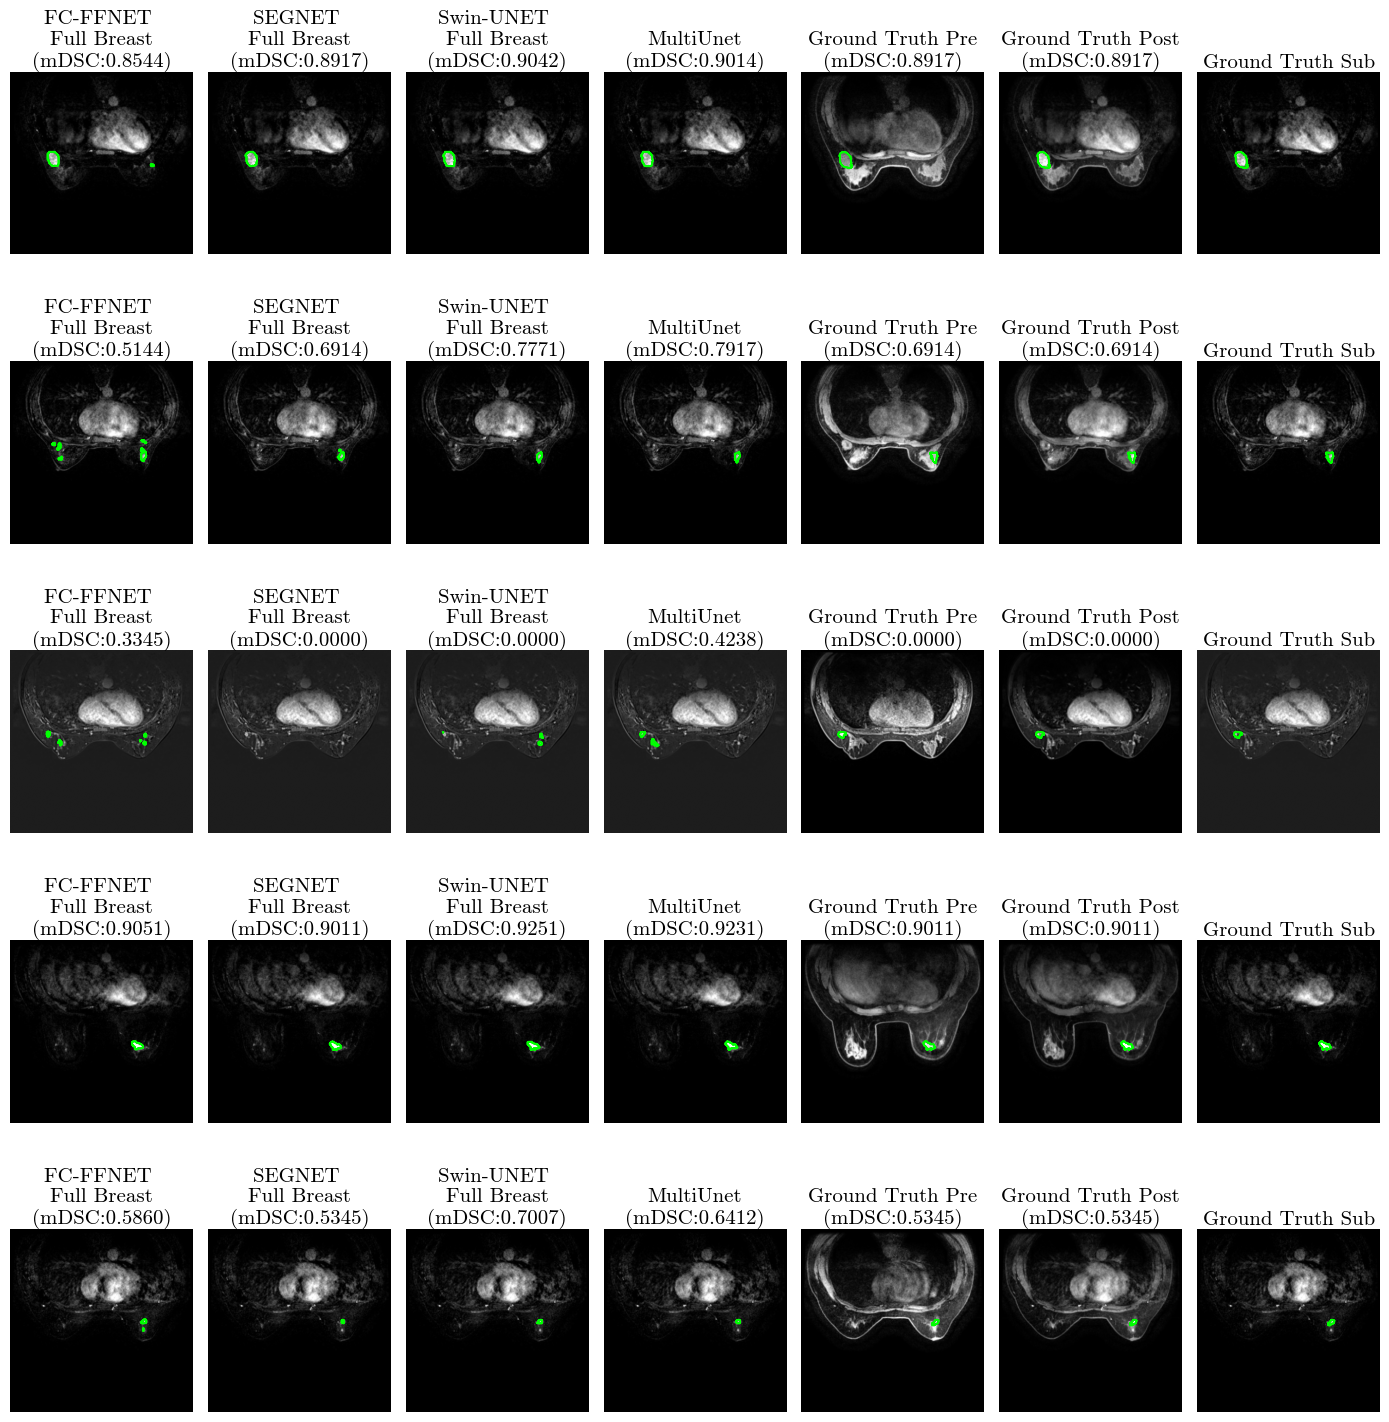

In [78]:
plot_image_groups_multiple_ids(results_groups=results_groups, captions=captions, num_plots= len(results_groups), images_keys =images_keys, indexes=indexes, bbox_size = None, plot_captions=True)

In [82]:
suffixes = [f"mass_{i+1}" for i in range(0, len(indexes))]

In [83]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
save_image_groups(results_groups=results_groups, captions=captions, suffixes=suffixes, indexes=indexes,images_keys=images_keys, save_images=True, bbox_size = None)

In [301]:
res = []
for g in results_groups[:-1]:
    res.append(g['dice_mass_scores'])


# Function to find increasing indices across arrays
def find_increasing_indices(arrays):
    num_arrays = len(arrays)
    num_elements = arrays[0].size  # Assumes all arrays have the same length
    increasing_indices = []

    for index in range(num_elements):
        is_increasing = True
        for i in range(num_arrays - 1):
            if arrays[i][index] >= arrays[i + 1][index]:
                is_increasing = False
                break
        if is_increasing:
            increasing_indices.append(index)

    return increasing_indices
# Get the increasing indexes
increasing_indexes = find_increasing_indices(res)

In [232]:
increasing_indexes

[26,
 29,
 33,
 34,
 39,
 40,
 42,
 49,
 84,
 101,
 119,
 222,
 227,
 231,
 232,
 233,
 234,
 253]

# OTHER

In [ ]:
image1 = check_data[0]["image"].to("cuda")
image2 = check_data[1]["image"].to("cuda")
image3 = check_data[2]["image"].to("cuda")

label = check_data[0]["label"].to("cuda")

fnames = check_data[0]['image_meta_dict']['filename_or_obj']

with torch.no_grad():

    model = model_fusion_sub_aufl.to("cuda")
    model.eval()
    logits = model(image1.to("cuda"),image2.to("cuda"),image3.to("cuda"))

pr_masks = logits.sigmoid()

print(pr_masks.shape)

ious1 = []
ious2 = []



for image, gt_mask, pr_mask, fname in zip(image1, label, pr_masks, fnames):
    
    iou =  compute_iou(y_true = gt_mask/255, y_pred = torch.where(pr_mask> 0.4,torch.tensor(1.0), torch.tensor(0.0))
                              , class_id = 1)
    print(iou.item())

    ious2.append(iou.item())

    iou =  compute_iou(y_true = gt_mask/255, y_pred = torch.where(pr_mask> 0.4,torch.tensor(1.0), torch.tensor(0.0))
                              , class_id = 0)

    ious1.append(iou.item())

    pr_mask = (pr_mask.cpu().numpy().squeeze() > 0.4).astype(int)
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.cpu().numpy().transpose(1,2,0), cmap='gray')  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask[0].cpu().numpy(), cmap='gray') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask, cmap='gray') # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")
    plt.show()


    i = Image.open(fname)
    plt.imshow(i, cmap='gray')
    plt.show()
